In [5]:
# import numpy as np
%matplotlib inline
import numpy as np
import GPy
import mountain_car as mc
import gym
from IPython.html.widgets import interact
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

np.random.seed(12345) # for reproducibility purposes

ModuleNotFoundError: No module named 'IPython.html'

# Analysis and optimization of a mountain car simulator

*Javier Gonzalez* and *Mark Pullin*

Amazon Cambridge, UK.


## Index

======================================================================================================================

1. [Goal of this notebook](#1.-Goal-of-this-notebook)
2. [The mountain car simulator](#2.-The-mountain-car-simulator)
3. [Solving the mountain car example with an emulator of the reward](#3.-Solving-the-mountain-car-example-with-an emulator-of-the-reward)
4. [Data efficient emulation of the car dynamics](#4.-Data-efficient-emulation-of-the-car-dynamics)
5. [Conclusions](#5.-Conclusions)

======================================================================================================================


## 1. Goal of this notebook

In this notebook we use Emukit to illustrate different concepts of [Uncertainty Quantification](https://en.wikipedia.org/wiki/Uncertainty_quantification) (UQ) and the role that Gaussian processes play in this field. Based on a simple simulator of a car moving between a valley and a mountain, we are going to illustrate the following concepts:

- ** Systems emulation**. Many real world decisions are based on simulations that can be computationally very demanding. We will show how simulators can be replaced by *emulators*: Gaussian process models fitted on a few simulations that can be used to replace the *simulator*. Emulators are cheap to compute, fast to run, and always provide ways to quantify the uncertainty of how precise they are compared the original simulator.


- **Emulators in optimization problems**. We will show how emulators can be used to optimize black-box functions that are expensive to evaluate. This field is also called Bayesian Optimization and has gained an increasing relevance in machine learning as emulators can be used to optimize computer code (machine learning algorithms) quite efficiently.

## 2. The mountain car simulator


To illustrate the above mentioned concepts we we use the [mountain car simulator](https://github.com/openai/gym/wiki/MountainCarContinuous-v0). This simulator is widely used in machine learning to test reinforcement learning algorithms. The goal is to define a control policy on a car whose objective is to climb a mountain. Graphically, the problem looks as follows: 


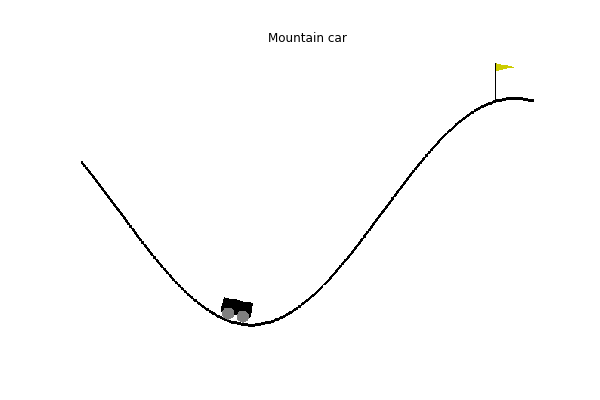

In [2]:
# Illustratrion of one frame of the mountain car simulator
env = gym.make('MountainCarContinuous-v0')
observation = env.reset()
cum_reward = 0
frame = []
frame.append(env.render(mode = 'rgb_array'))
action = env.action_space.sample()
observation, reward, done, info = env.step(action)
env.render(close=True)
mc.display_frames_as_gif(frame,title='Mountain car')

The goal is to define a sequence of actions (push the car right or left with certain intensity) to make the car reach the flag after a number $T$ of time steps.

At each time step $t$, the car is characterized by a vector $\textbf{x}_{t} = (p_t,v_t)$ of states which are respectively the the position and velocity of the car at time $t$. For a sequence of states (an episode), the dynamics of the car is given by

$$\textbf{x}_{t+1} = f(\textbf{x}_{t},\textbf{u}_{t})$$

where $\textbf{u}_{t}$ is the value of an action force, which in this example corresponds to push car to the left (negative value) or to the right (positive value). The actions across a full episode are represented in a policy $\textbf{u}_{t} = \pi(\textbf{x}_{t},\theta)$ that acts according to the current state of the car and some parameters $\theta$. In the following examples we will assume that the policy is linear which allows us to write $\pi(\textbf{x}_{t},\theta)$ as

$$\pi(\textbf{x},\theta)= \theta_0 + \theta_p p + \theta_vv. $$

For $t=1,\dots,T$ now given some initial state $\textbf{x}_{0}$ and some some values of each $\textbf{u}_{t}$, we can **simulate** the full dynamics of the car for a full episode using [Gym](https://gym.openai.com/envs/). The values of 
$\textbf{u}_{t}$ are fully determined by the parameters of the linear controller.

After each episode of length is complete, a reward function $R_{T}(\theta)$ is computed. In the mountain car example the reward is computed as 100 for reaching the target of the hill on the right hand side, minus the squared sum of actions (a real negative to push to the left and a real positive to push to the right) from start to goal.  Note that our reward depend on $\theta$ as we make it dependent on the parameters of the linear controller.

## 3. Solving the mountain car example with an emulator of the reward

Our goal in this section is to find the parameters $\theta$ of the linear controller such that

$$\theta^* = arg \max_{\theta} R_T(\theta).$$ 

In this section, we directly use Bayesian optimization to solve this problem. We will use Emukit so we fist define the objective function:

In [3]:
simulator_reward = lambda x: mc.run_simulation(env, x)[0]

def reward_function(X):
    rewards = np.empty(shape=[0, 1])
    for i in range(X.shape[0]):
        rewards = np.vstack([rewards, simulator_reward(X[i,None])])
    return rewards

For each set of parameter values of the linear controller we can run an episode of the simulator (that we fix to have a horizon of $T=500$) to generate the reward. Using as input the parameters of the controller and as outputs the rewards we can build a Gaussian process emulator of the reward. 

We start defining the input space, which is three-dimensional:

In [4]:
from emukit.core import ParameterSpace, ContinuousParameter
parameter_space = ParameterSpace([ContinuousParameter('postion_parameter', -1.2, 1),
                                  ContinuousParameter('velocity_parameter', -1/0.07, 1/0.07),
                                  ContinuousParameter('constant', -1, 1),])

To initalize the model we start sampling some initial points (25) for the linear controler randomly. 

In [5]:
from emukit.core.initial_designs import RandomDesign
design = RandomDesign(parameter_space) 
X = design.get_samples(25)

Before we start any optimization, lets have a look to the behavior of the car with the first of these initial points that we have selected randomly.


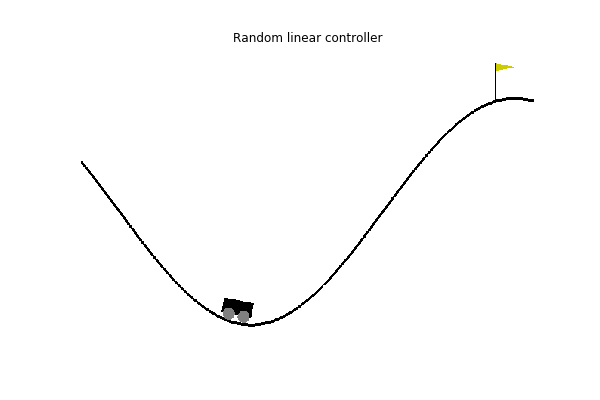
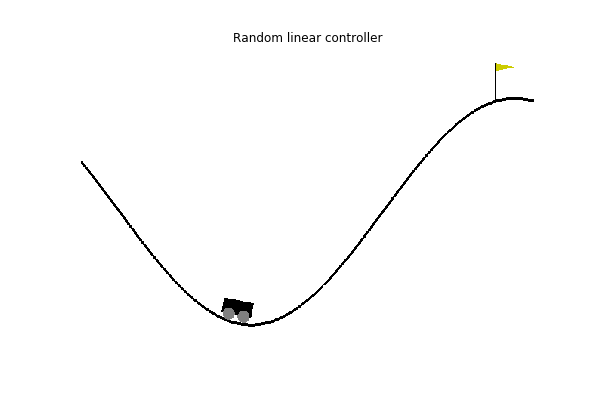
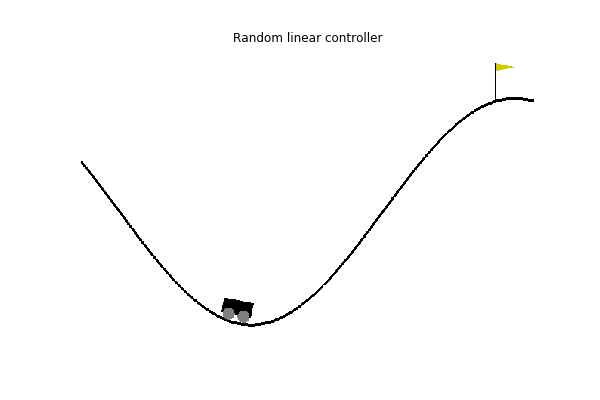
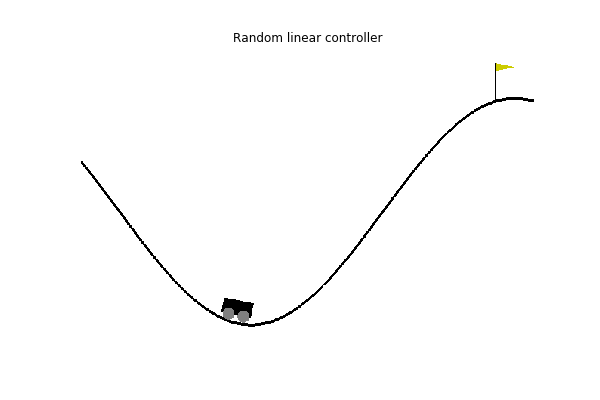
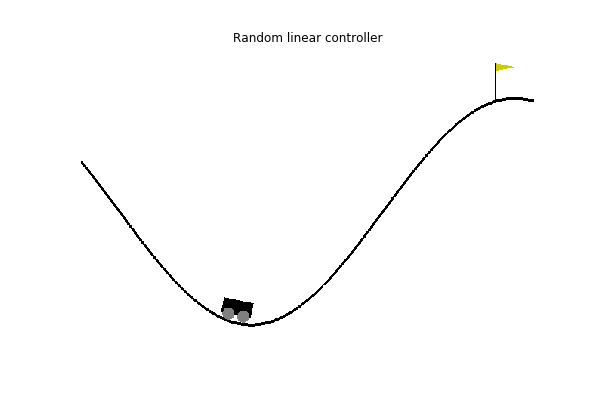
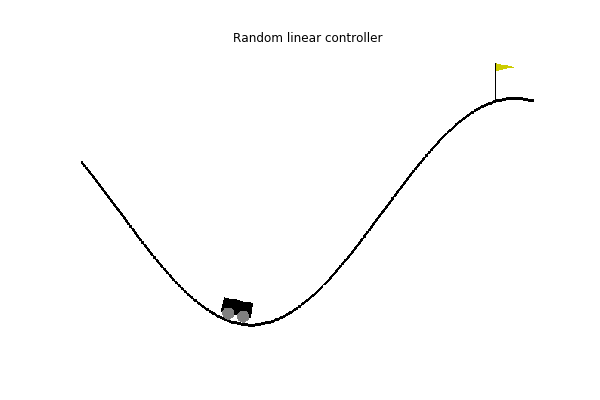
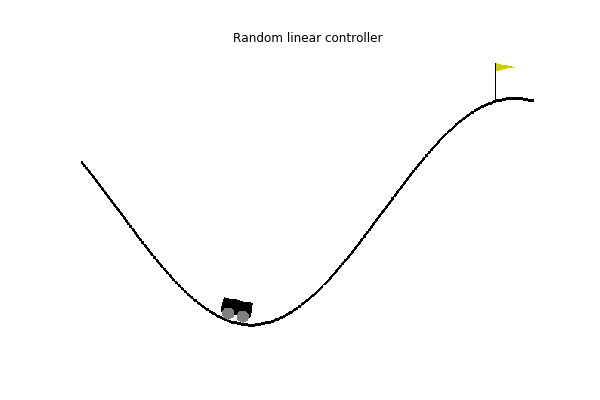
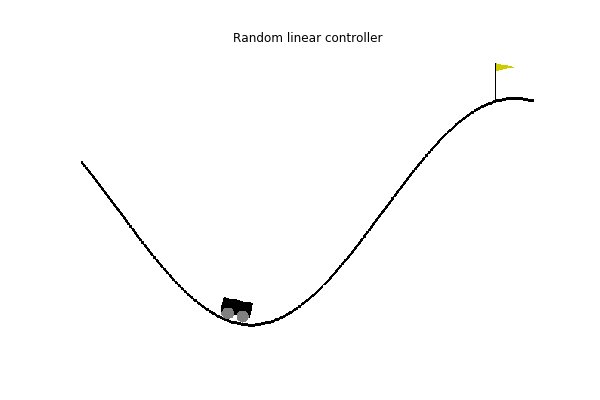
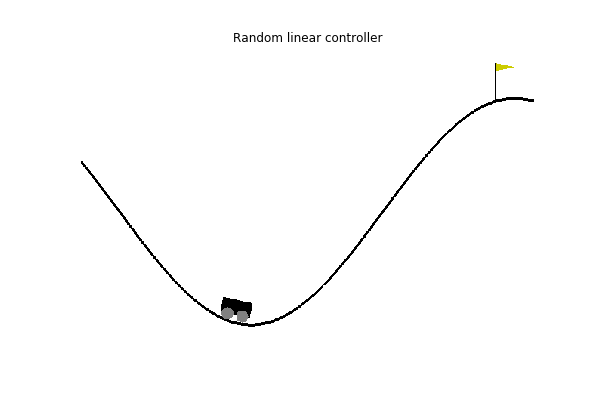
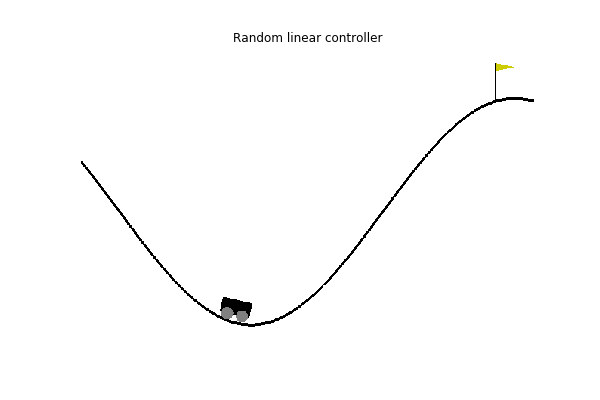
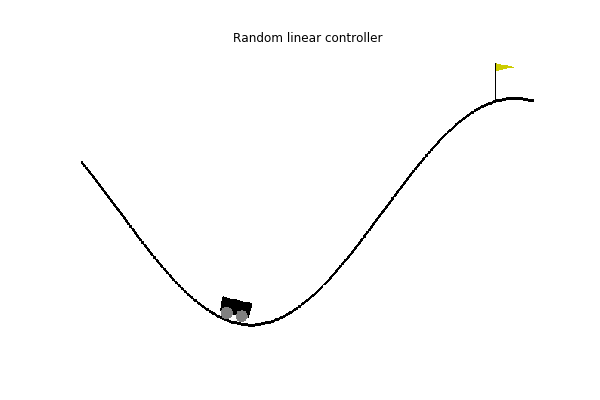
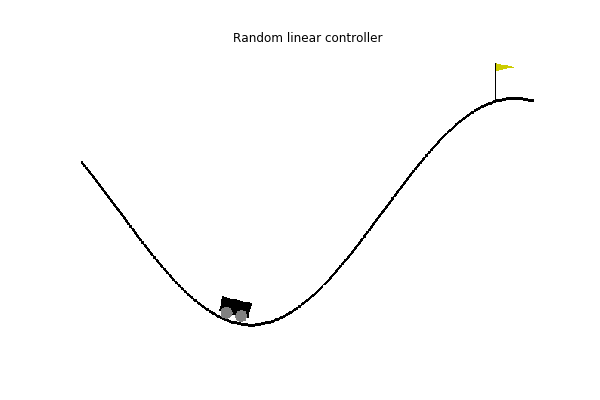
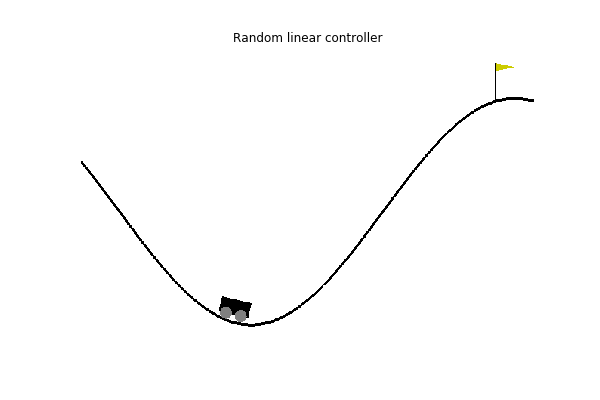
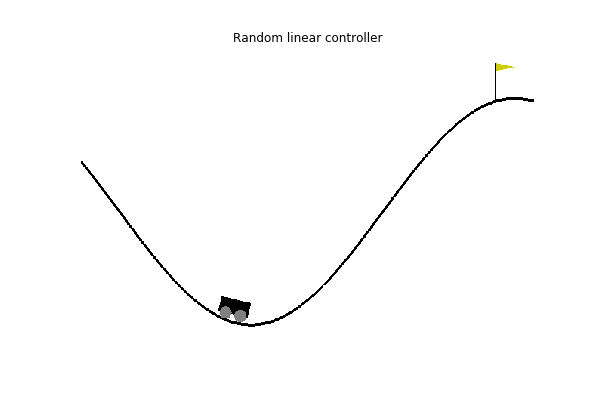
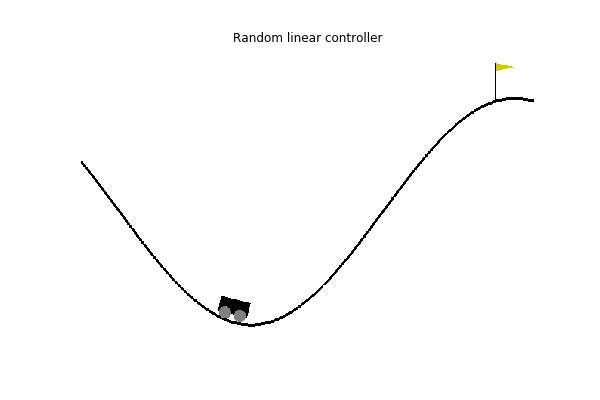
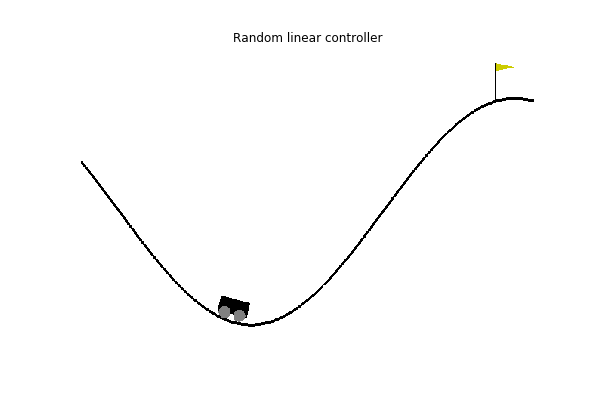
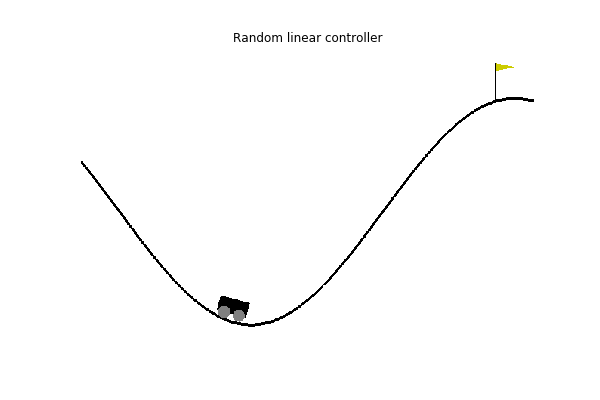
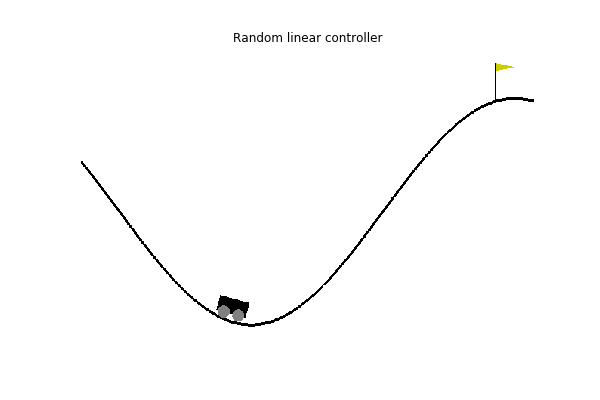
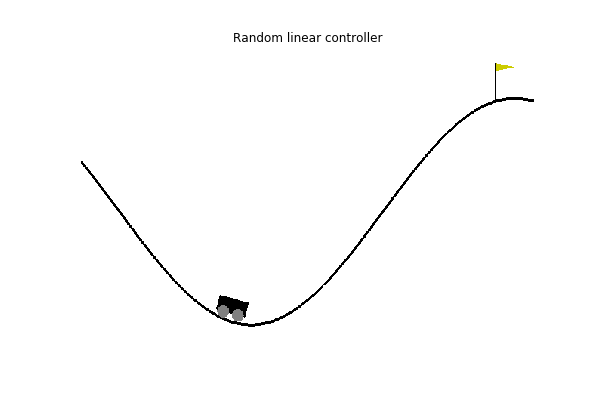
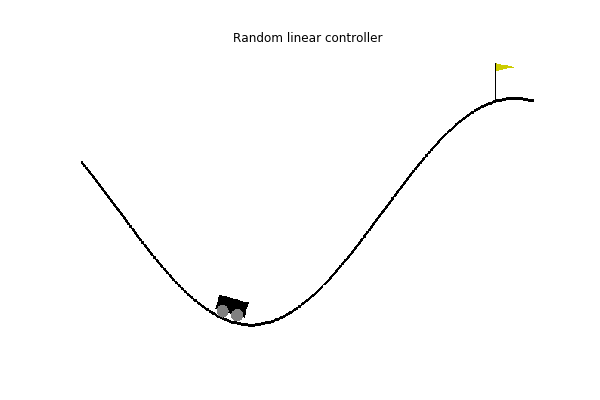
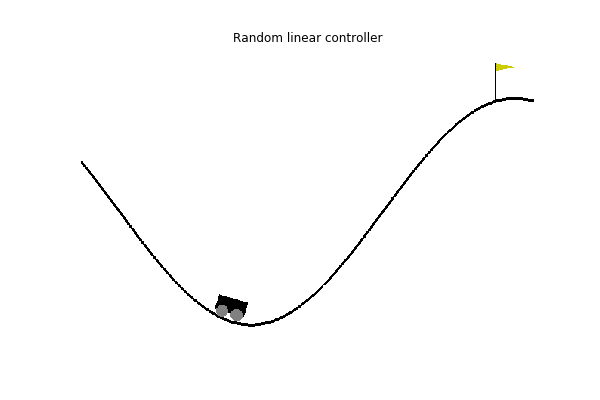
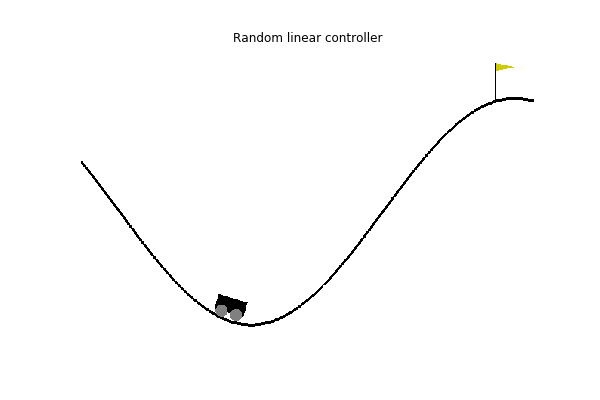
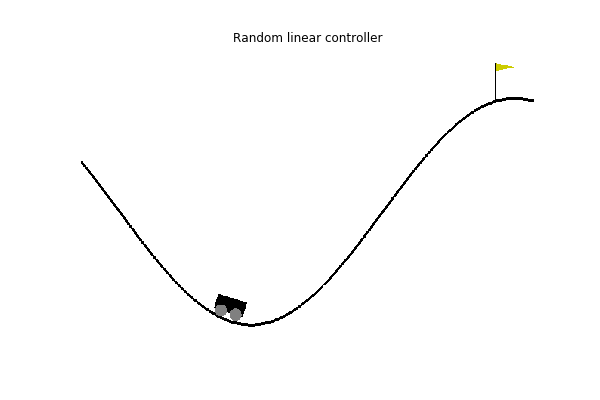
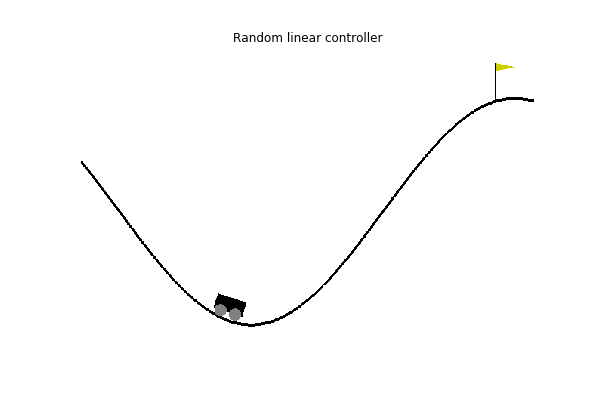
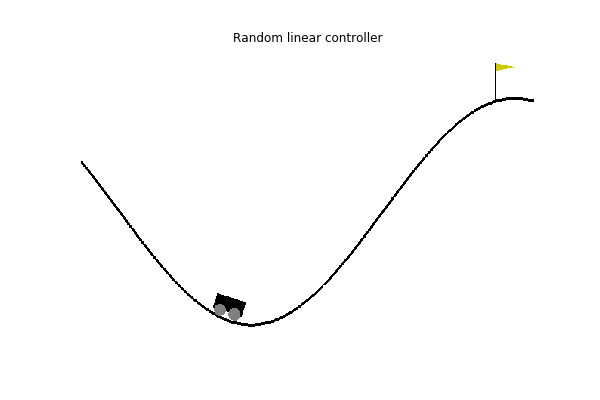
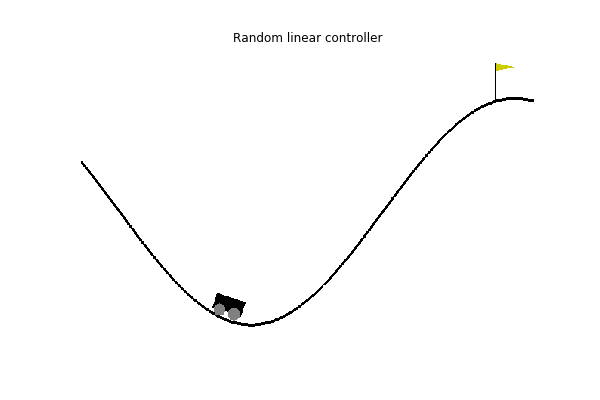
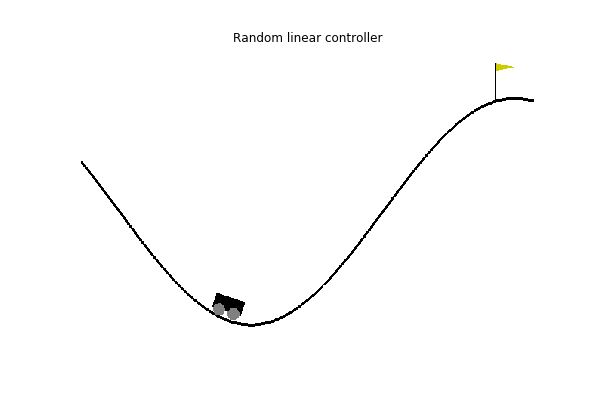
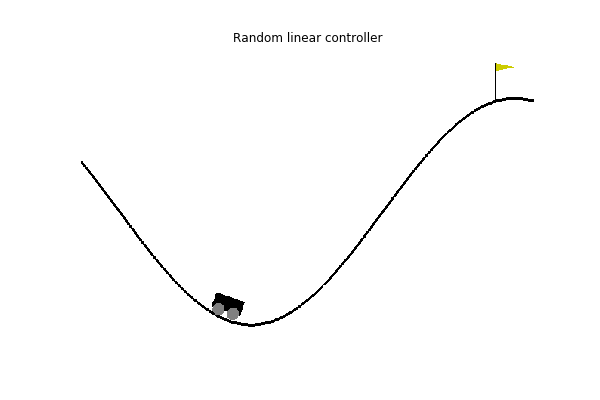
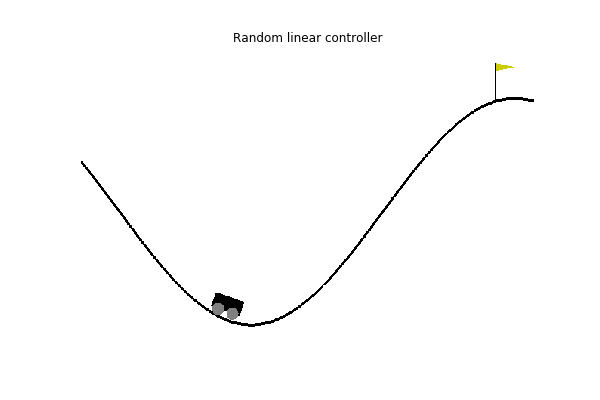
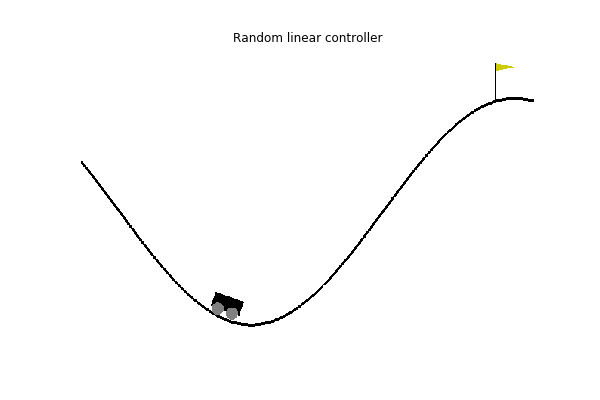
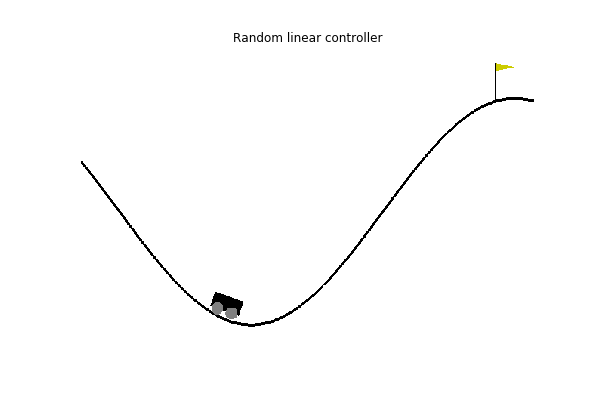
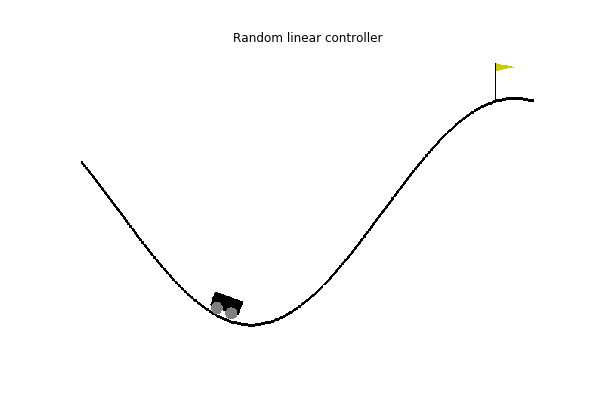
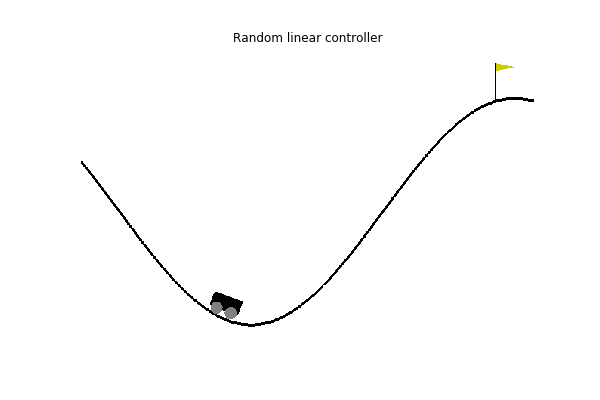
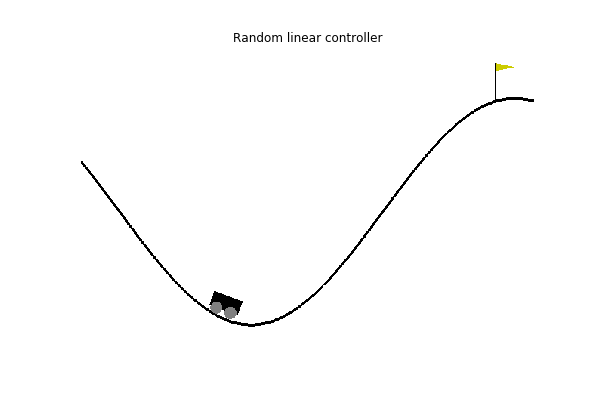
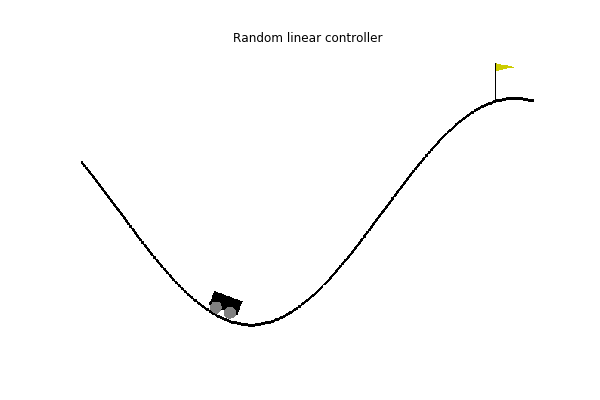
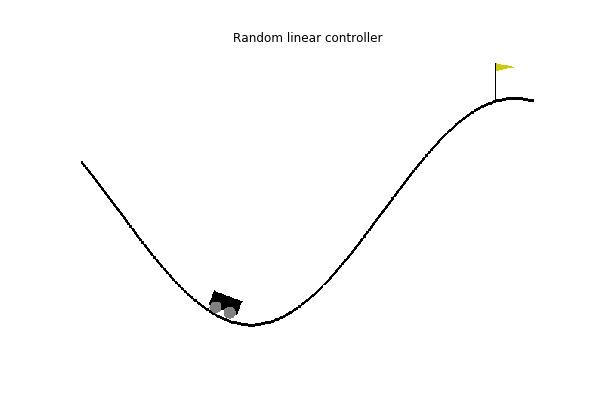
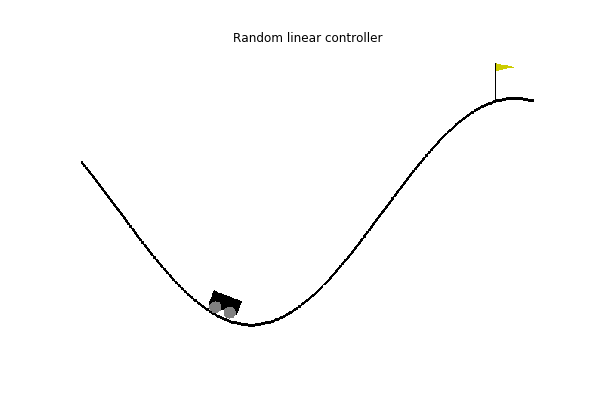
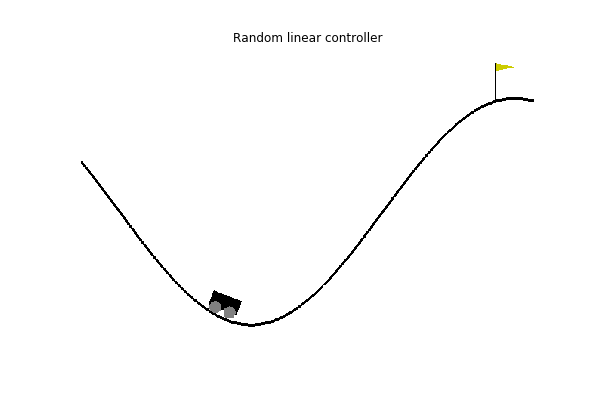
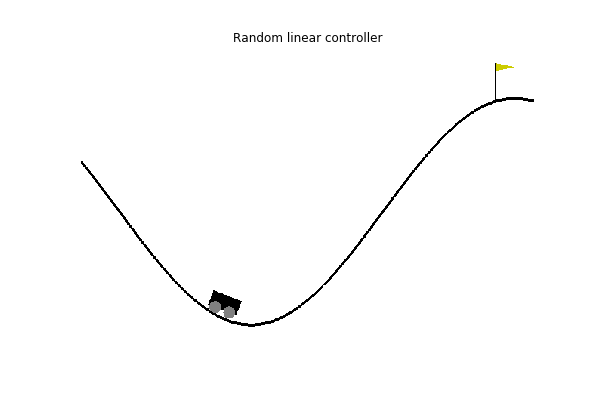
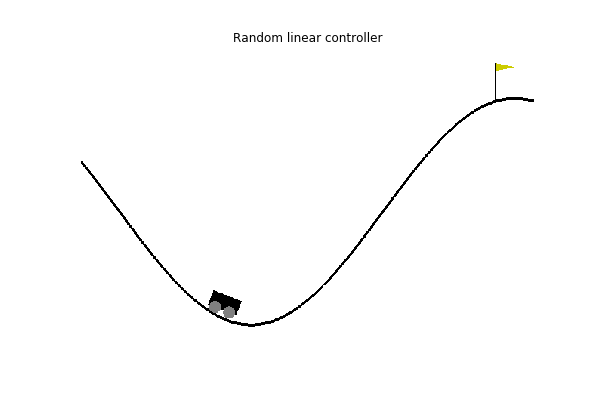
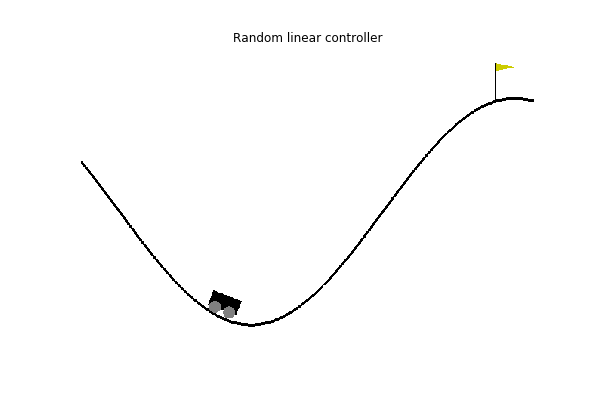
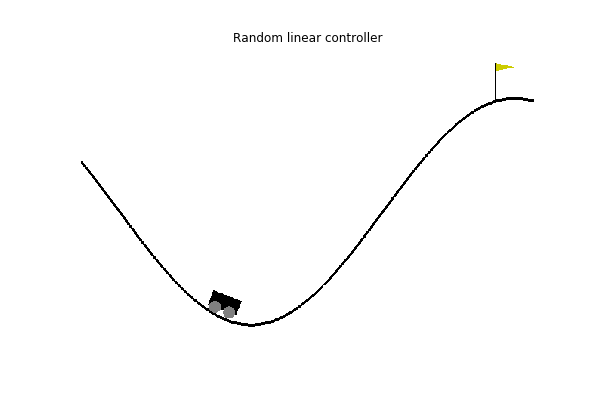
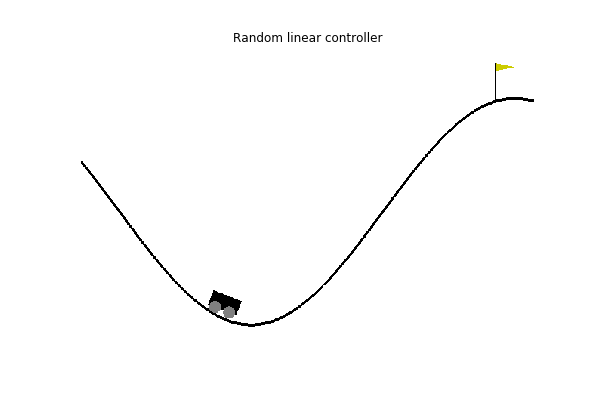
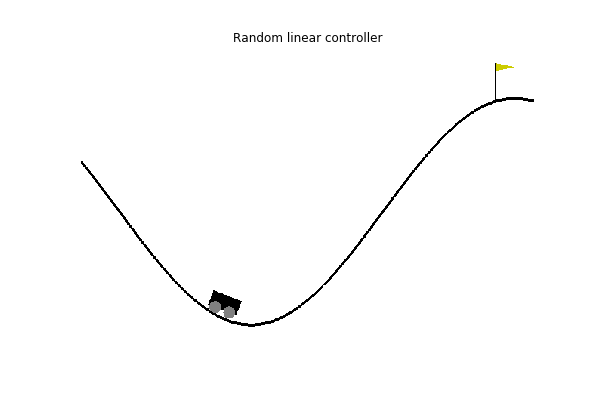
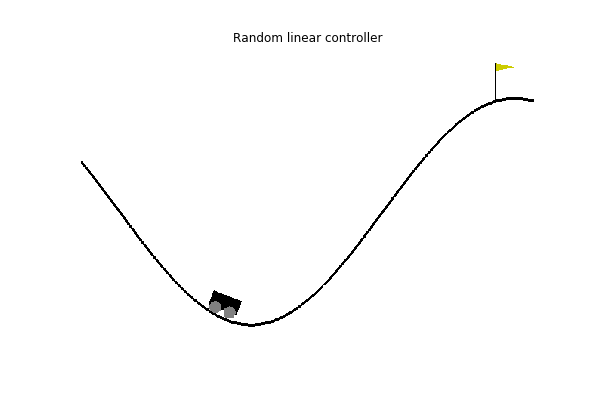
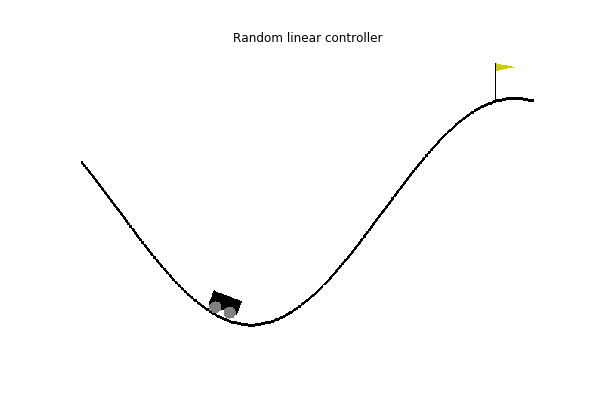
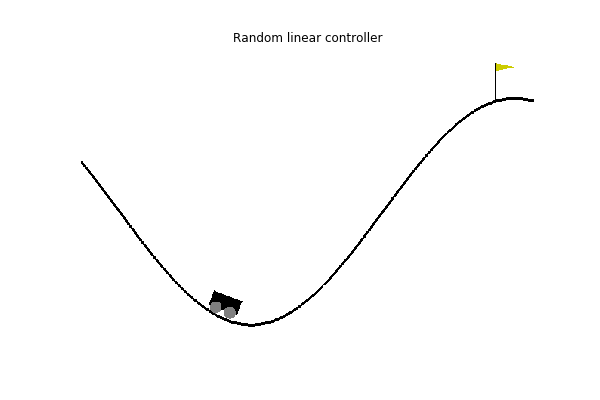
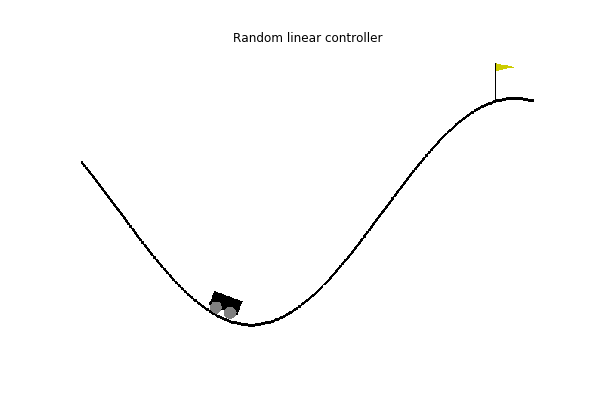
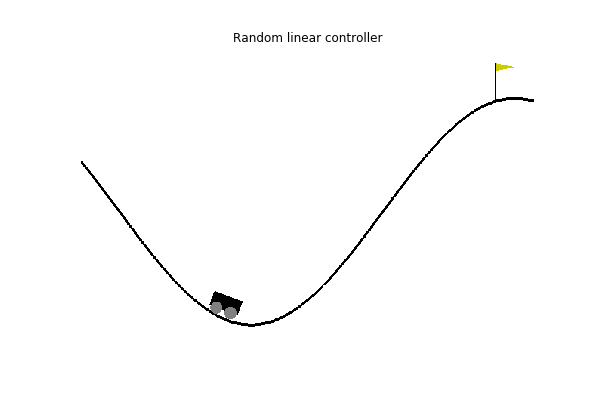
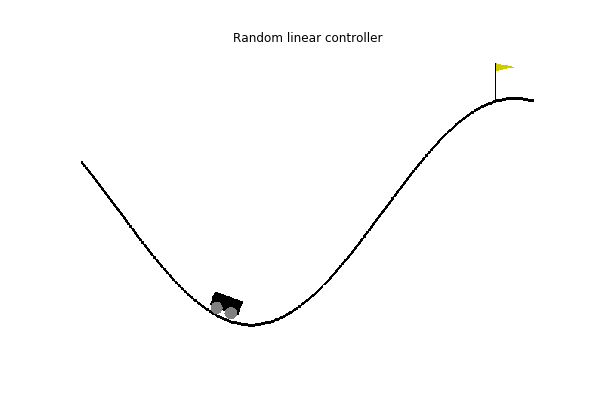
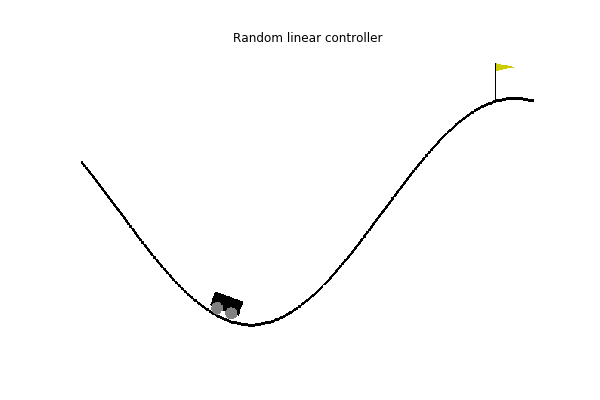
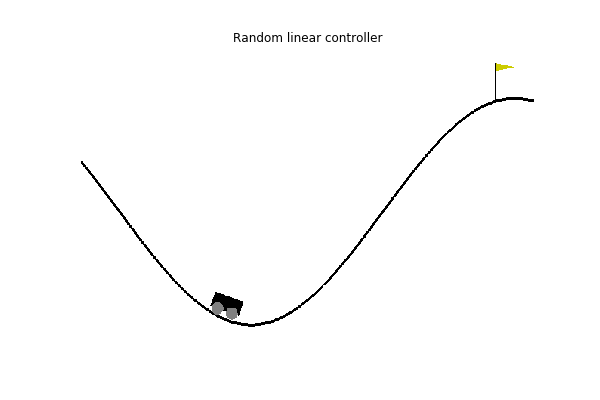
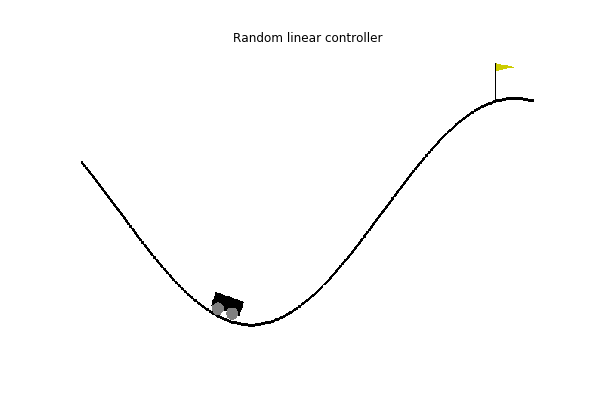
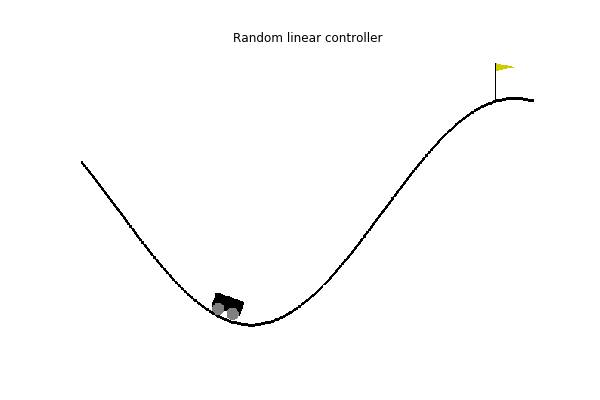
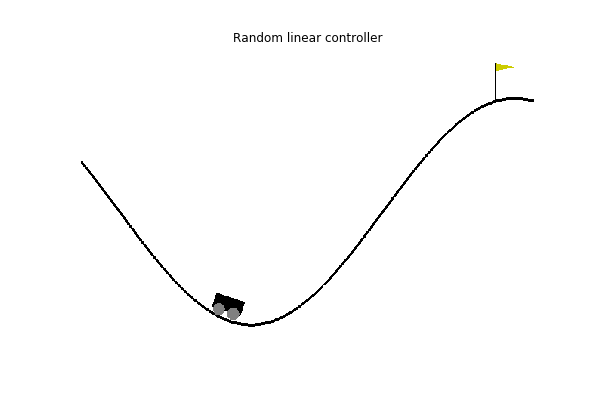
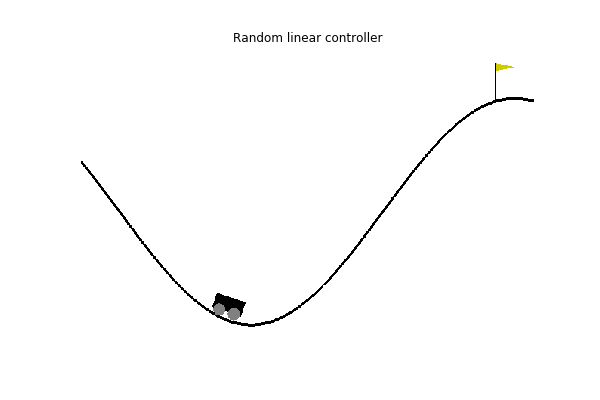
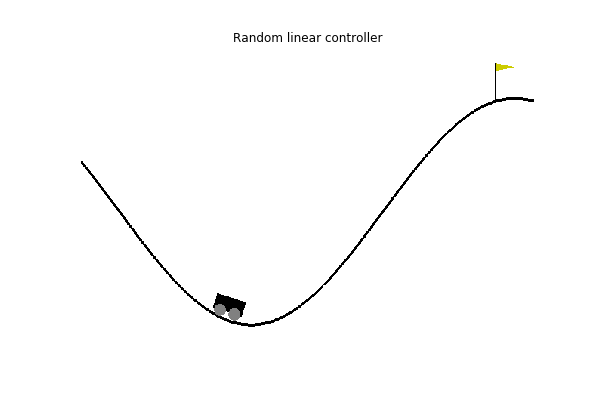
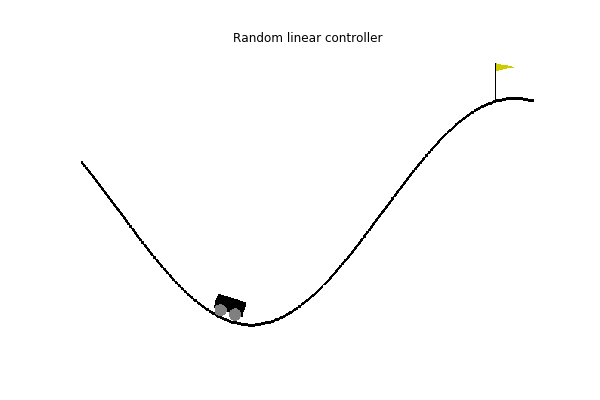
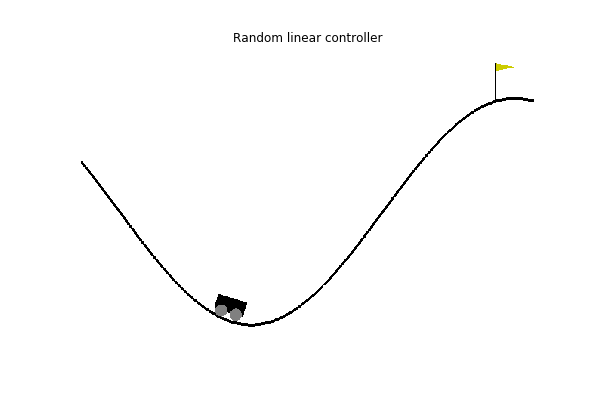
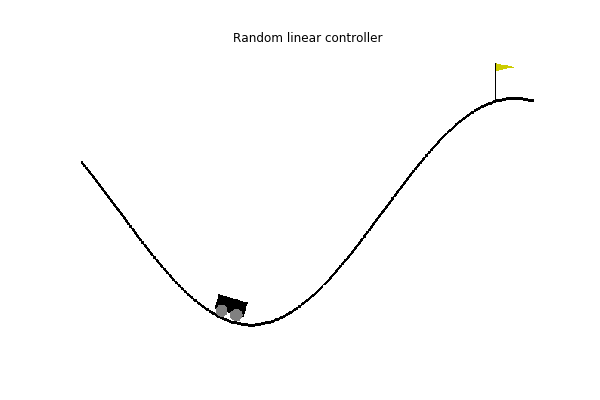
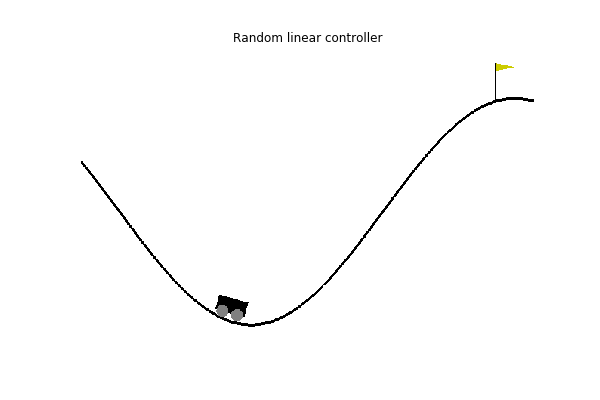
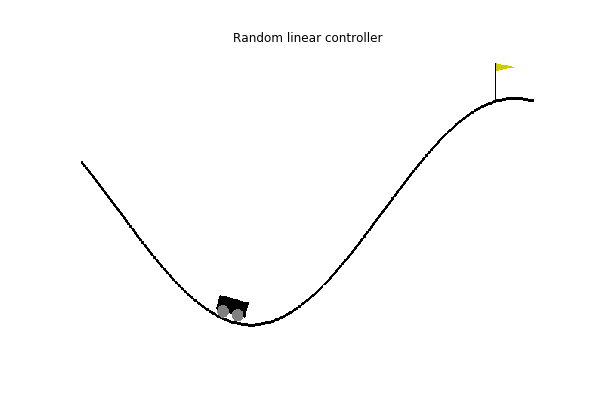
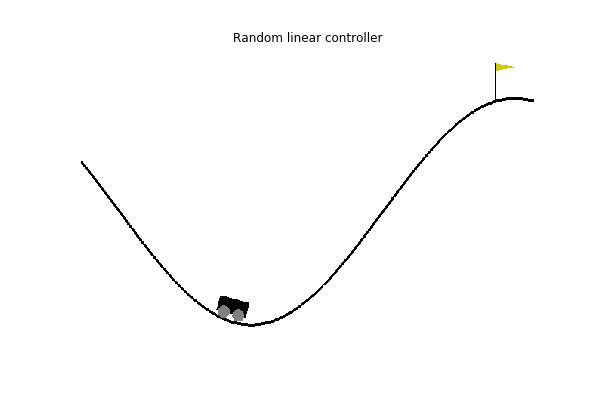
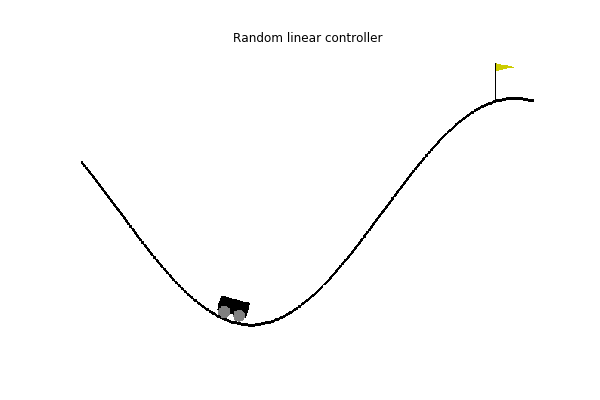
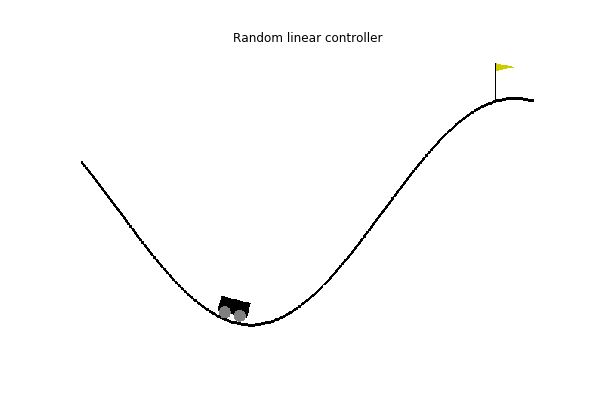
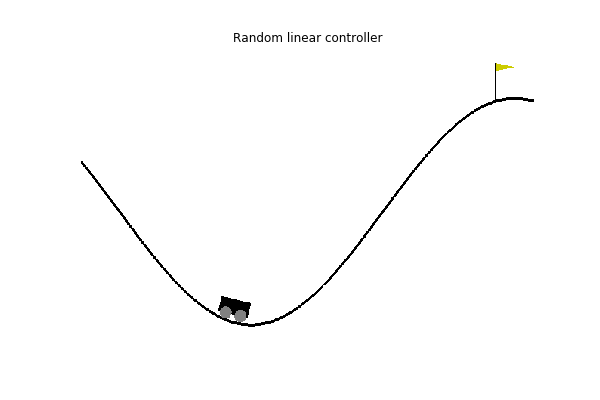
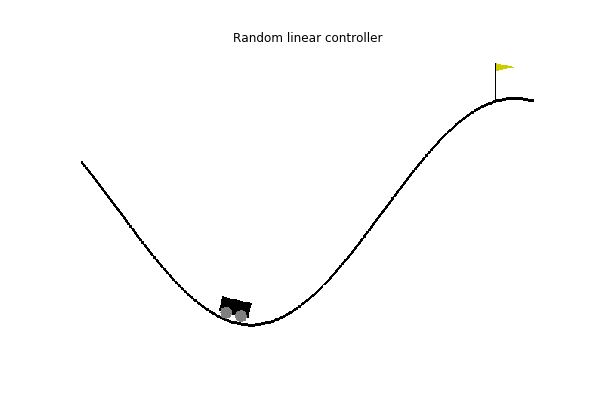
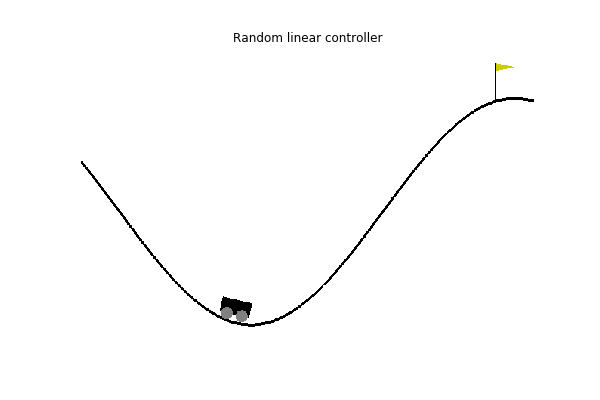
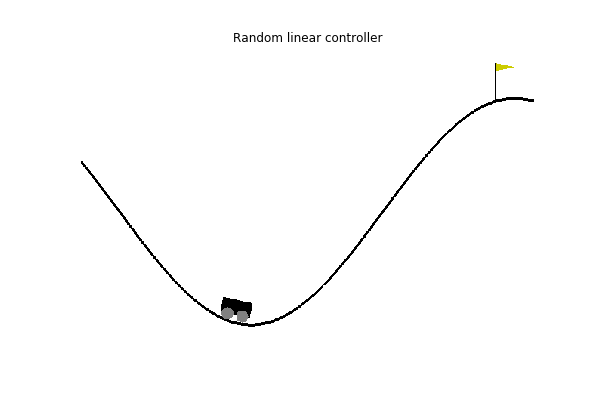
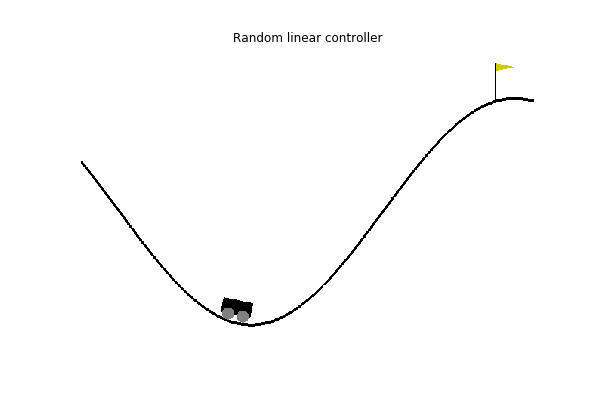
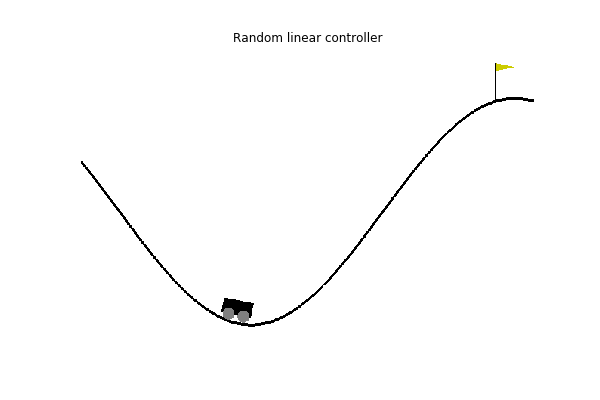
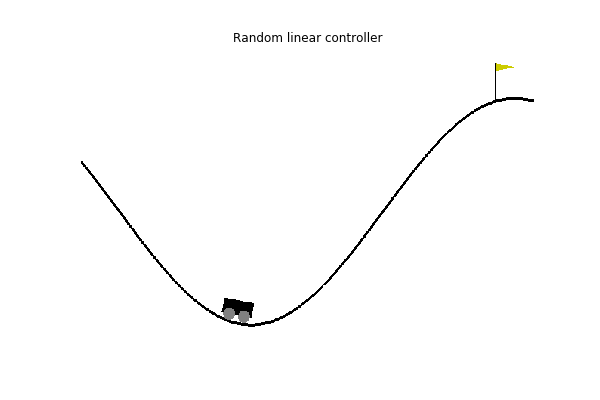
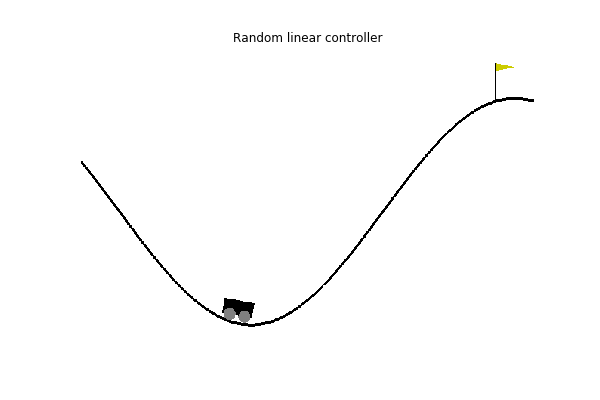
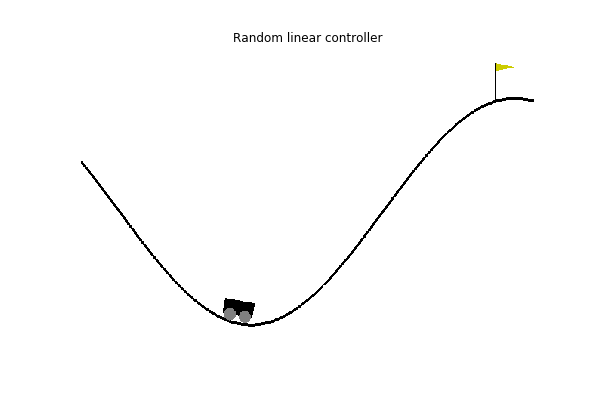
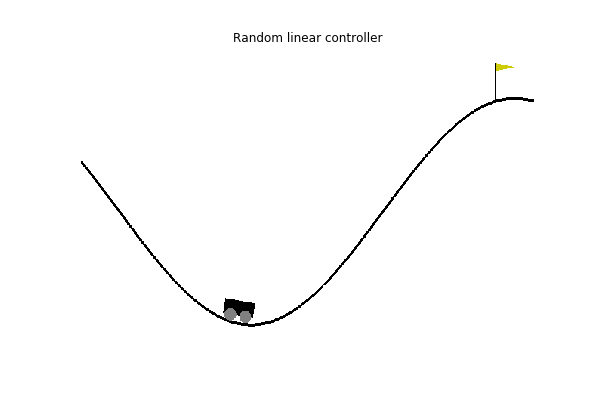
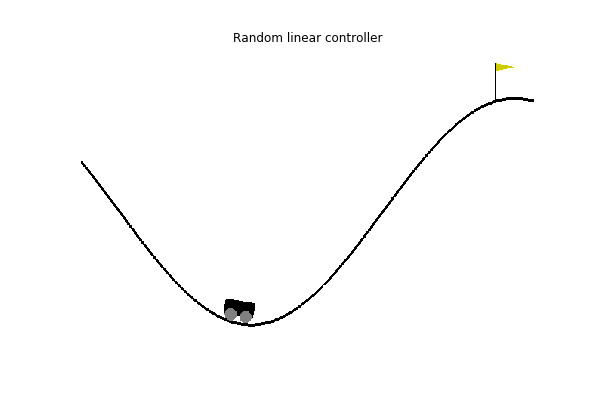
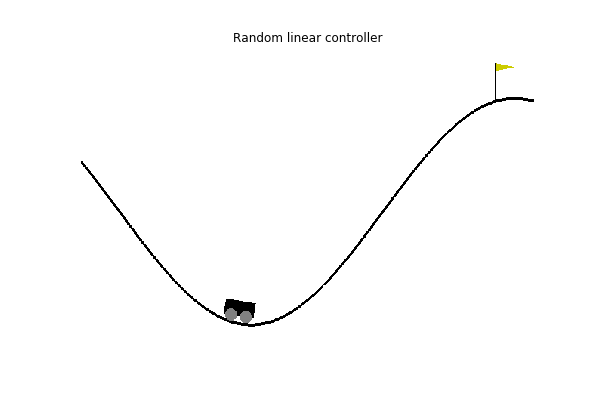
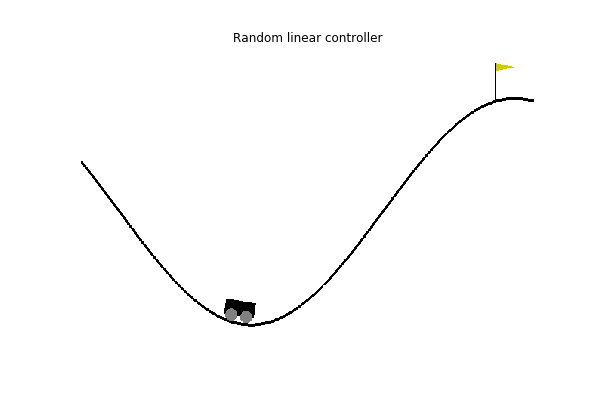
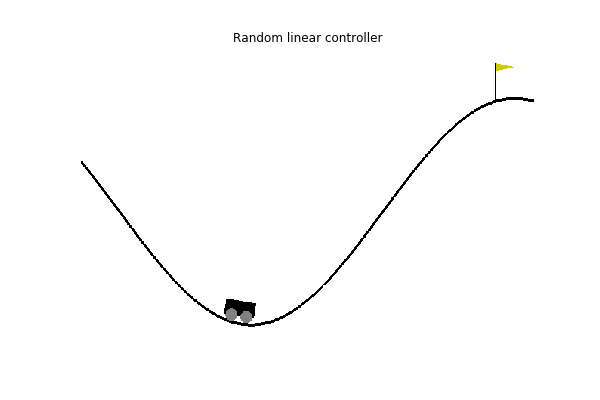
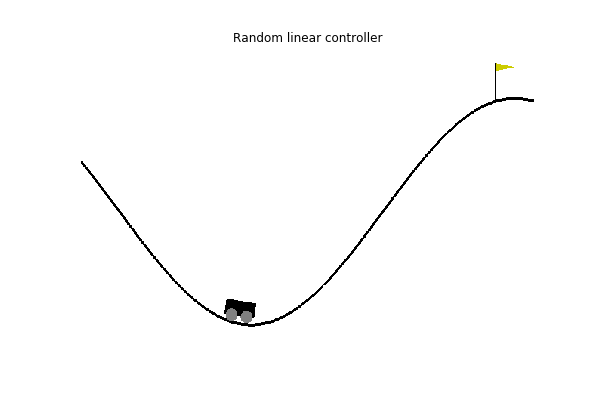
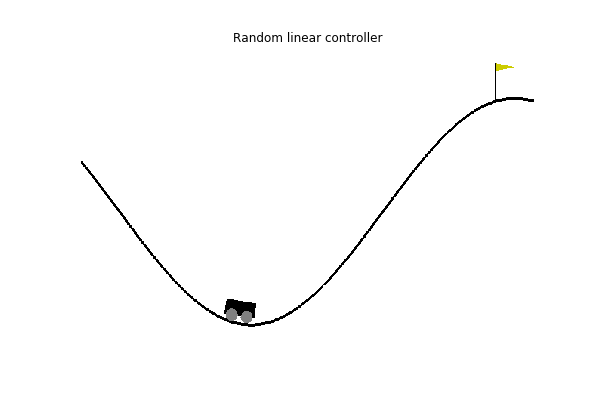
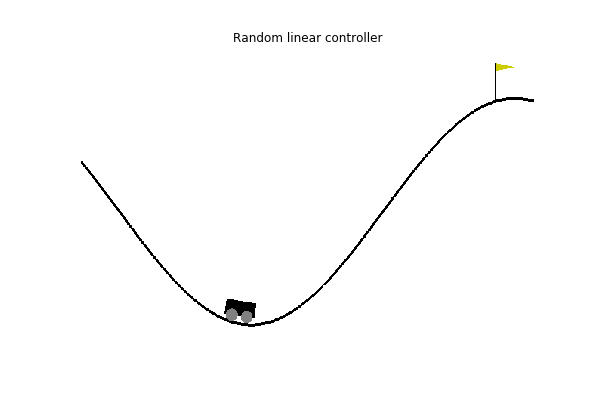
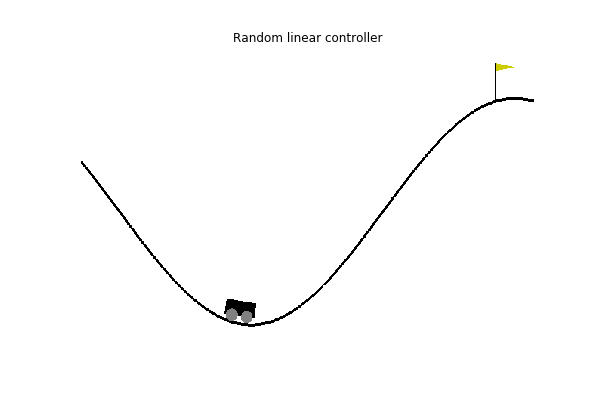
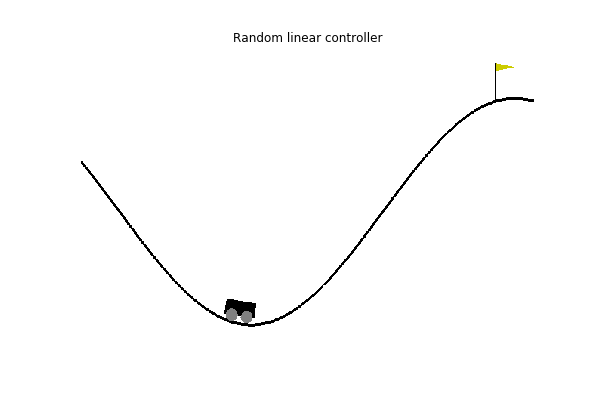
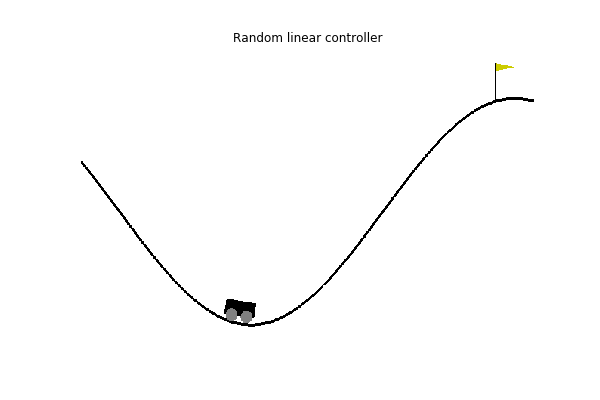
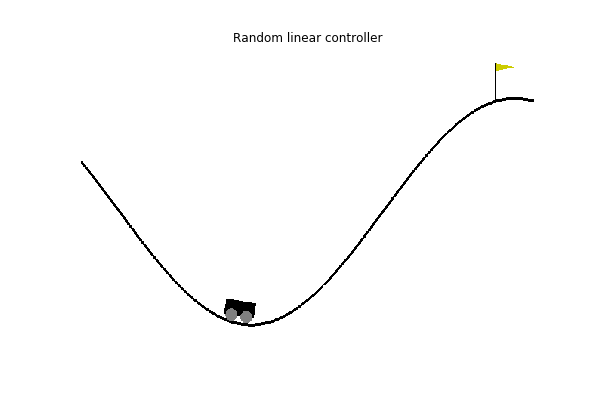
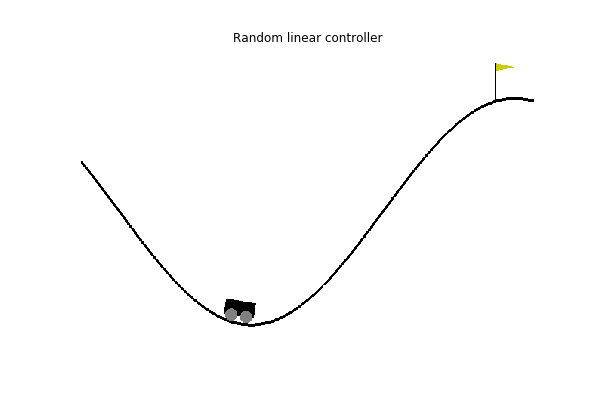
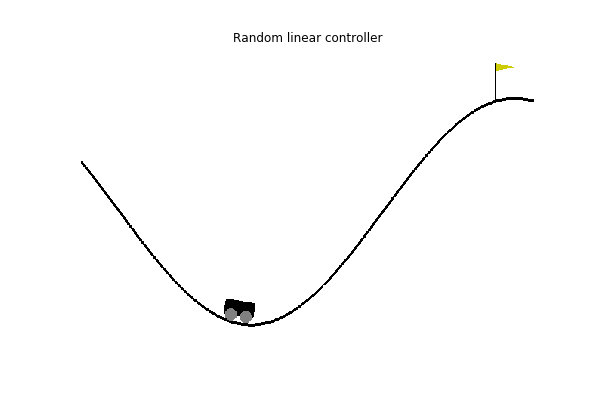
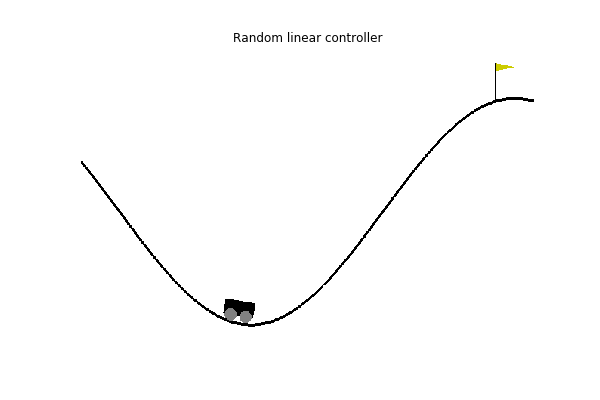
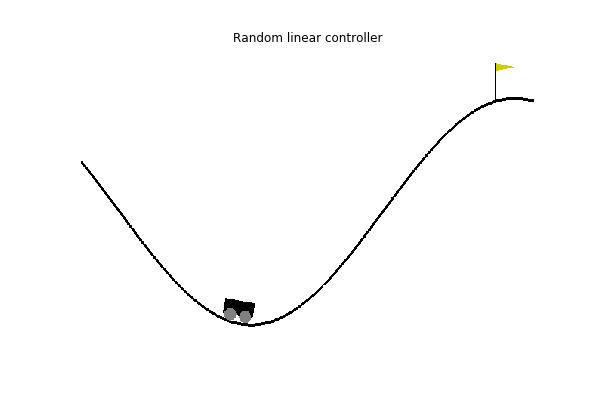
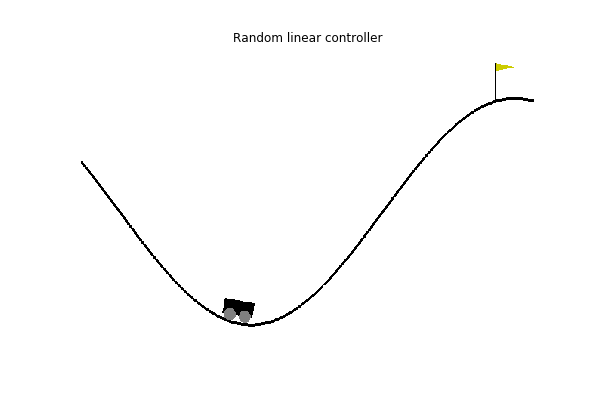
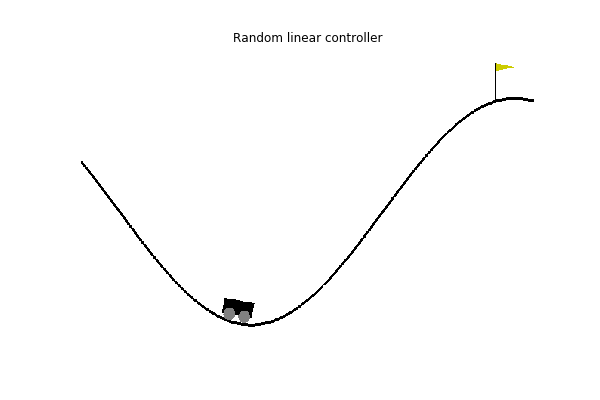
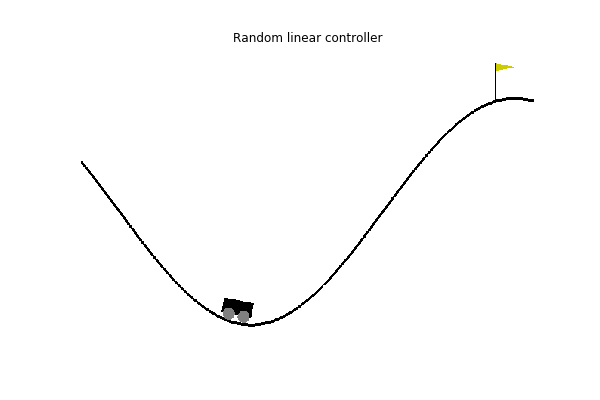
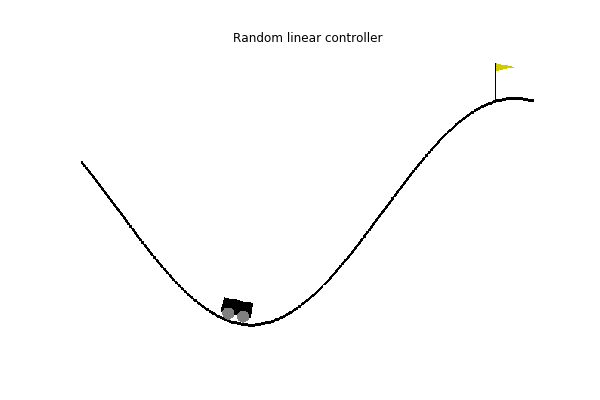
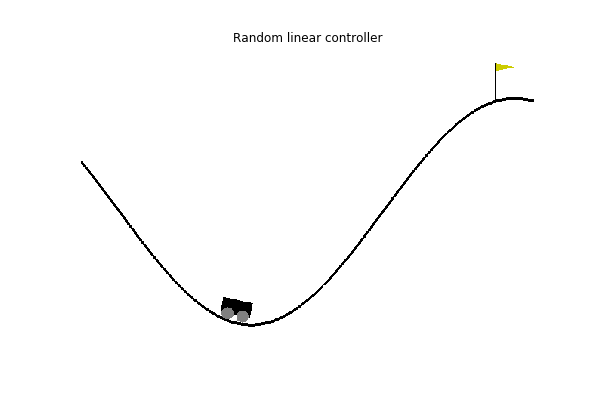
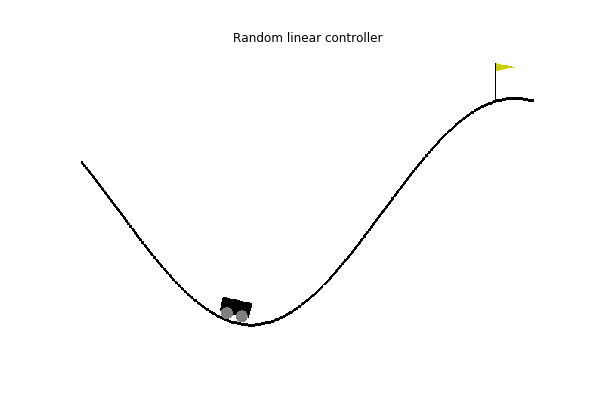
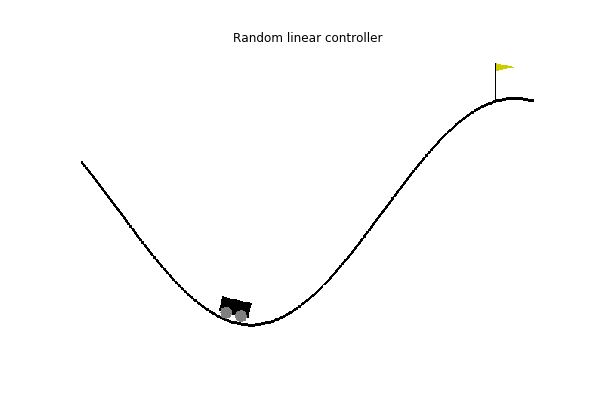
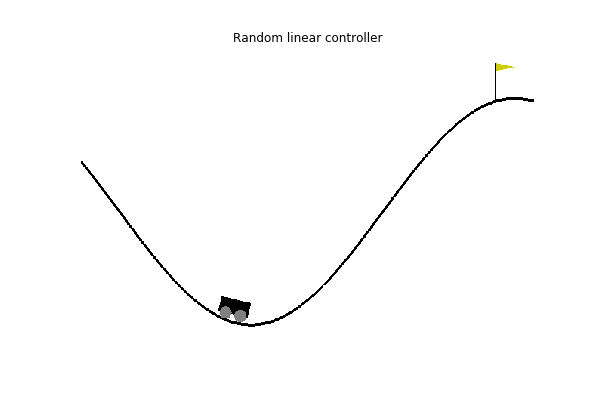
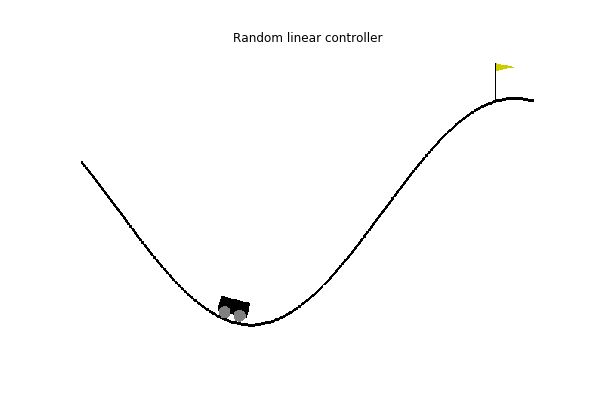
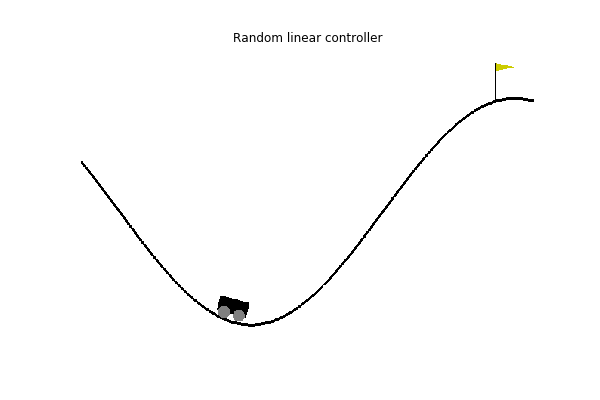
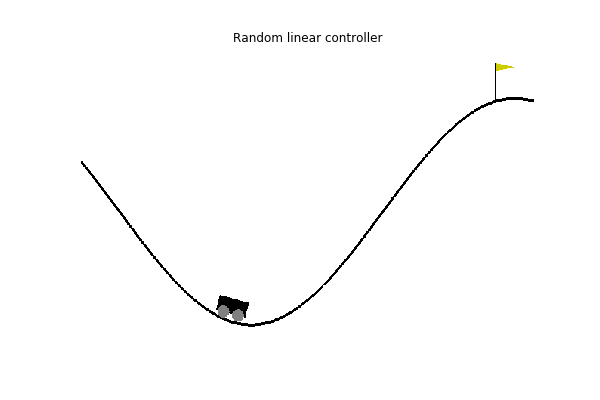
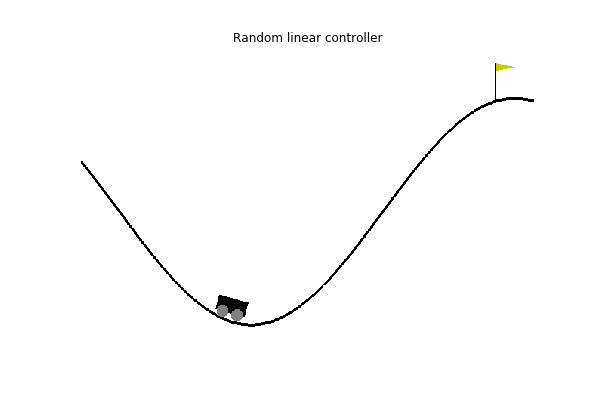
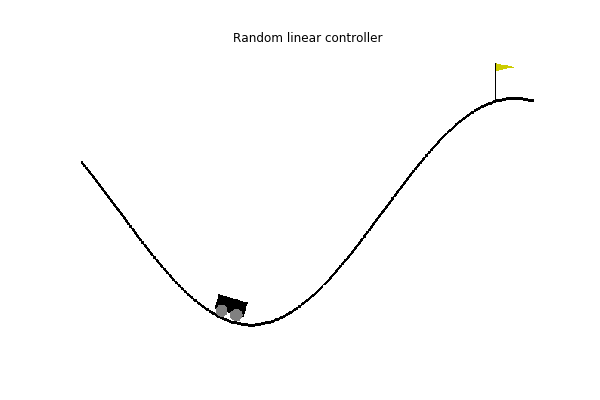
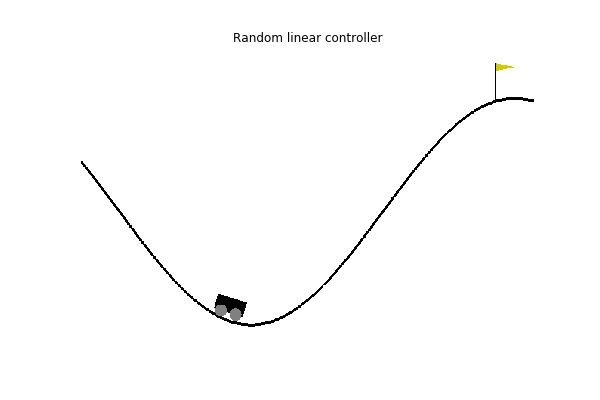
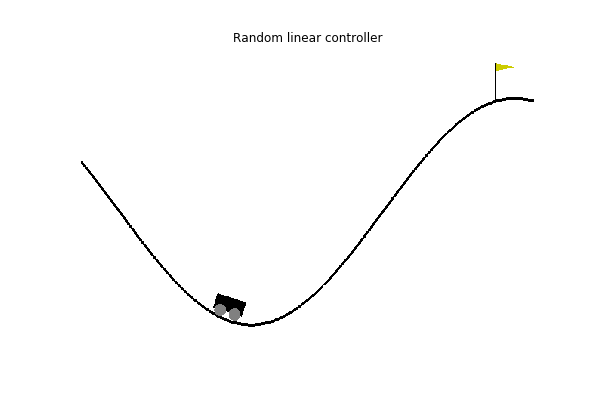
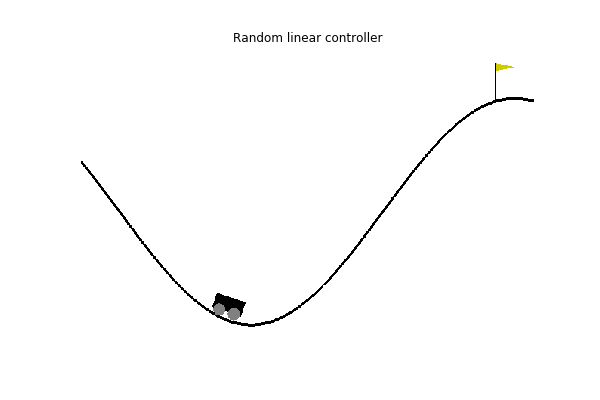
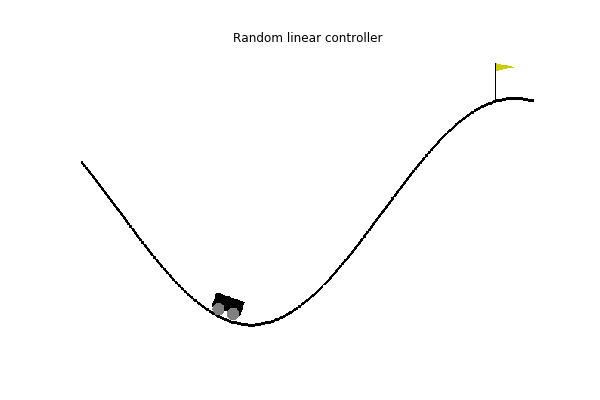
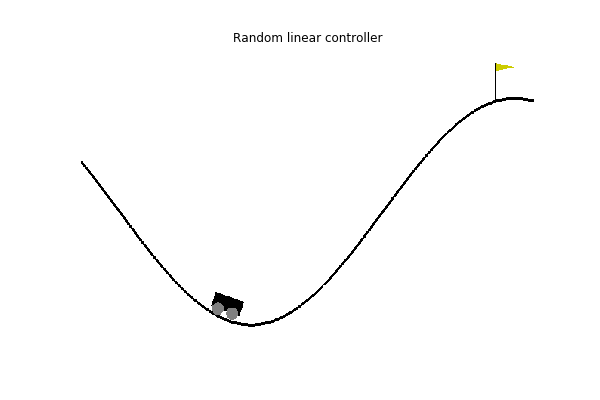
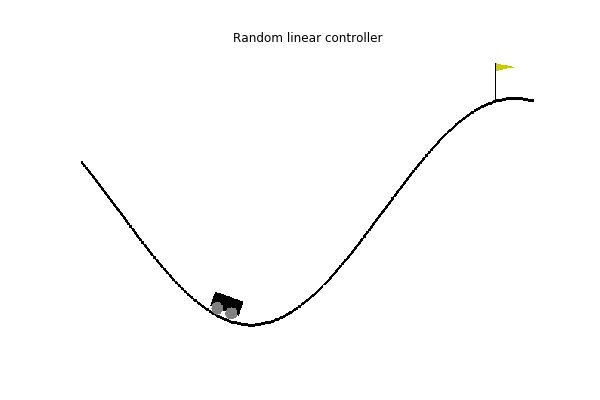
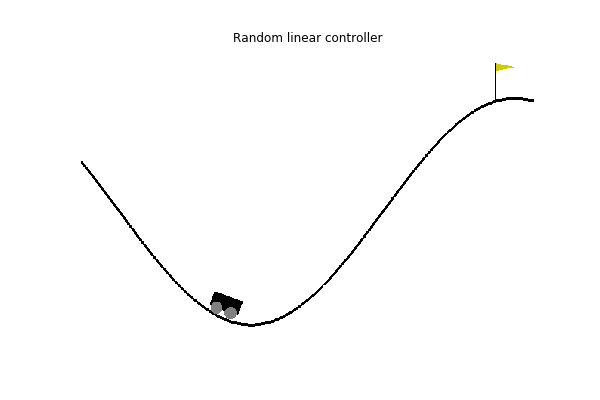
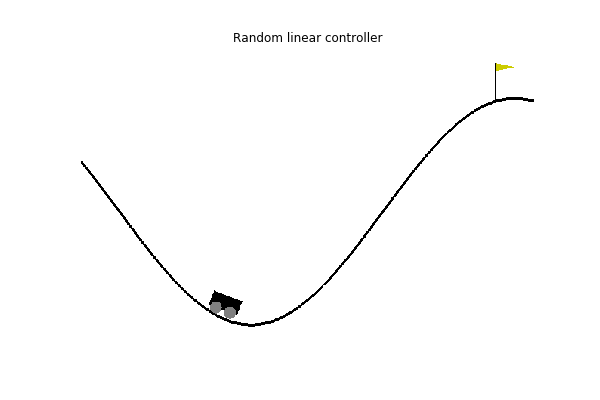
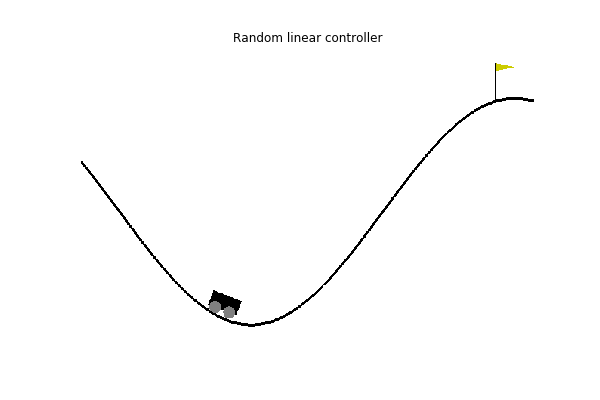
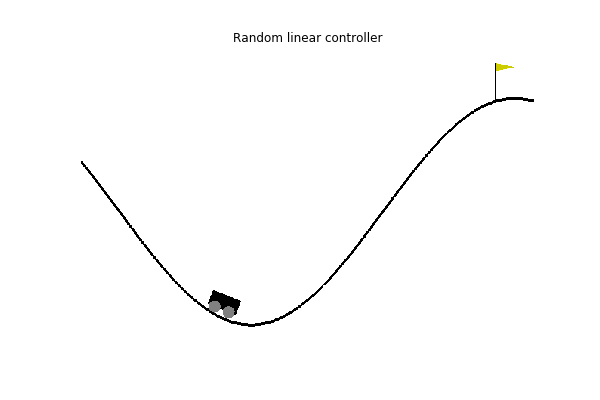
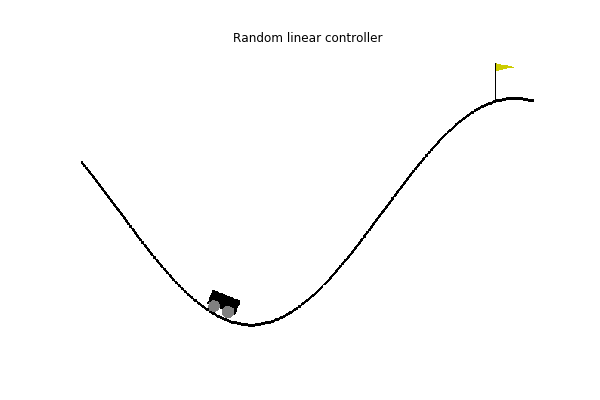
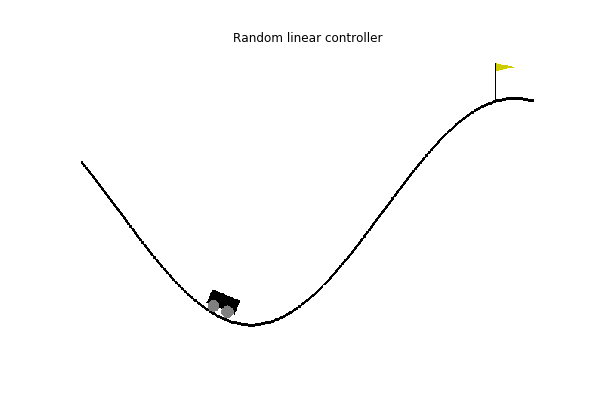
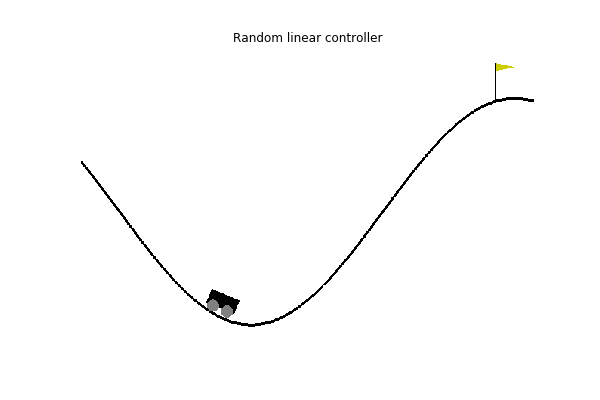
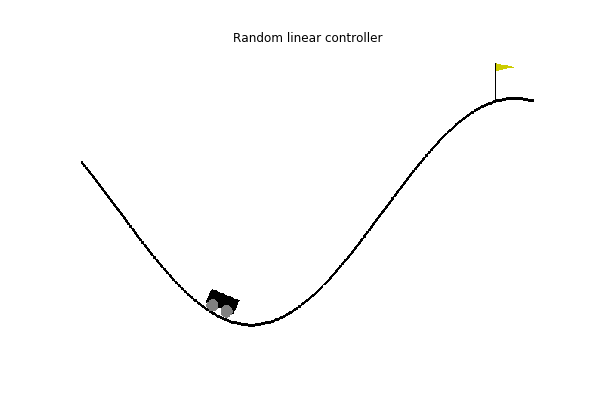
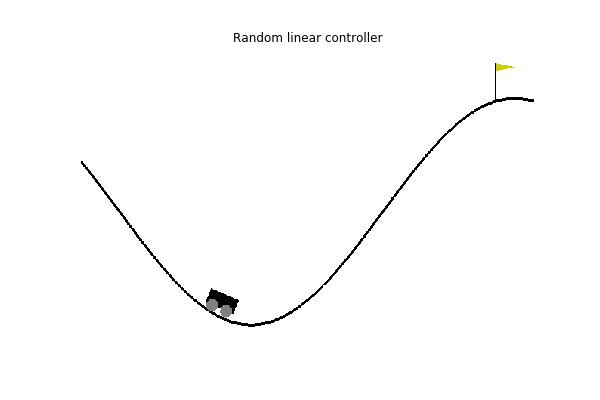
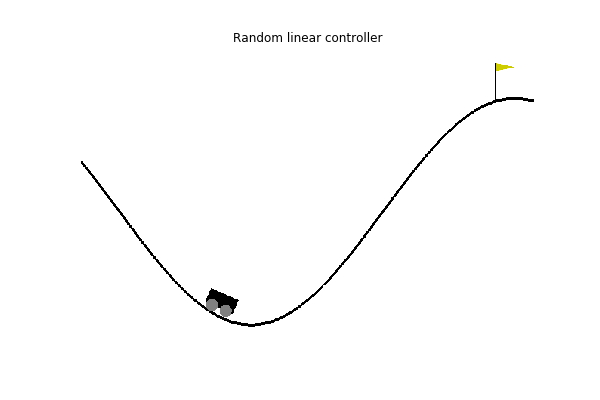
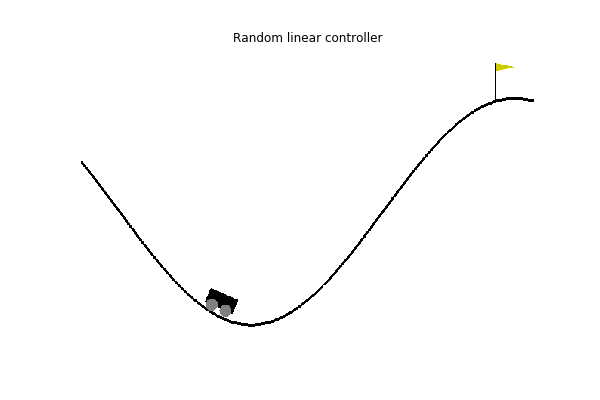
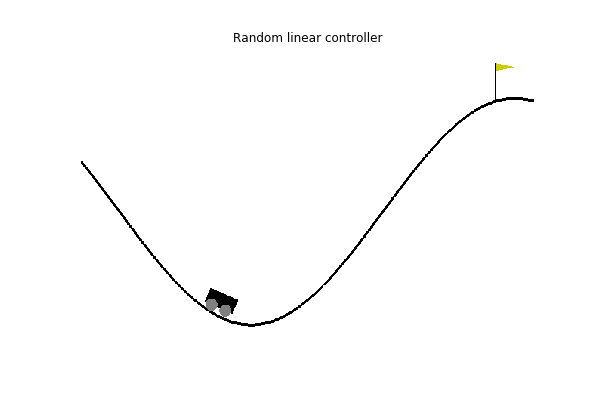
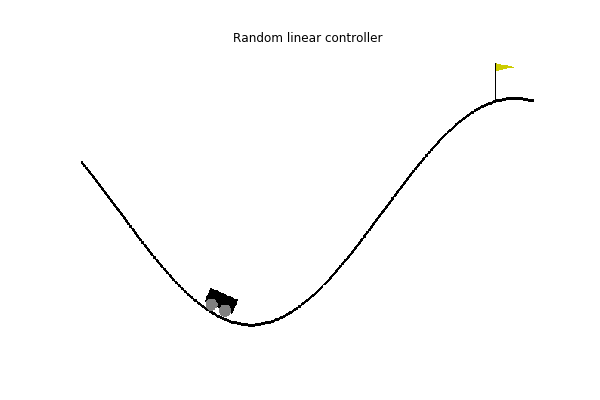
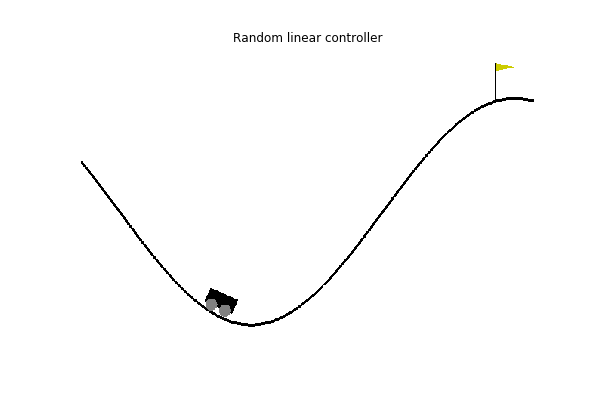
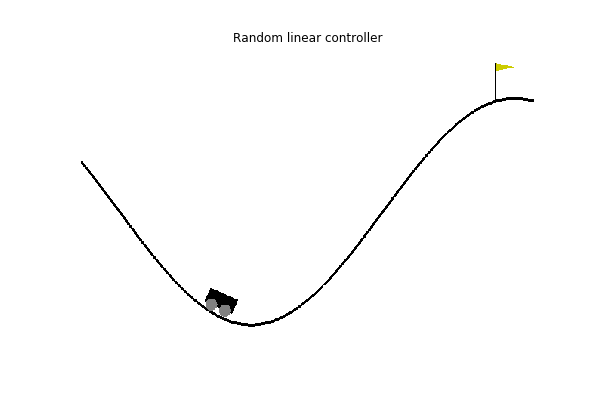
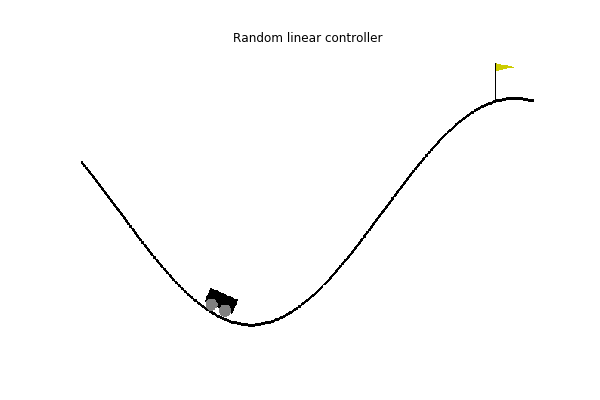
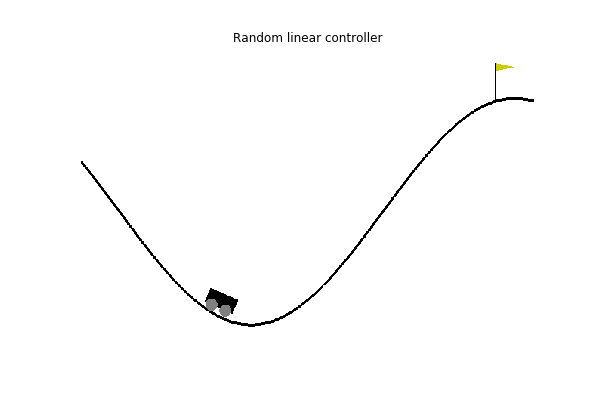
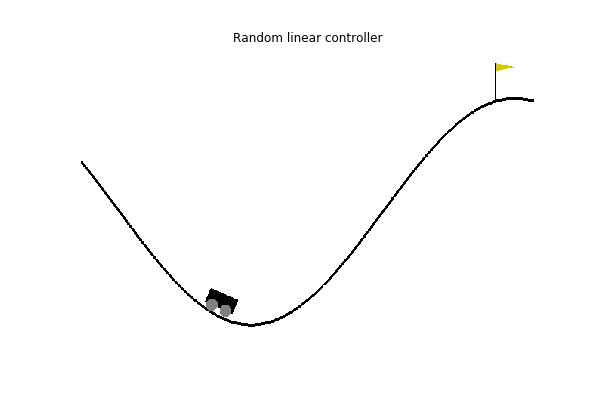
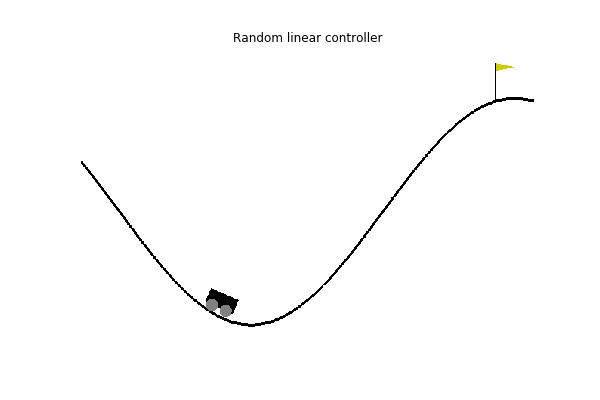
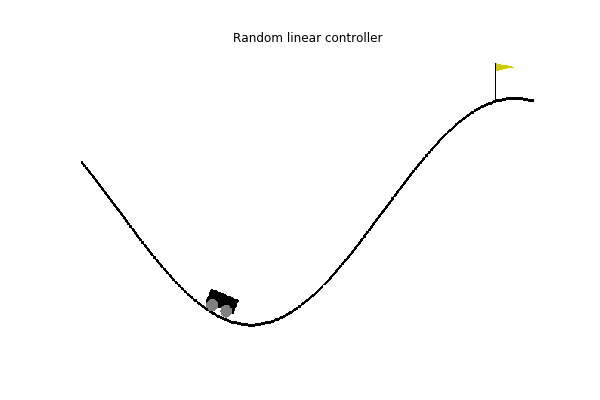
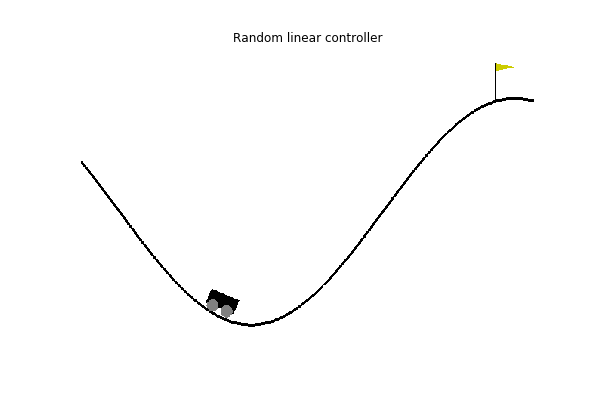
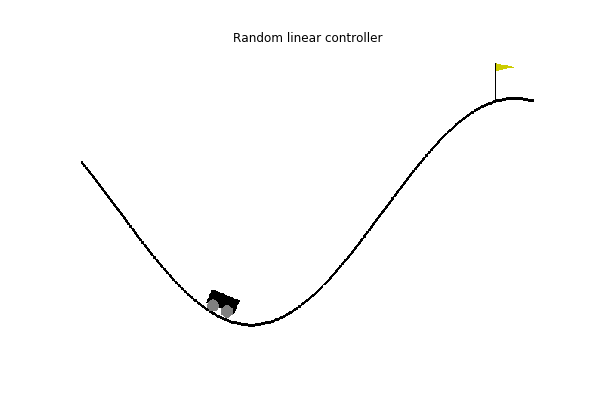
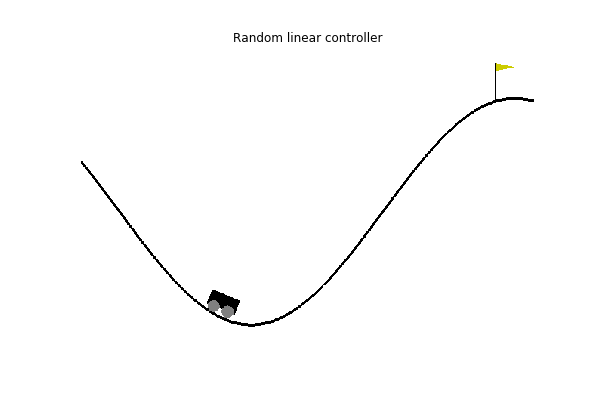
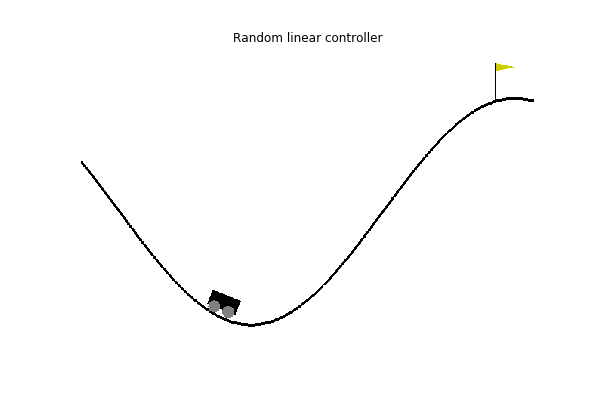
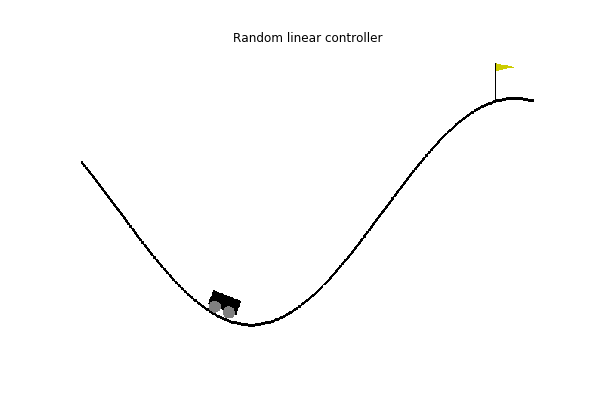
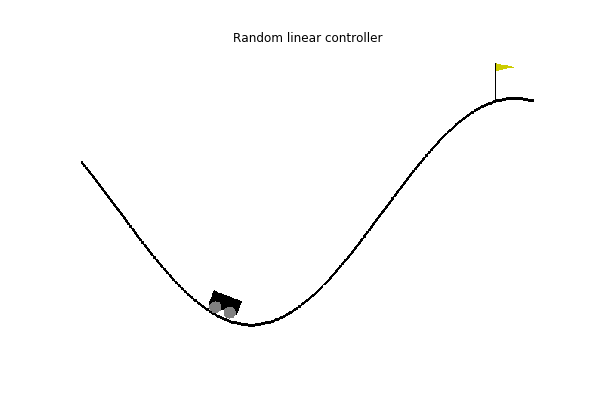
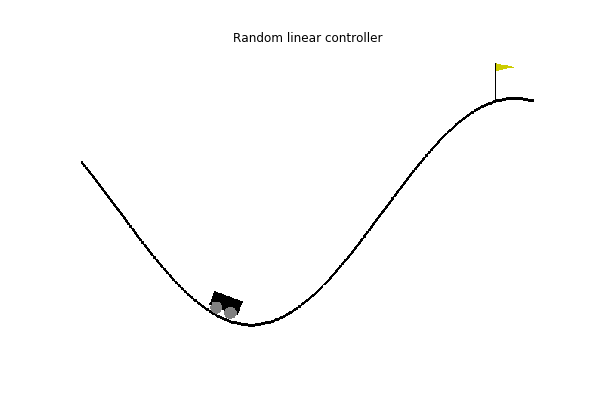
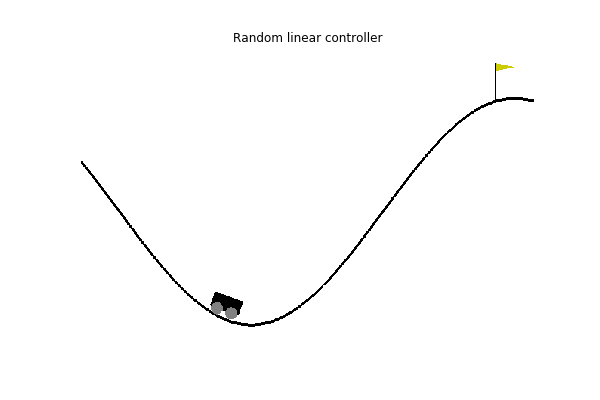
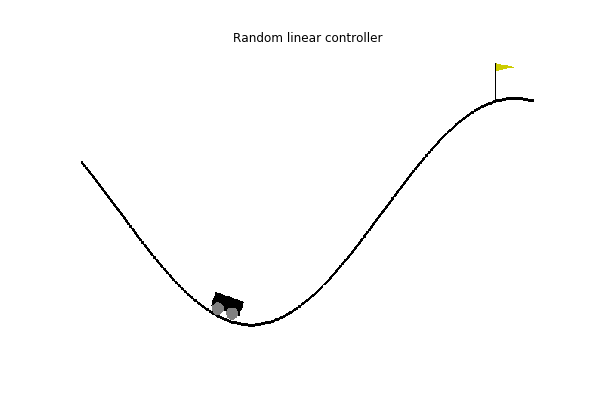
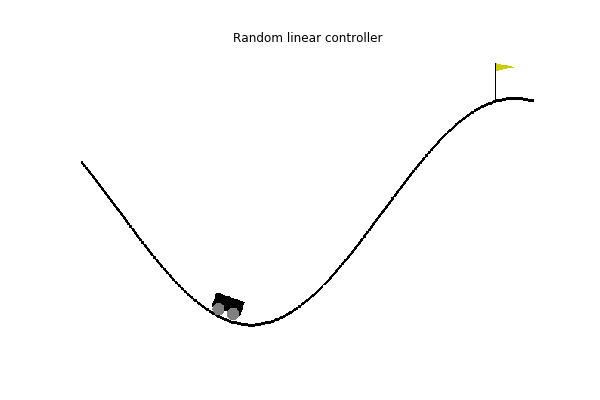
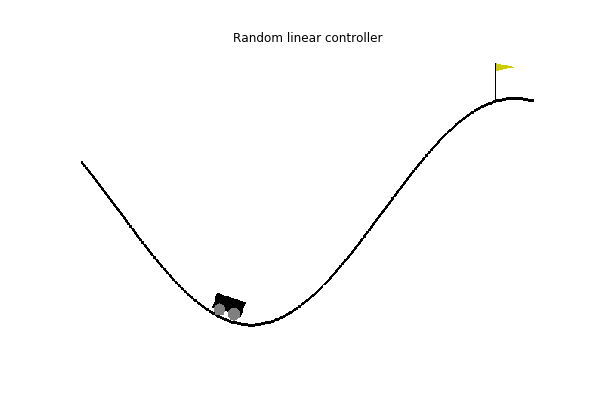
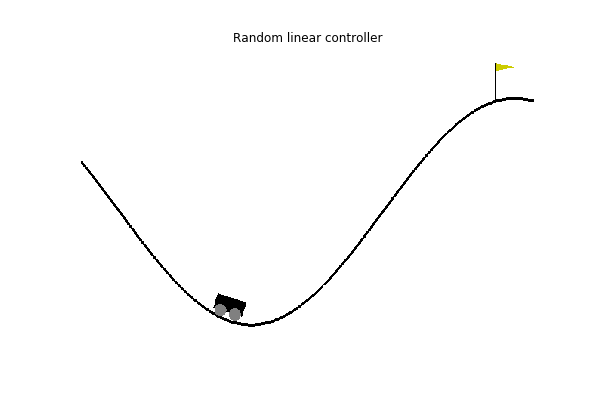
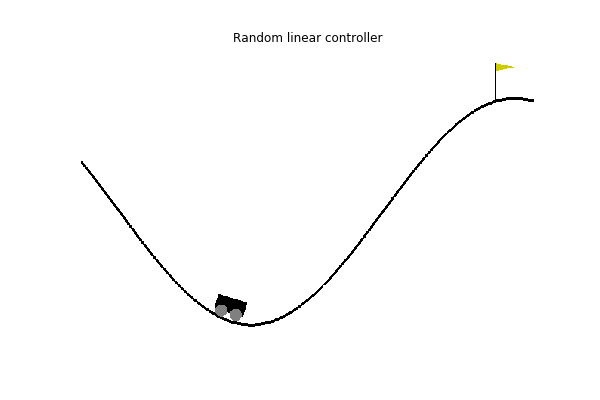
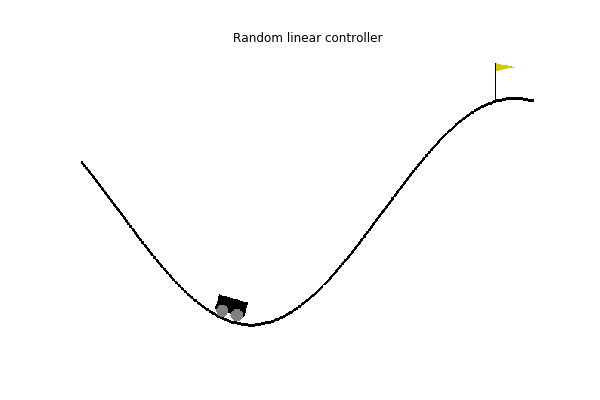
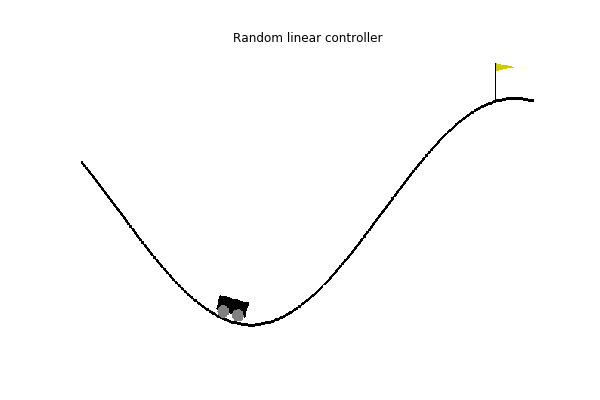
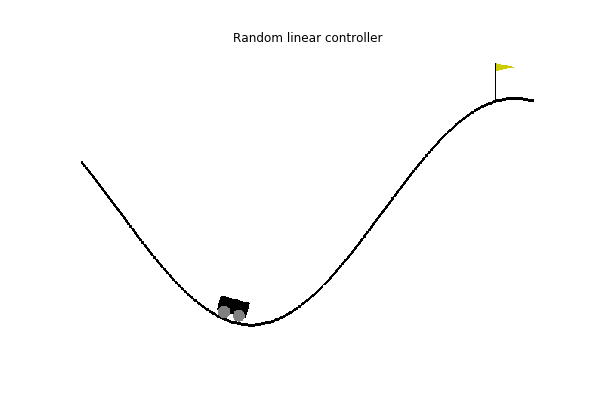
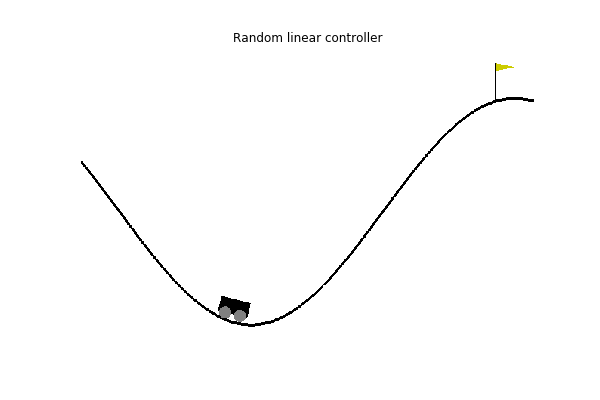
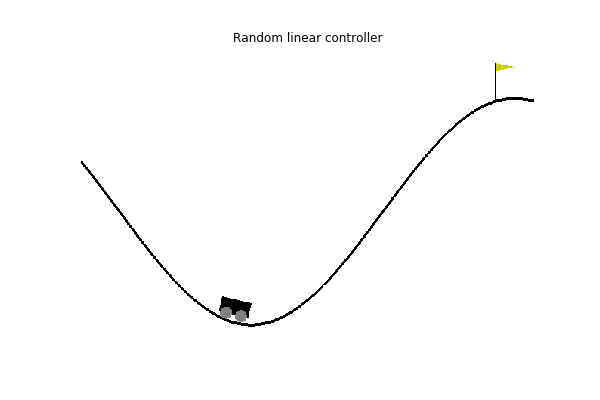
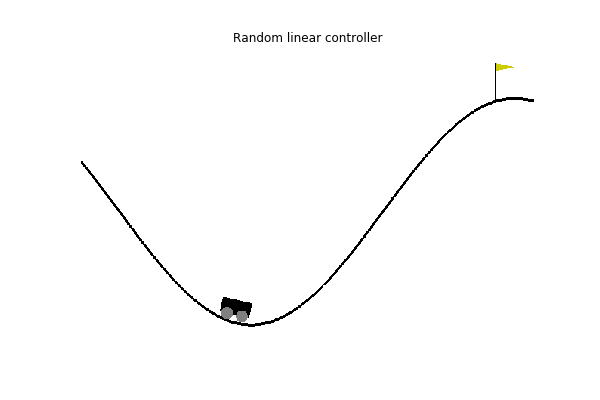
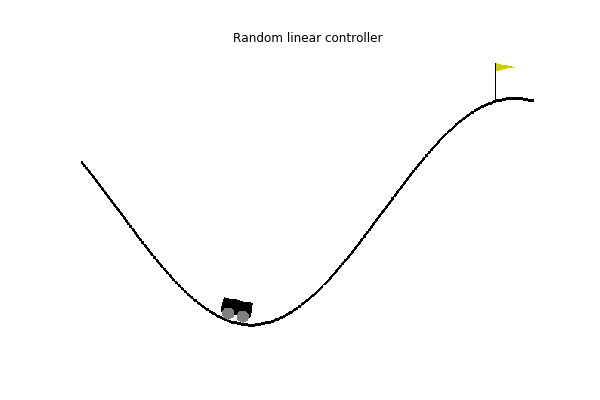
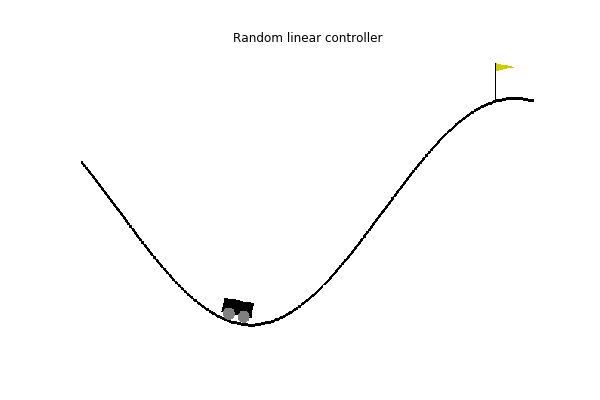
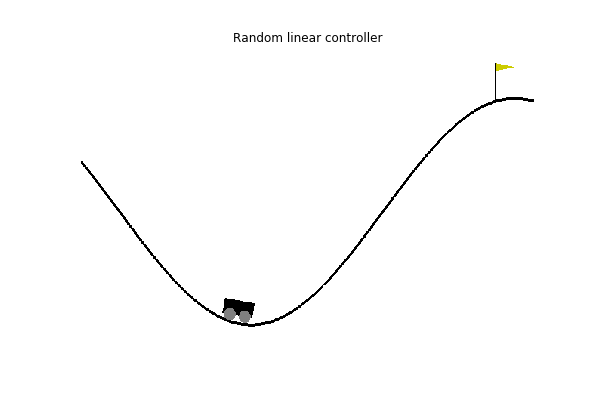
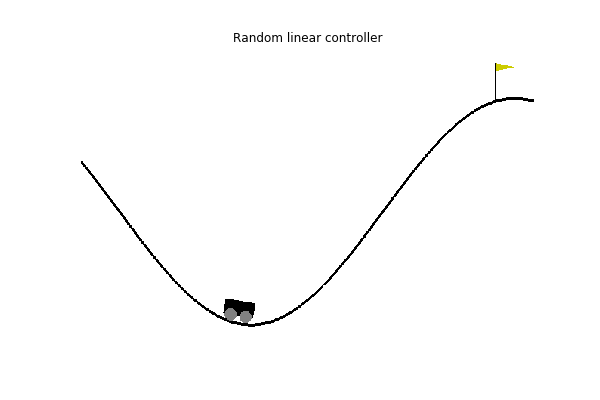
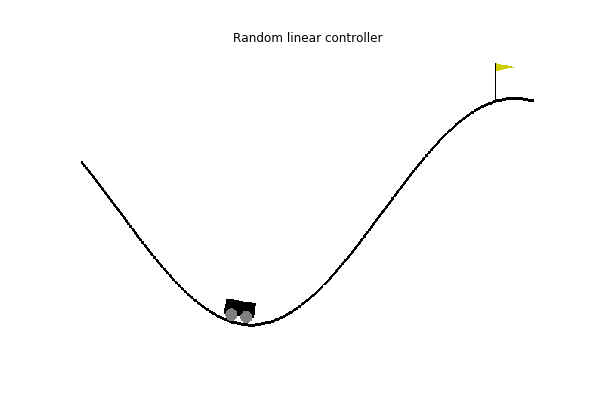
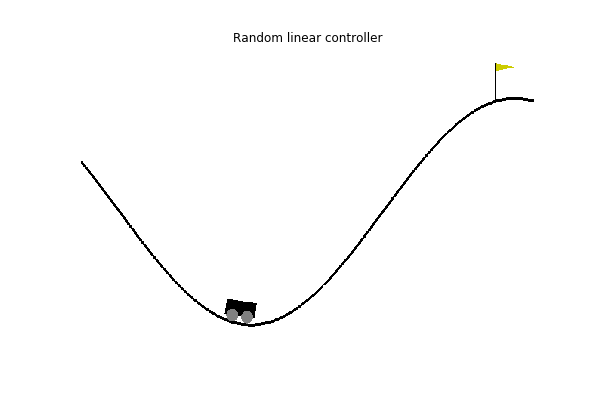
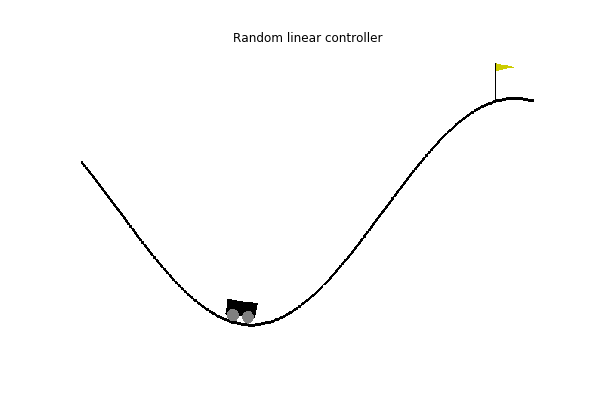
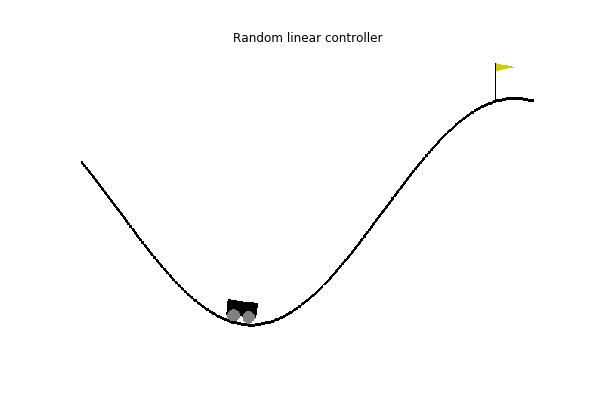
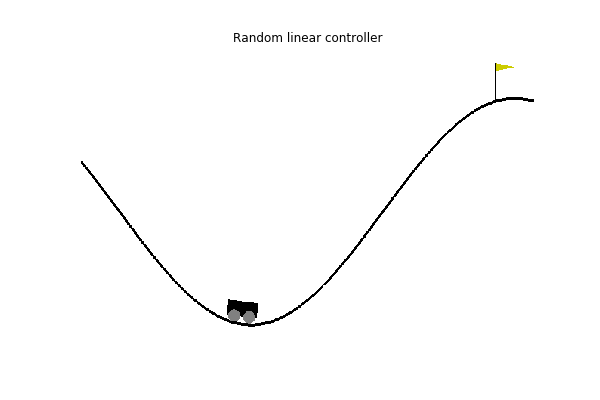
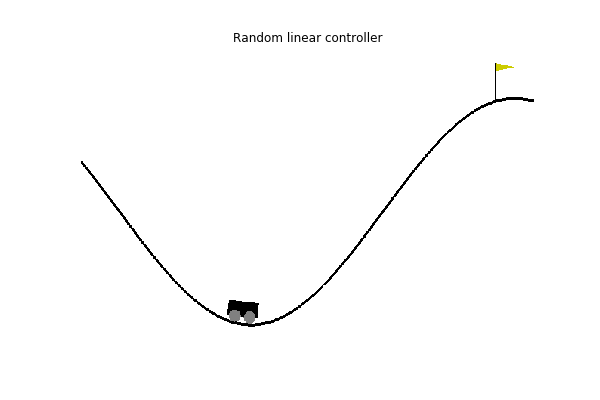
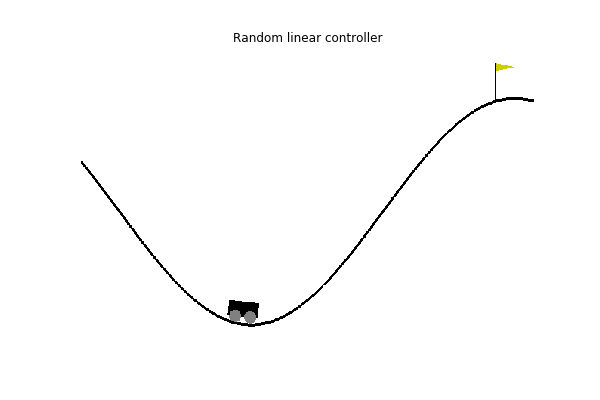
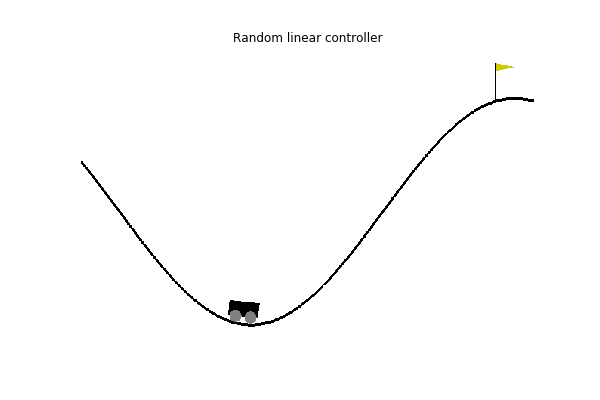
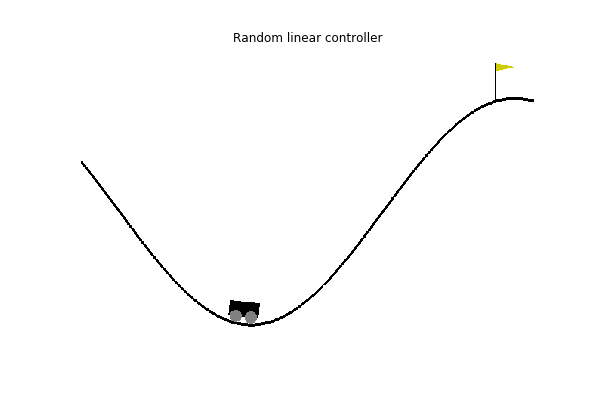
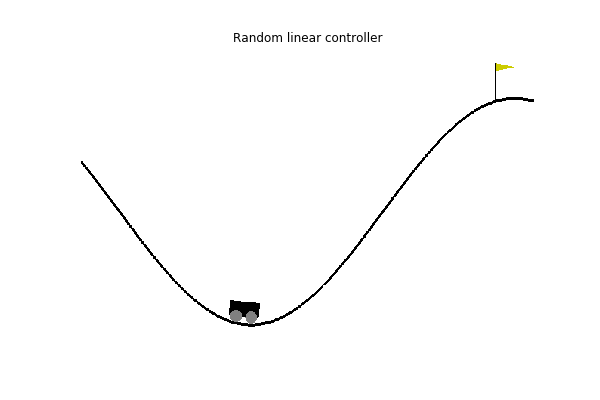
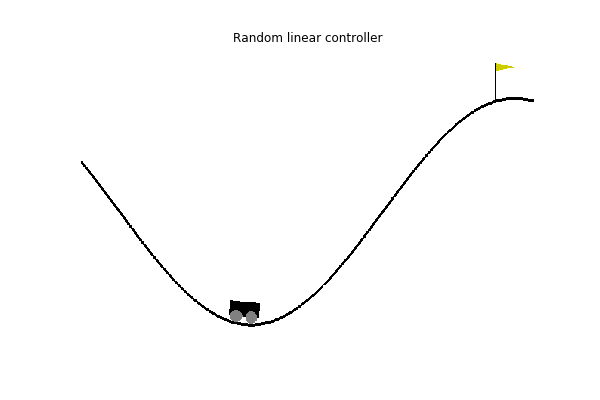
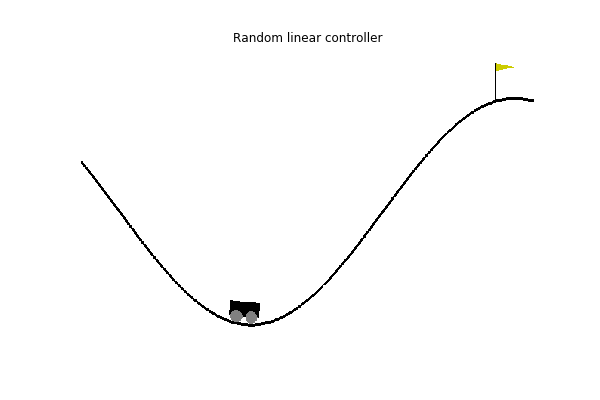
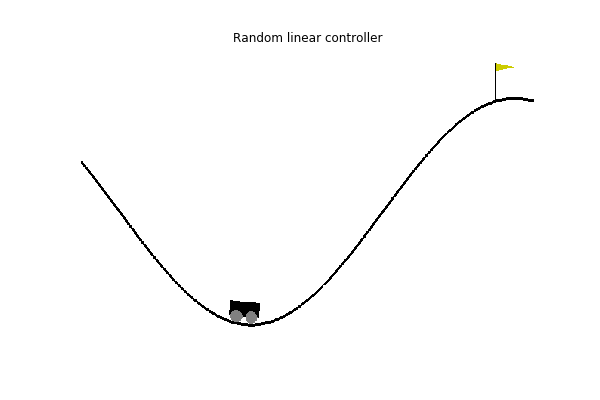
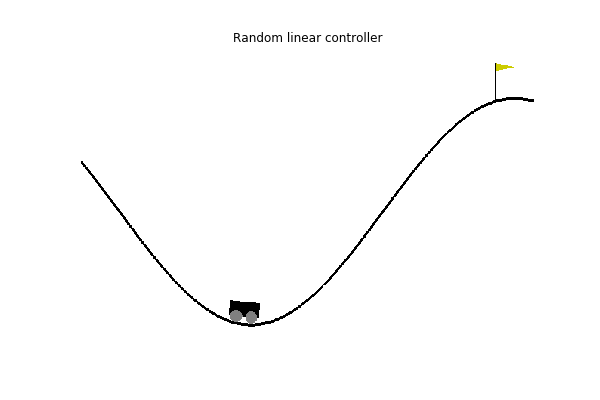
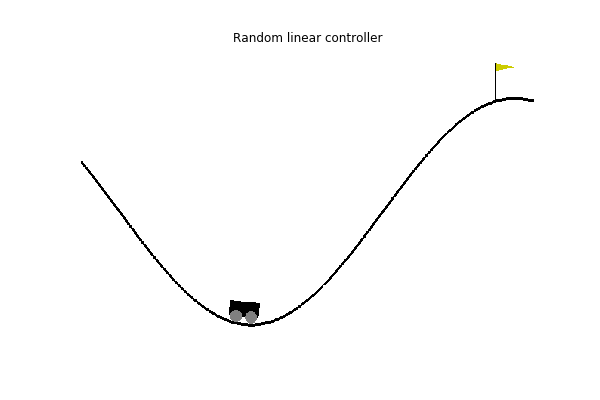
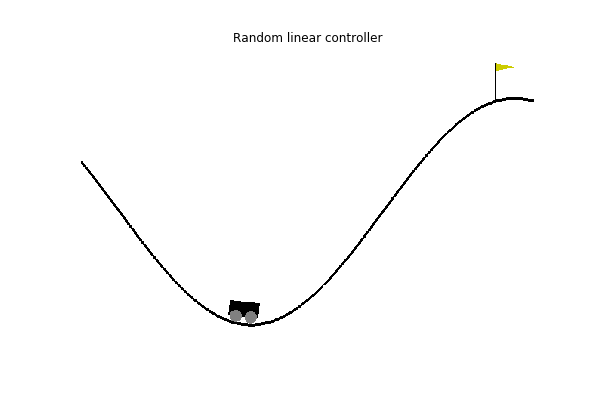
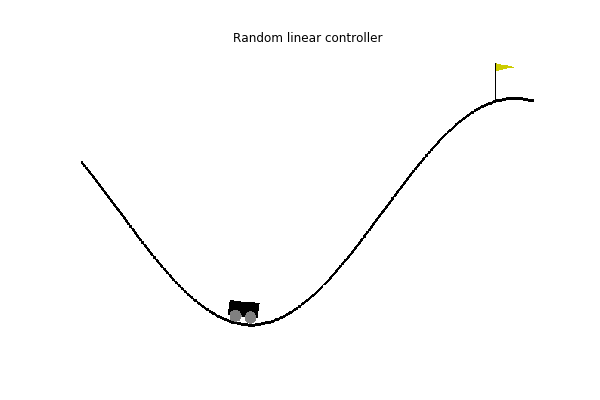
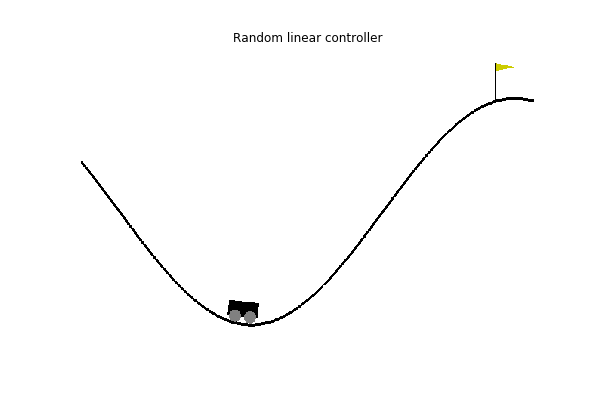
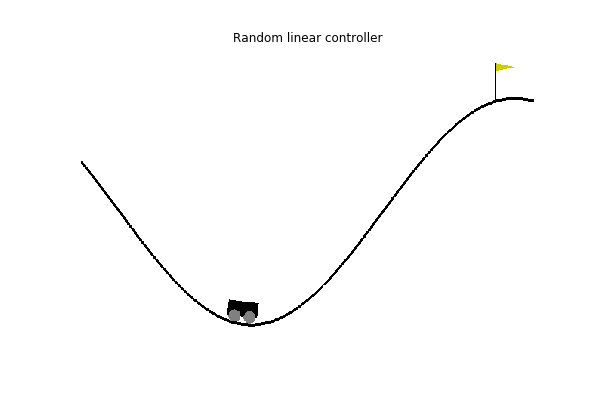
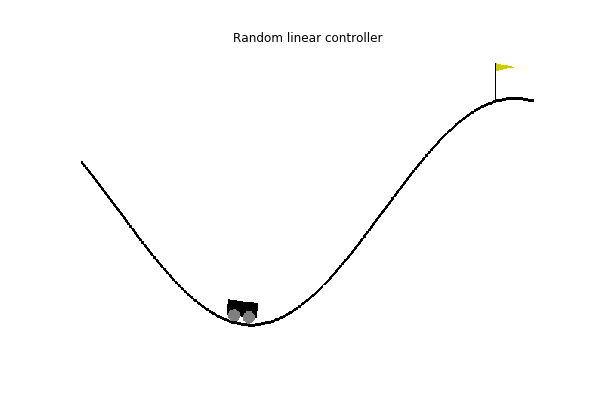
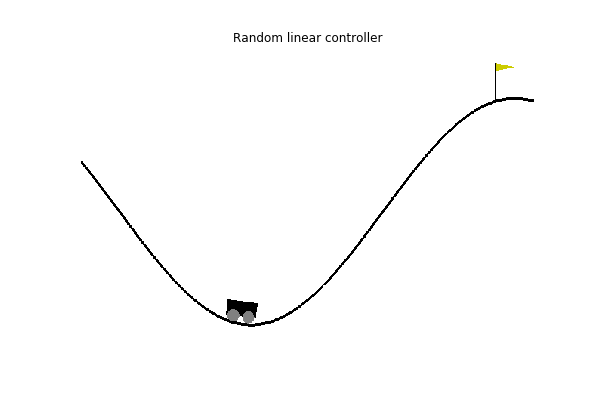
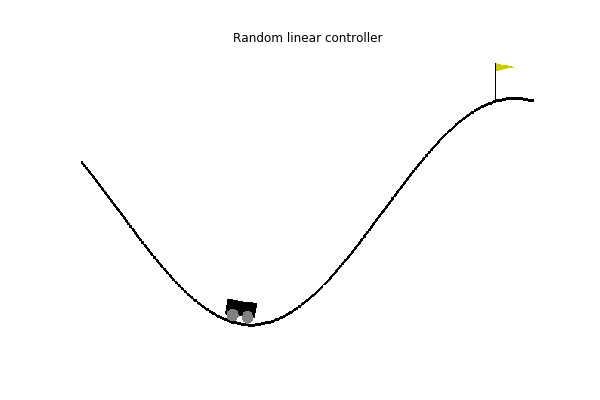
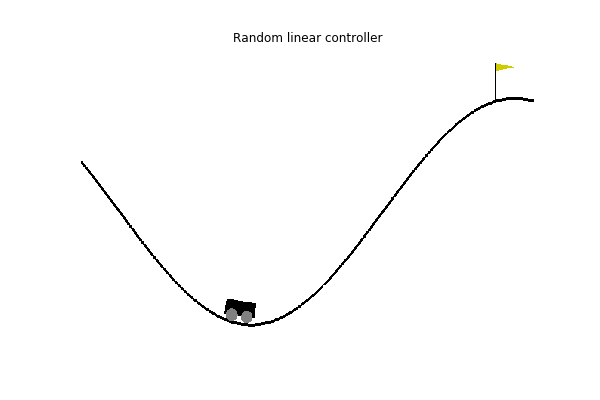
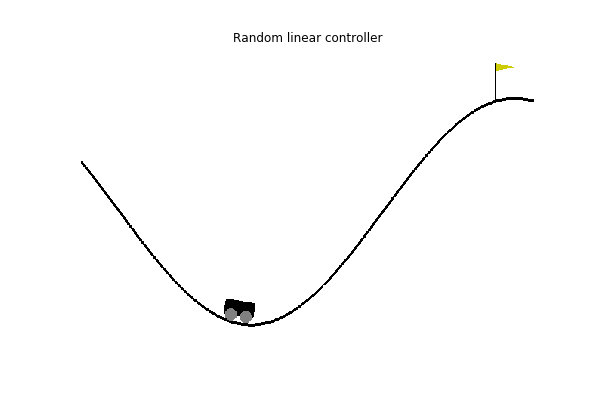
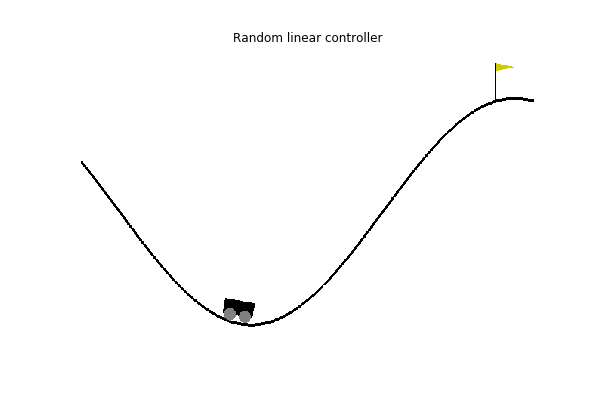
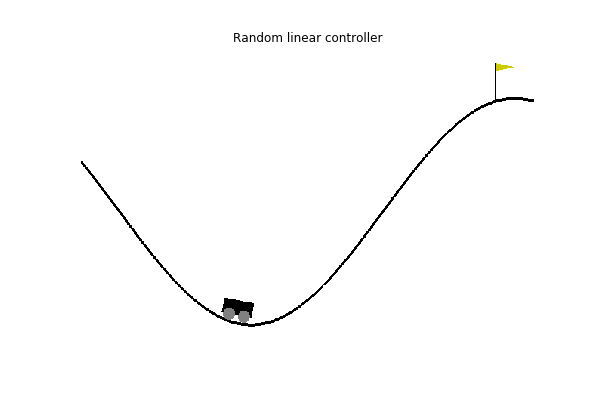
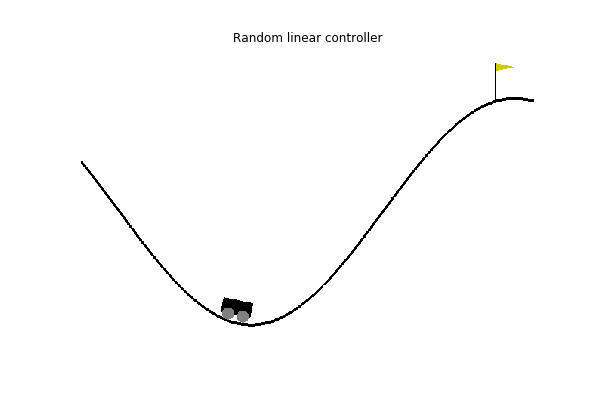
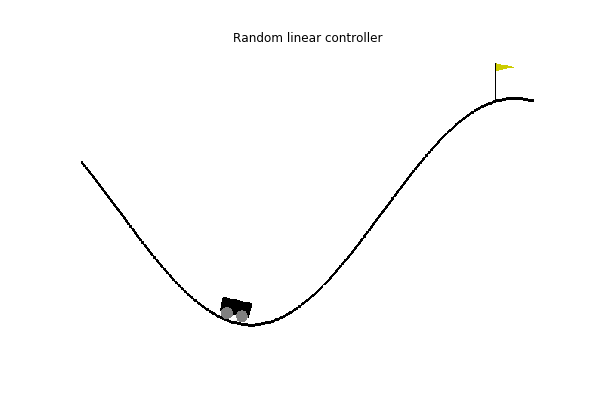
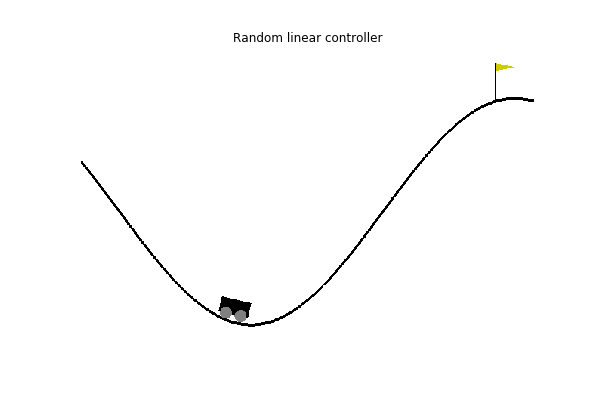
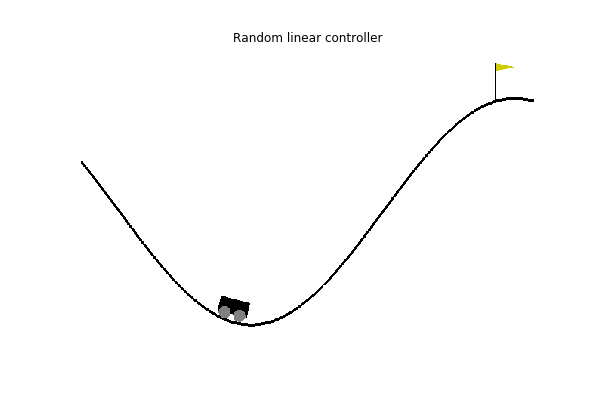
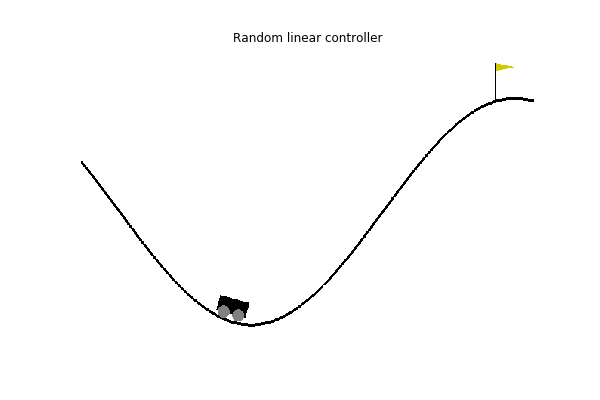
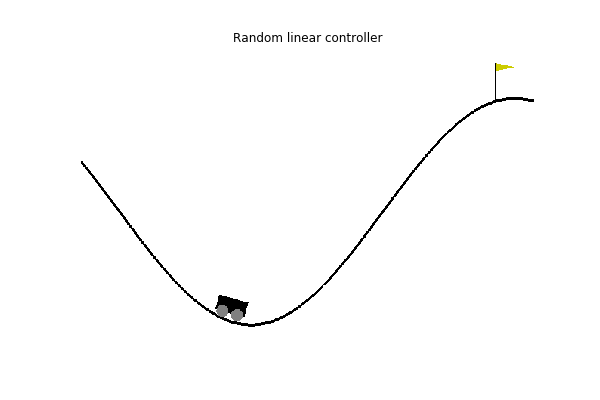
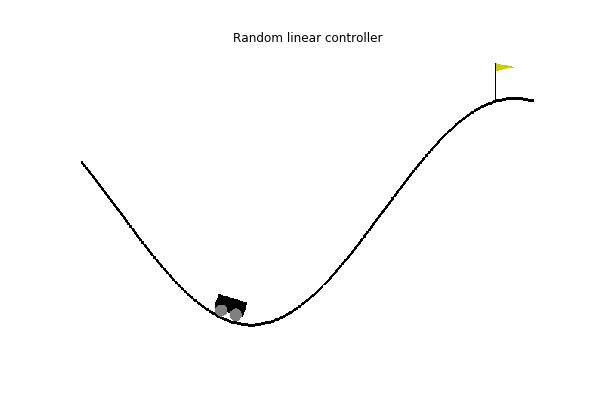
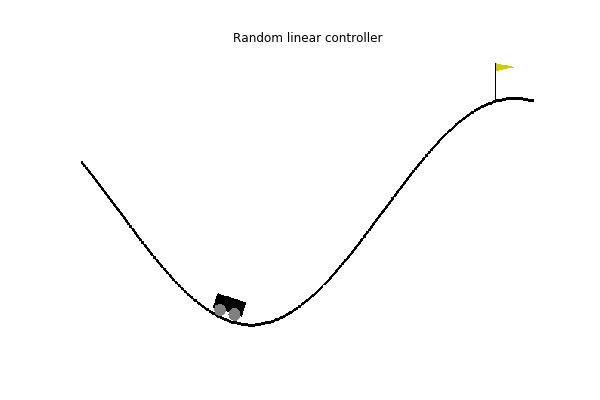
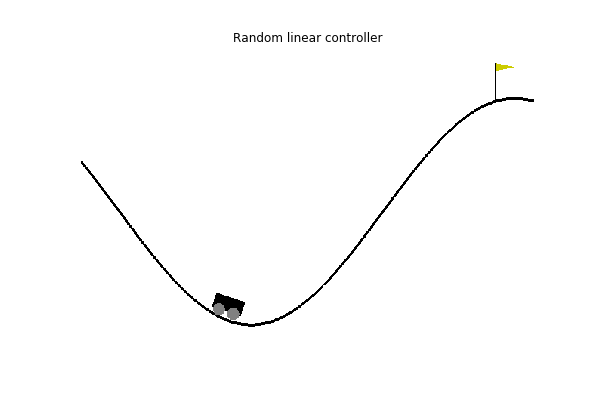
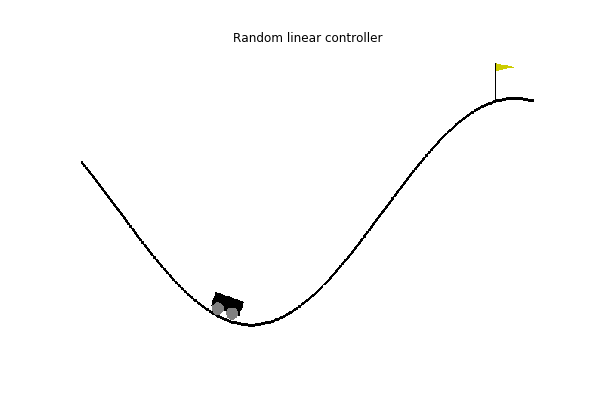
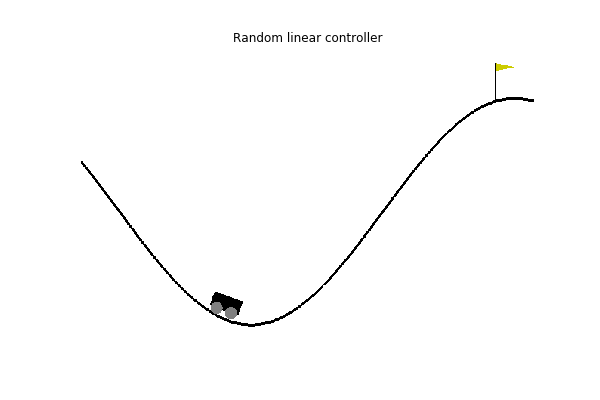
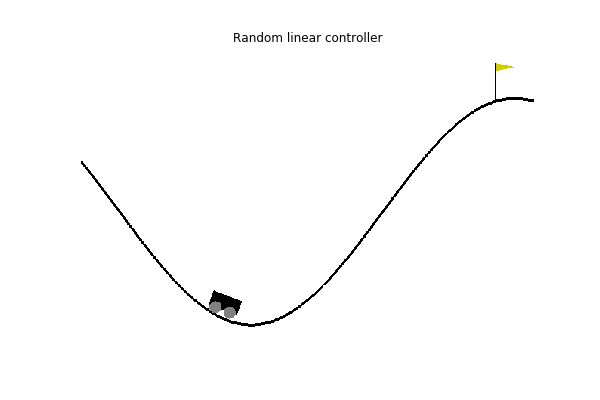
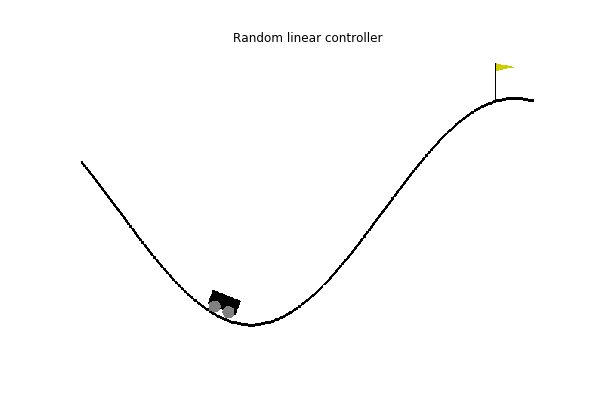
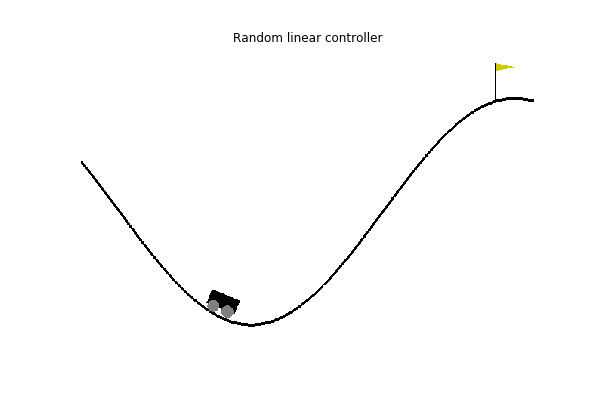
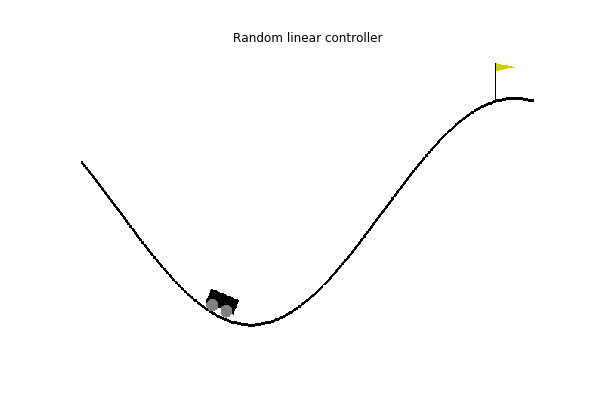
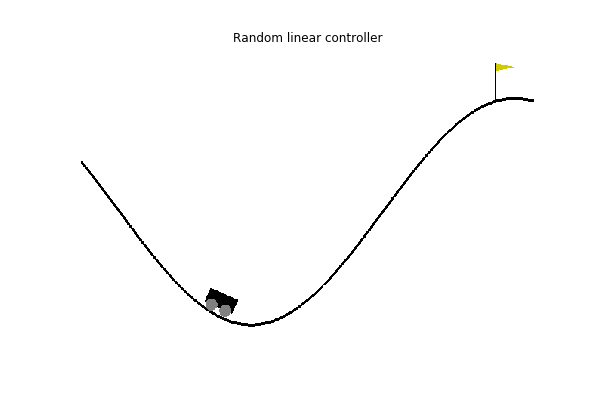
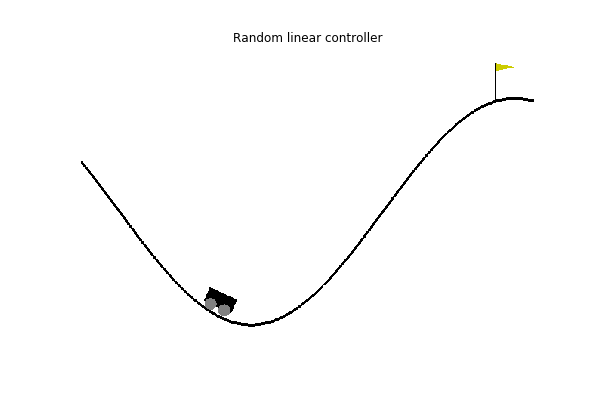
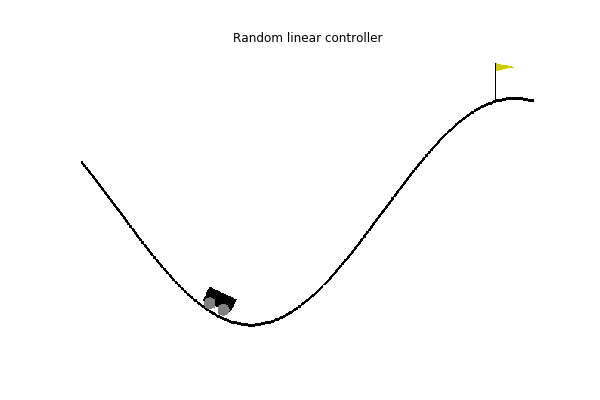
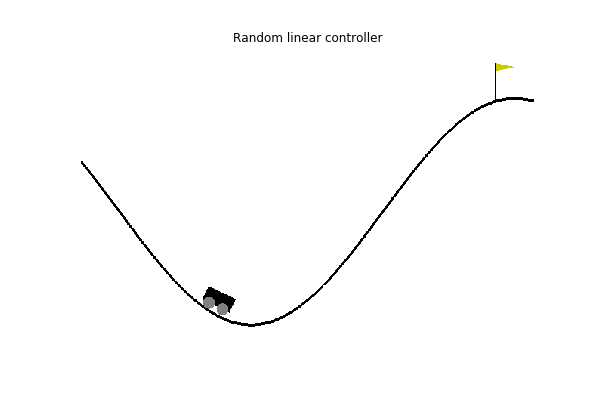
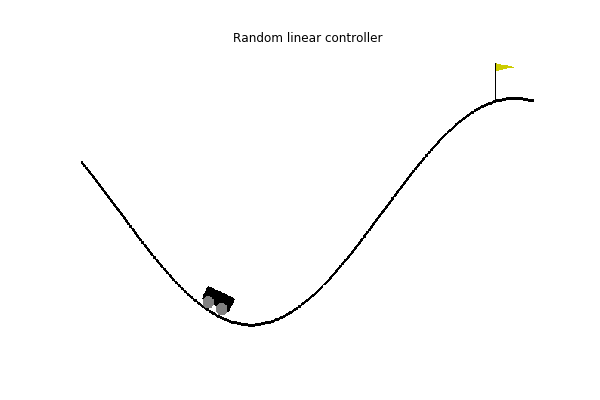
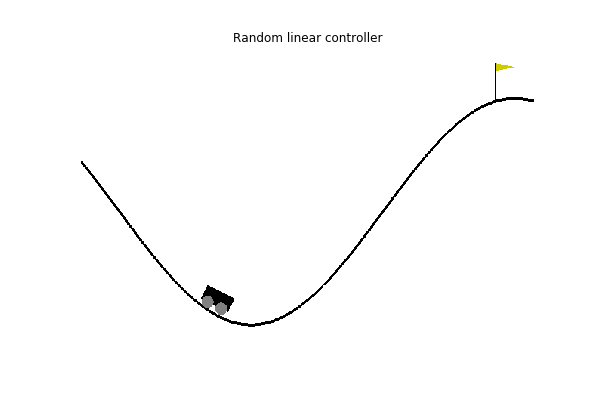
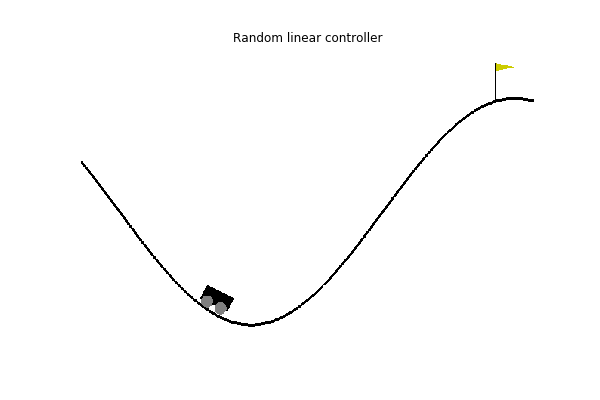
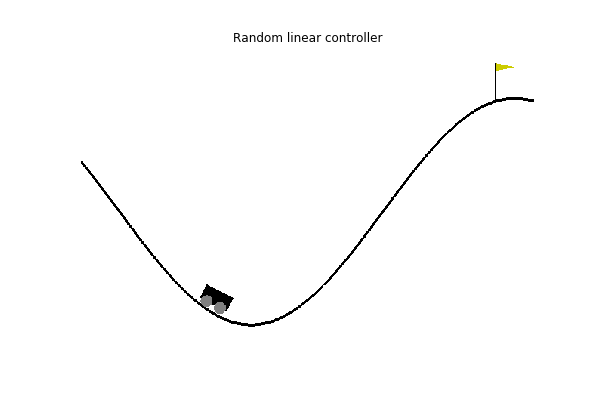
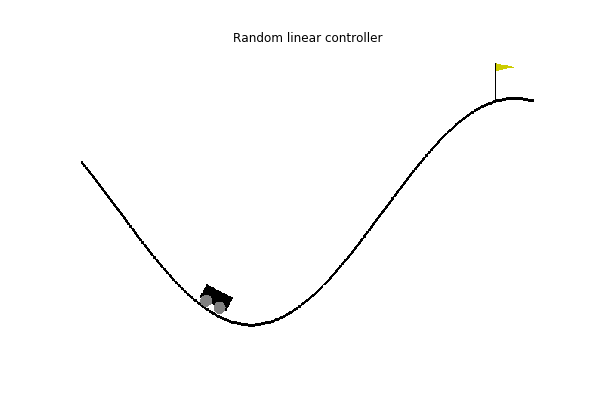
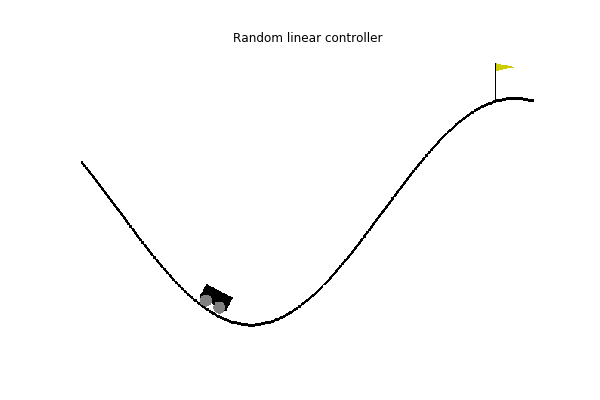
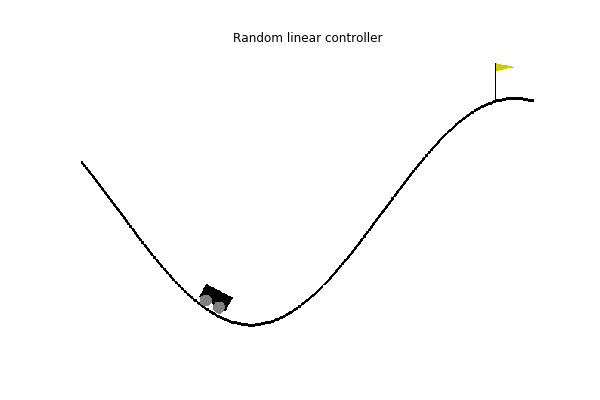
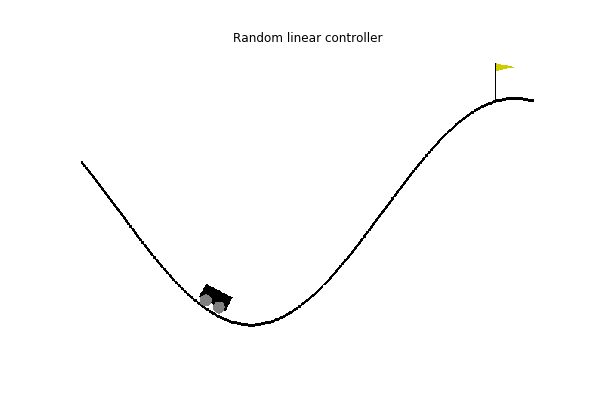
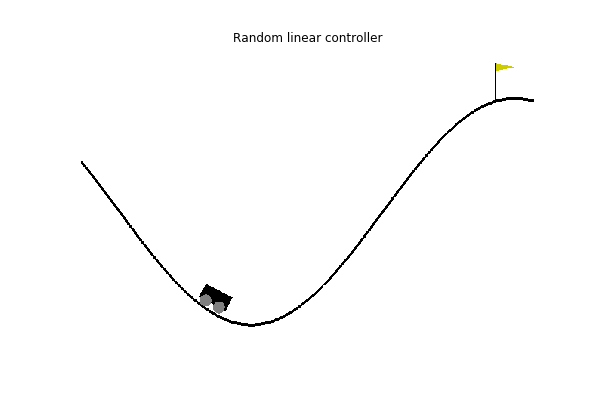
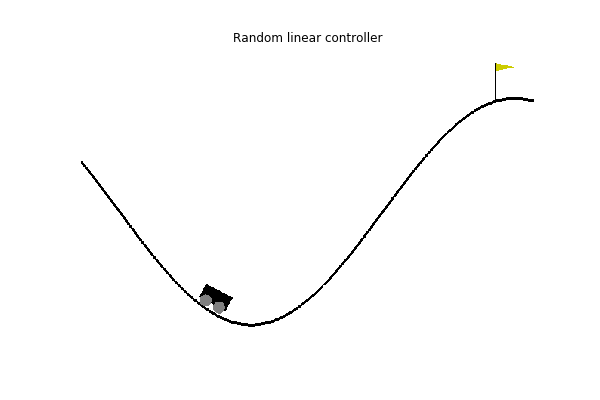
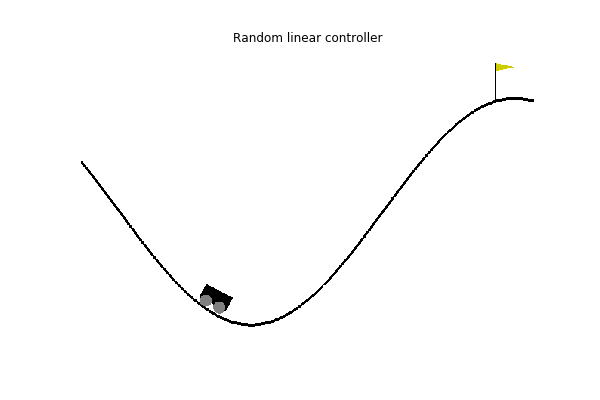
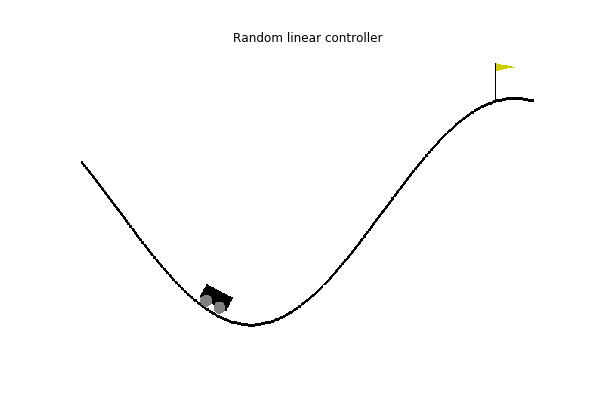
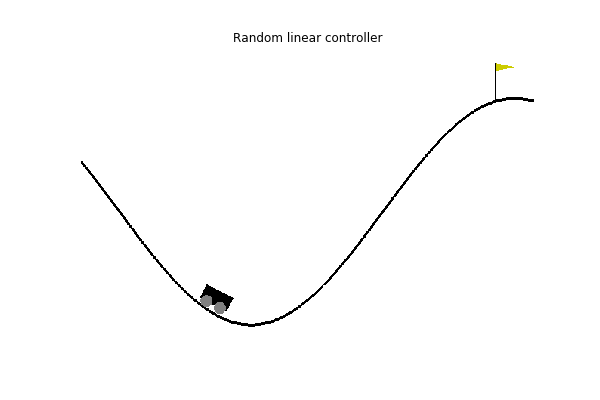
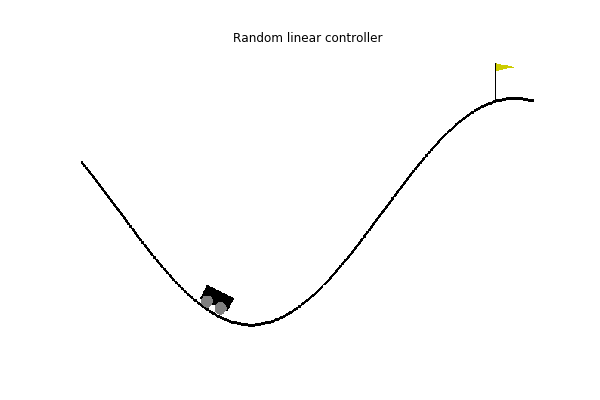
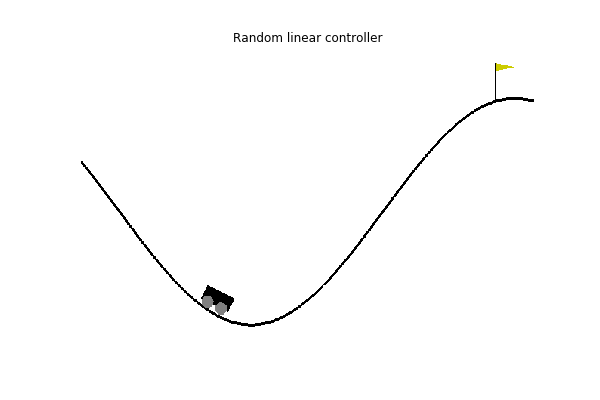
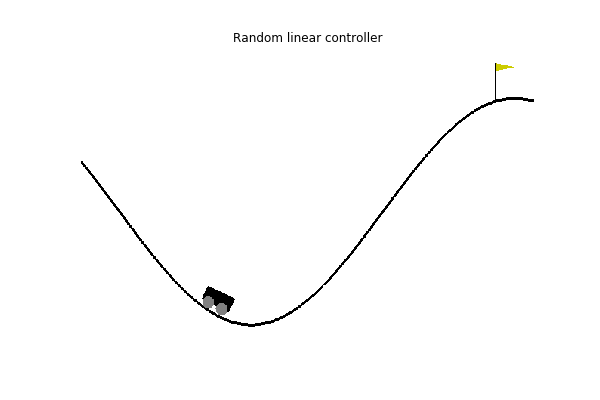
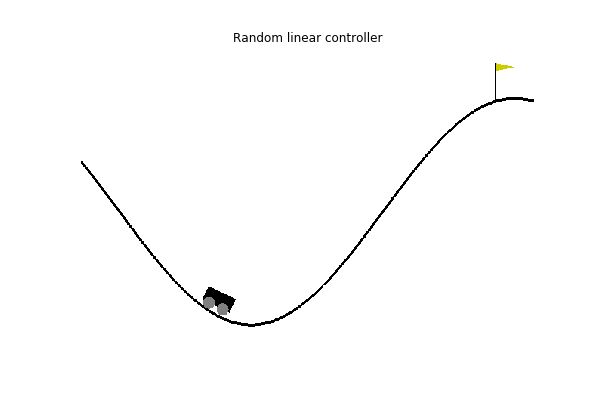
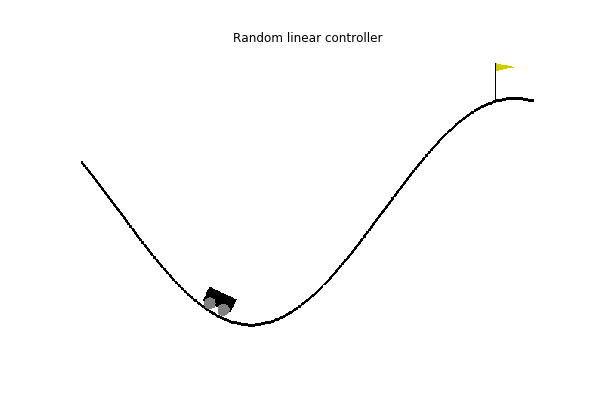
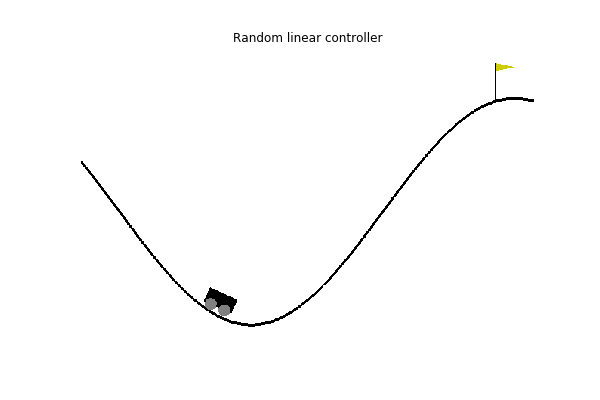
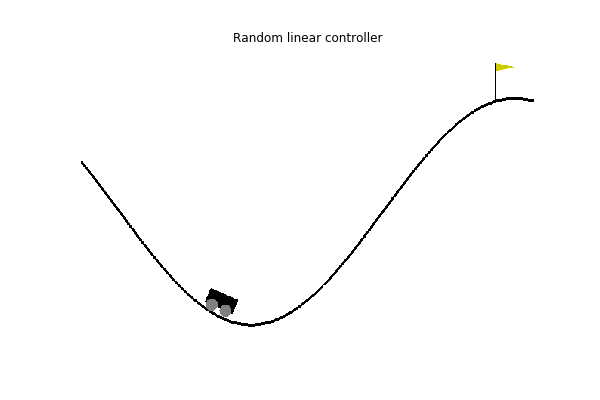
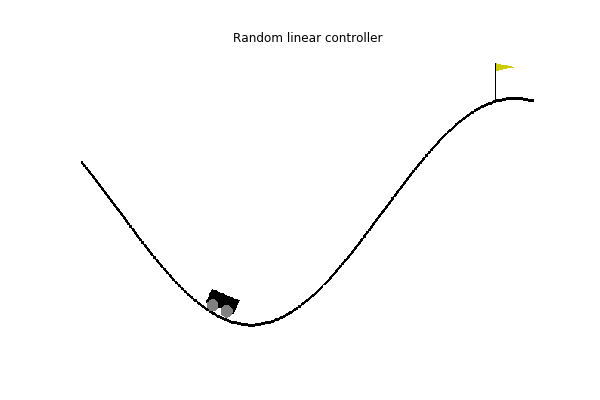
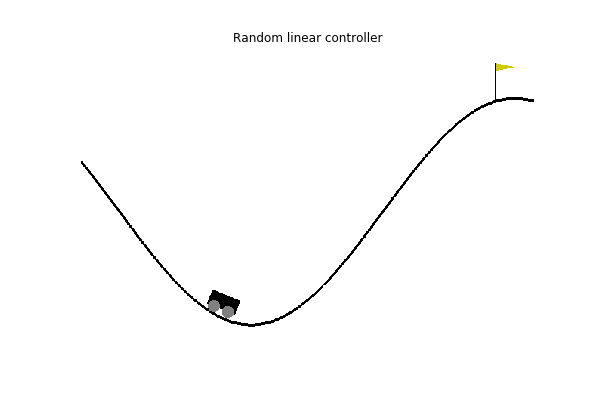
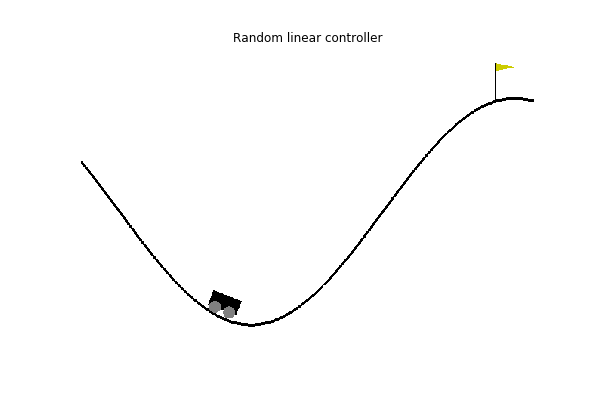
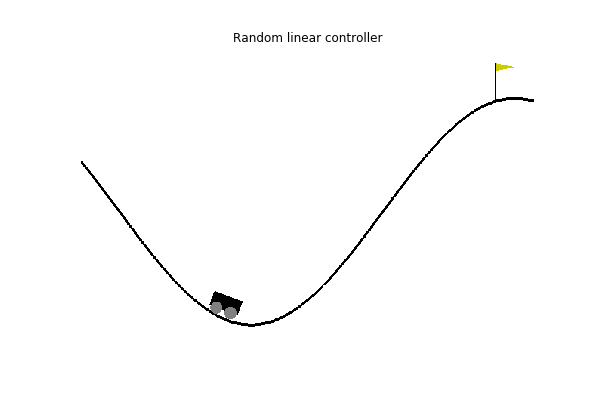
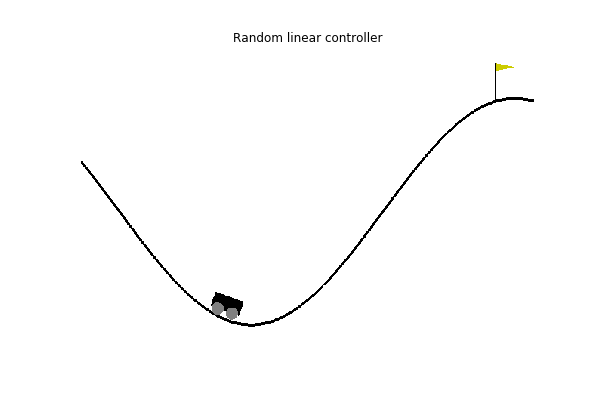
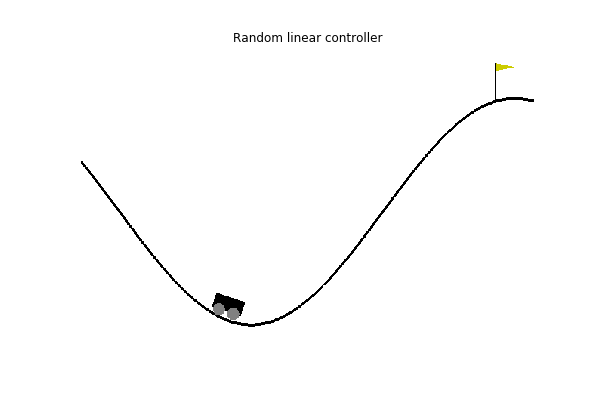
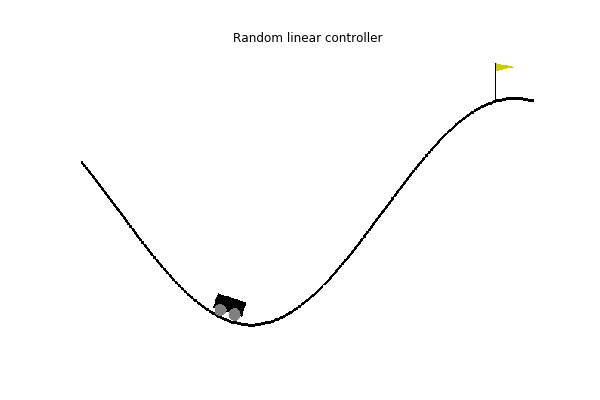
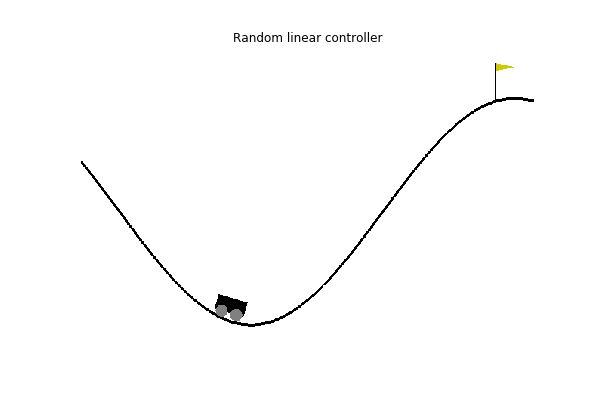
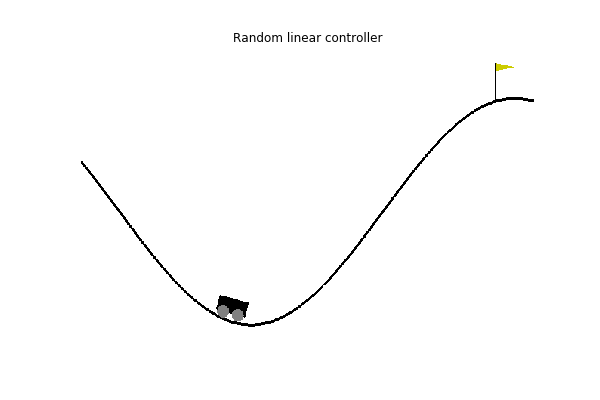
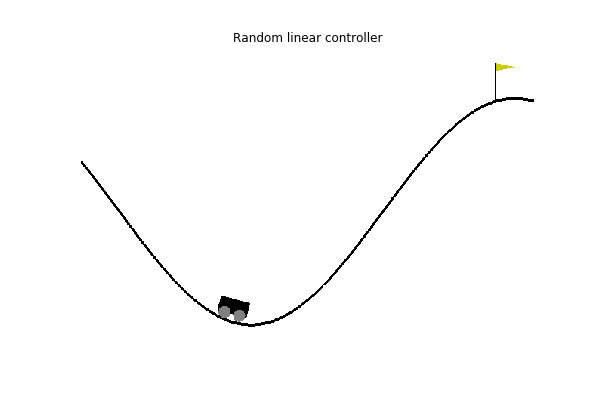
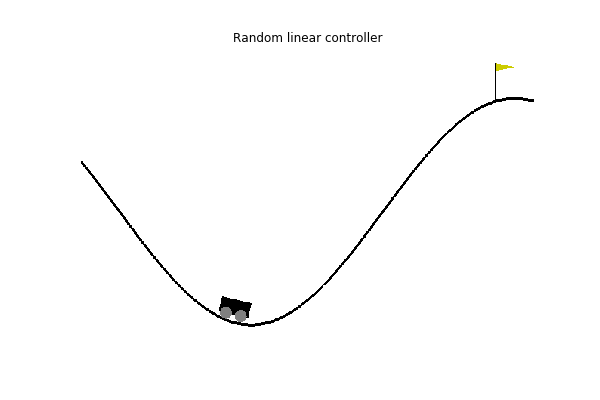
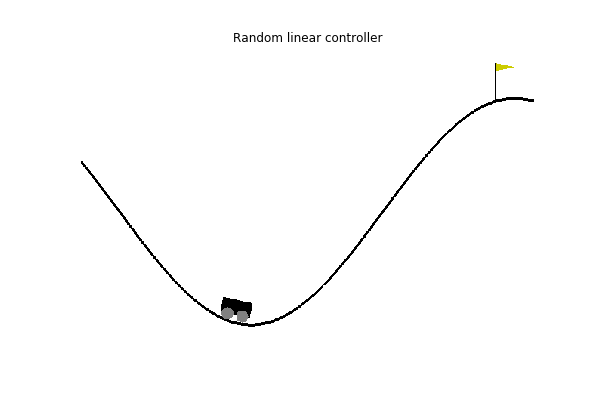
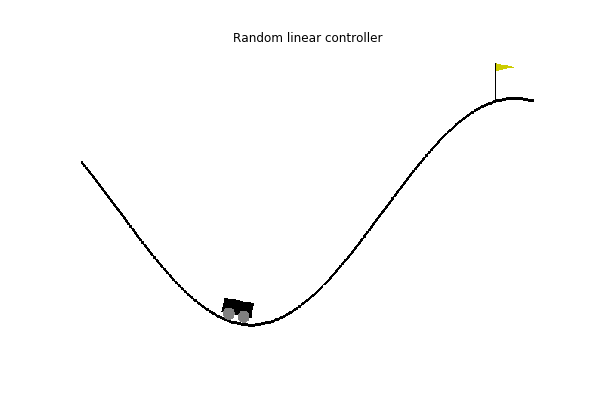
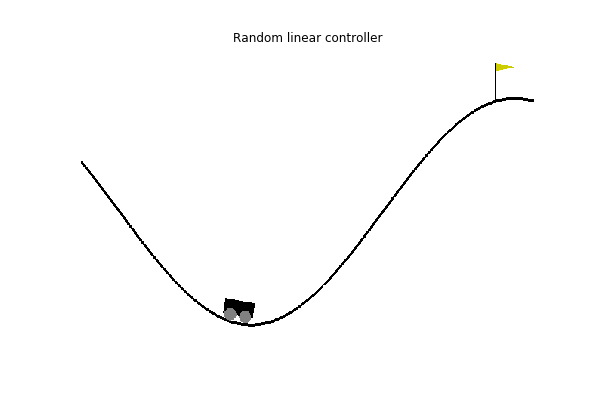
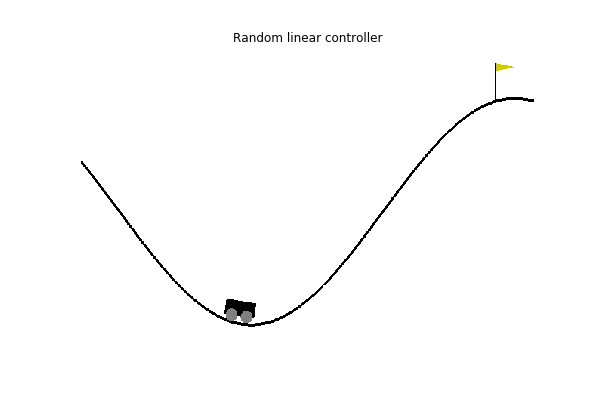
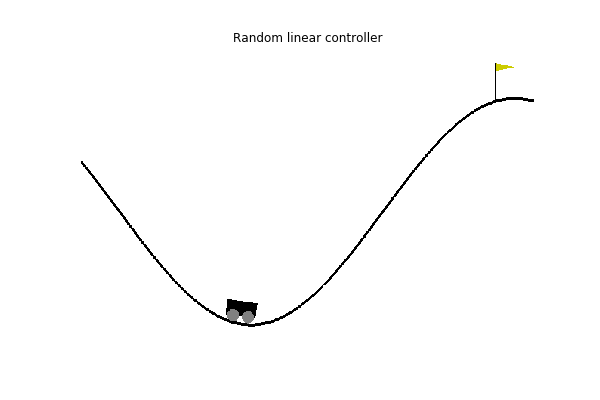
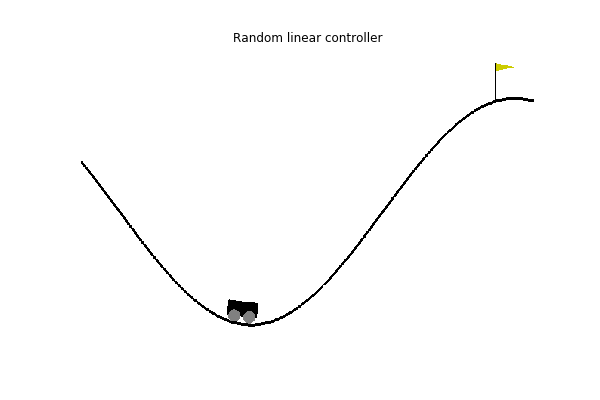
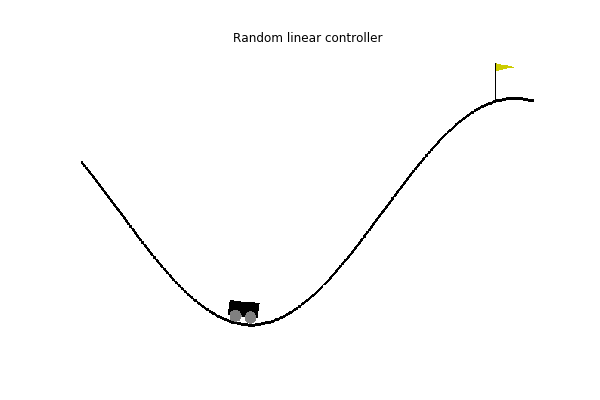
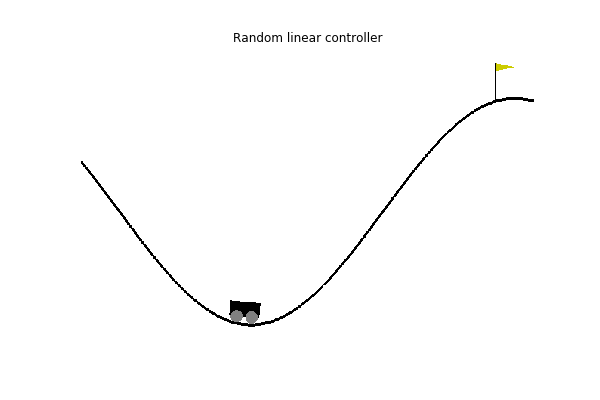
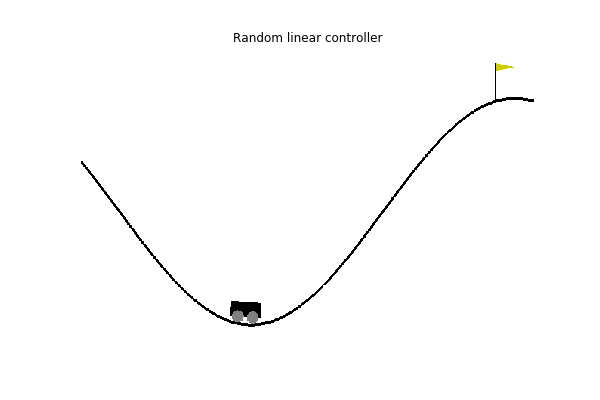
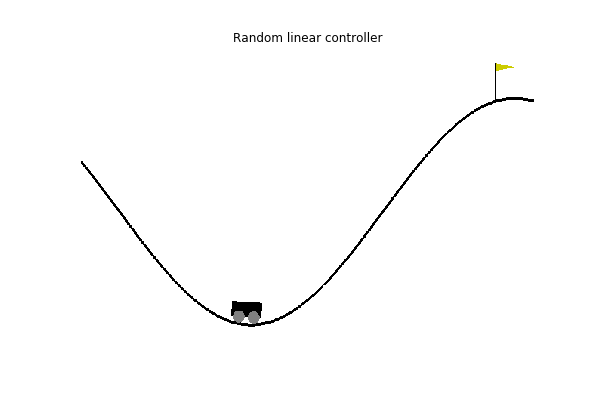
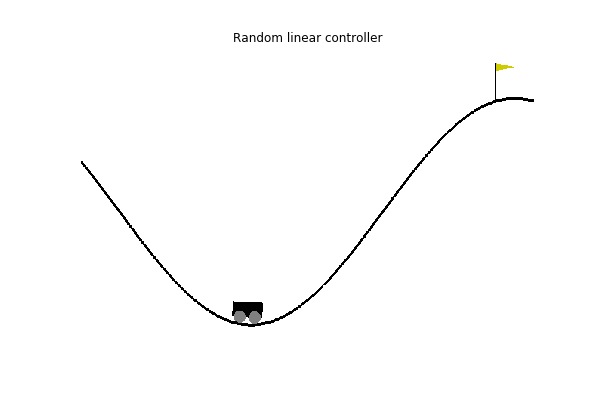
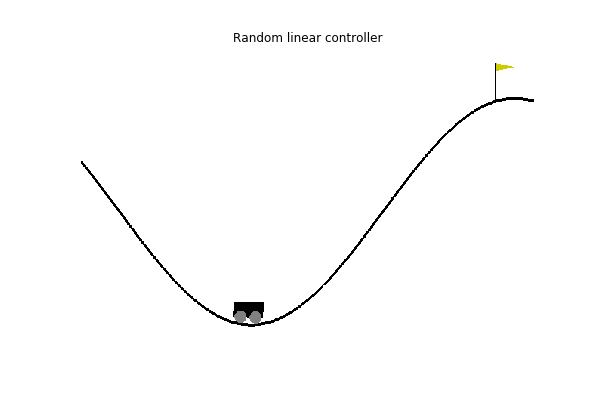
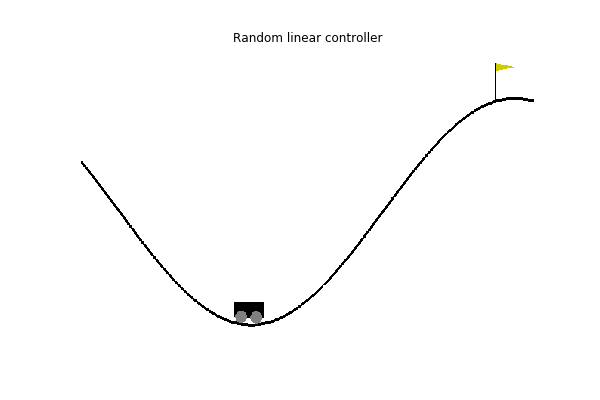
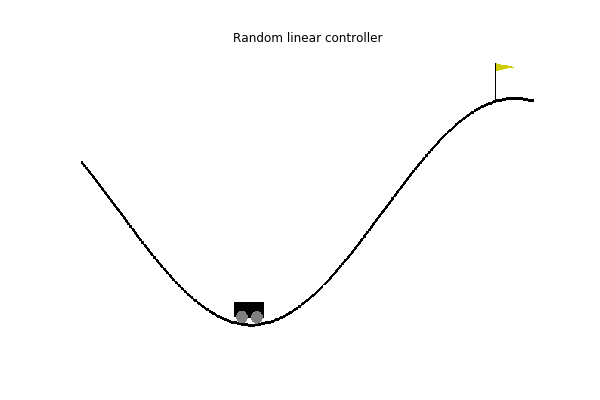
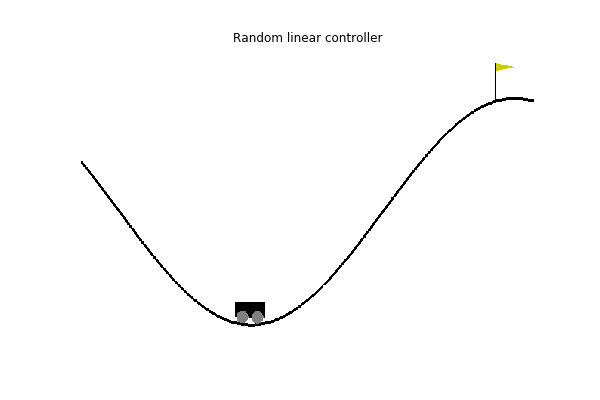
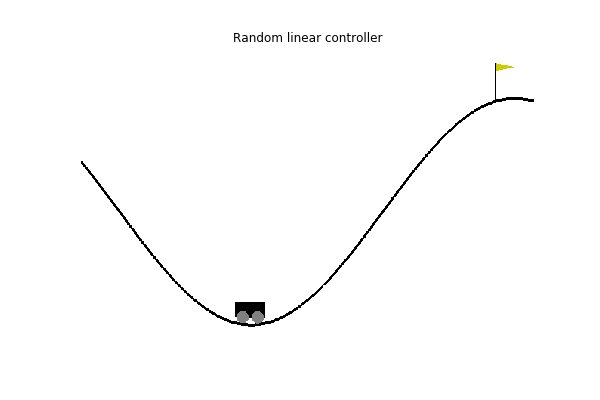
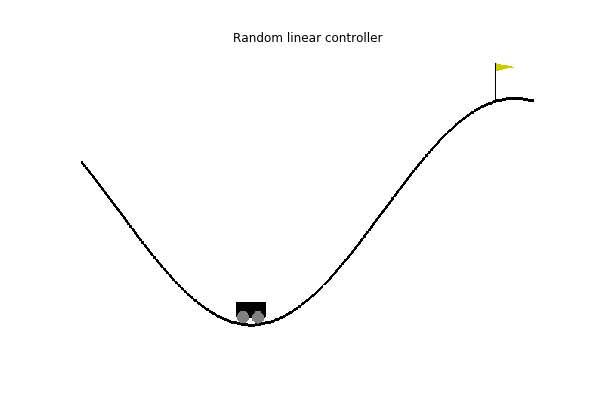
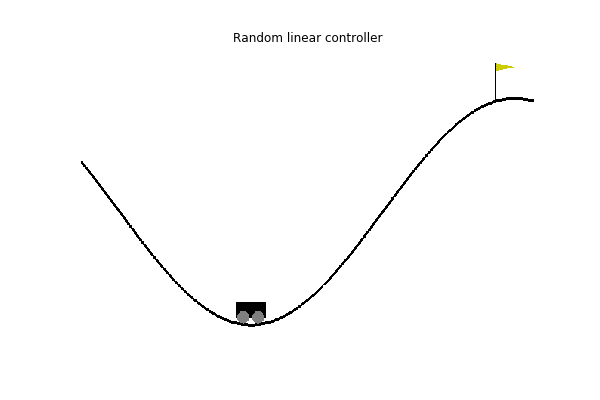
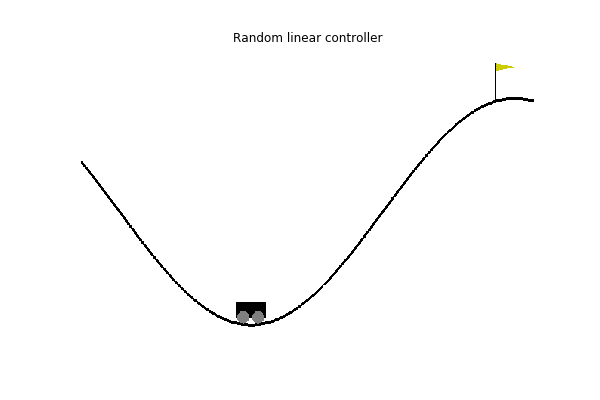
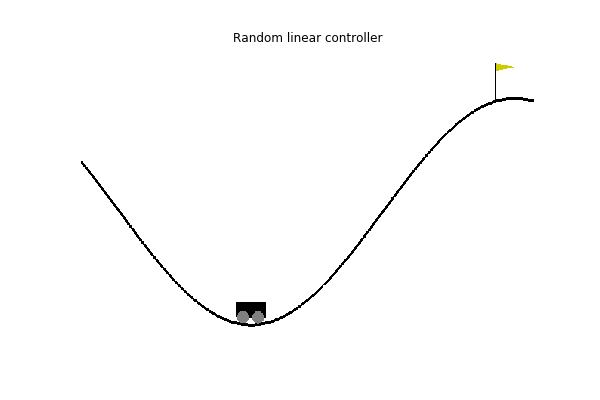
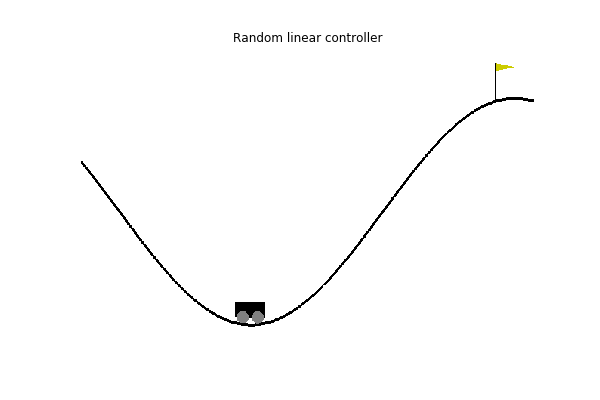
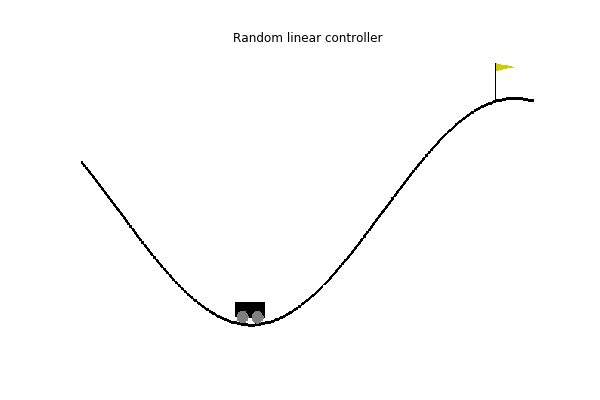
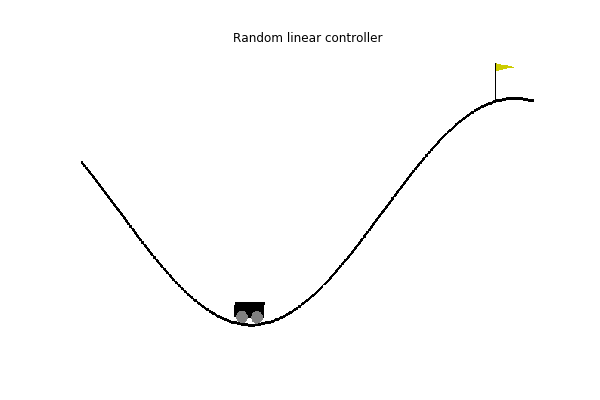
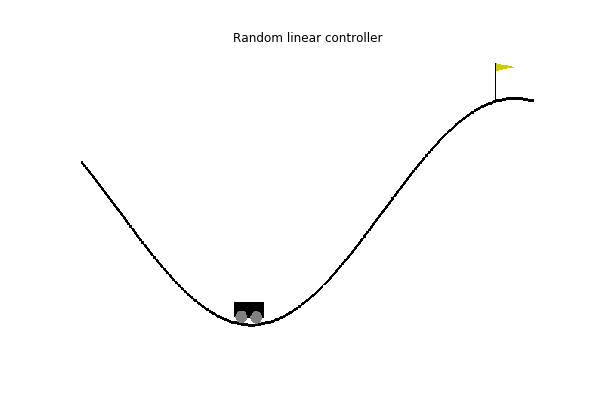
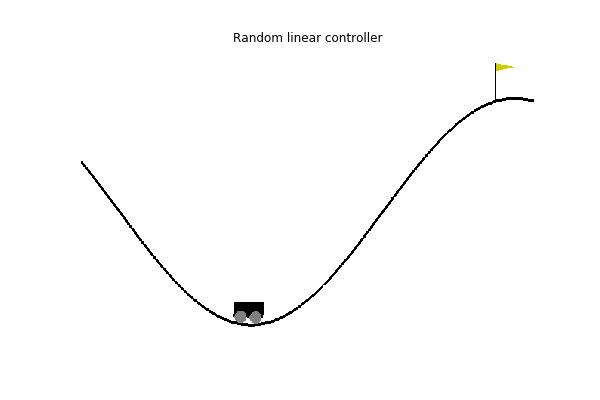
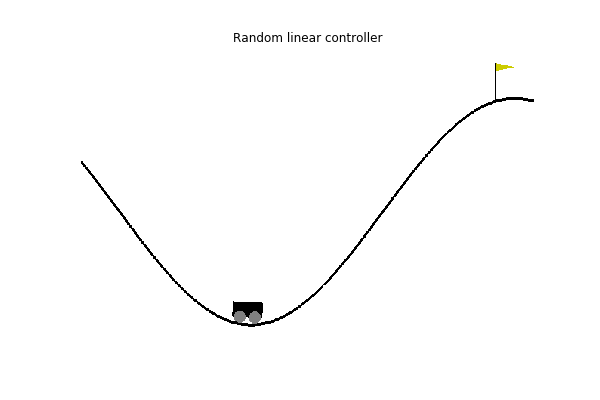
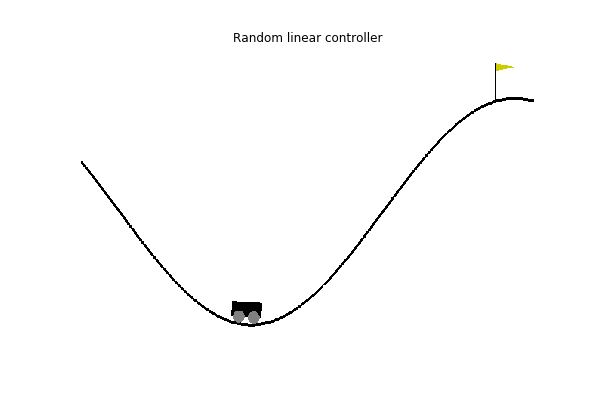
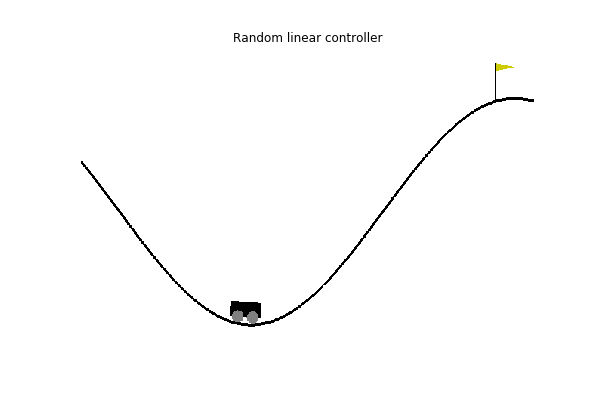
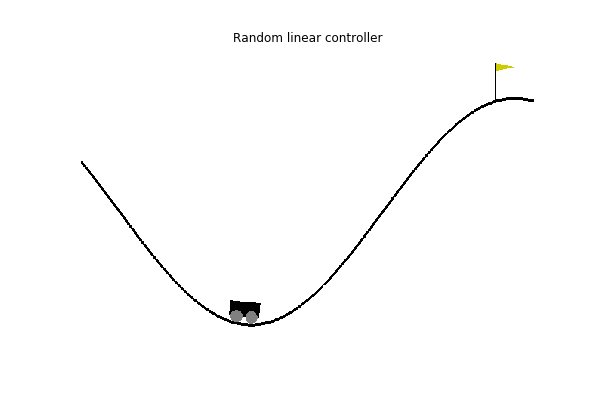
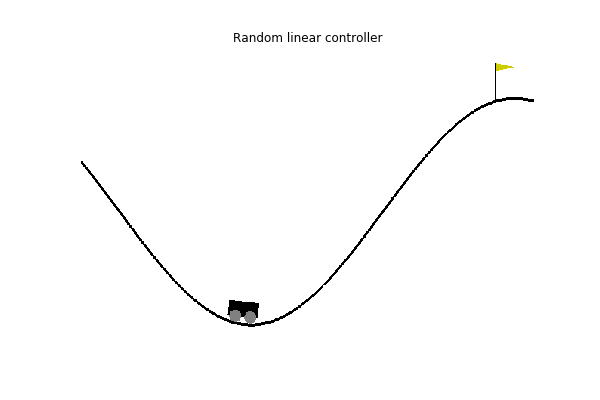
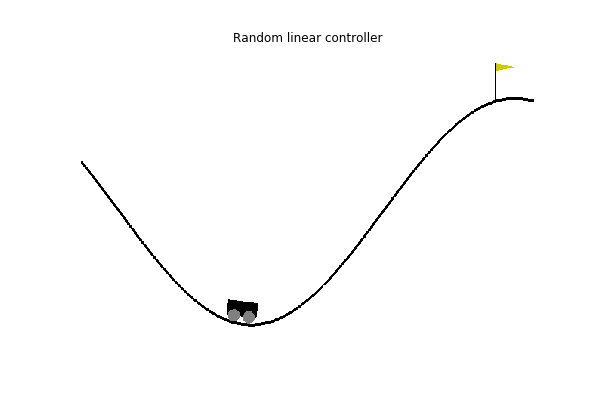
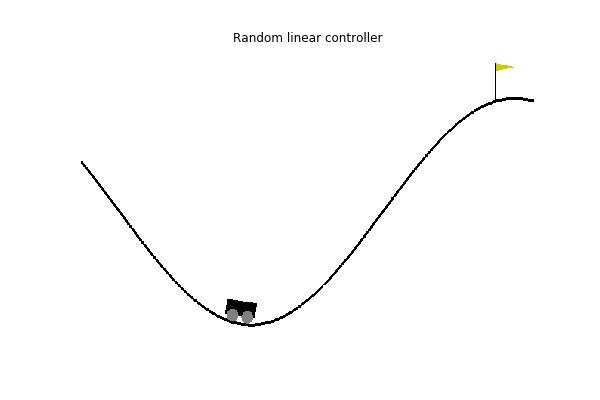
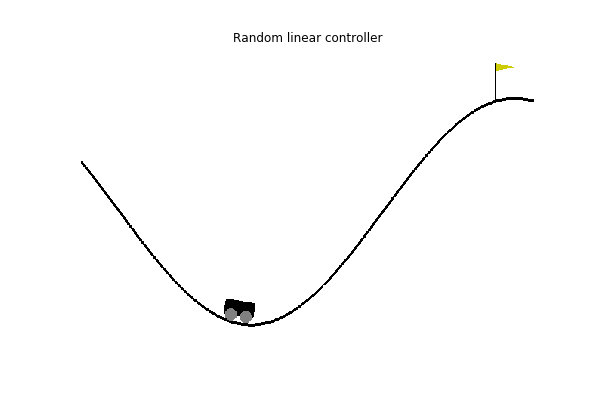
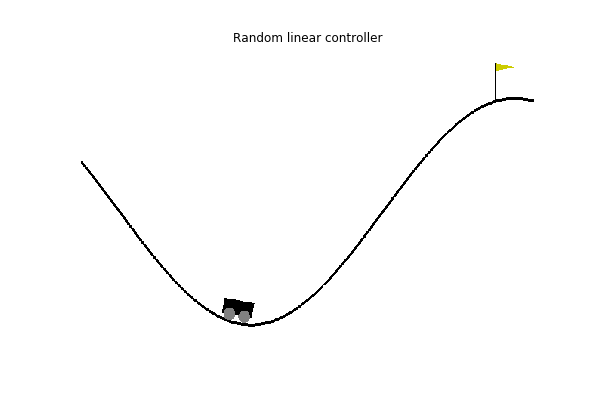
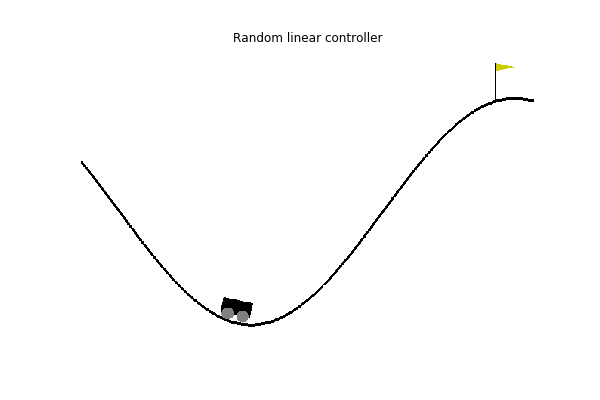
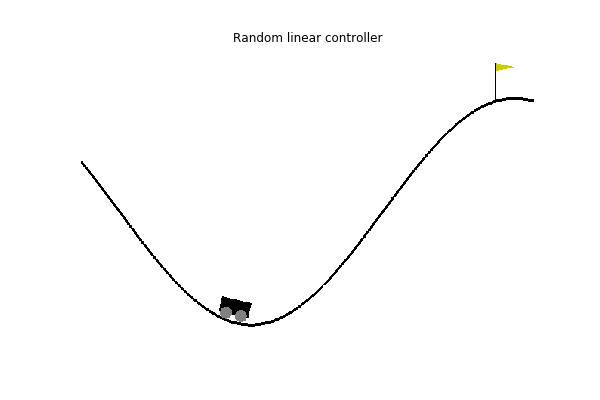
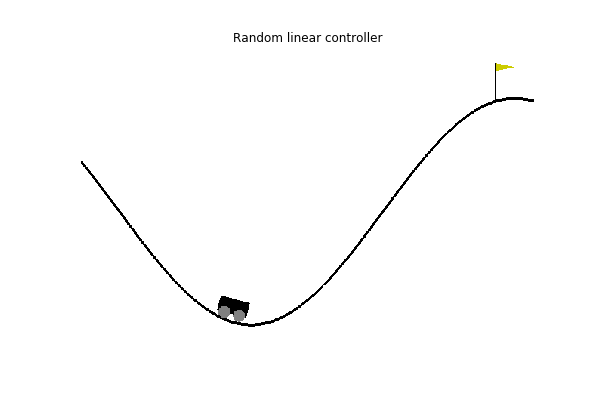
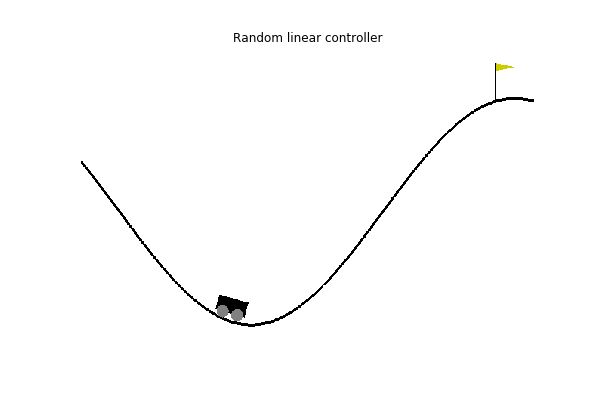
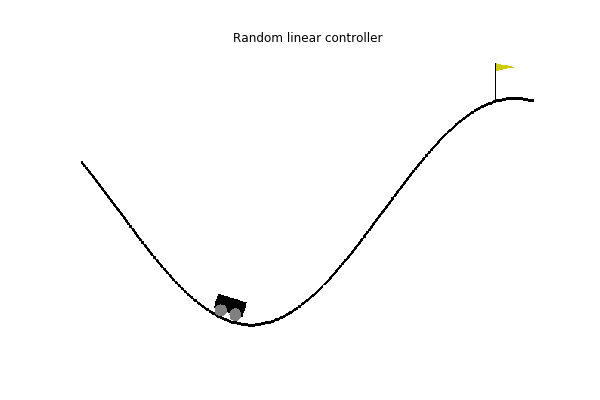
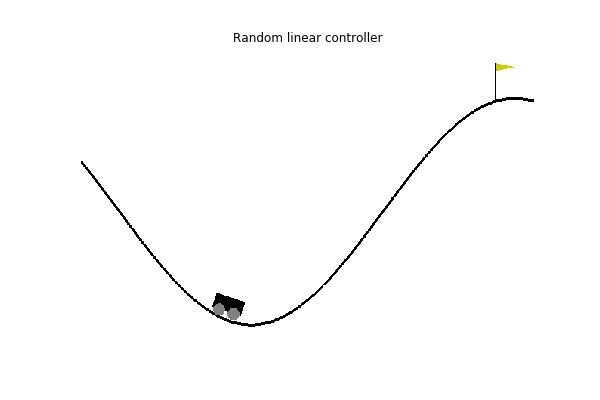
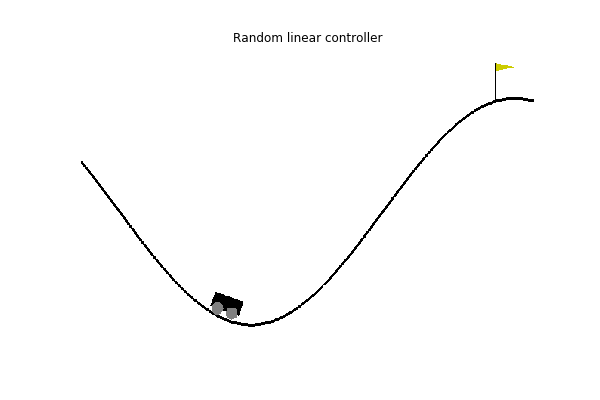
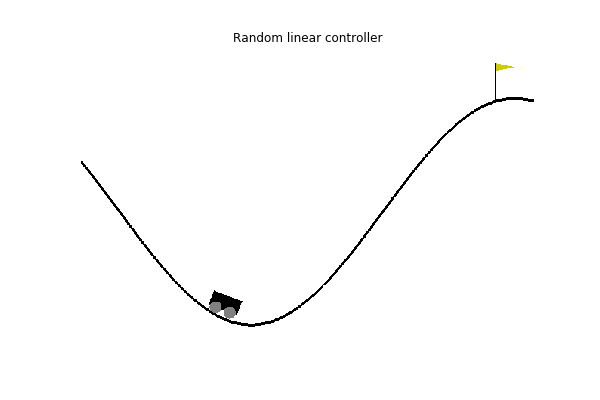
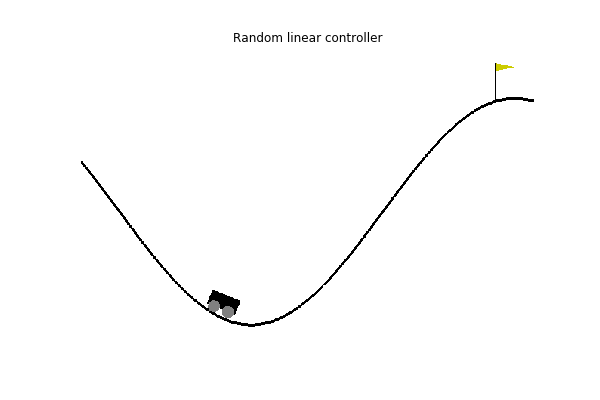
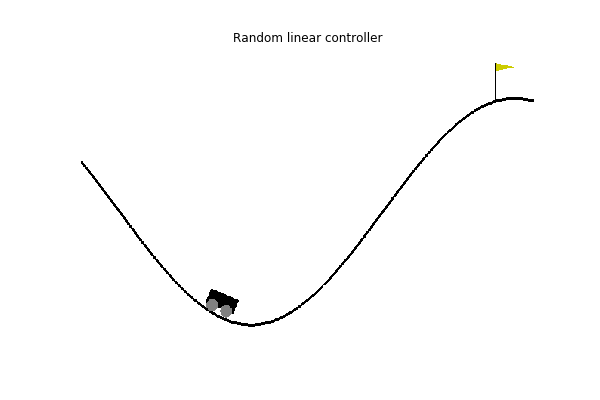
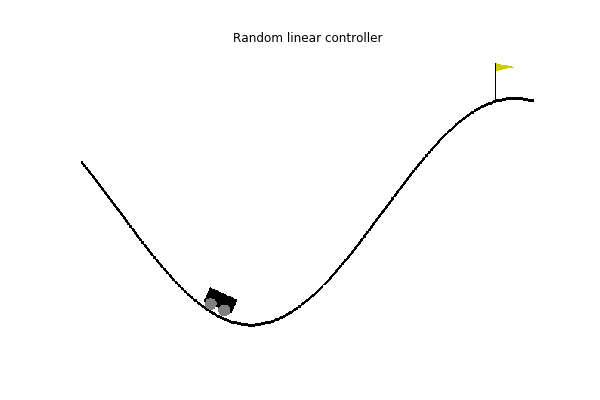
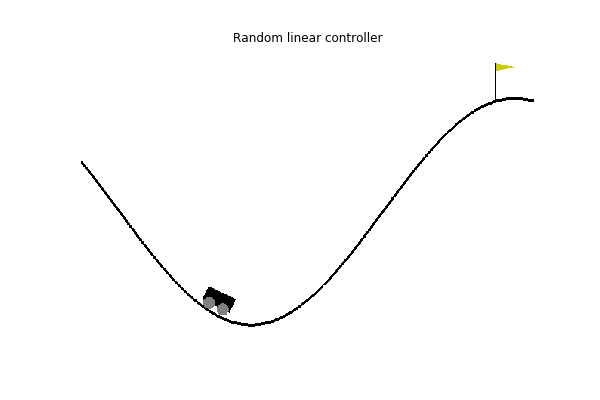
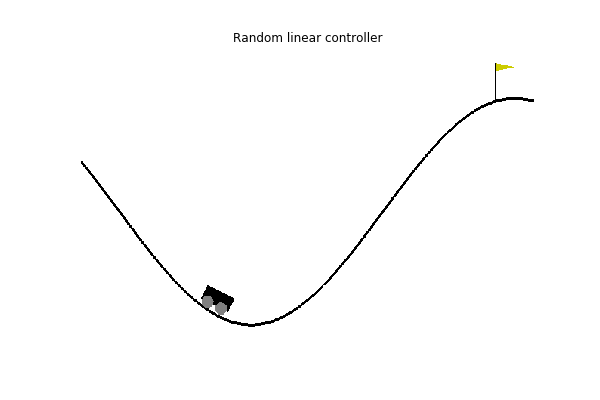
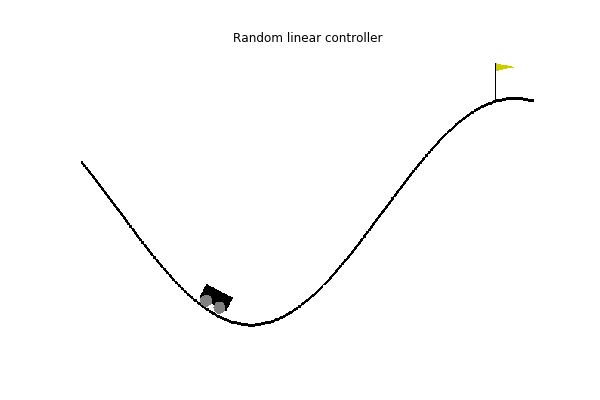
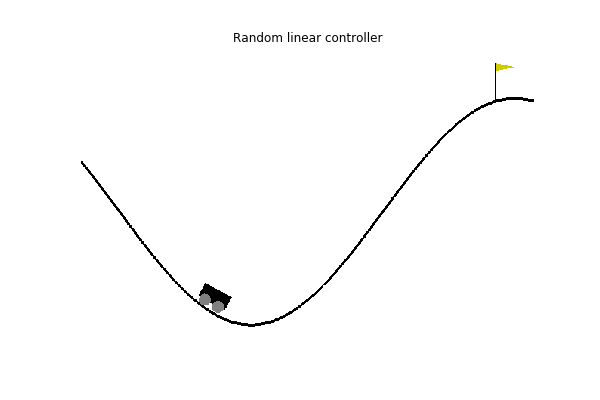
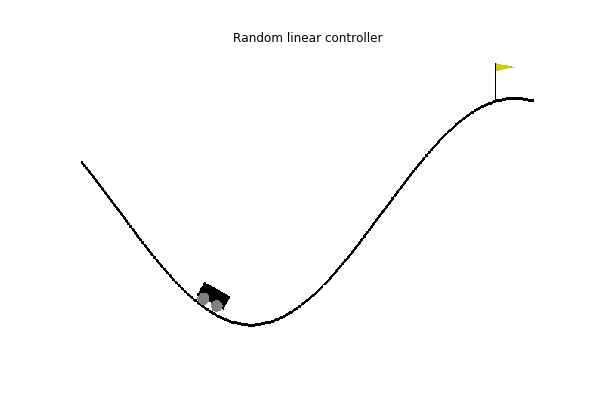
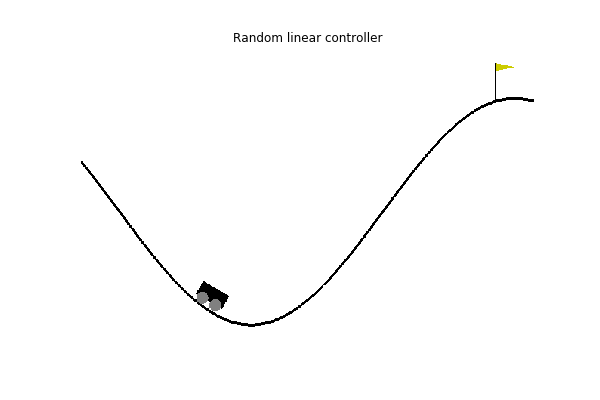
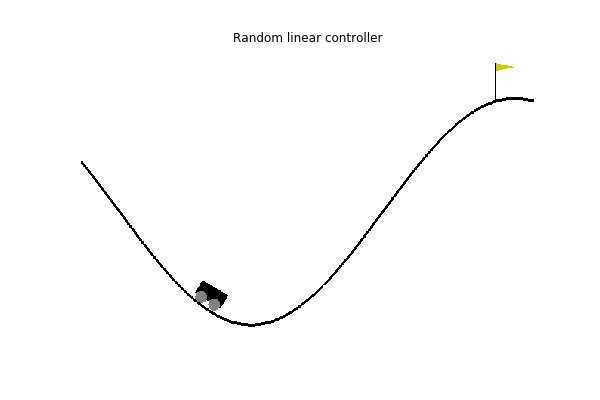
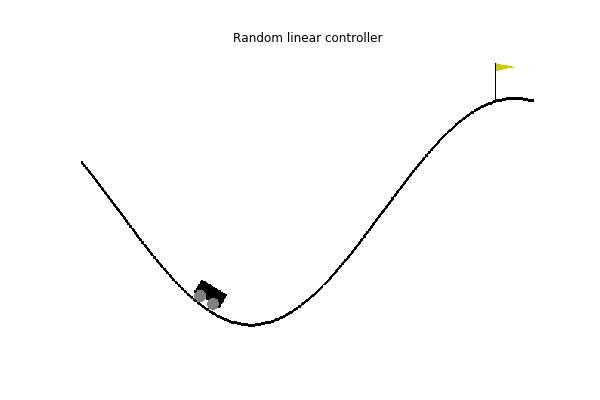
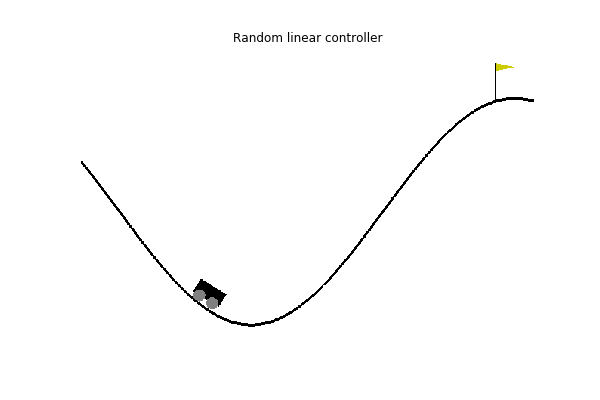
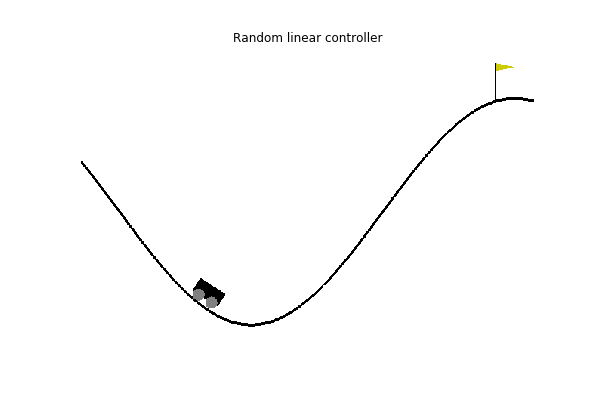
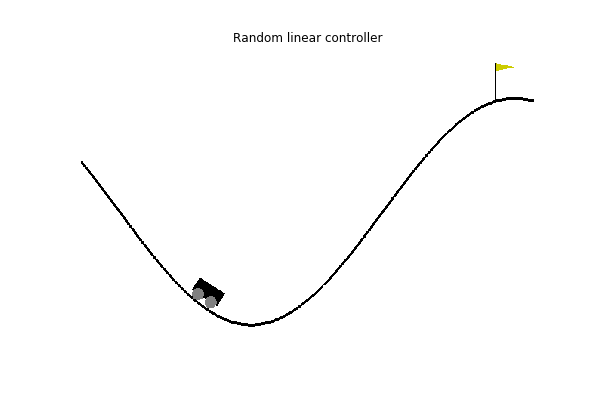
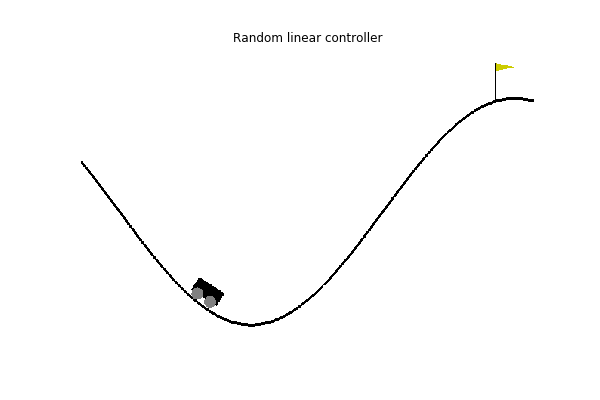
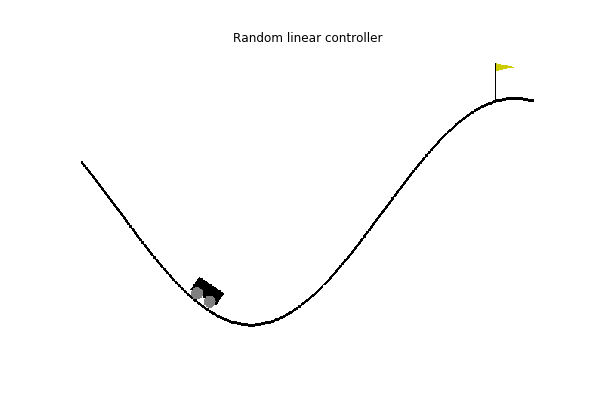
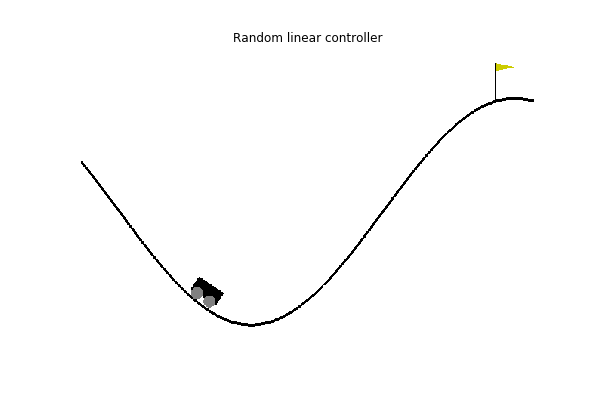
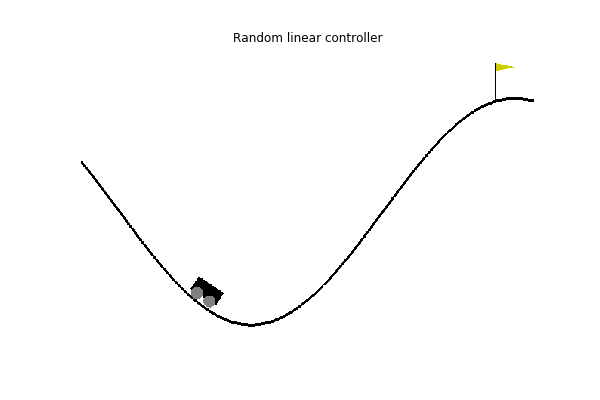
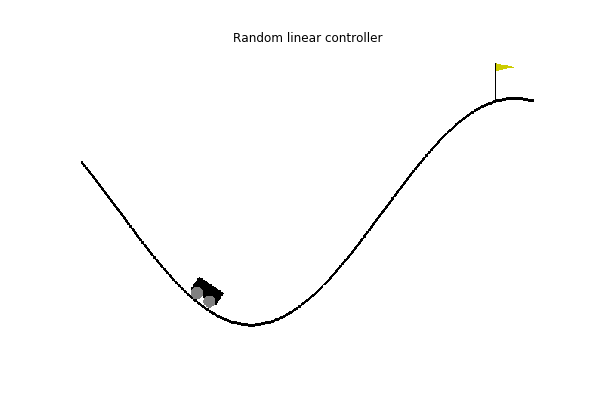
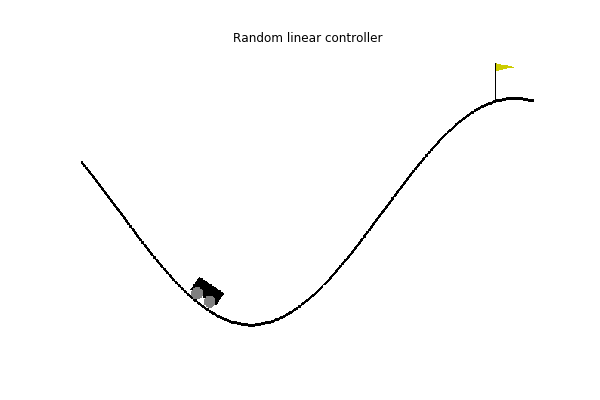
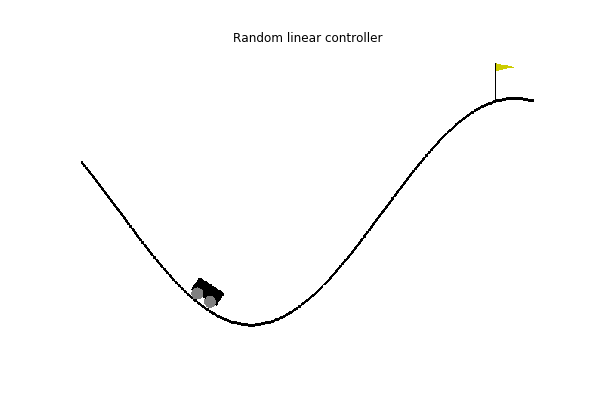
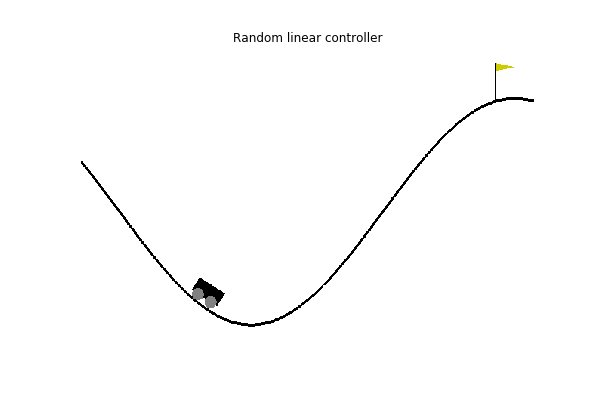
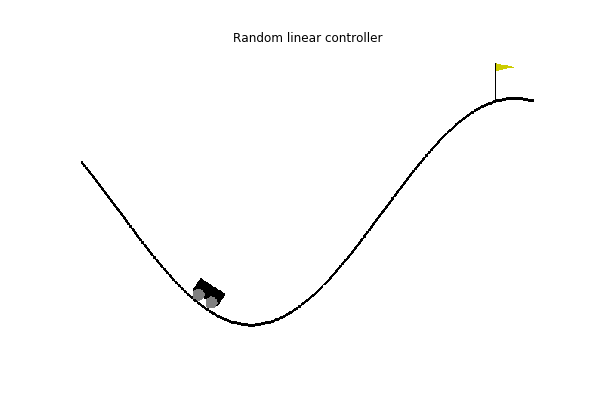
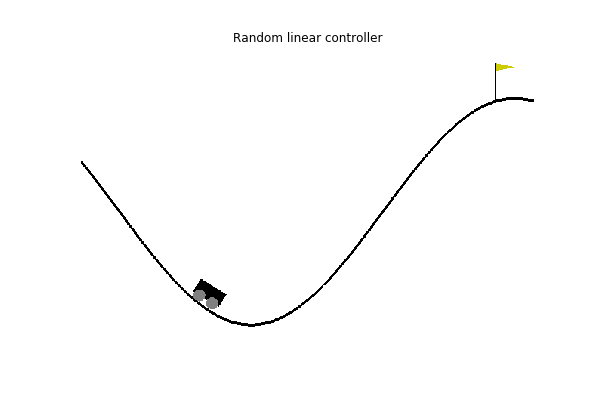
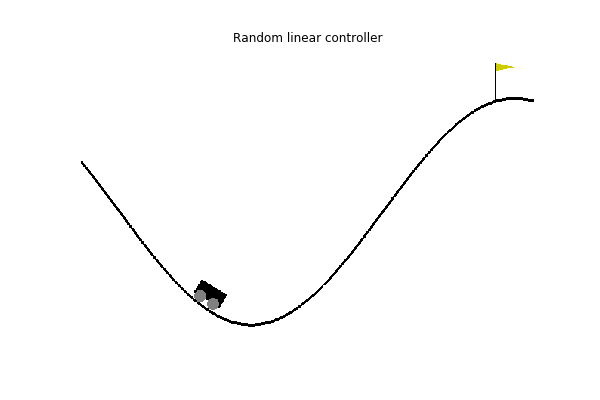
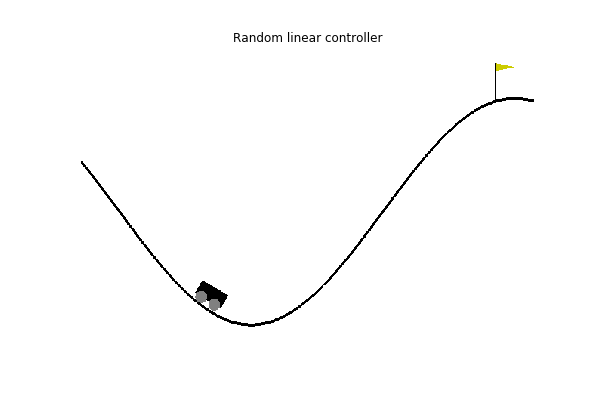
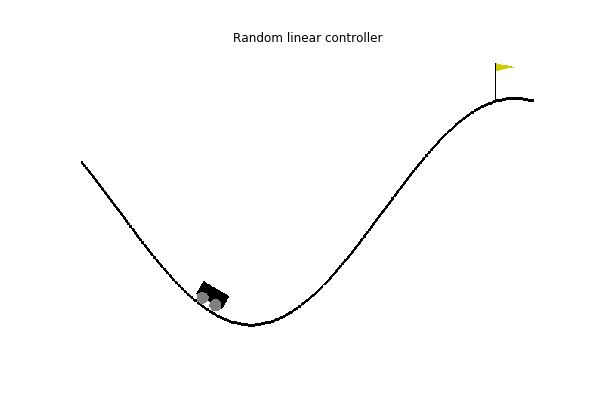
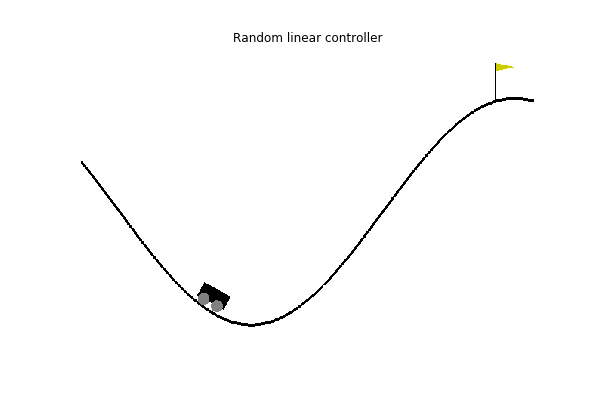
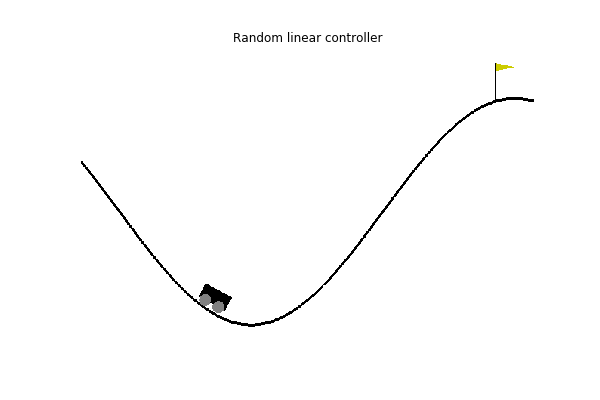
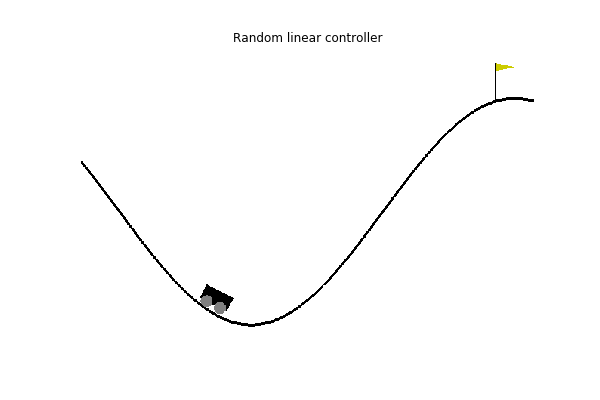
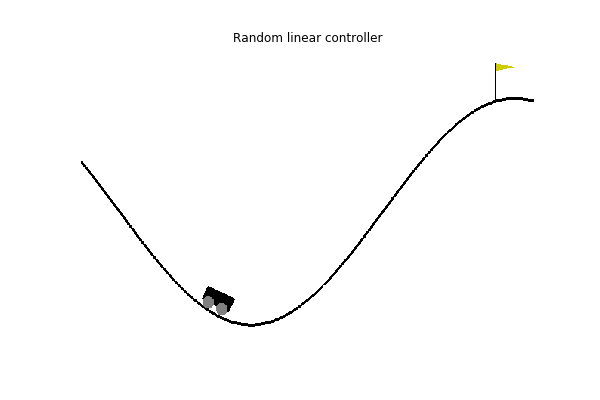
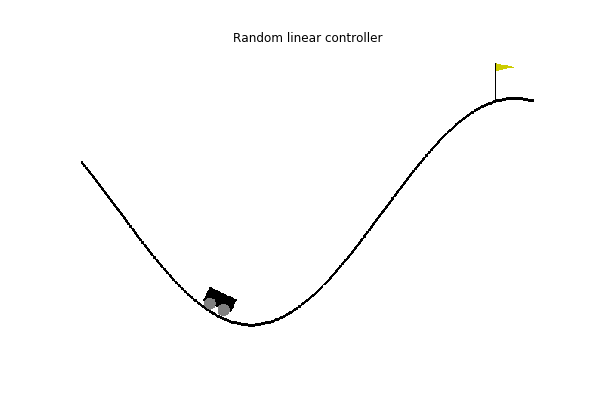
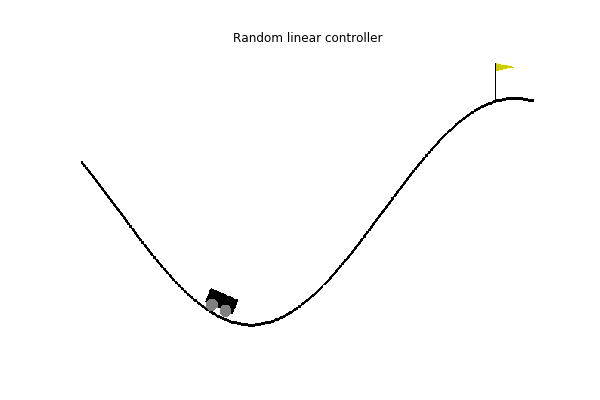
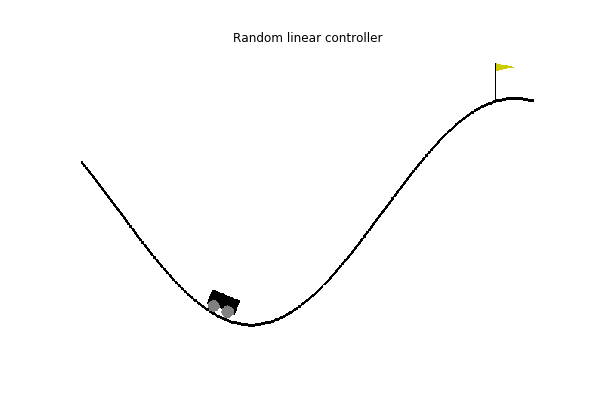
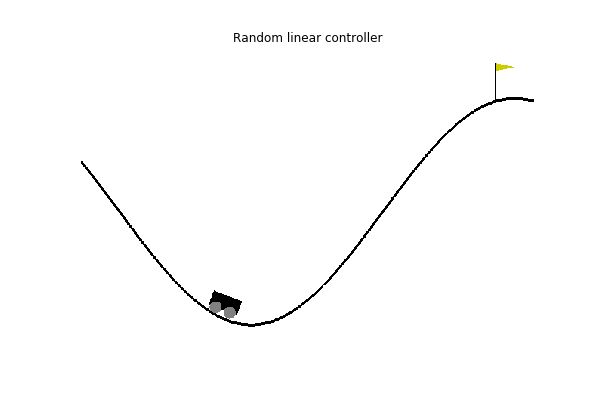
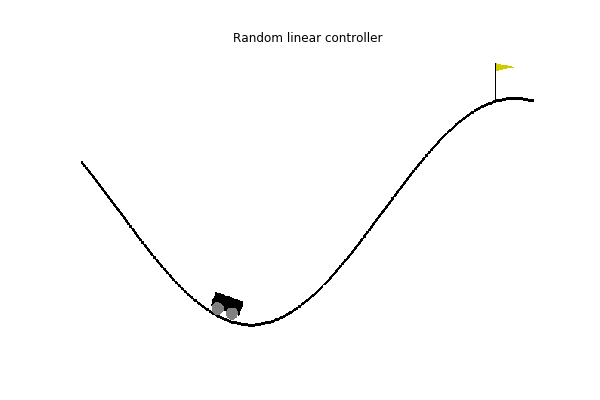
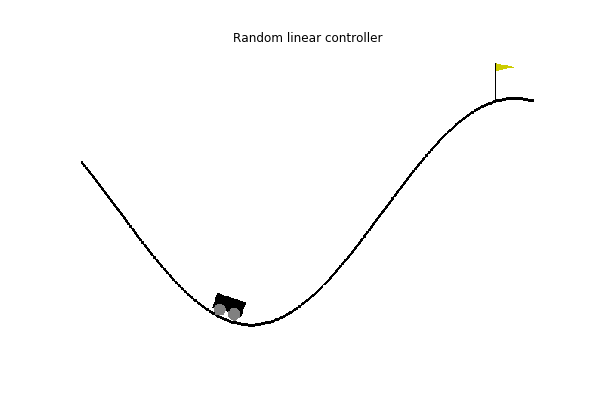
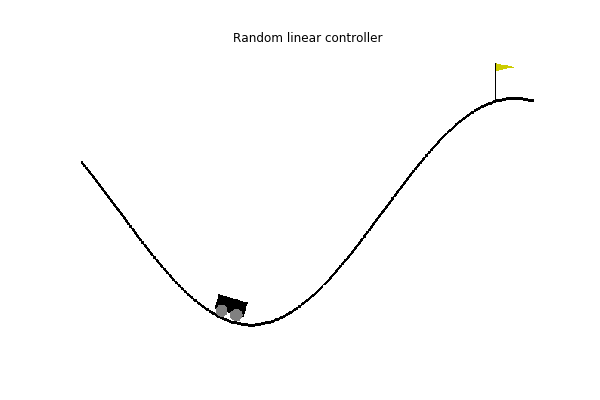
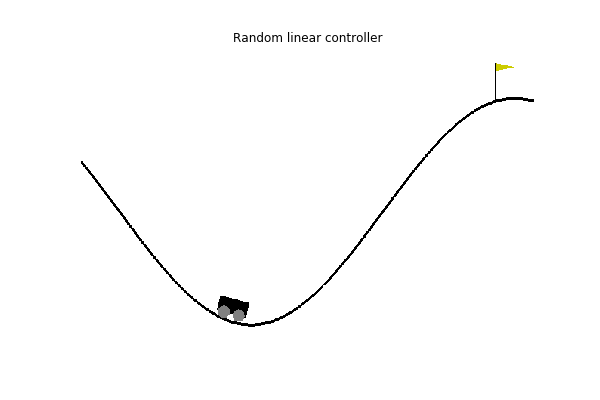
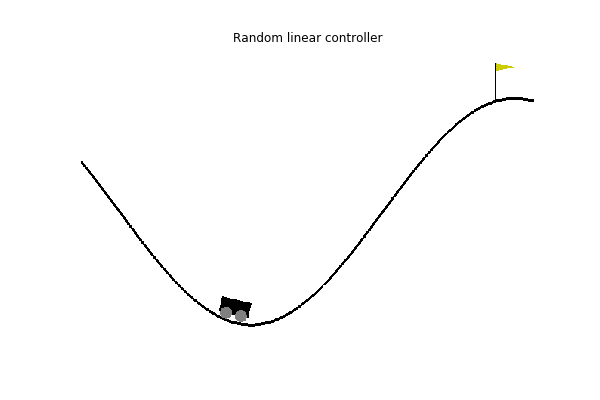
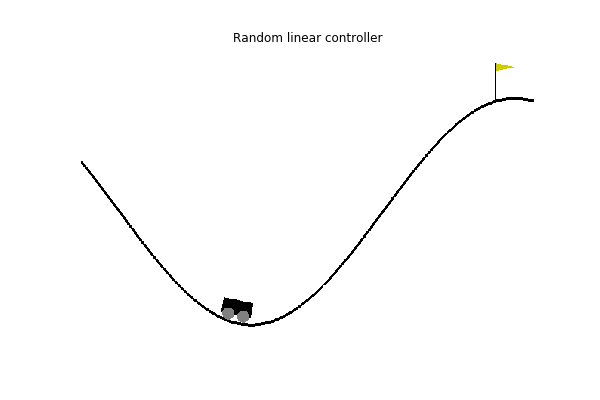
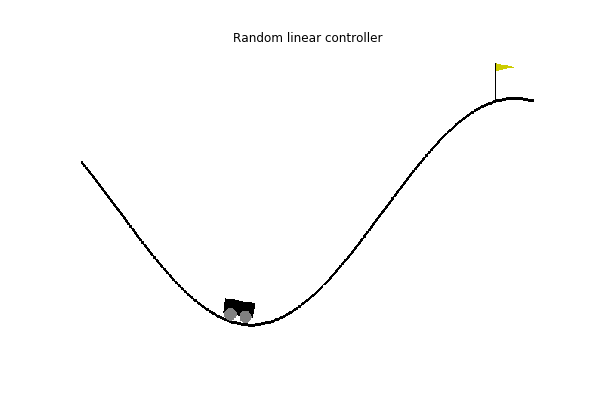
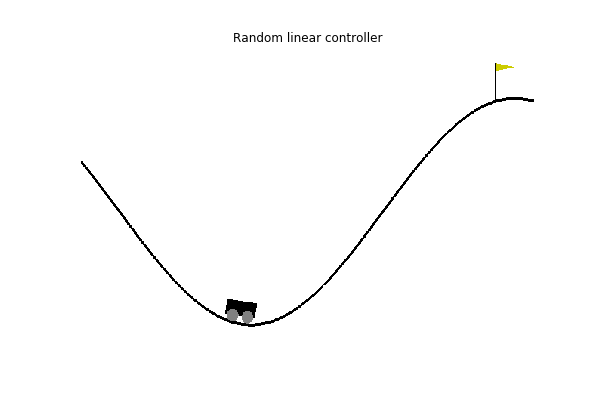
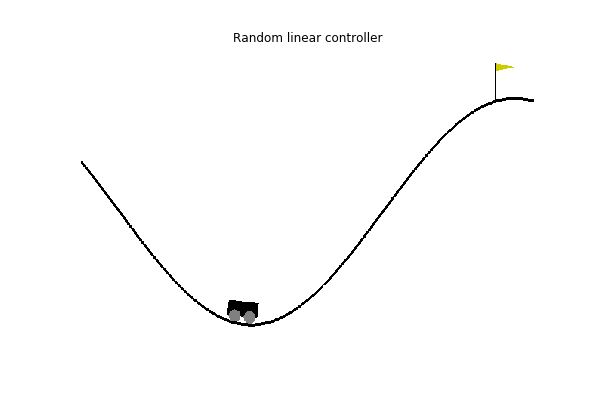
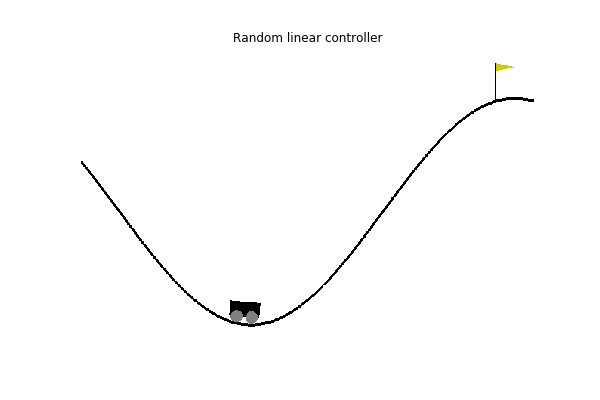
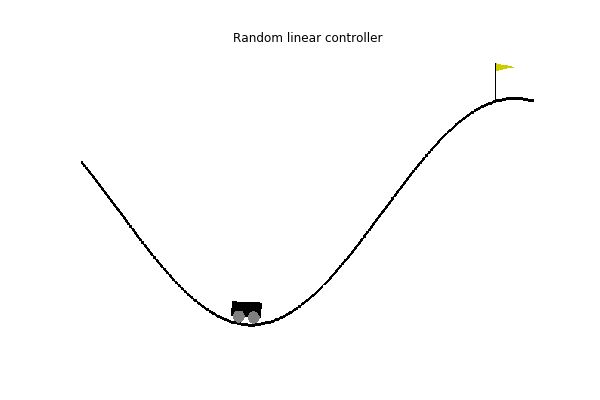
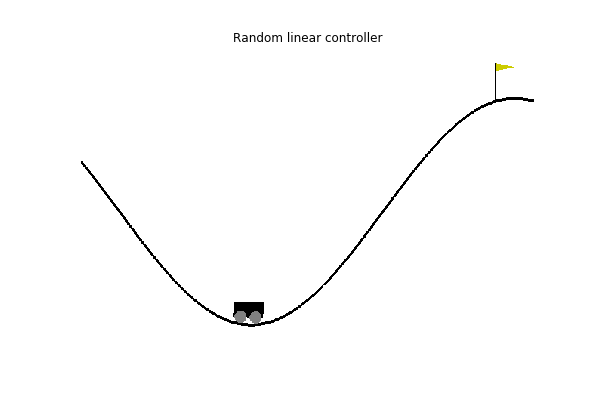
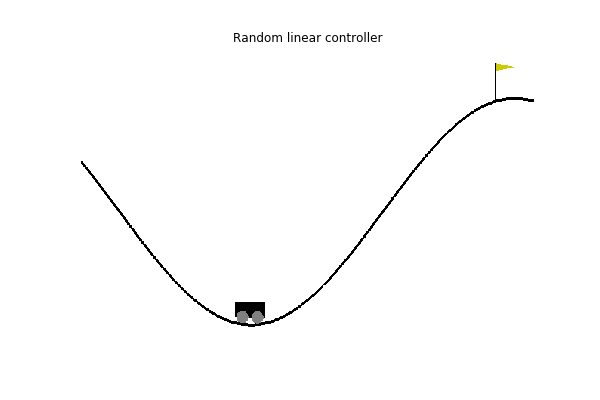
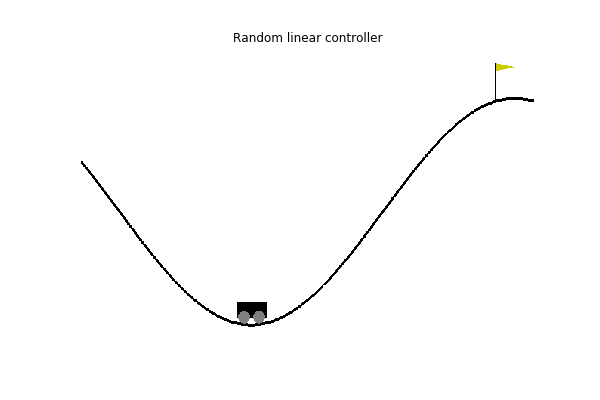
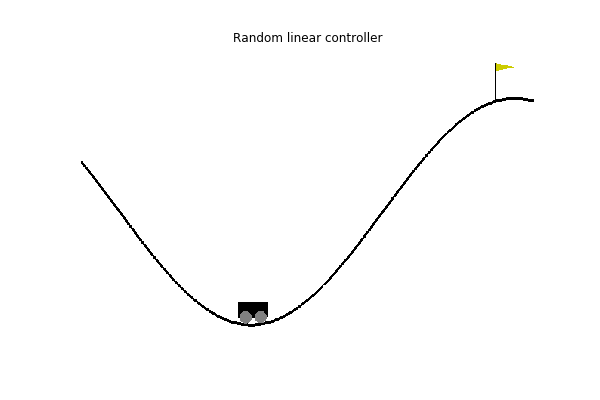
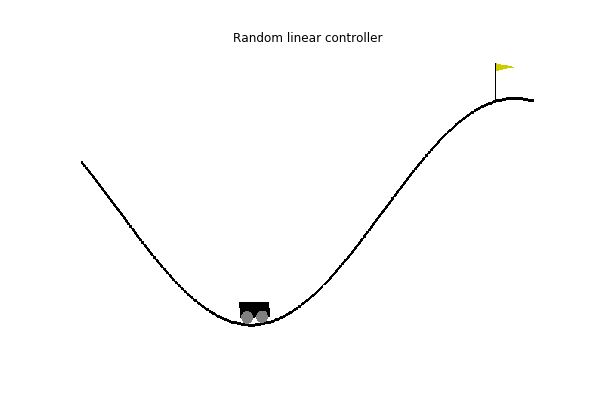
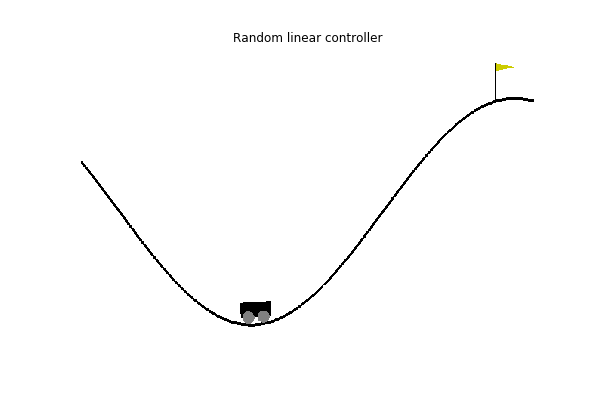
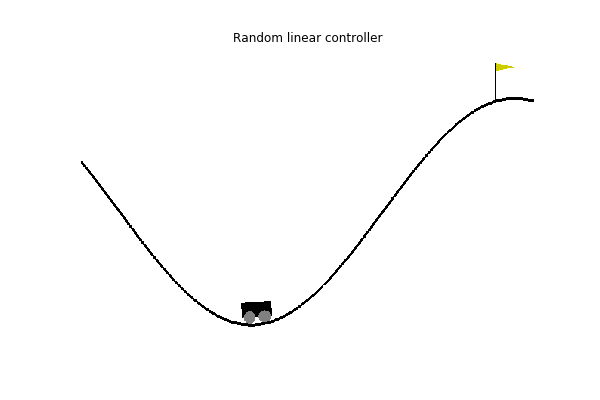
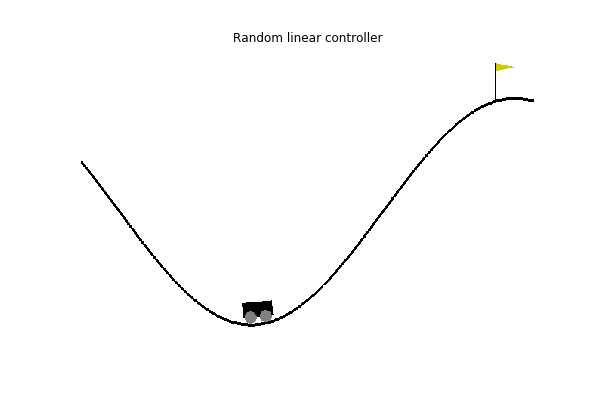
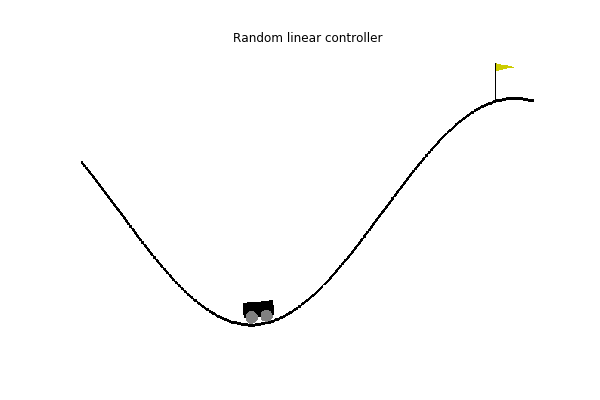
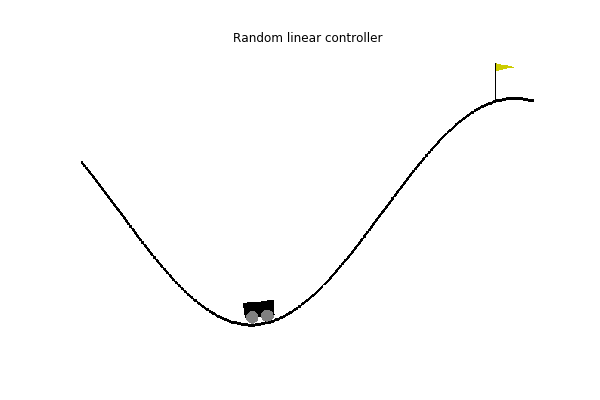
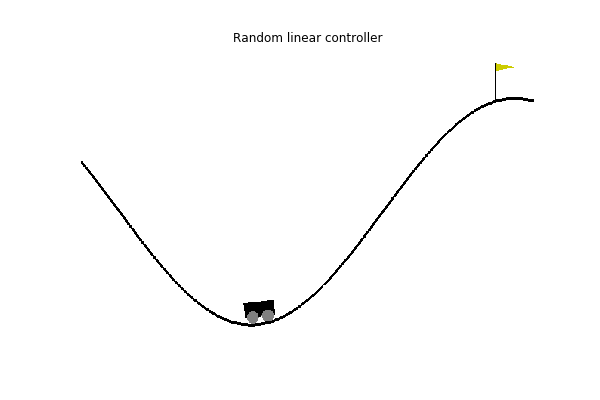
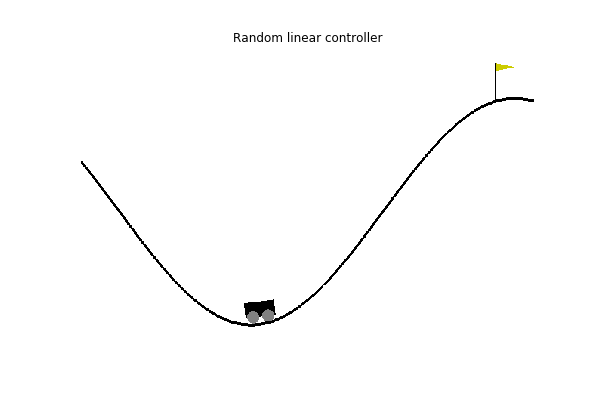
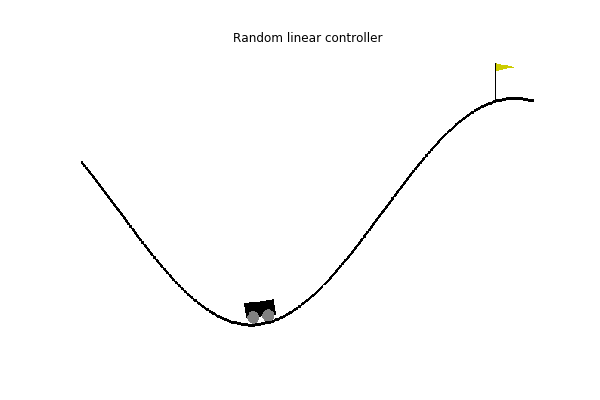
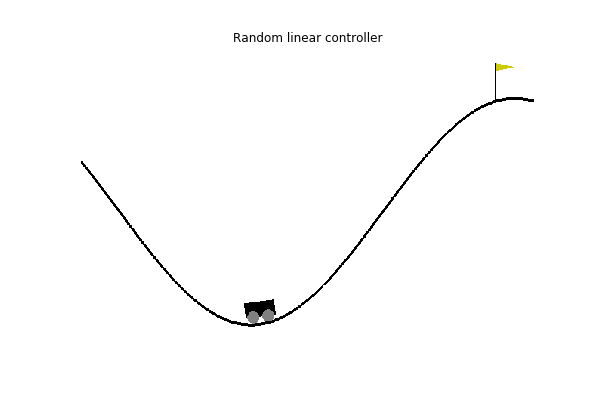
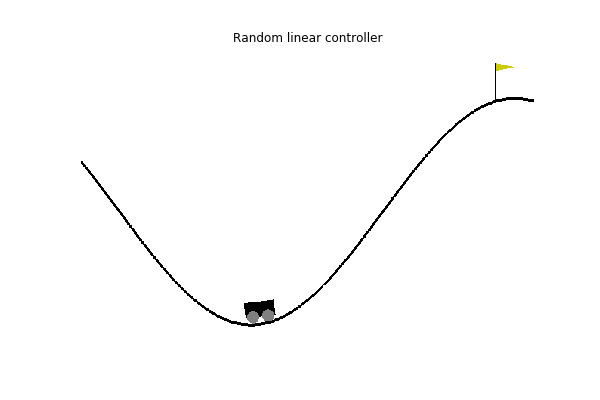
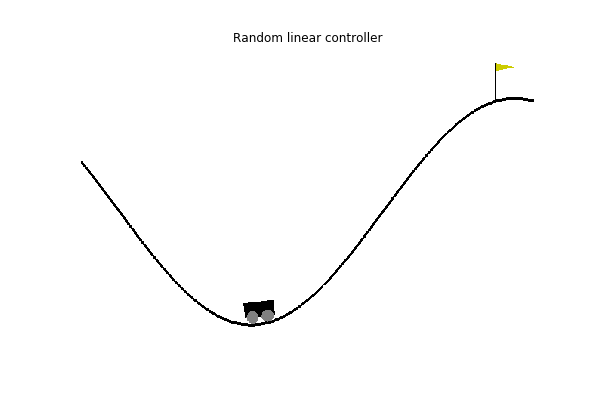
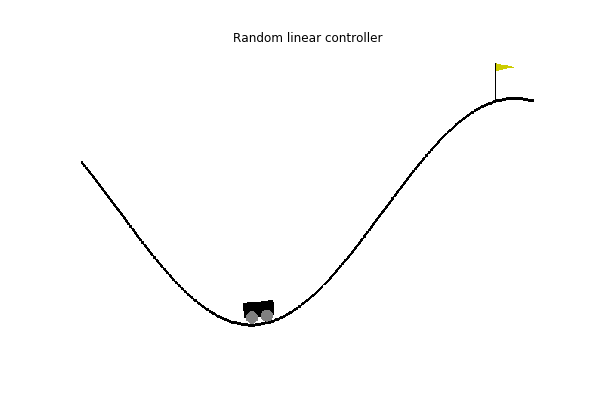
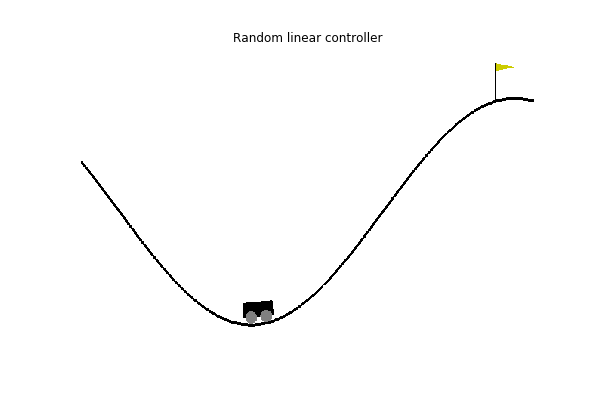
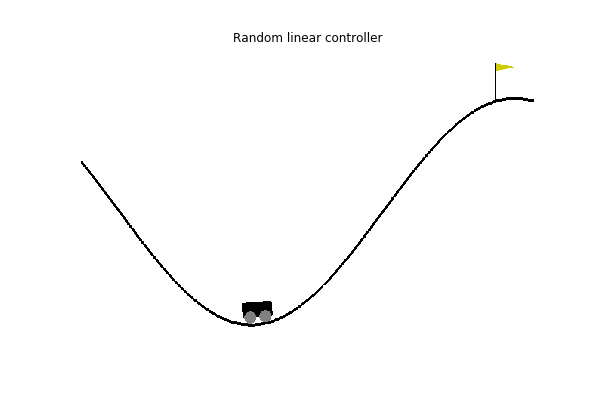
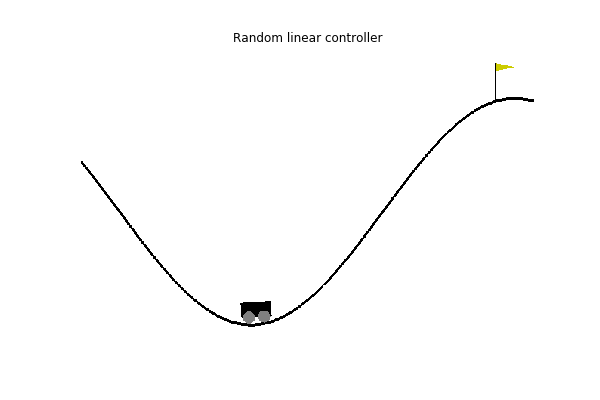
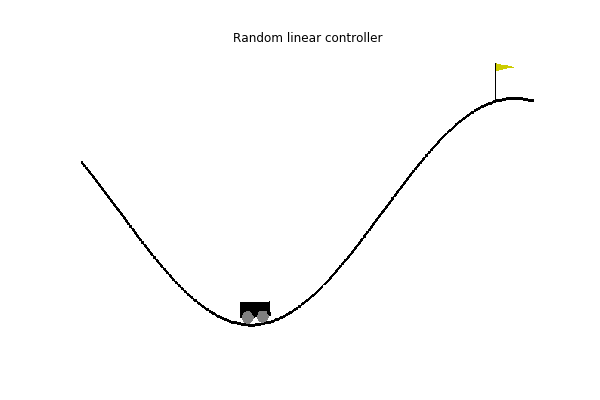
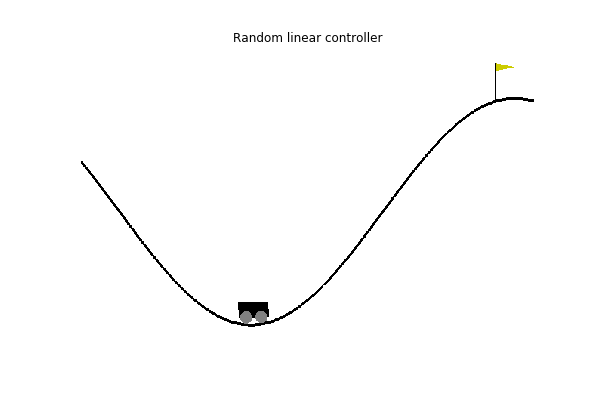
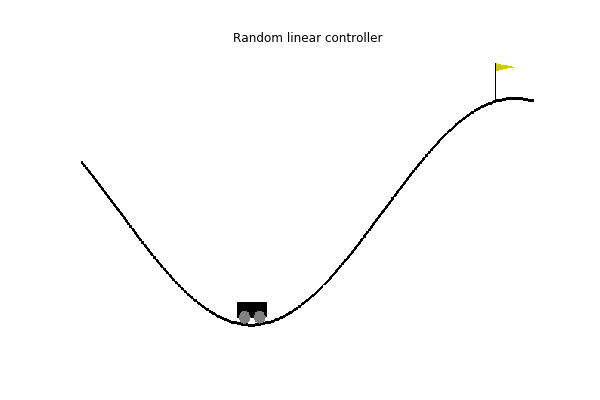
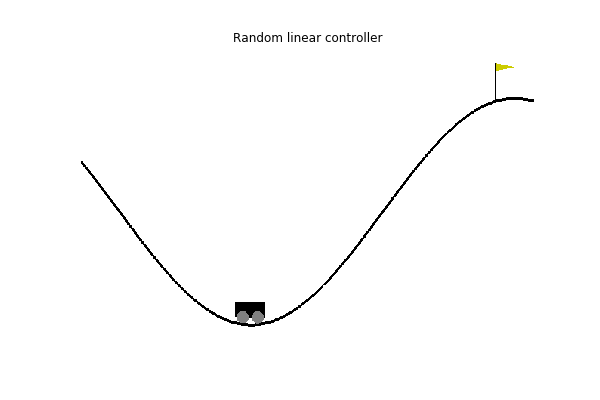
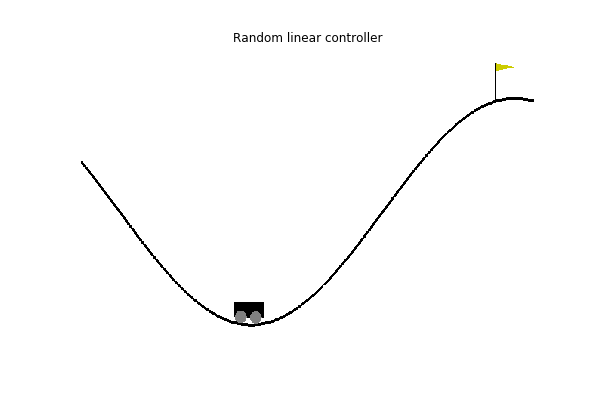
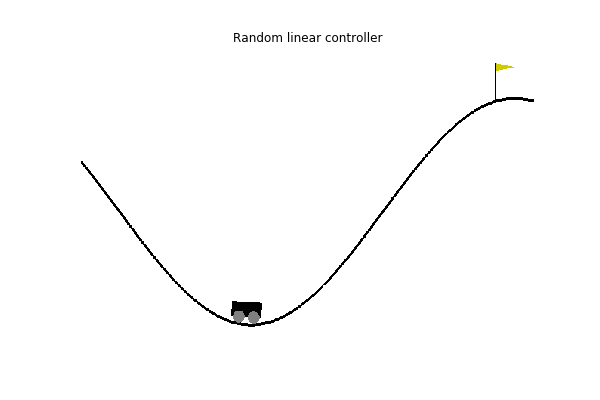
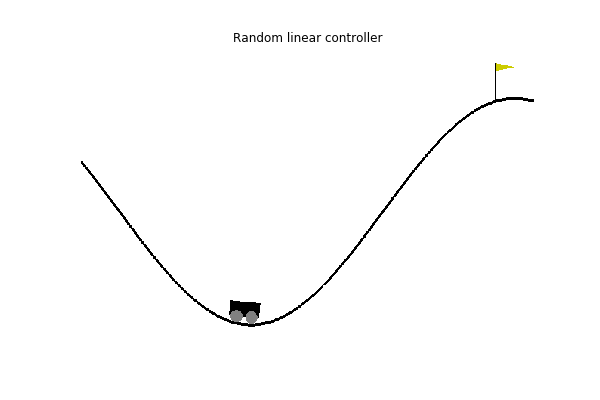
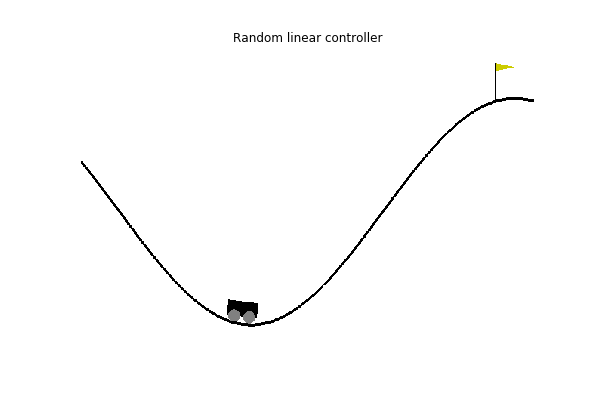
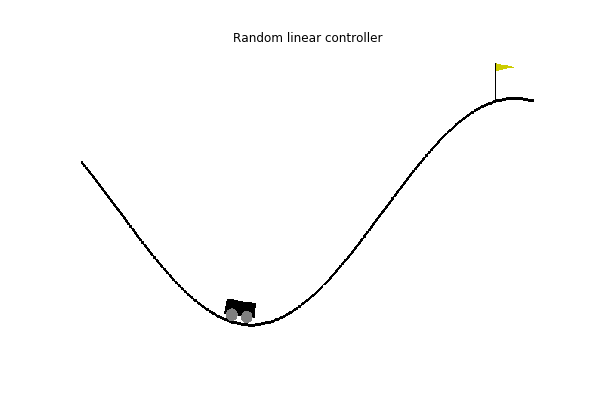
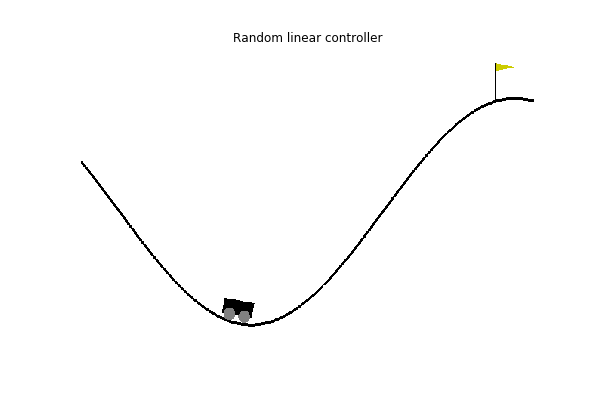
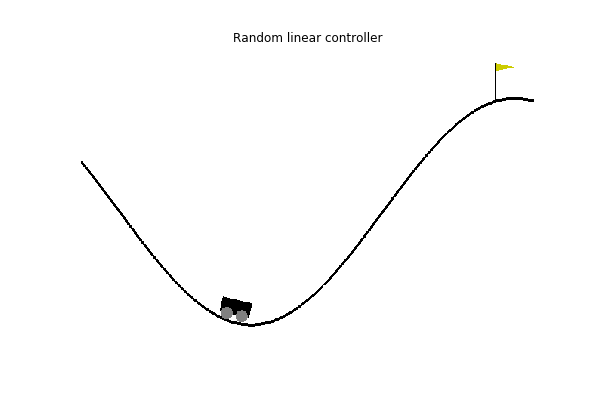
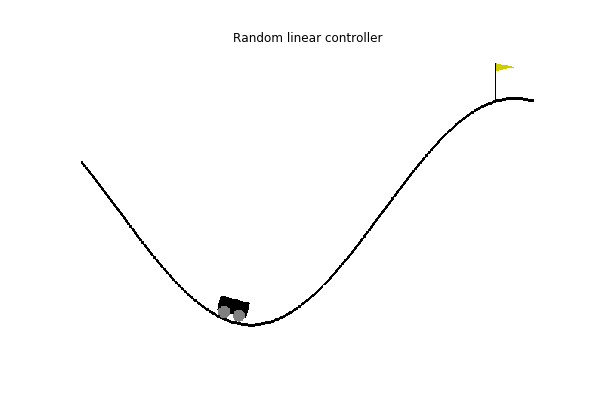
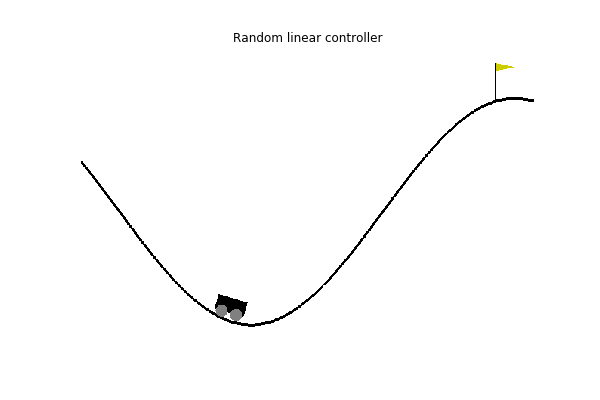
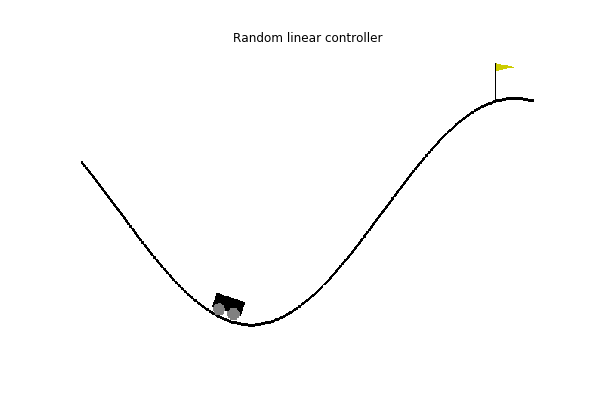
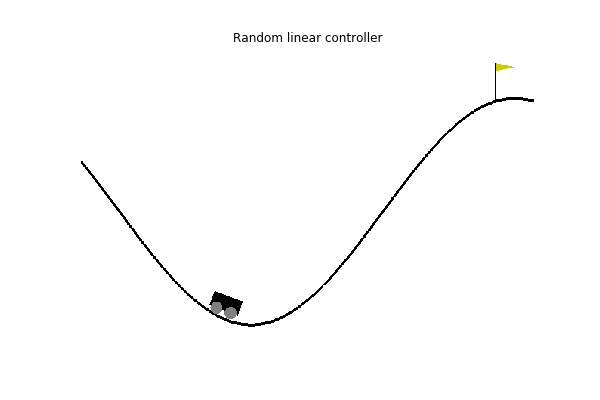
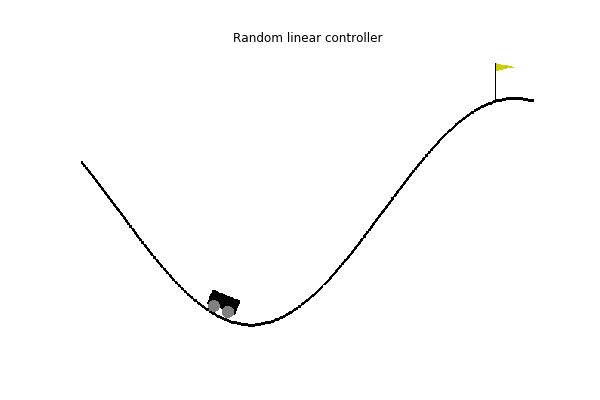
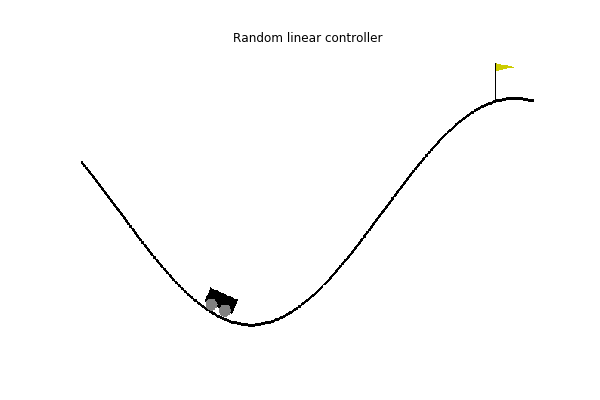
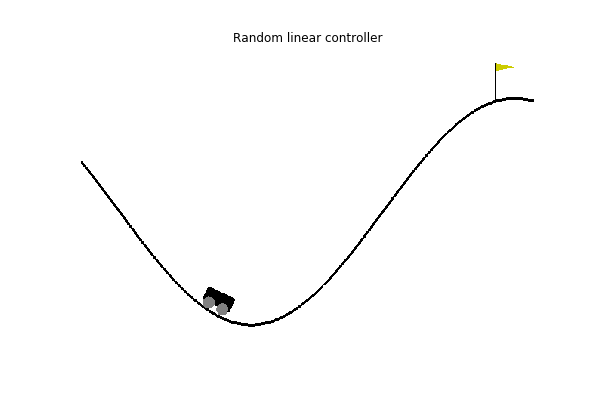
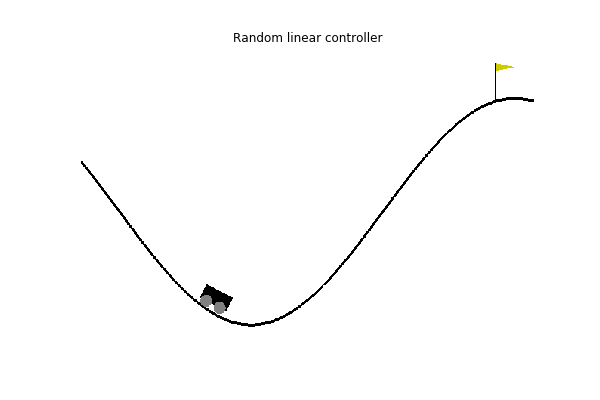
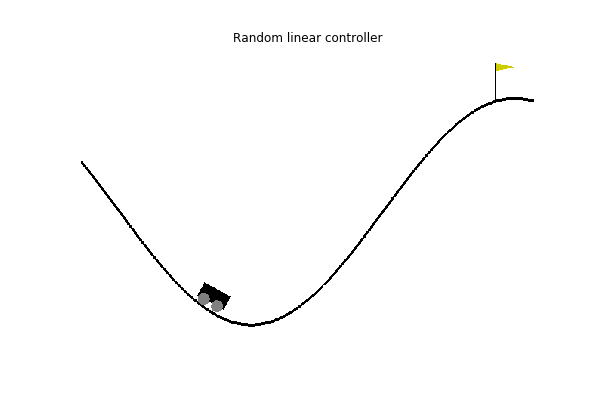
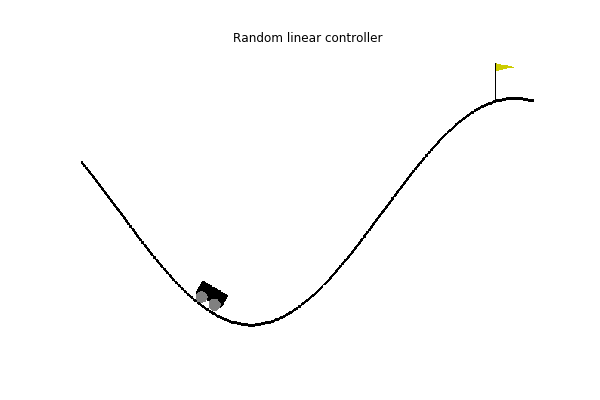
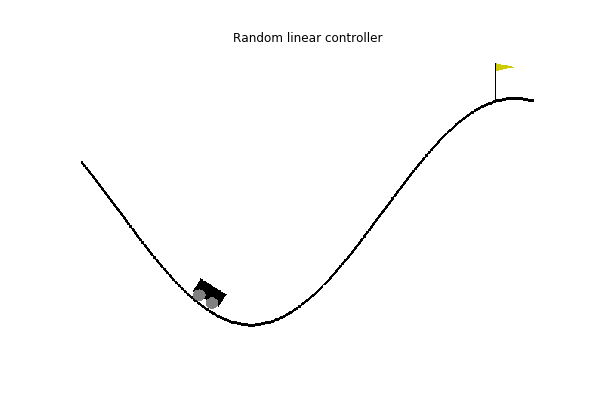
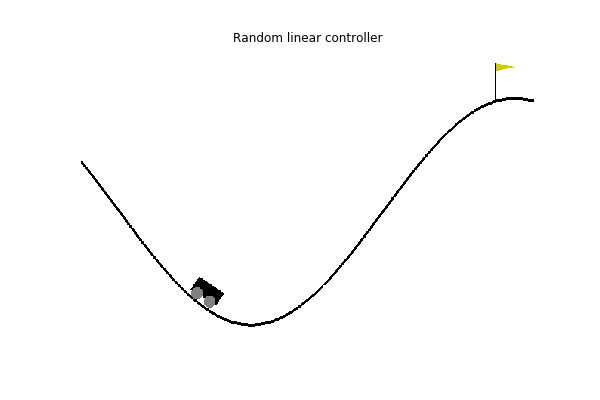
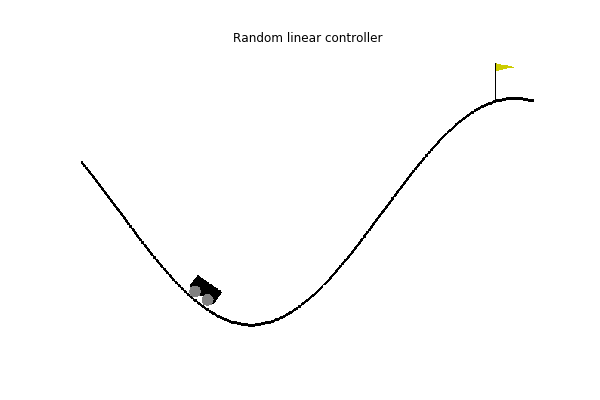
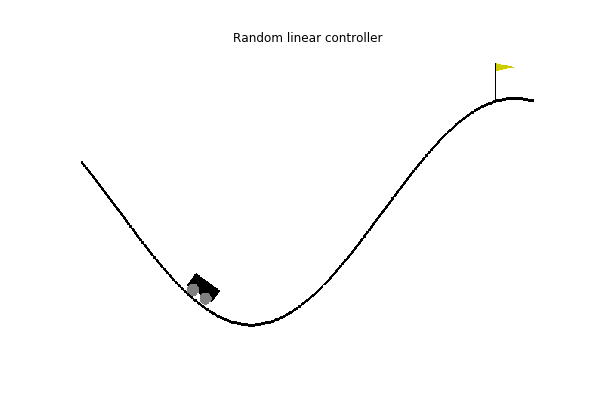
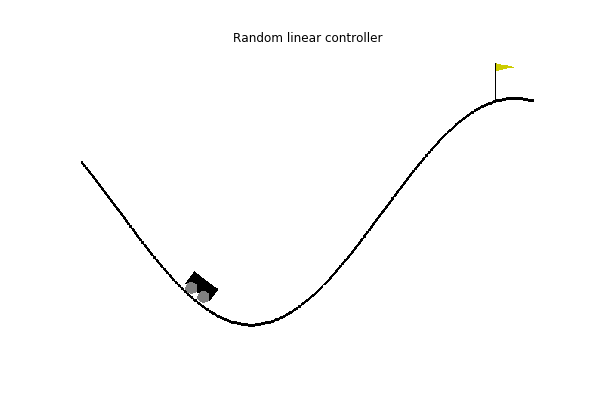
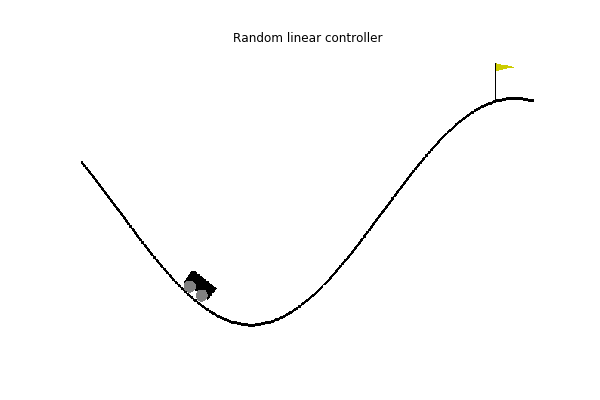
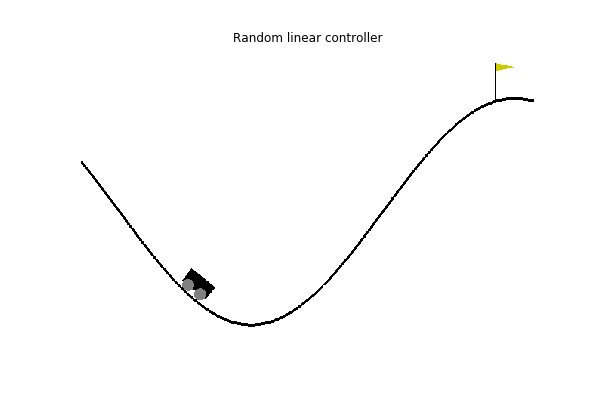
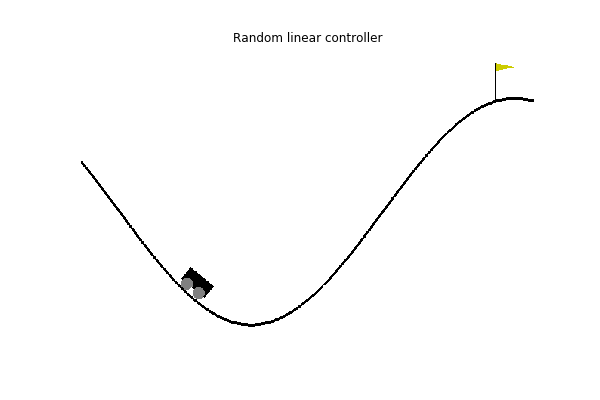
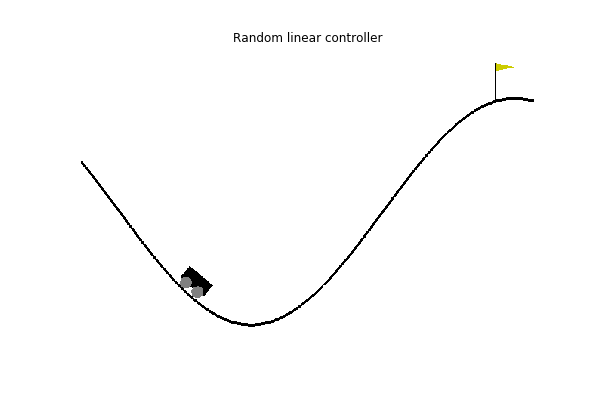
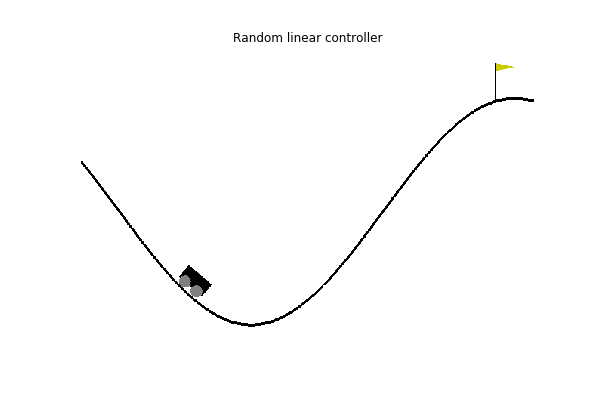
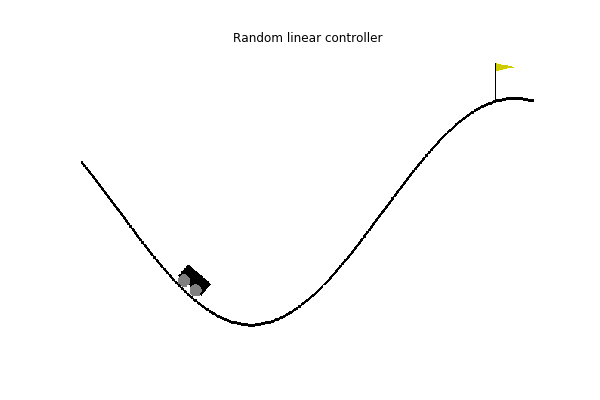
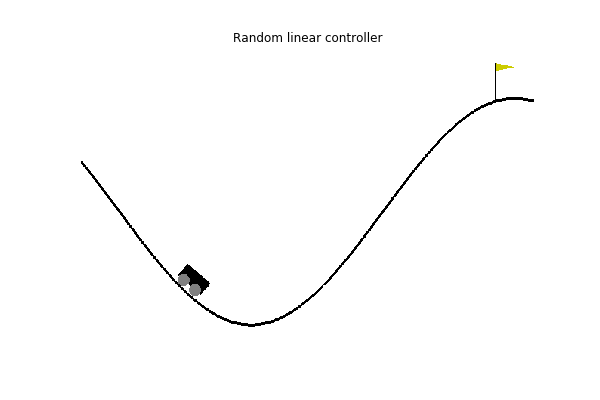
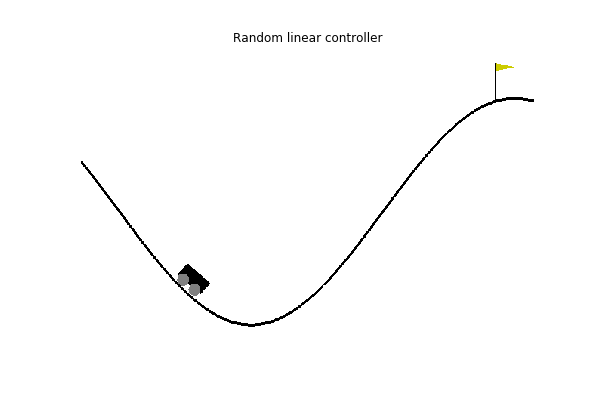
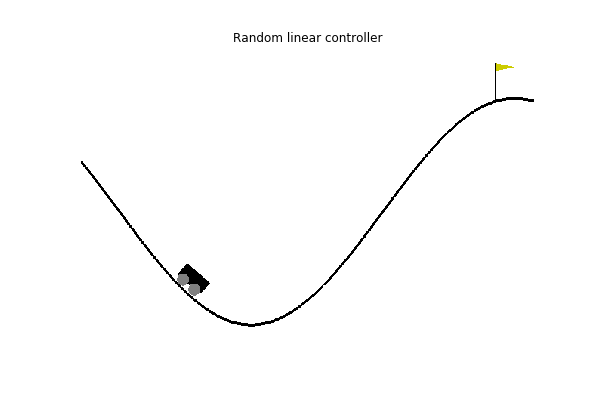
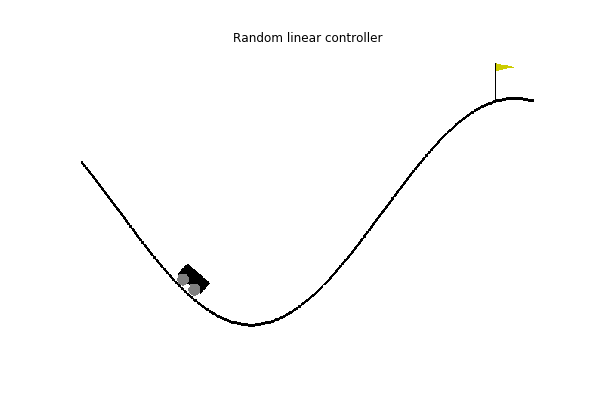
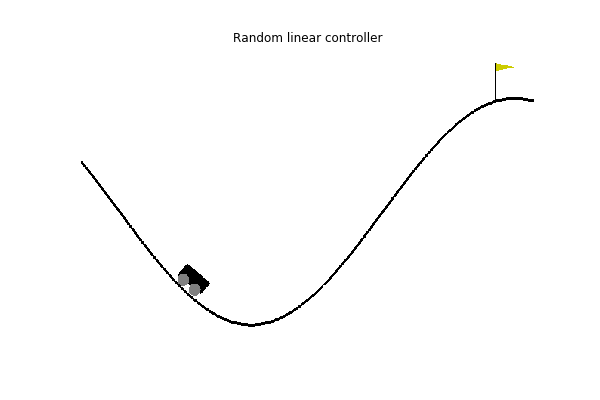
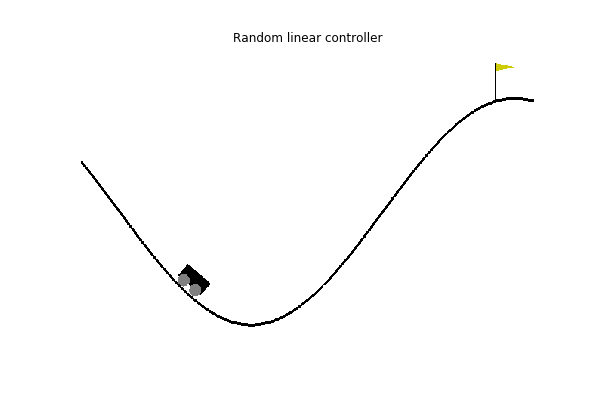
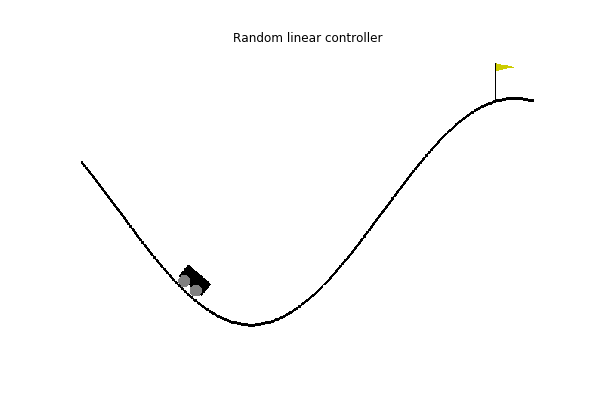
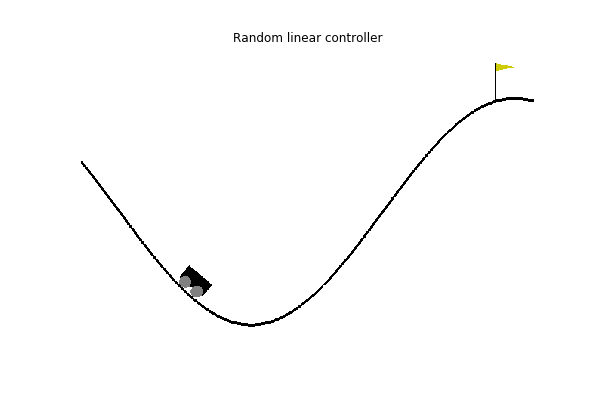
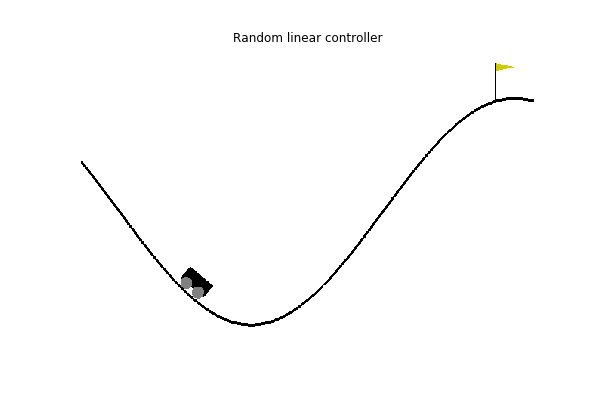
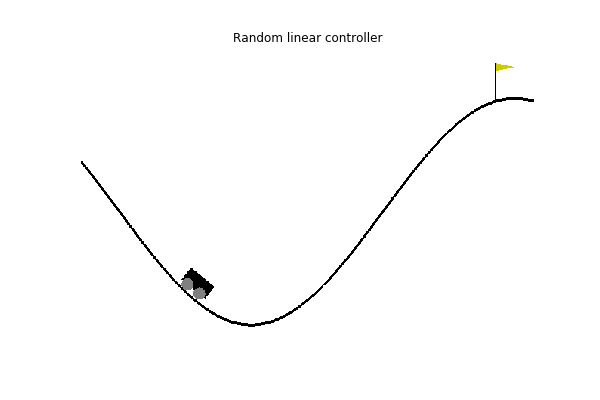
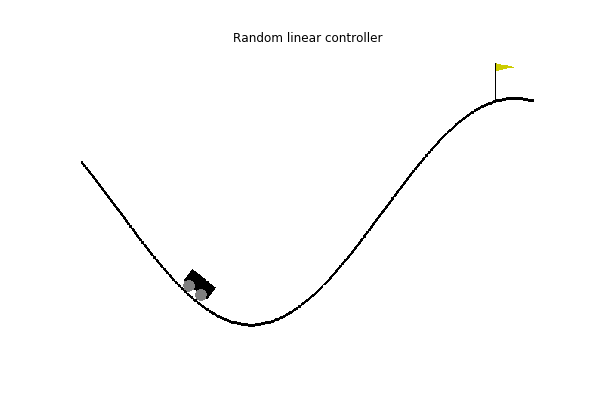
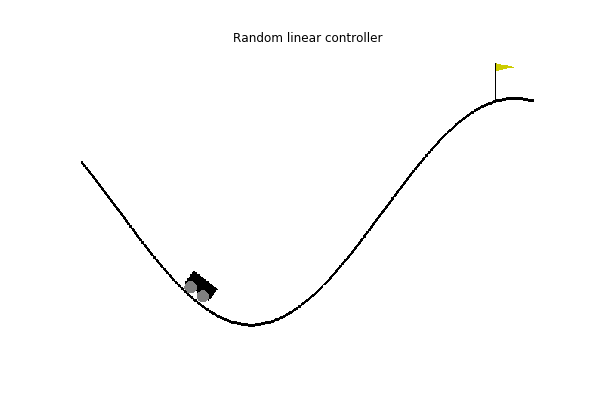
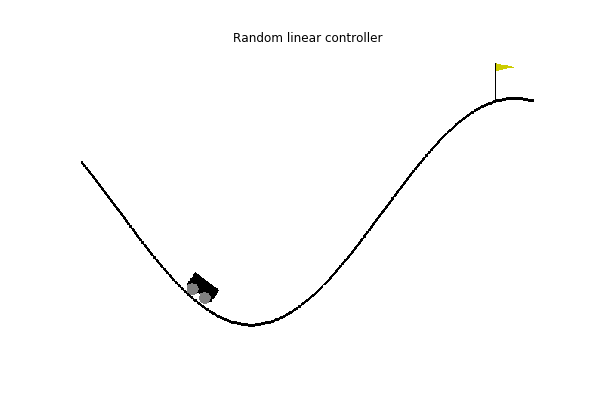
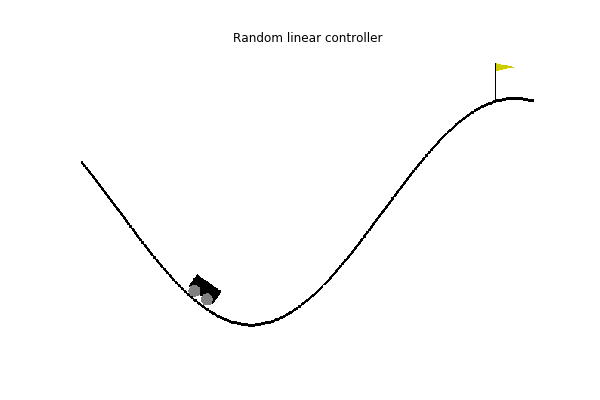
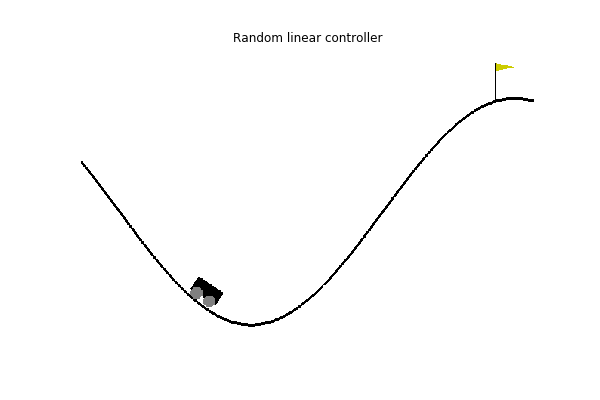
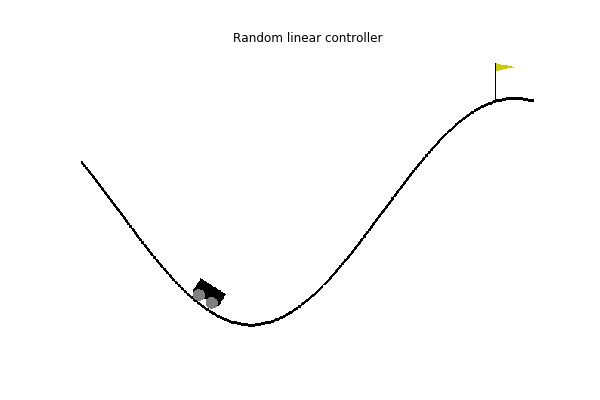
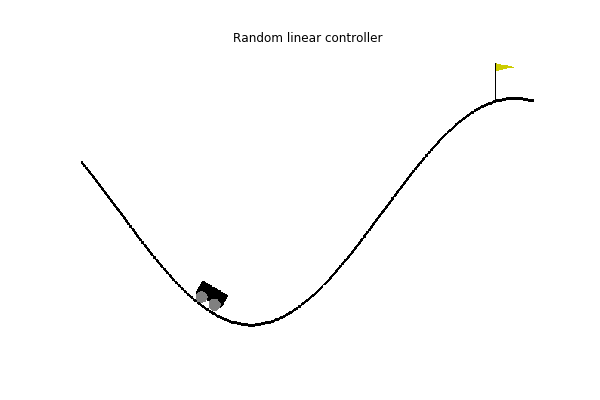
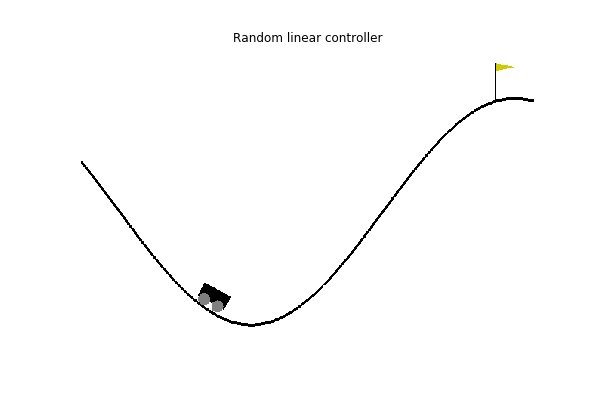
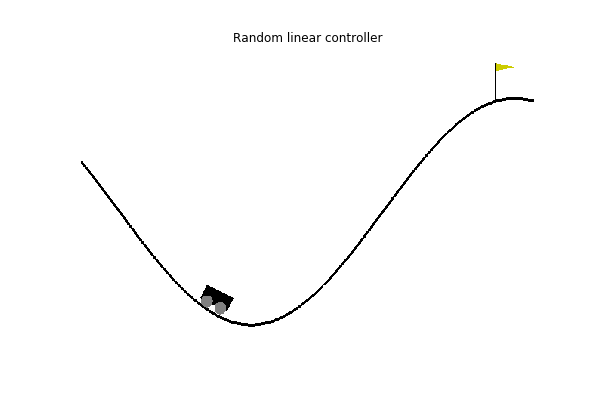
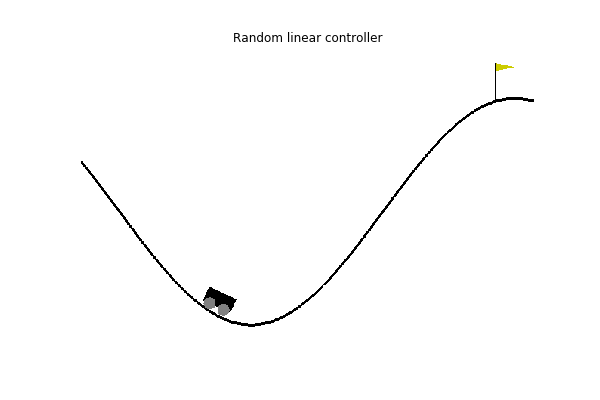
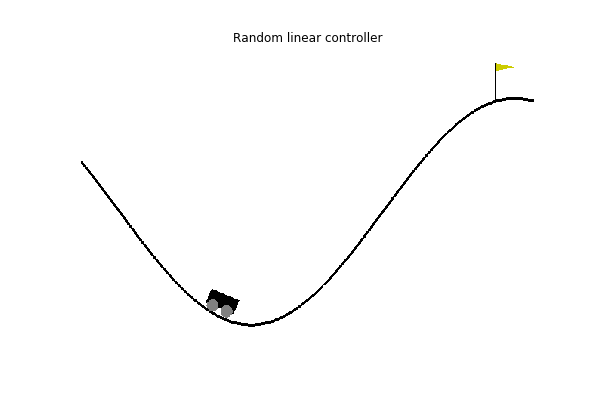
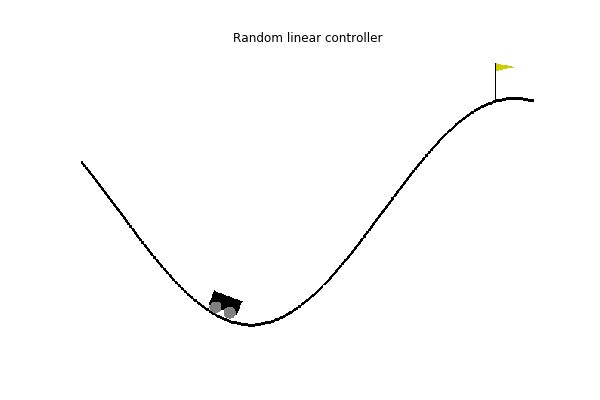
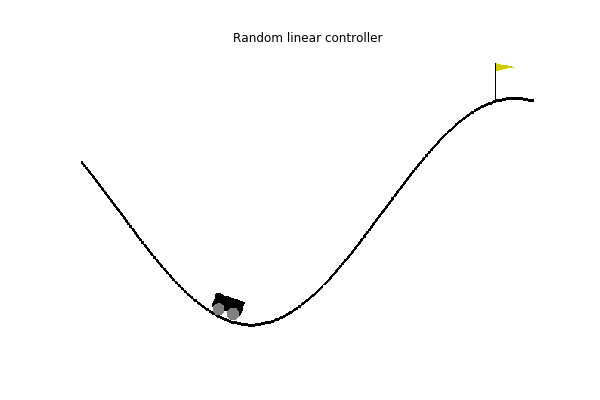
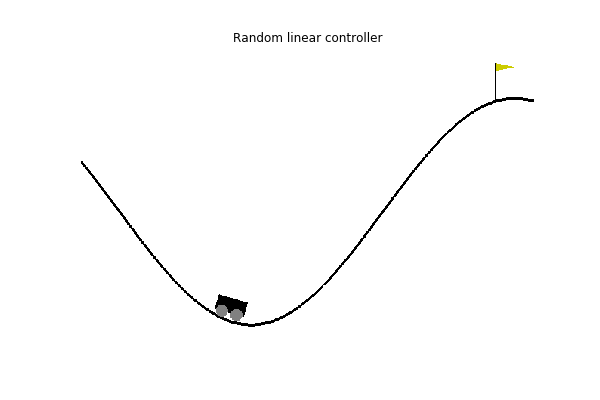
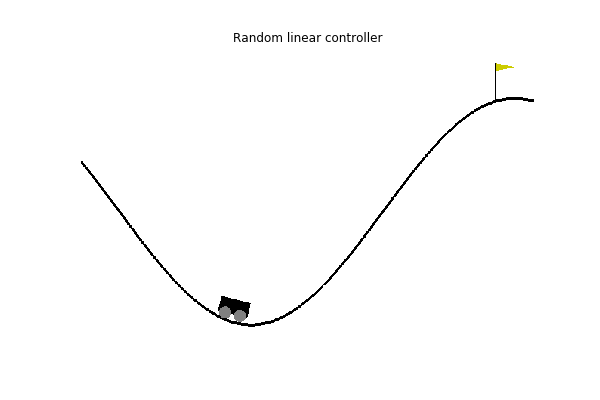
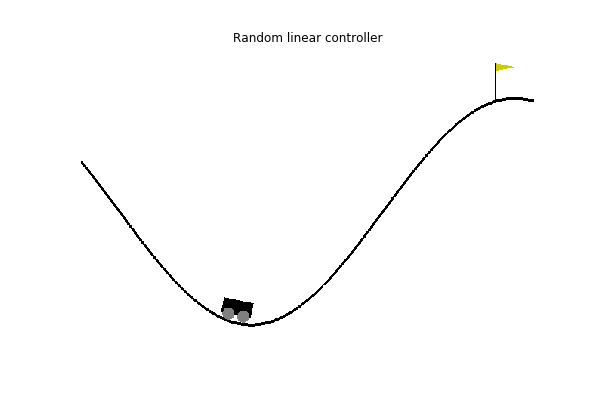
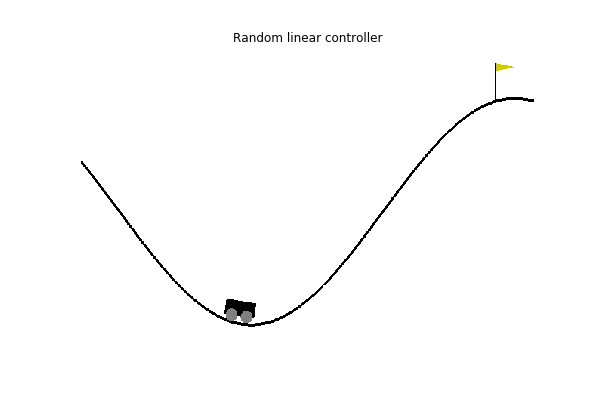
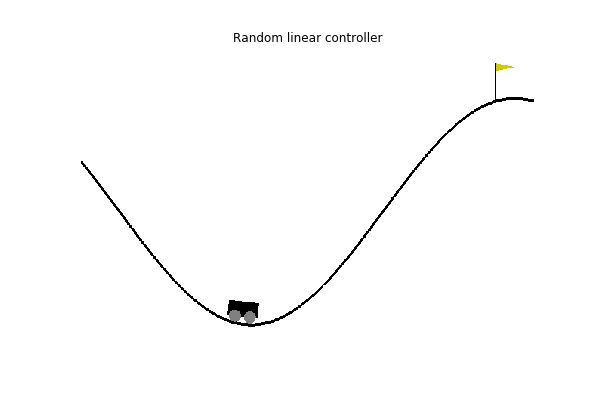
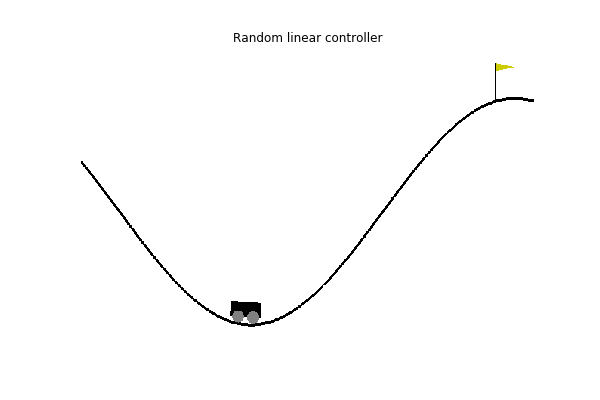
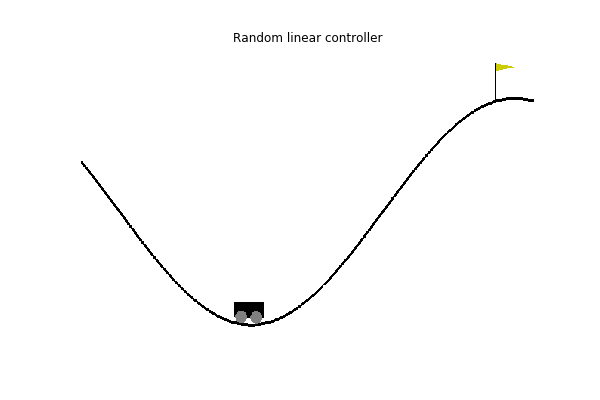
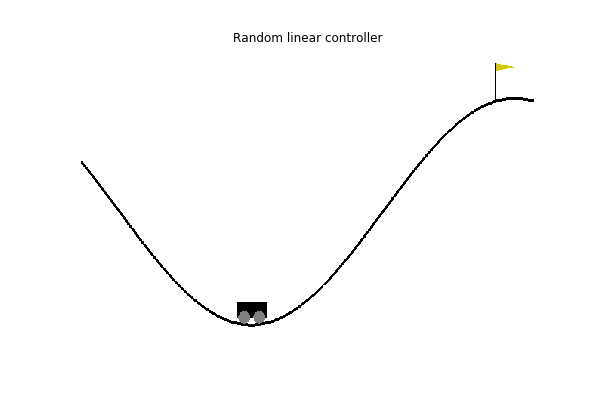
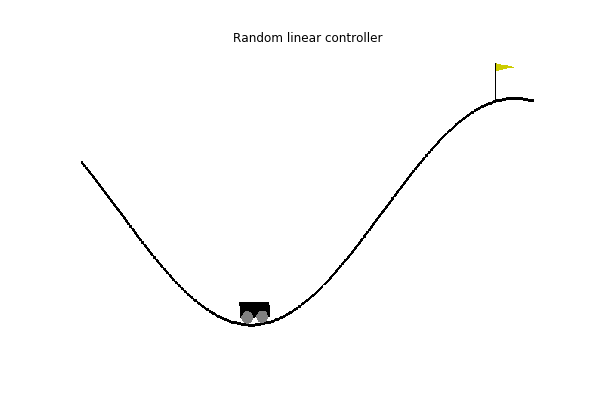
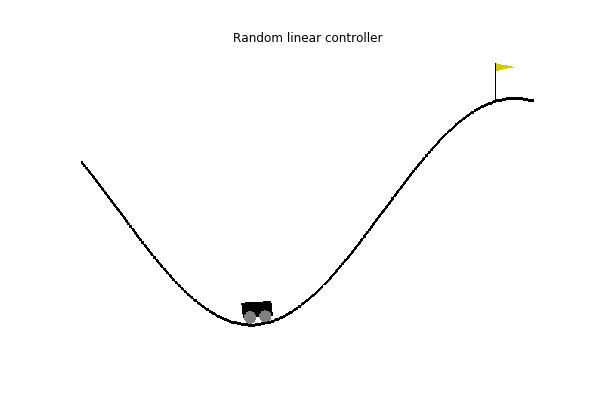
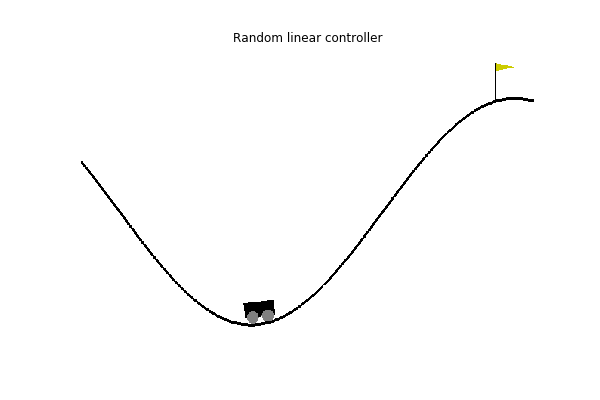
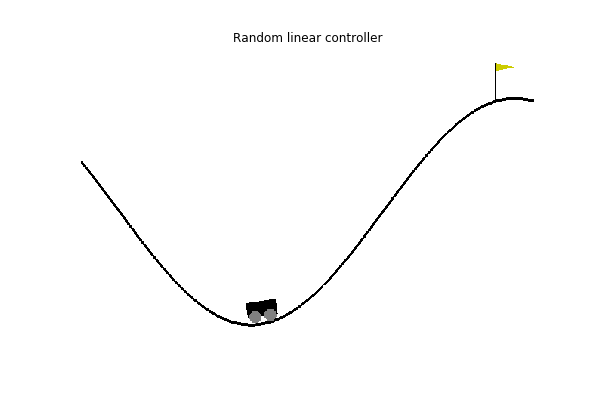
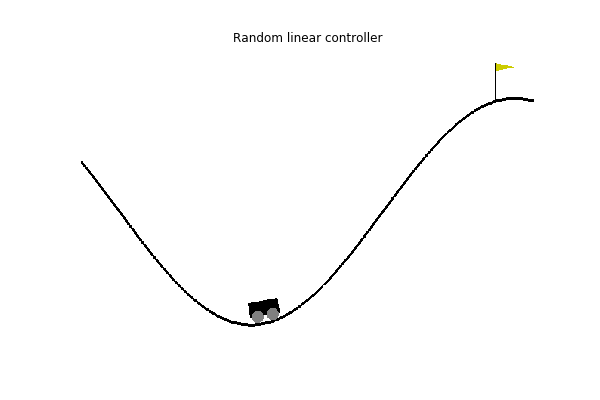
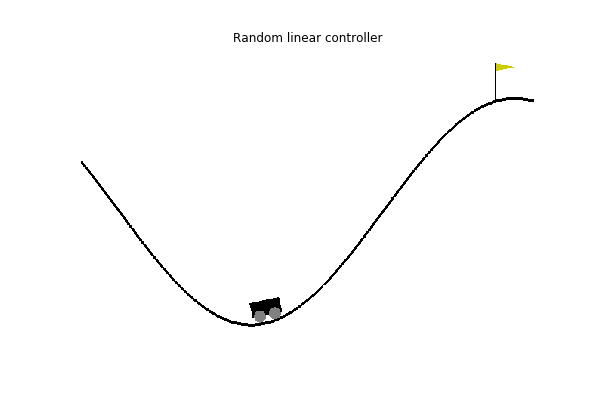
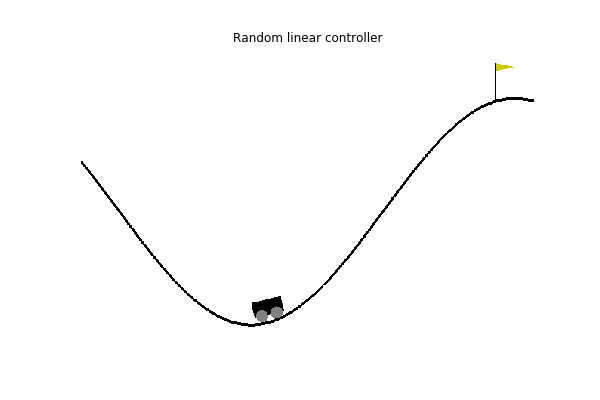
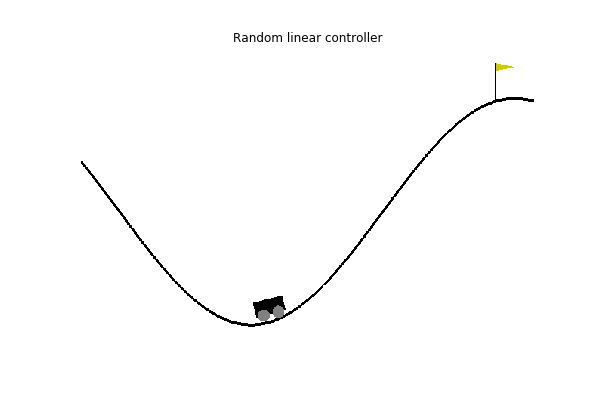
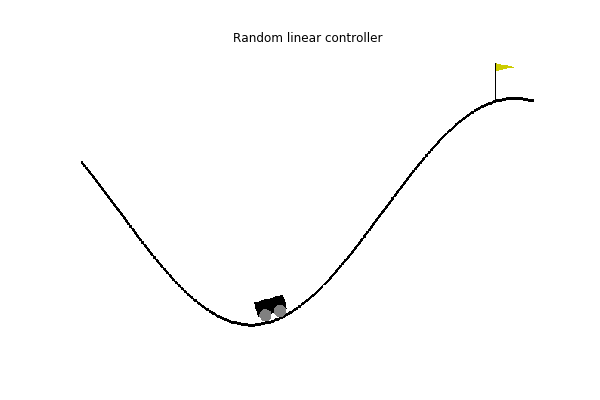
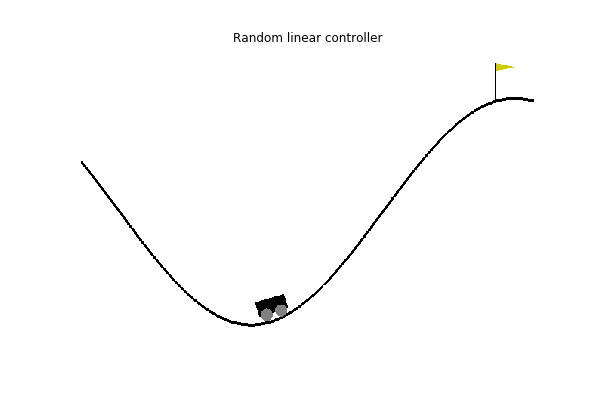
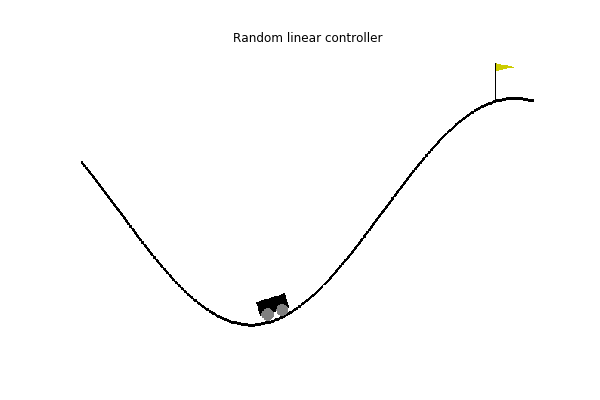
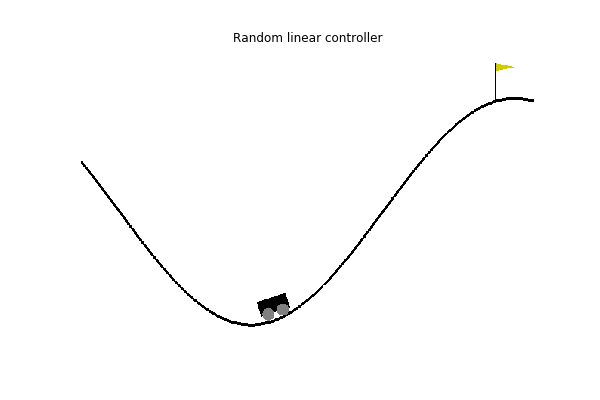
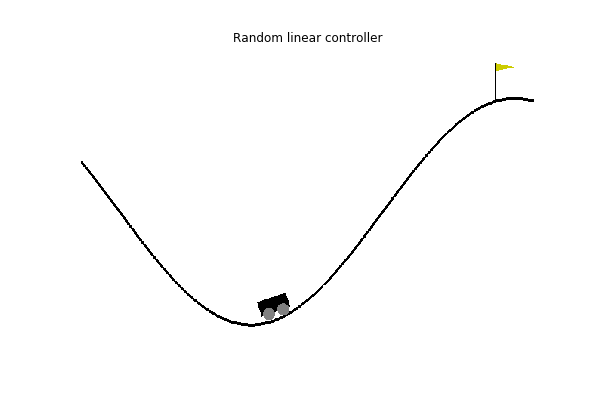
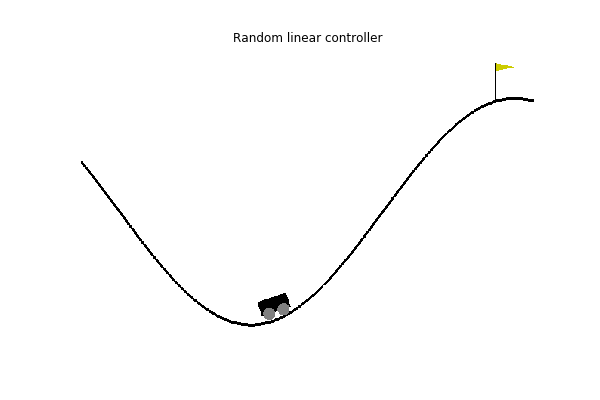
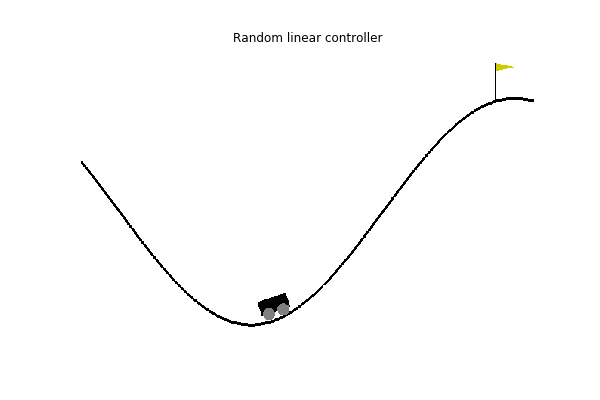
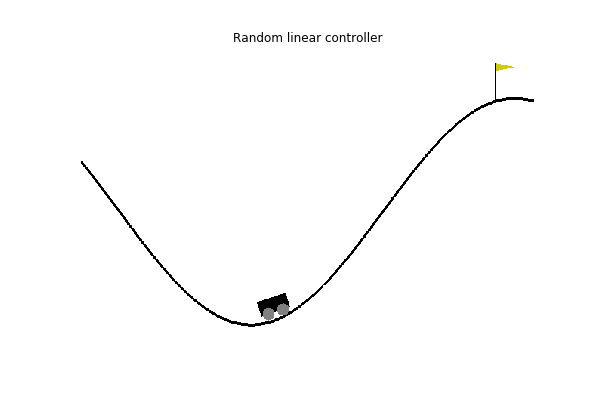
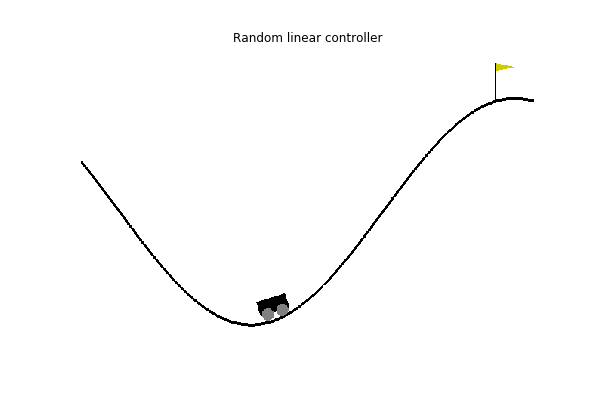
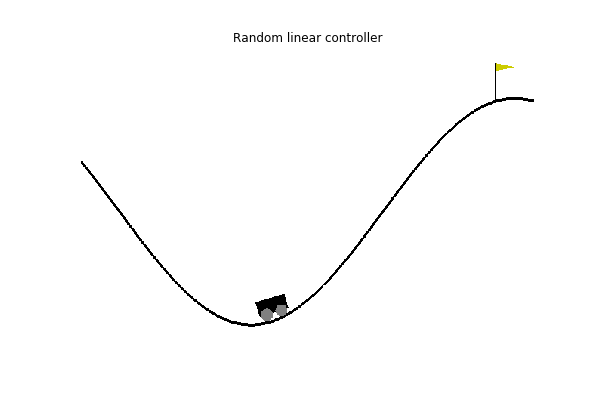
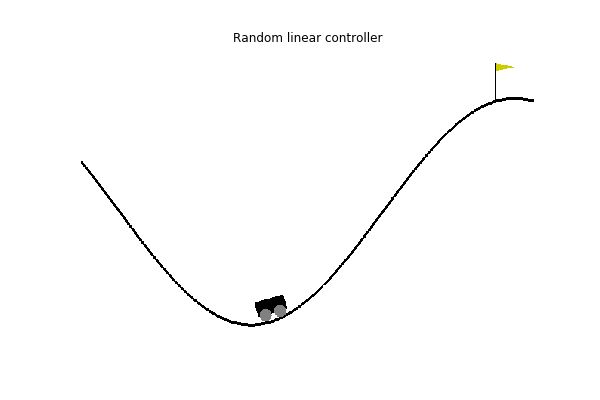
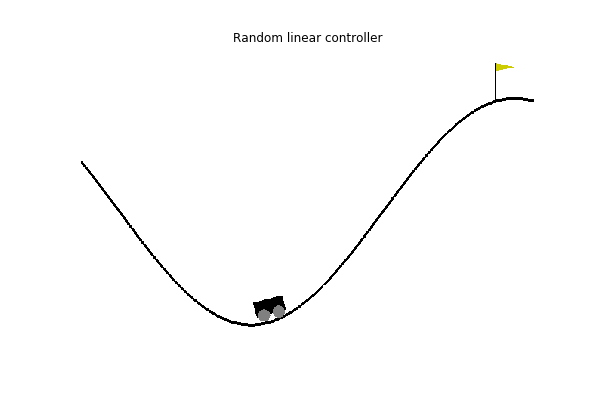
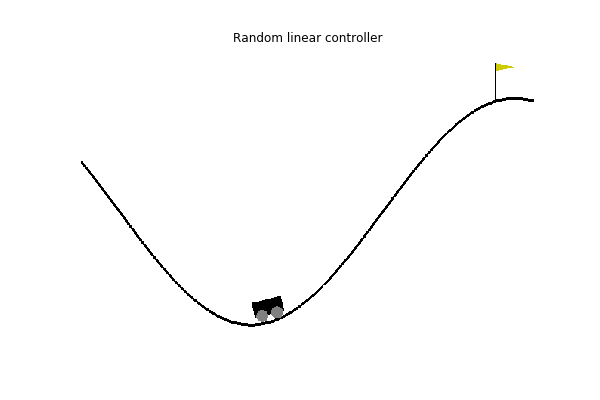
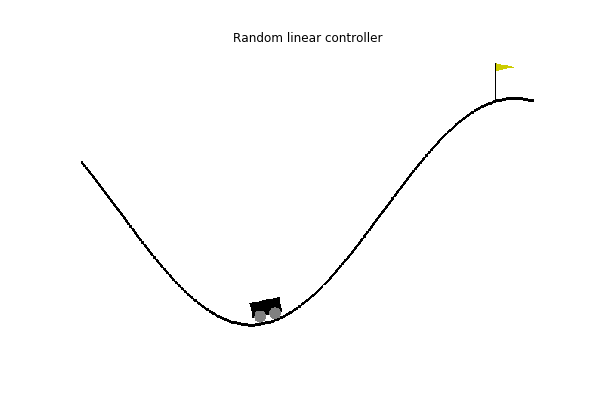
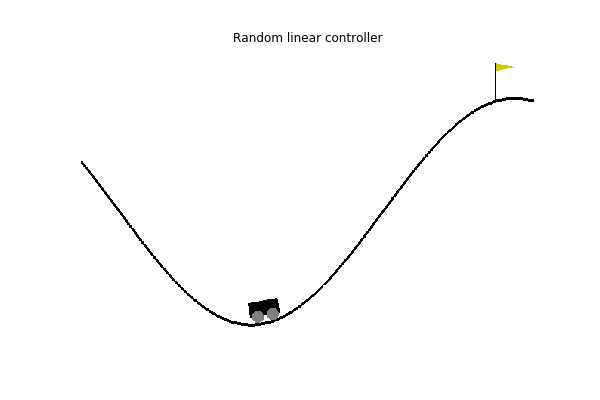
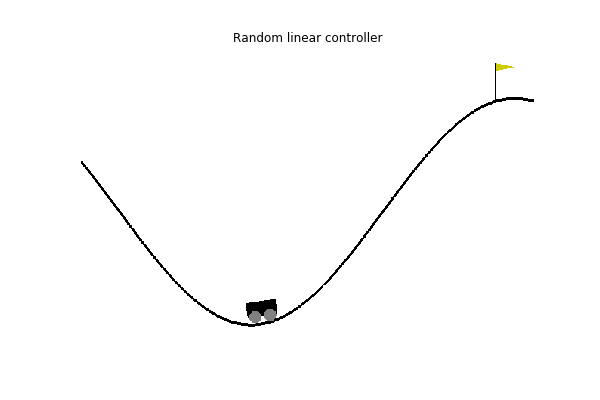
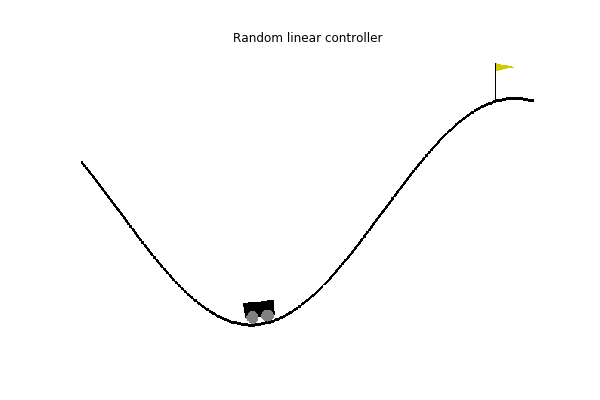
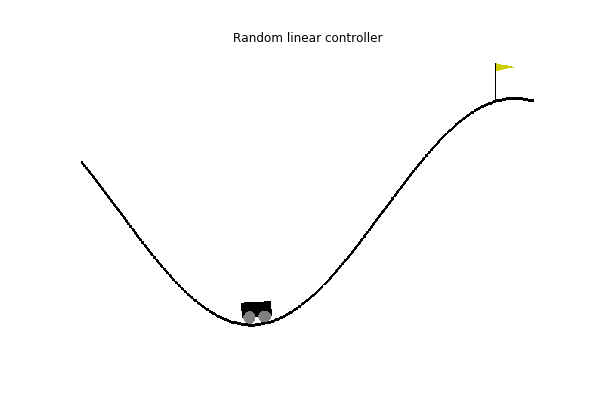
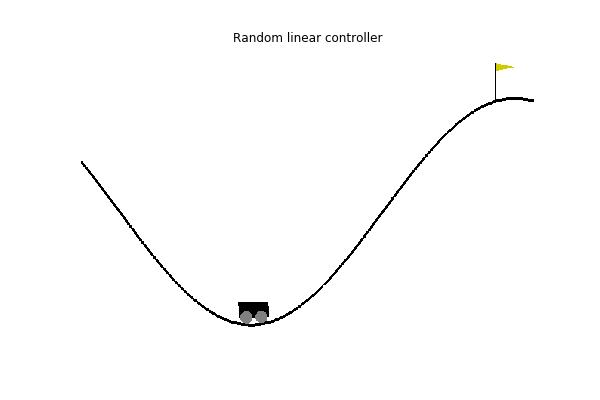
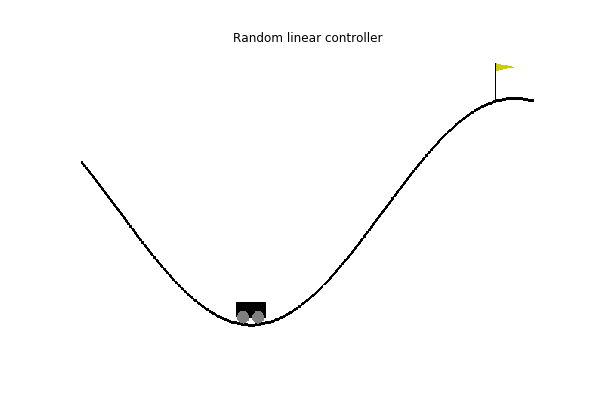
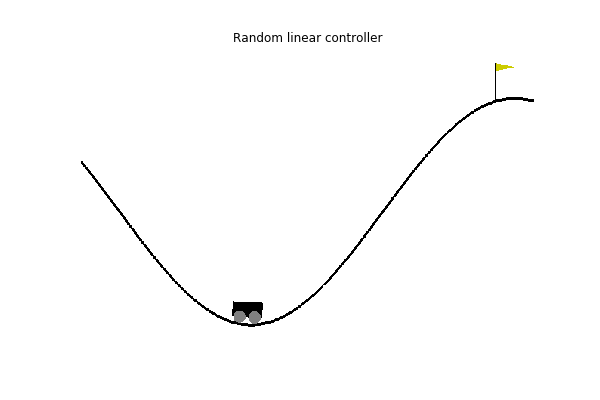
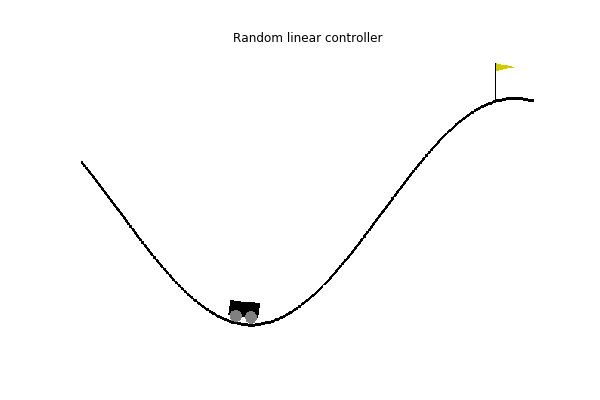
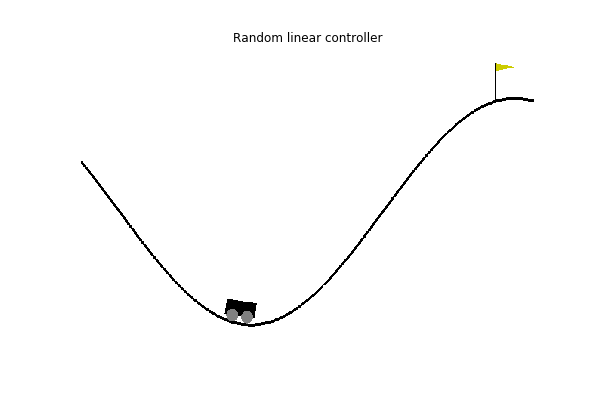
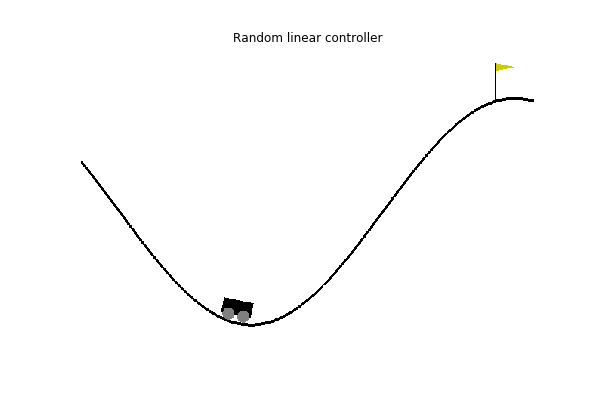
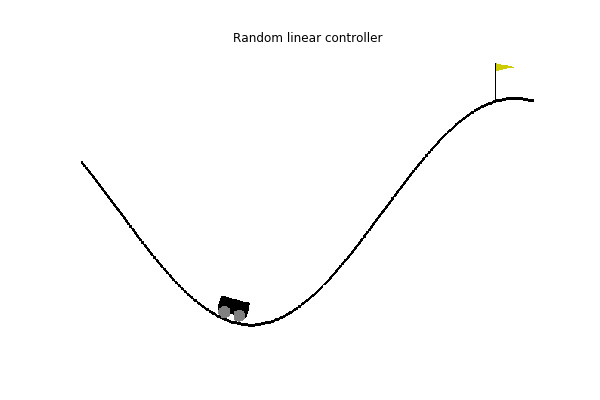
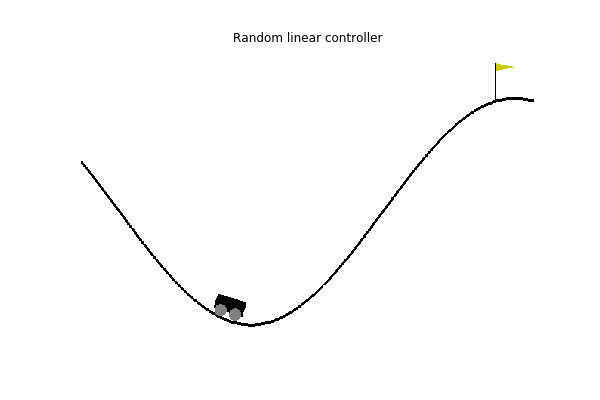
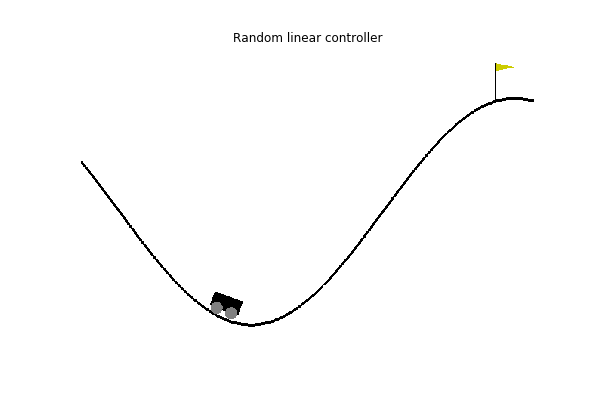
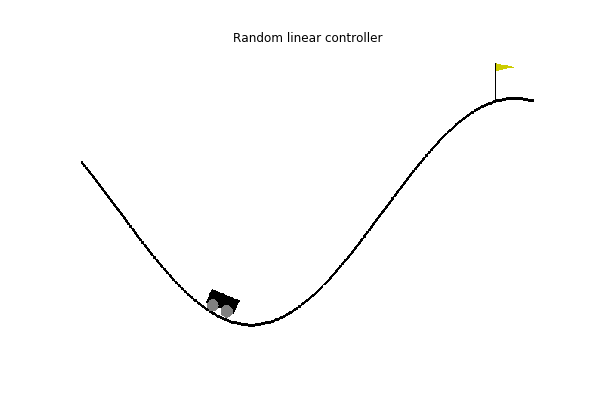
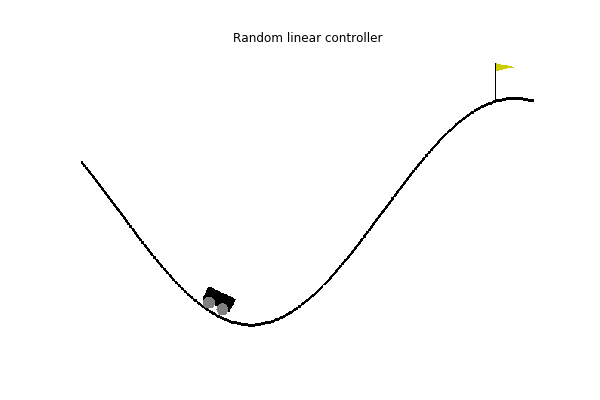
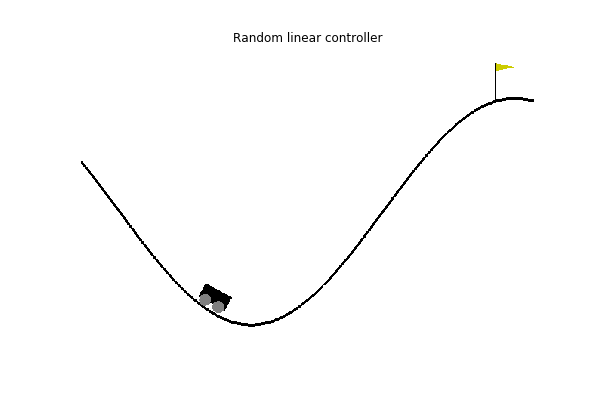
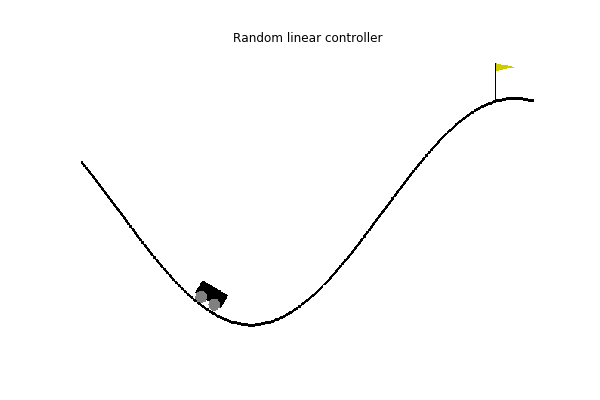
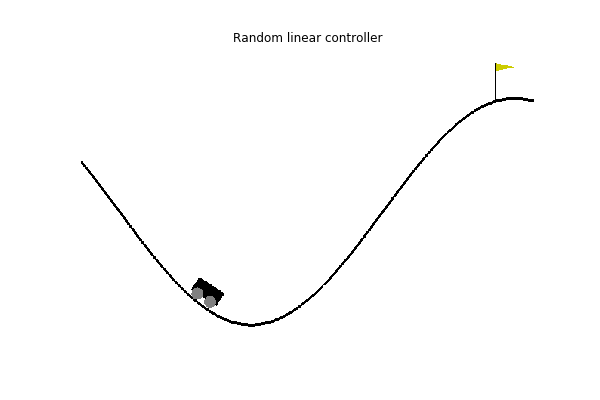
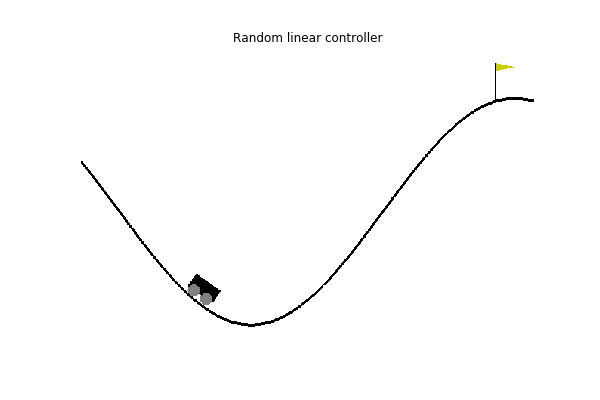
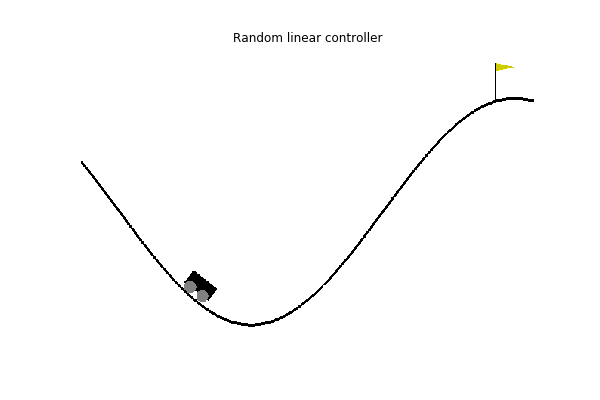
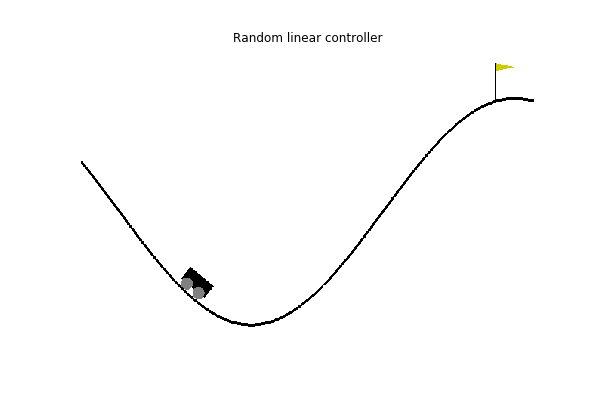
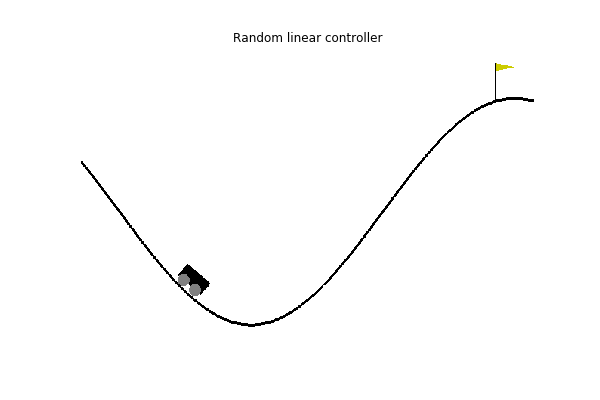
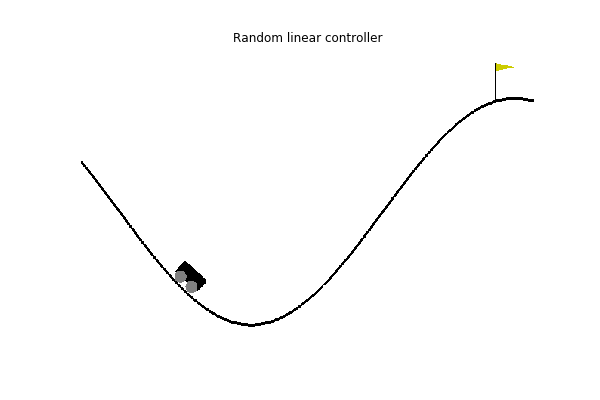
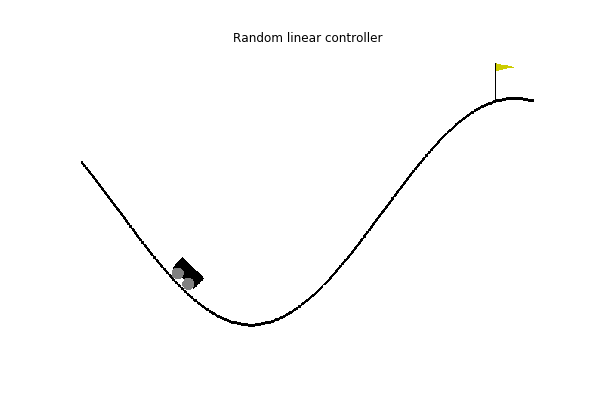
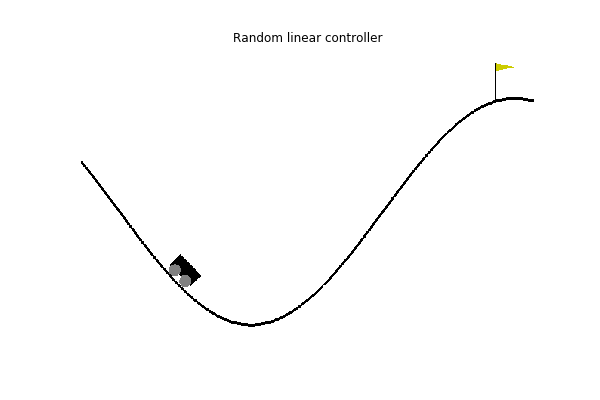
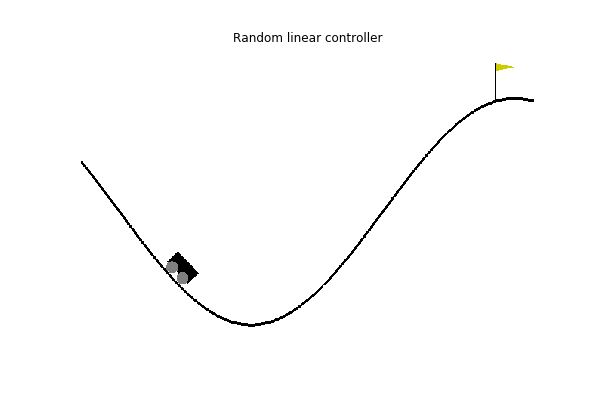
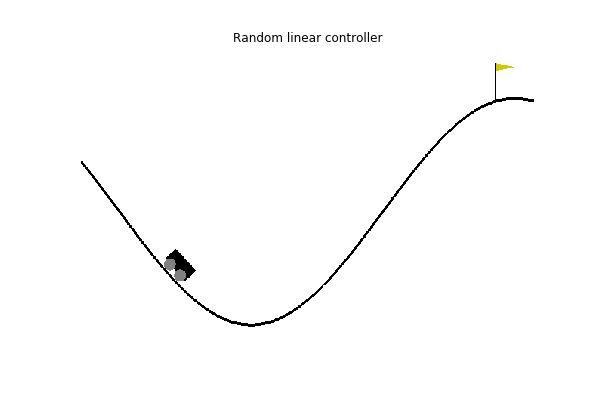
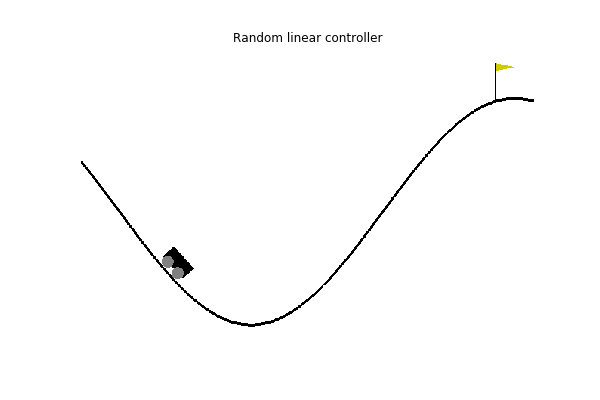
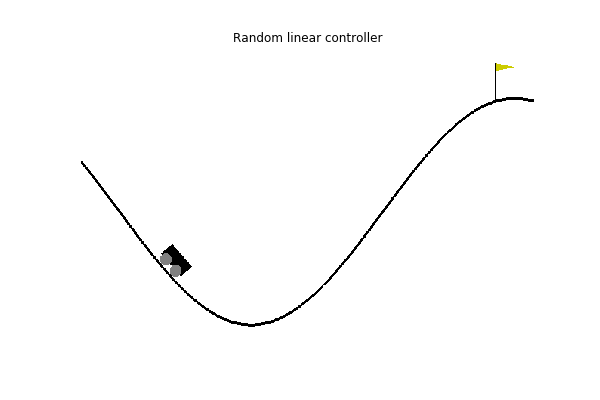
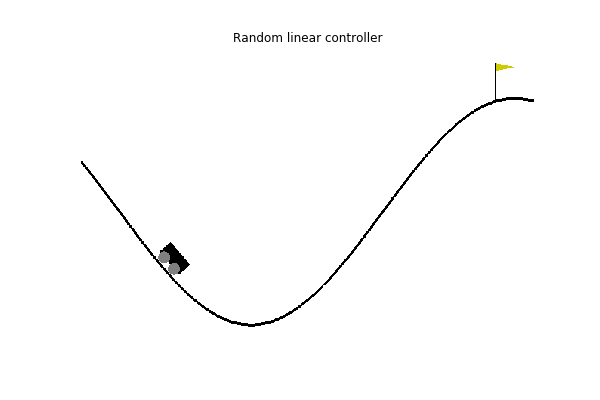
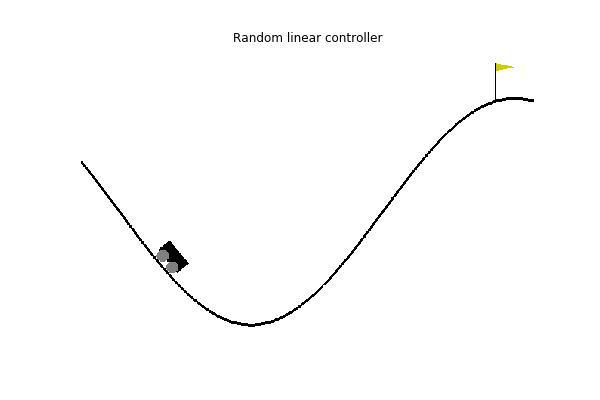
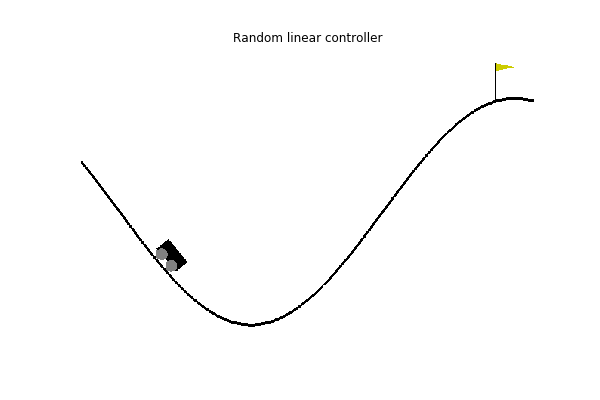
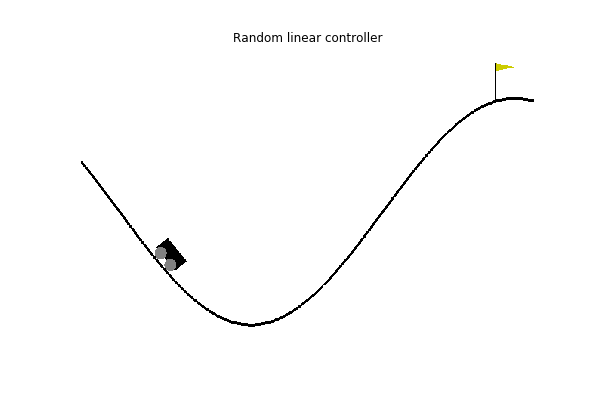
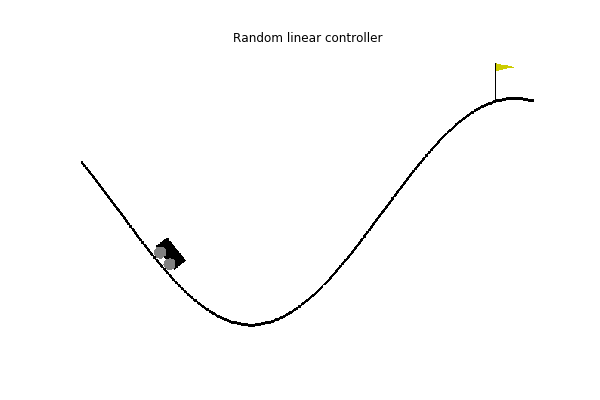
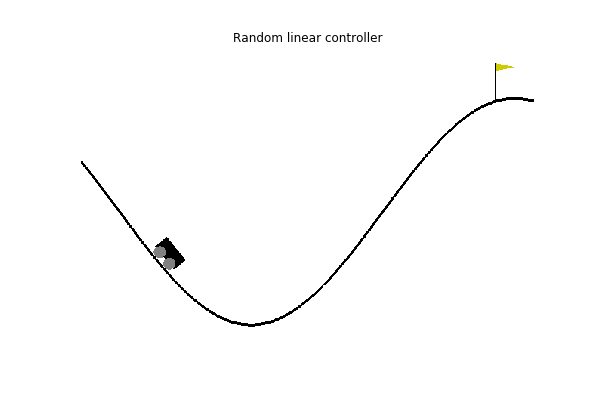
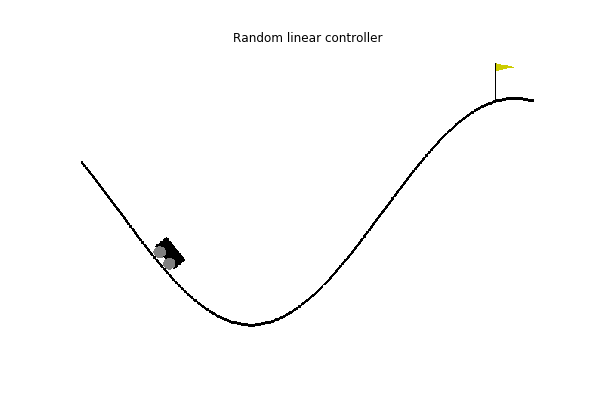
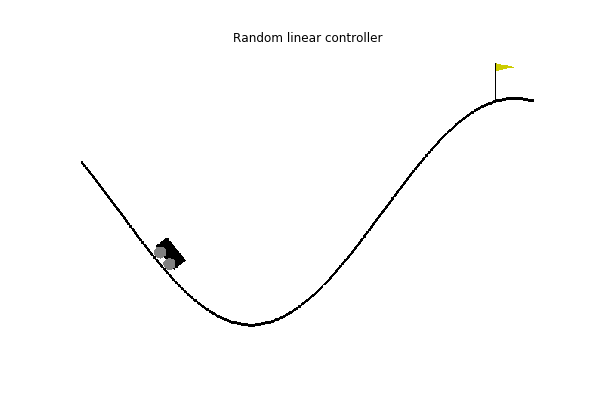
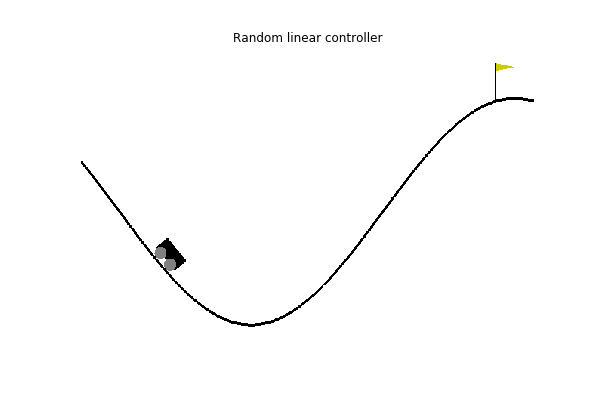
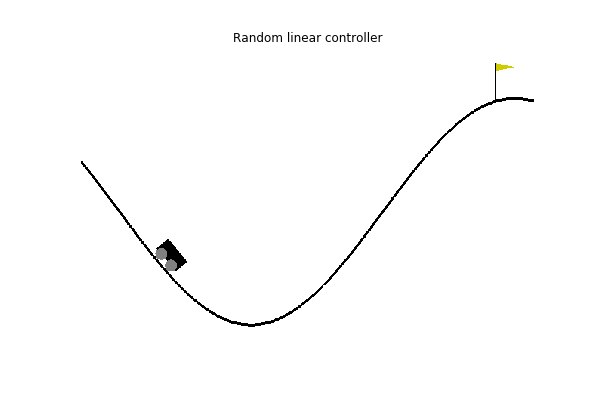
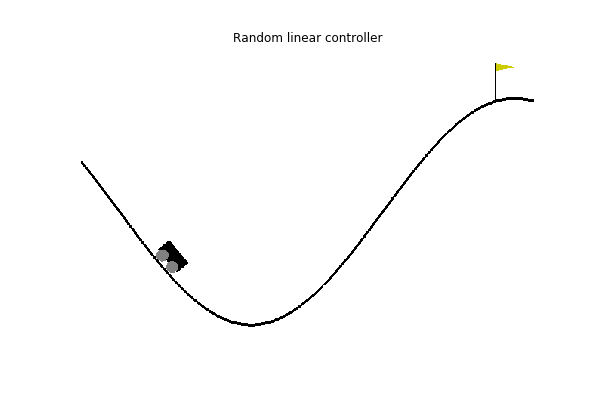
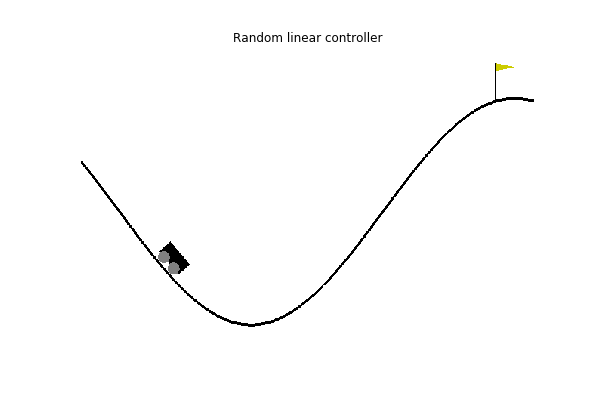
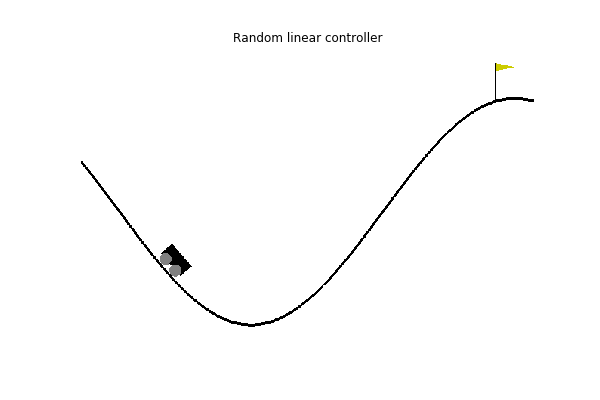
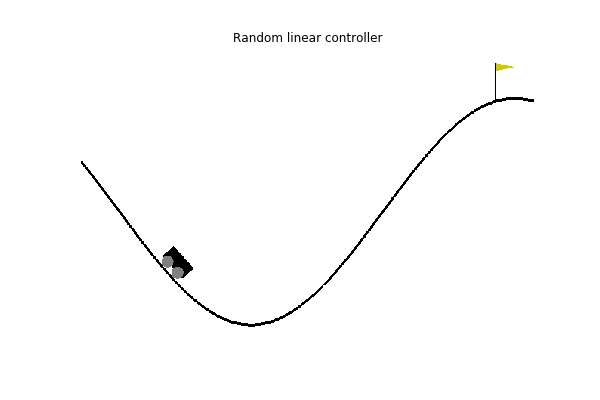
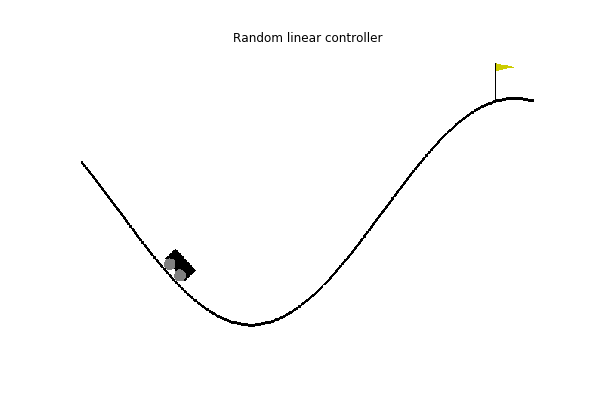
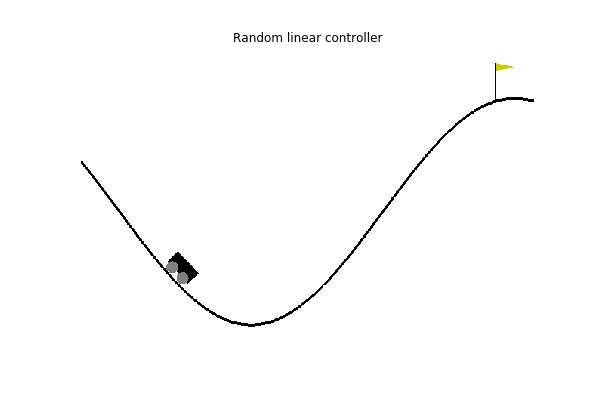
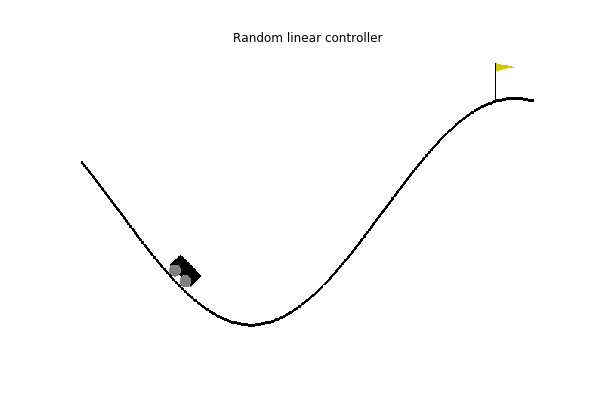
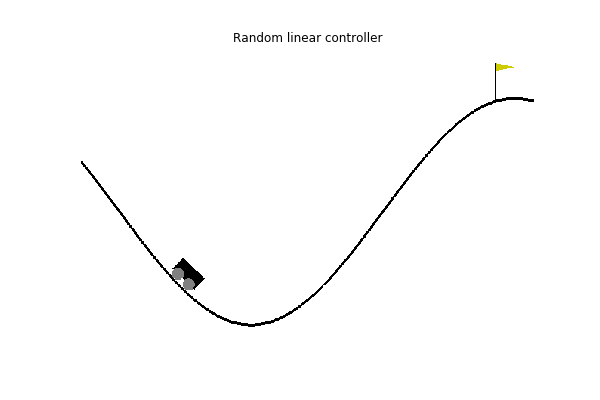
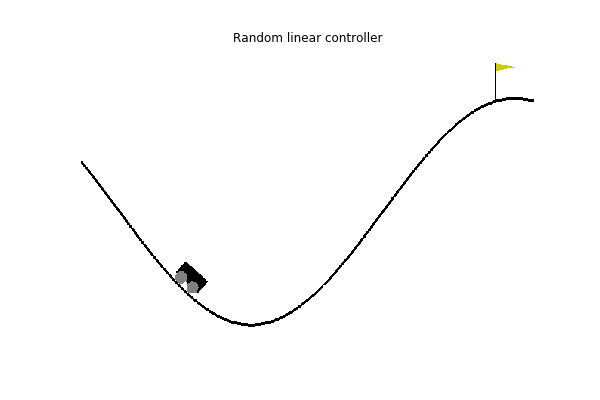
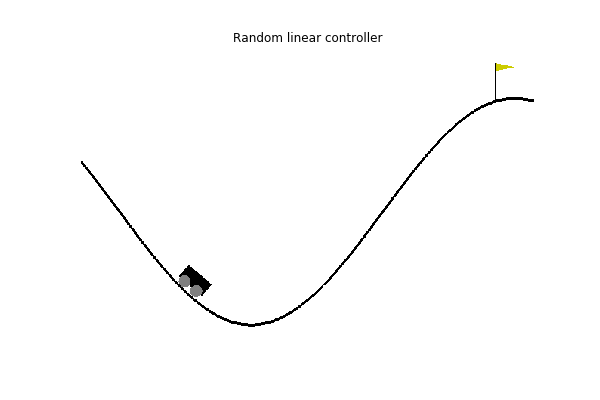
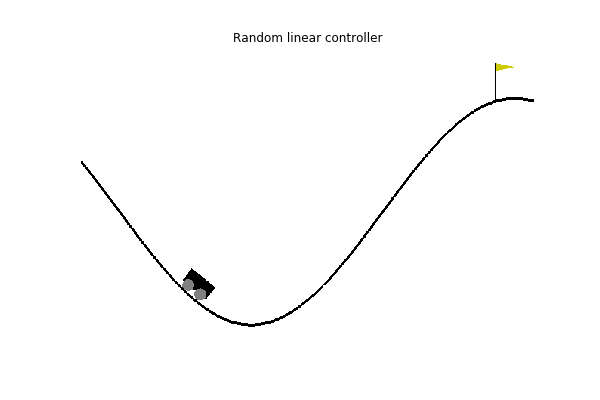
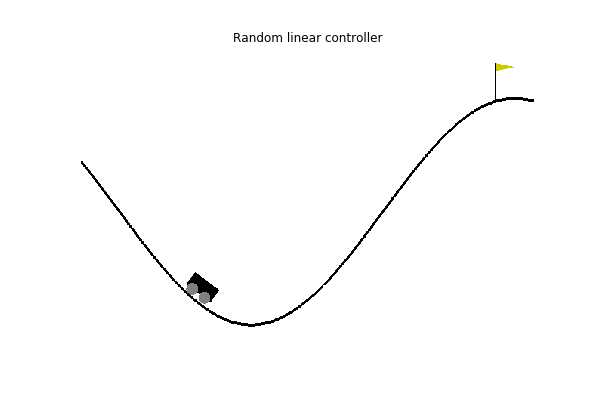
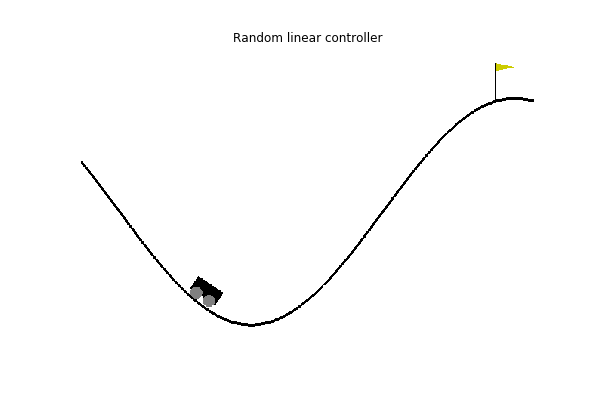
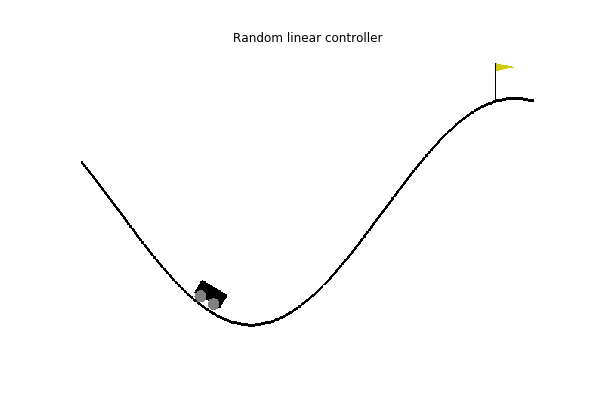
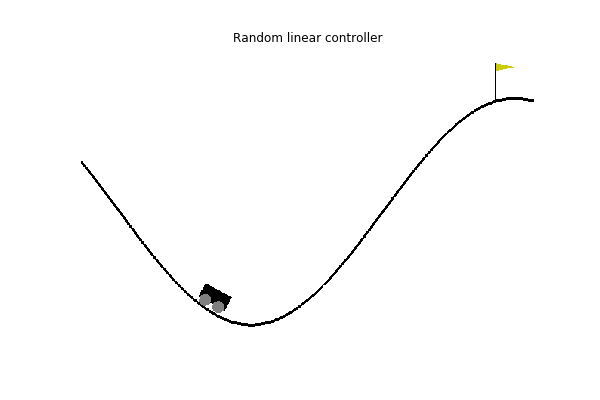
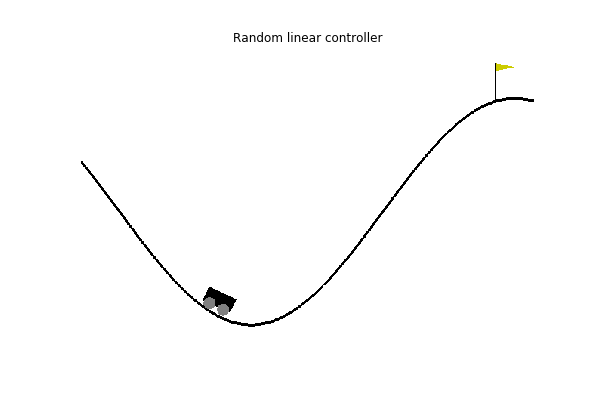
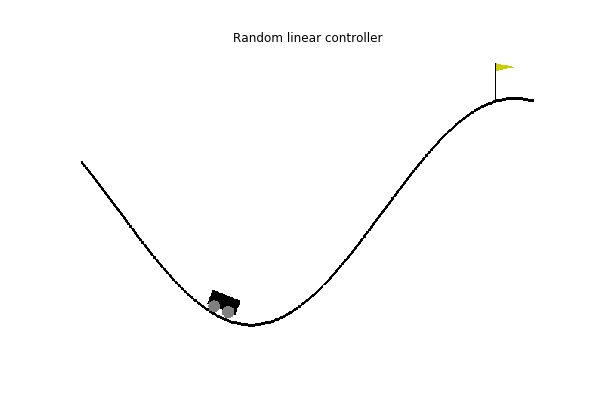
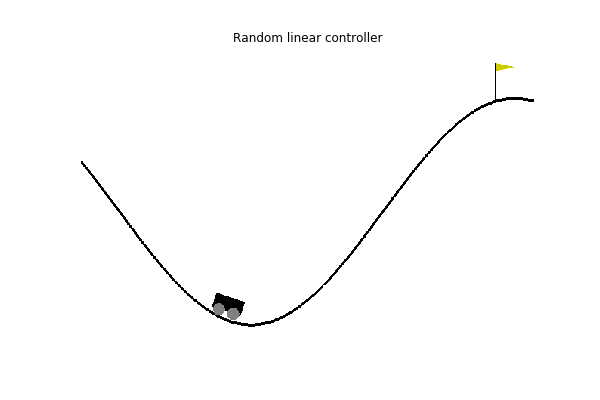
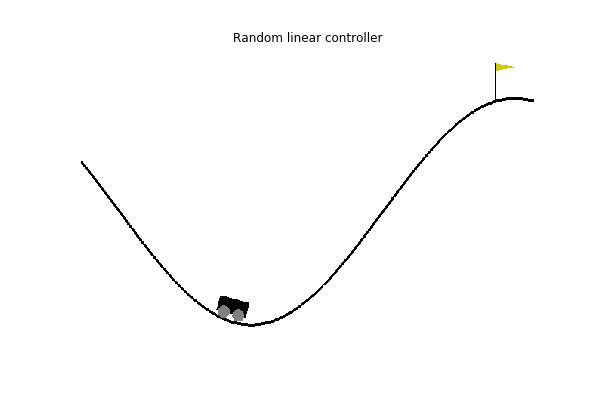
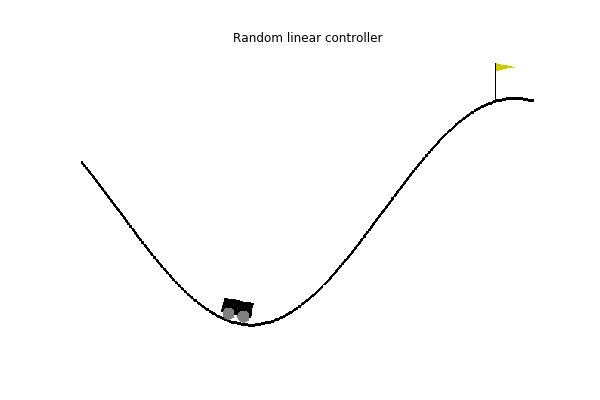
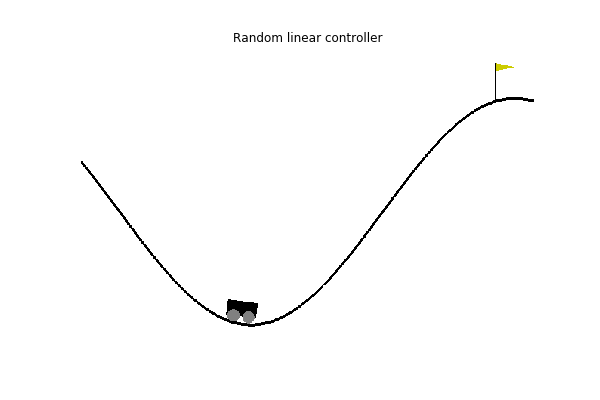
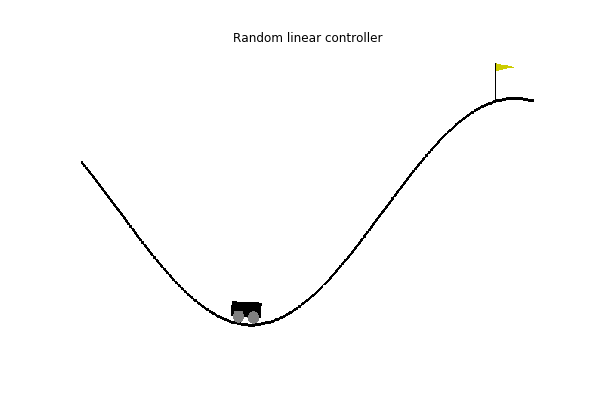
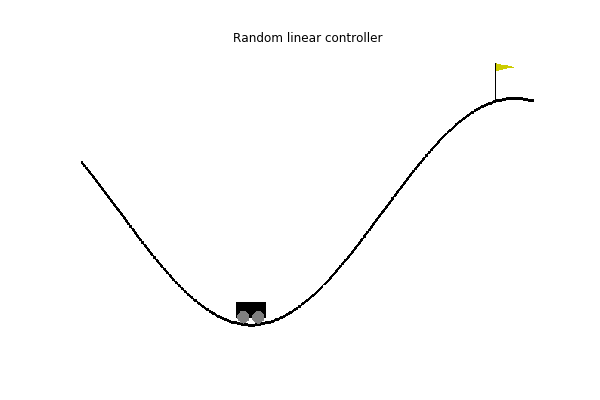
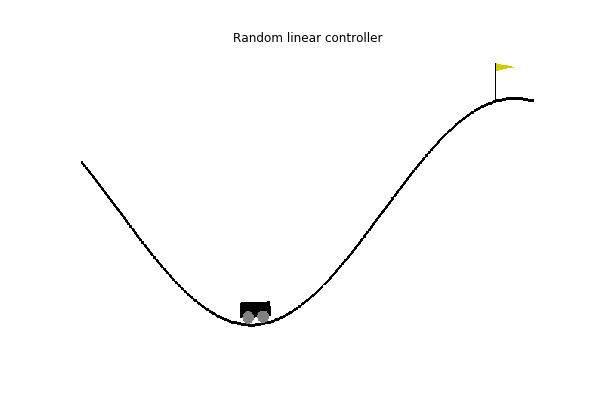
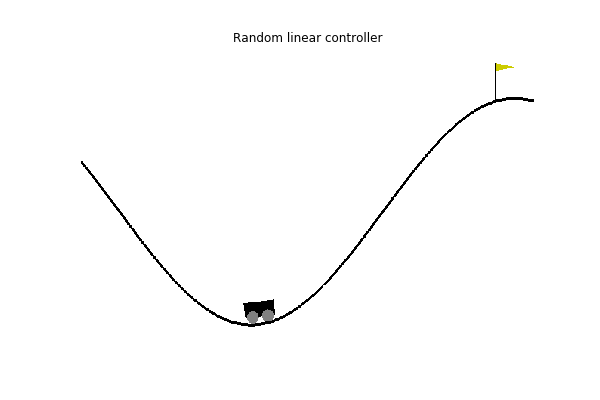
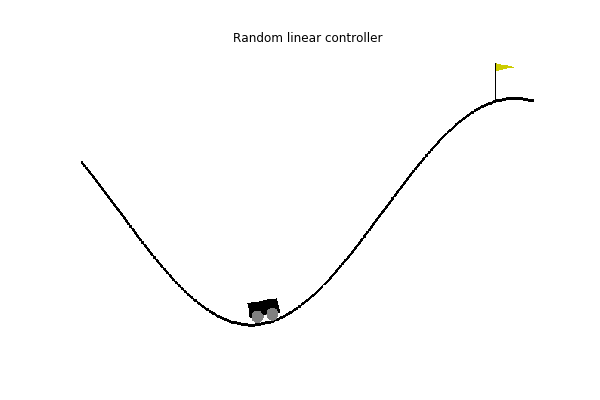
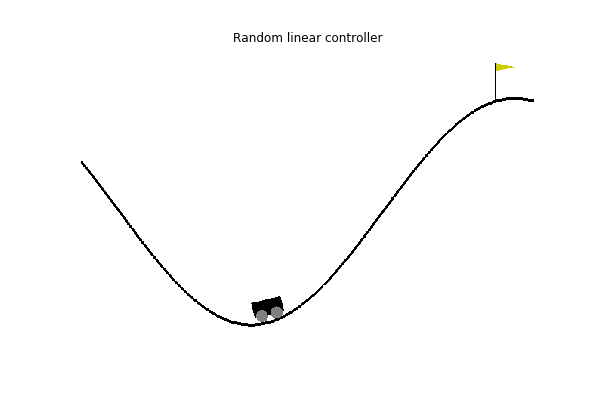
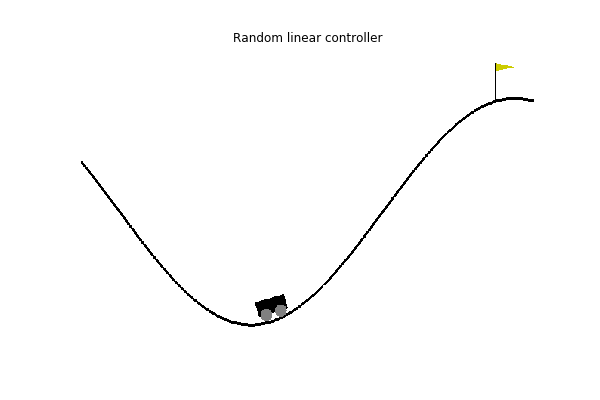
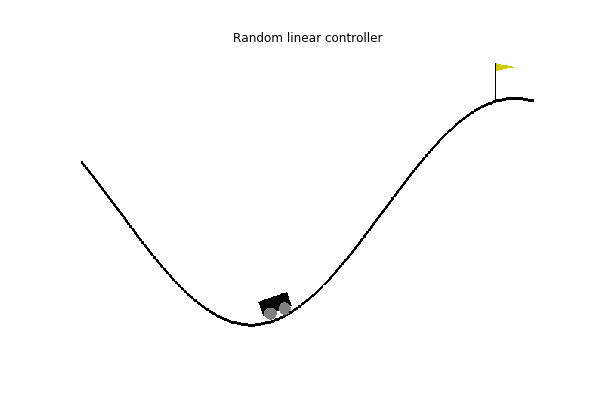
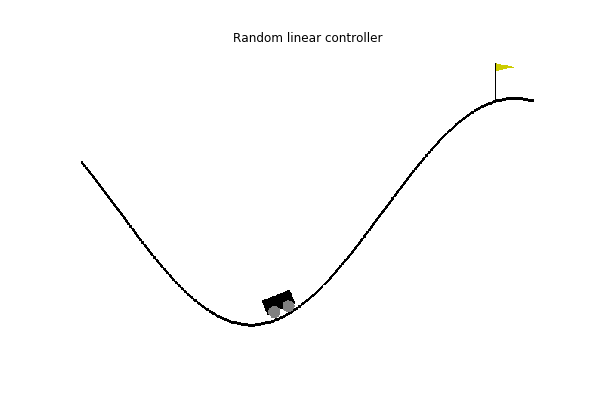
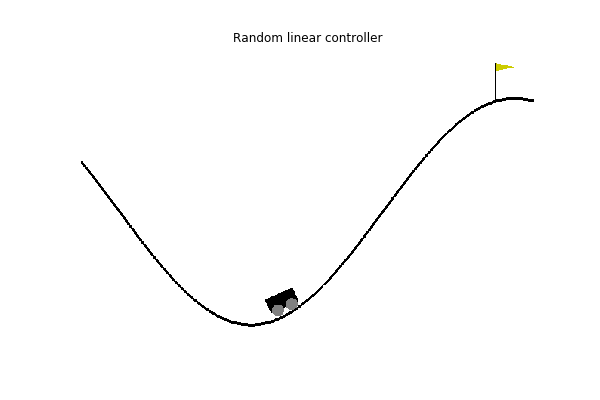
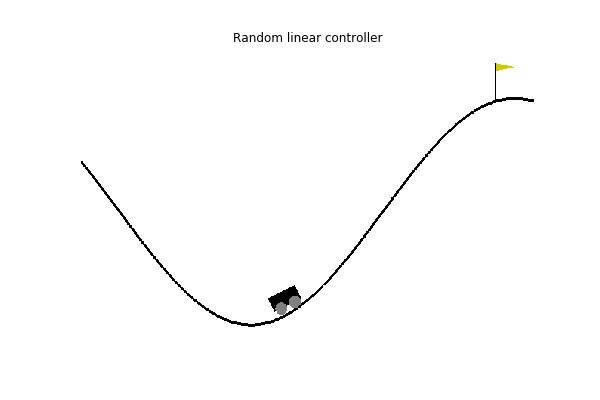
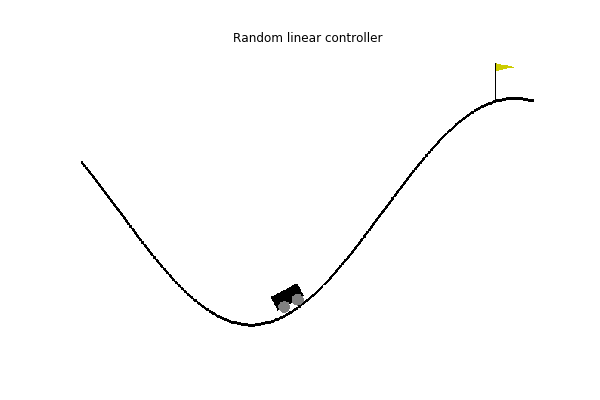
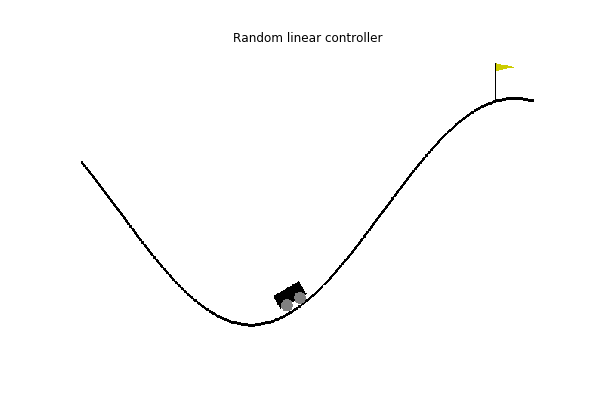
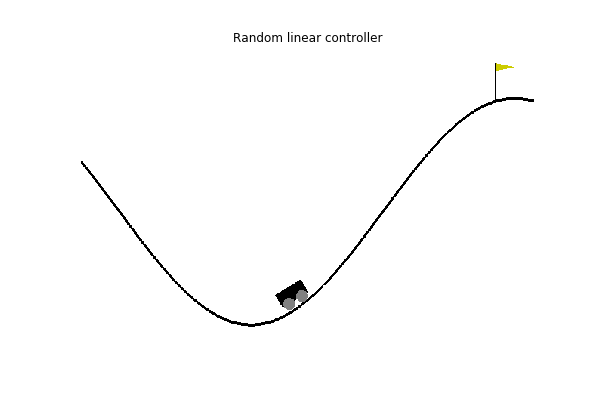
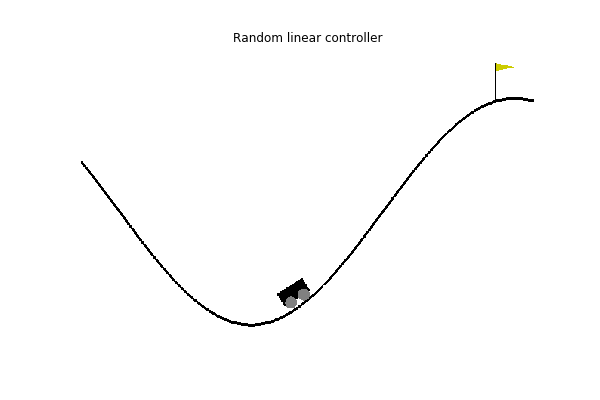
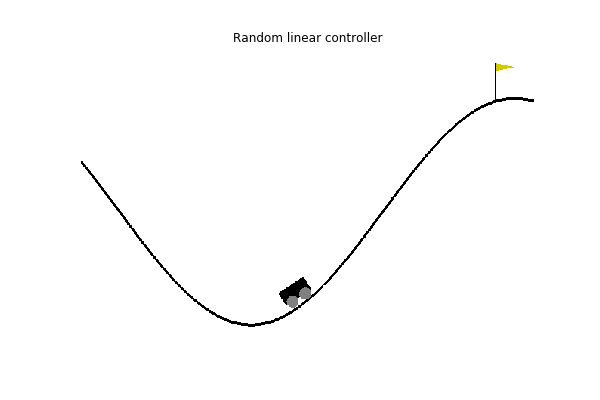
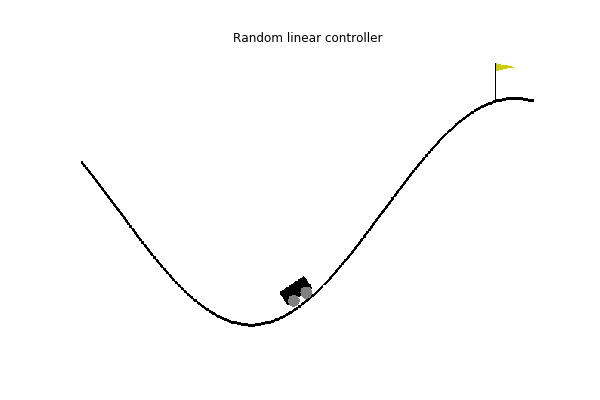
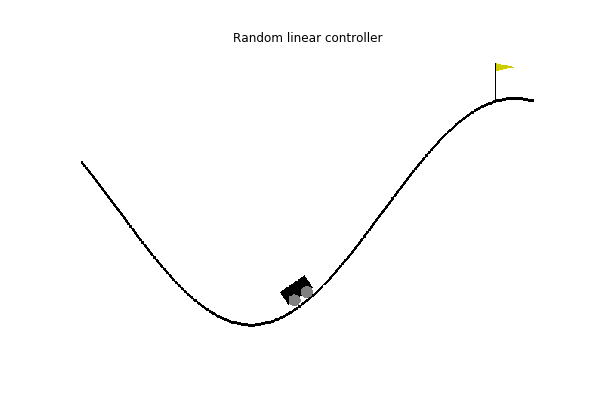
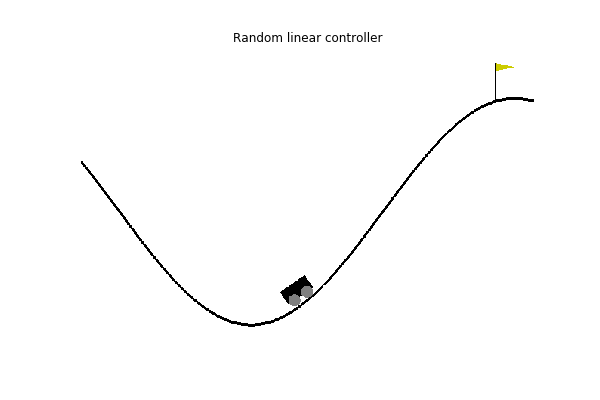

In [6]:
random_controller = X[0,:]
_, _, _, frames = mc.run_simulation(env, np.atleast_2d(random_controller), render=True)
mc.display_frames_as_gif(frames, 'Random linear controller')

As we can see the random linear controller does not manage to push the car to the top of the mountain. Now, let's optimize the regret using Bayesian optimization and the emulator for the reward. We try 50 new parameters chosen by the EI. We first create a GP model mapping controler parameters to rewards.

In [7]:
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

Y = reward_function(X)
kernel = GPy.kern.Matern52(3)
model_gpy = GPRegression(X,Y,kernel = kernel) 
model_gpy.Gaussian_noise.constrain_fixed(1e-8)  ## exact evaluations of the objective
model_gpy.optimize_restarts(5)
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

Optimization restart 1/5, f = 172.43871444749468
Optimization restart 2/5, f = 172.43871444747617
Optimization restart 3/5, f = 172.43871444748956
Optimization restart 4/5, f = 172.43871444747572
Optimization restart 5/5, f = 172.43871444765102


In Bayesian optimization an acquisition function is used to balance exploration and exploitation to evaluate new locations close to the optimum of the objective. In this notebook we select the expected improvement (EI). For further details have a look to the review paper of [Shahriari et al (2015)](http://www.cs.ox.ac.uk/people/nando.defreitas/publications/BayesOptLoop.pdf).

In [8]:
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement

expected_improvement = ExpectedImprovement(model = model_emukit)

In [9]:
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

bayesopt_loop = BayesianOptimizationLoop(model = model_emukit,
                                         space = parameter_space,
                                         acquisition = expected_improvement,
                                         batch_size = 1)

Now we run the loop for 50 extra evaluations.

In [10]:
from emukit.core.loop import FixedIterationsStoppingCondition

num_evaluations = 50
stopping_condition = FixedIterationsStoppingCondition(i_max = num_evaluations)
bayesopt_loop.run_loop(reward_function, stopping_condition)

Now we visualize the result for the best controller that we have found with Bayesian optimization.


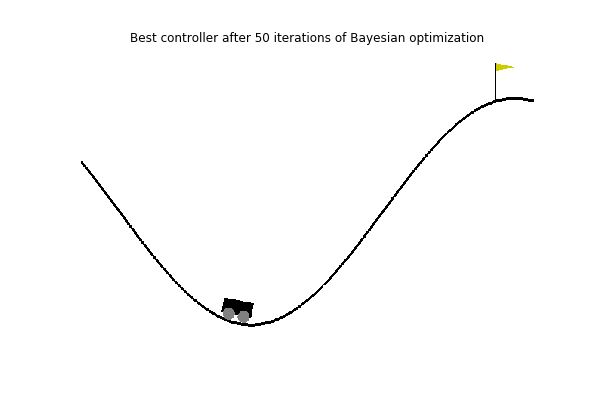
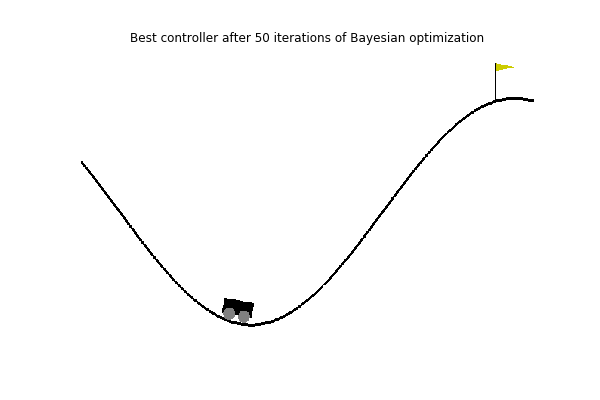
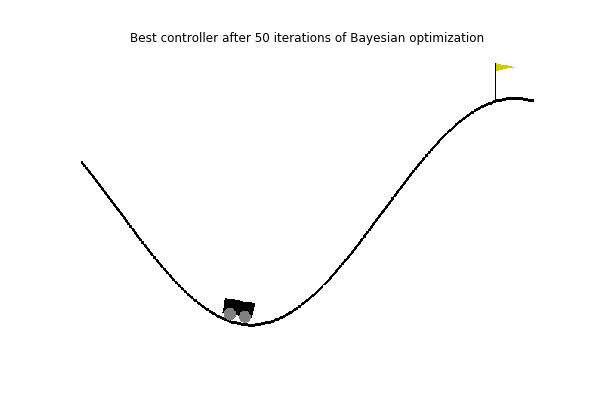
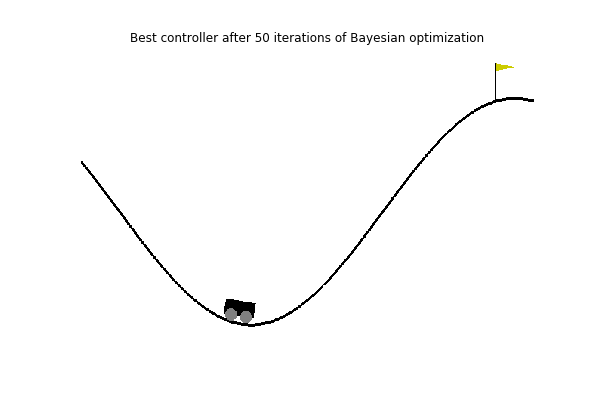
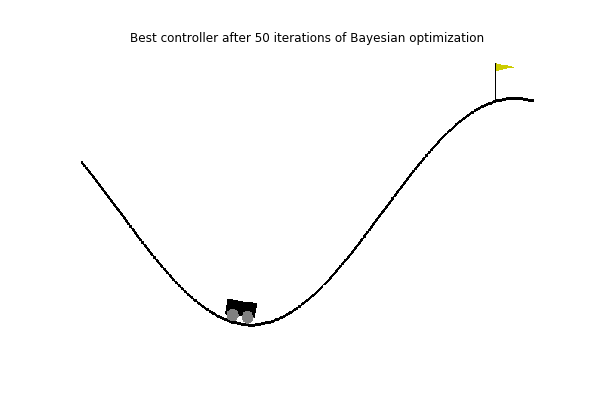
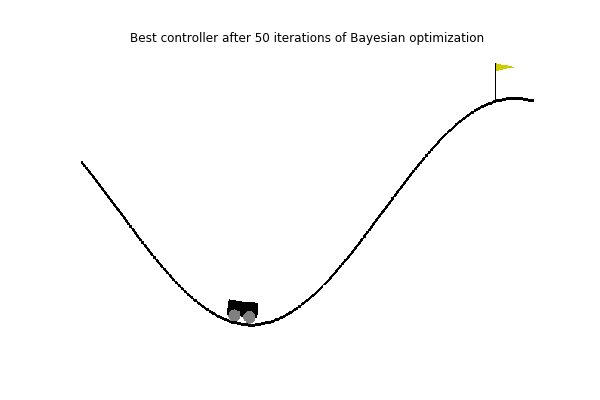
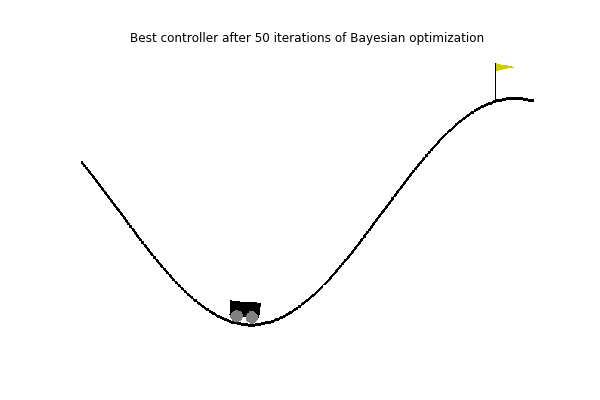
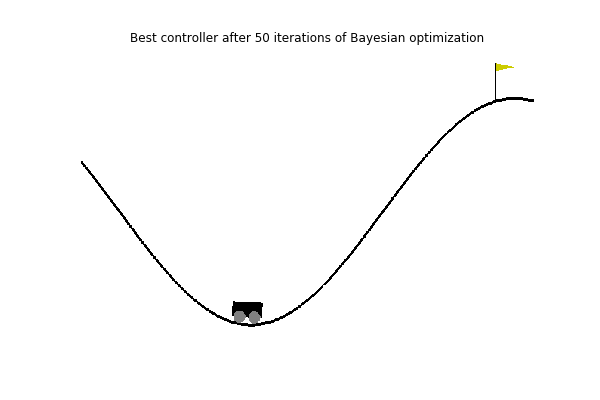
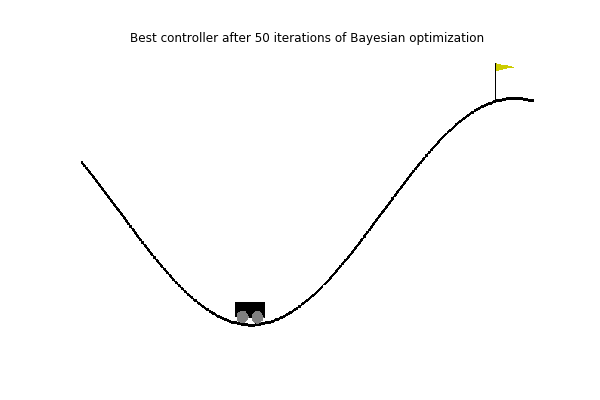
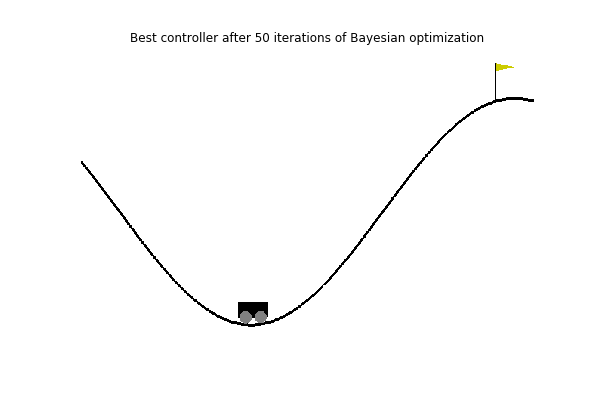
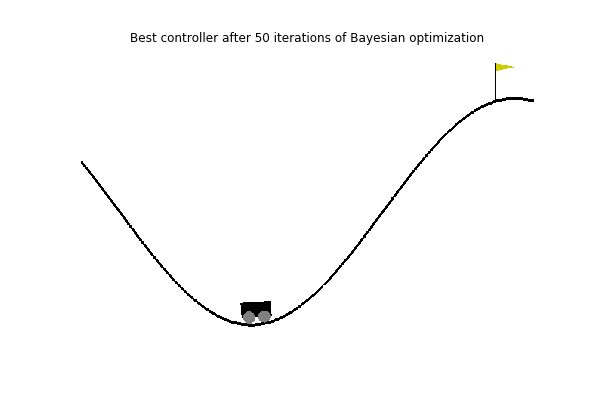
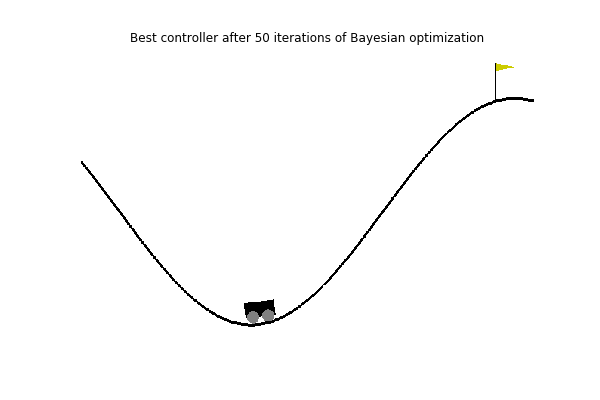
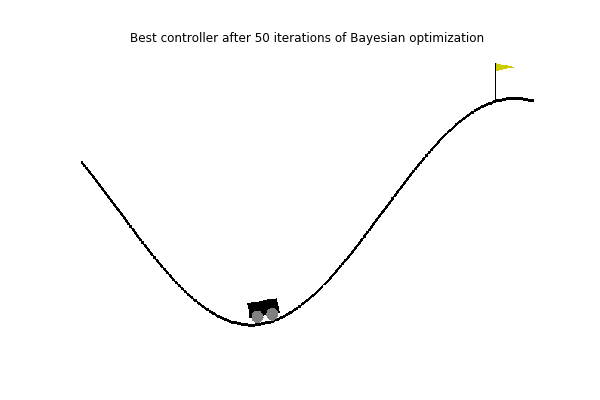
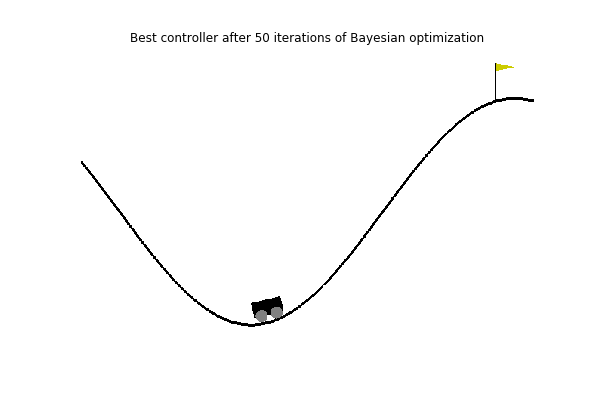
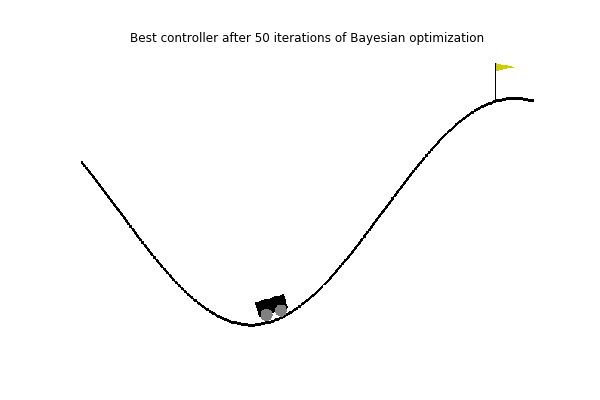
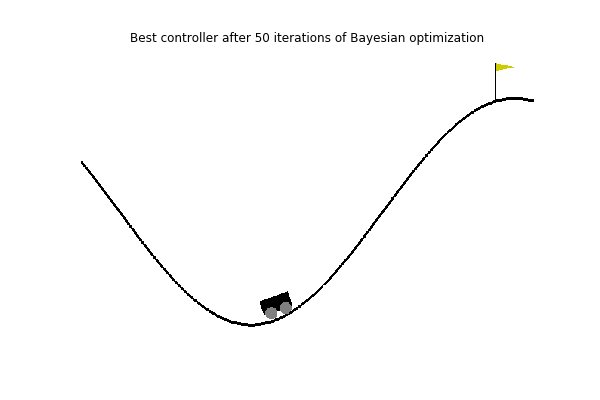
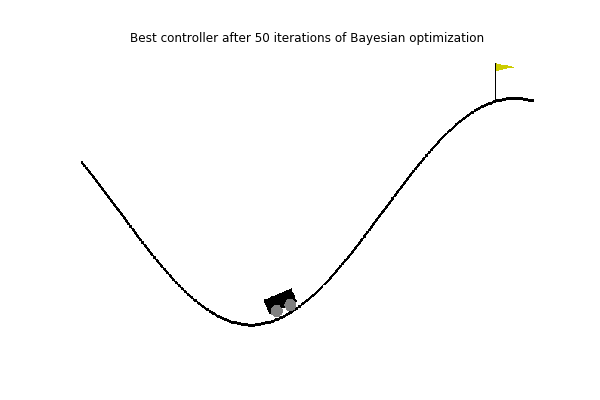
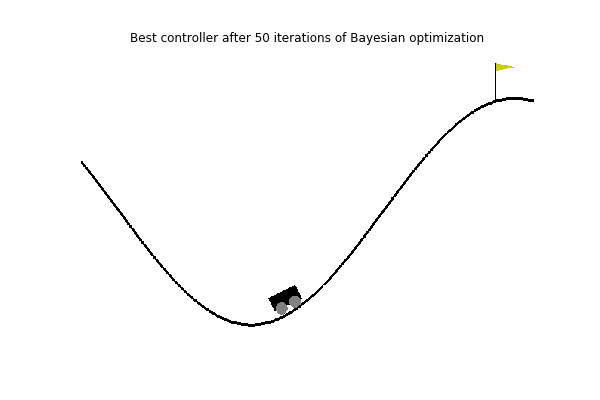
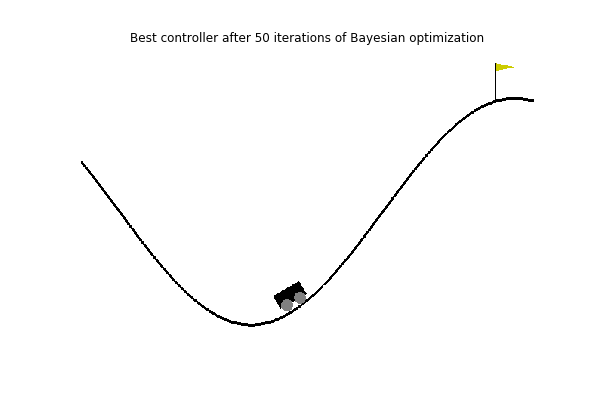
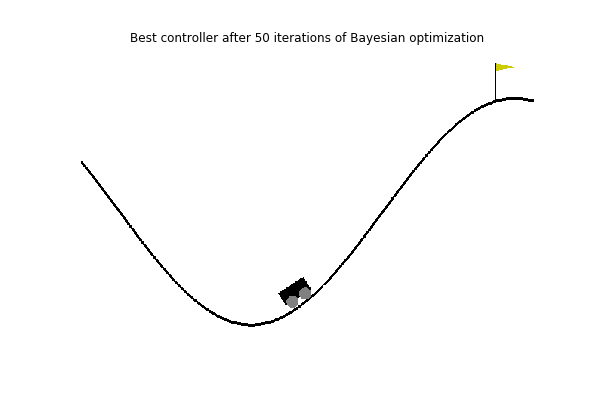
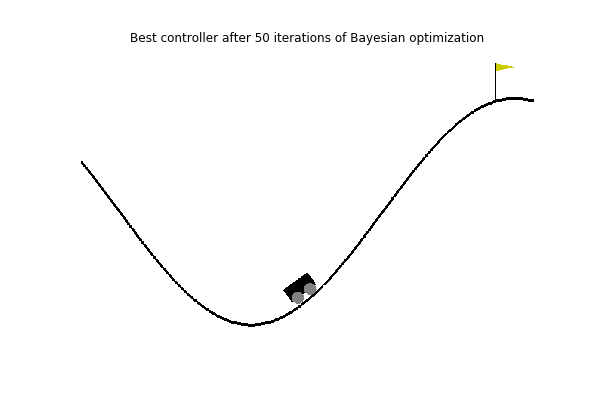
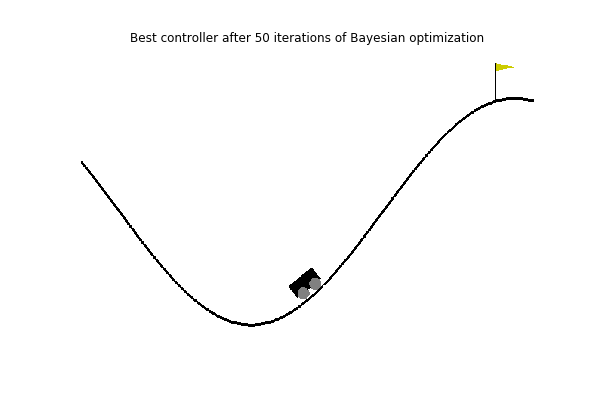
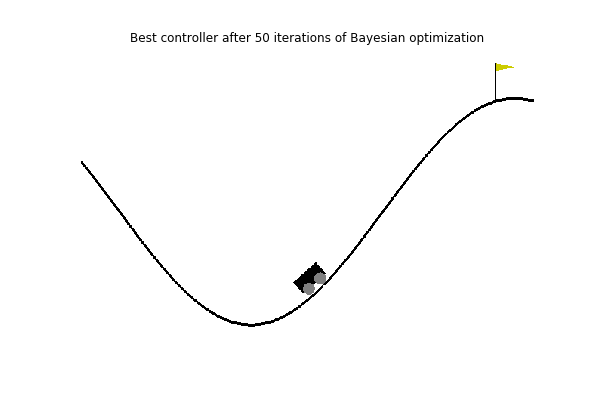
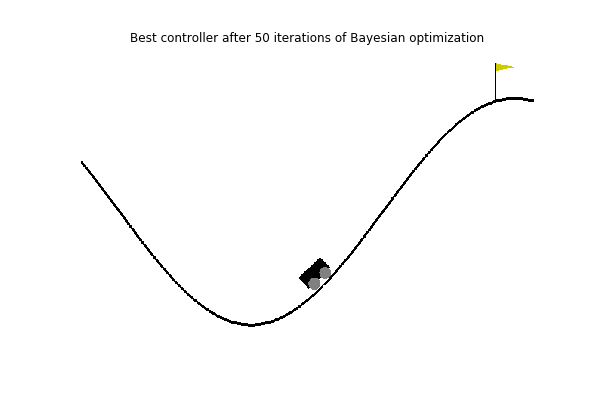
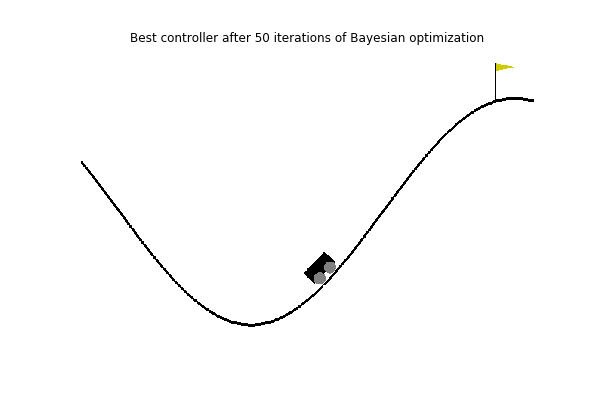
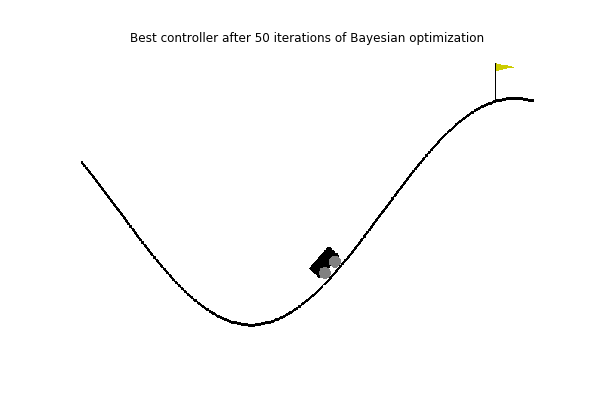
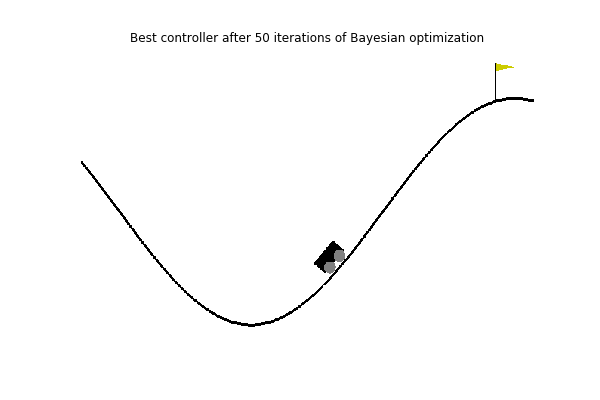
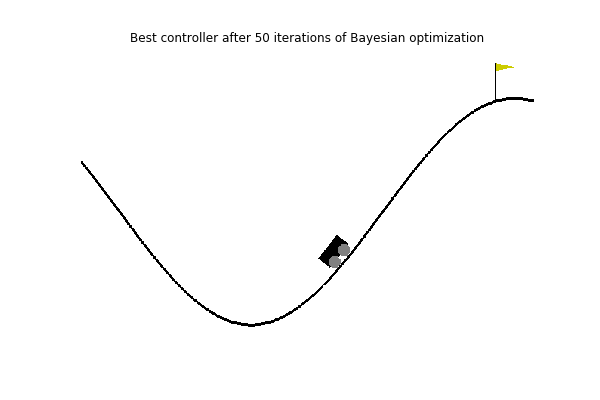
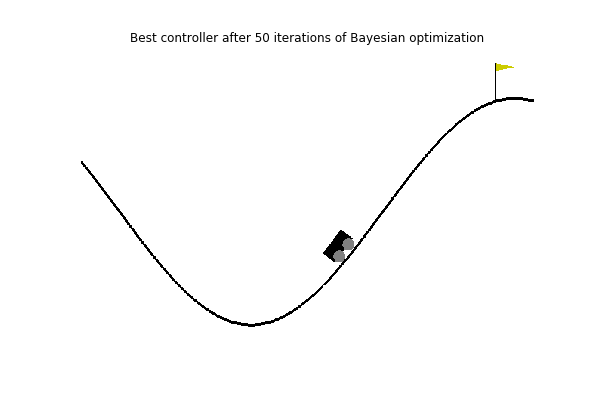
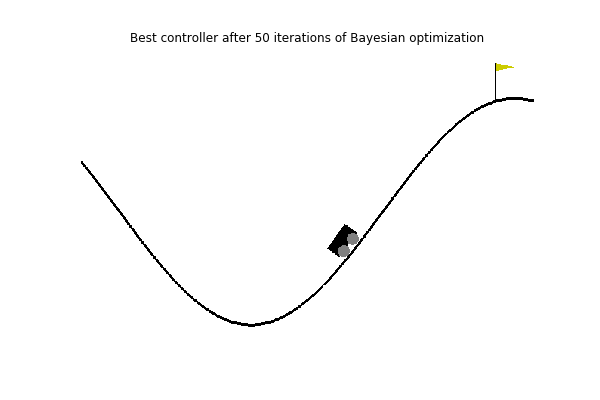
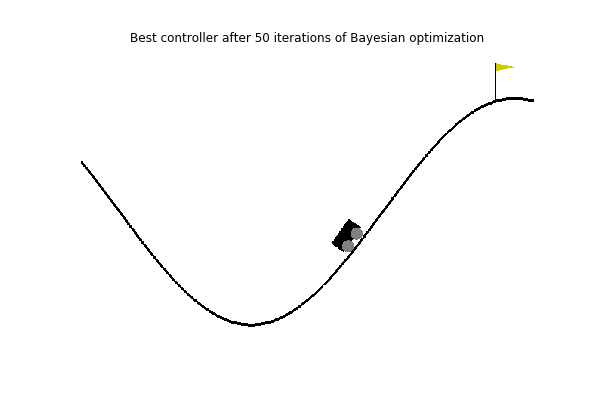
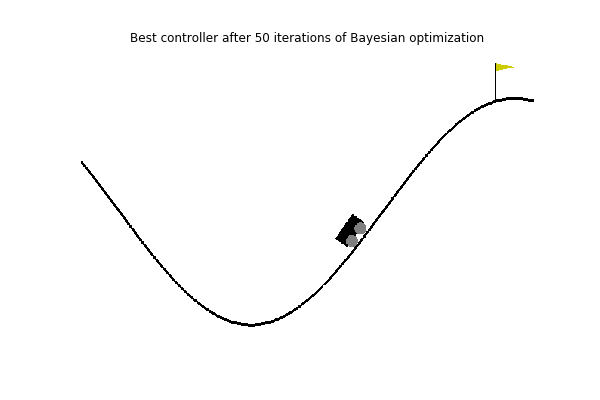
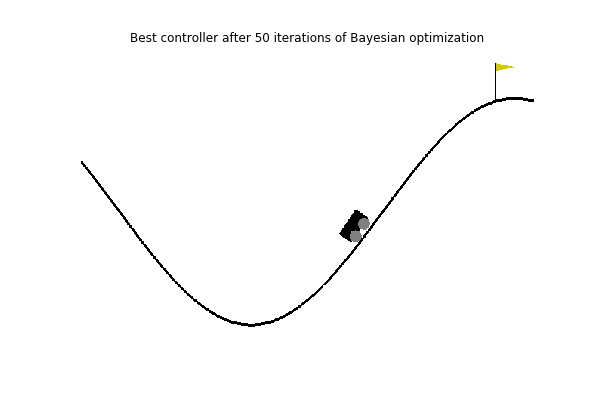
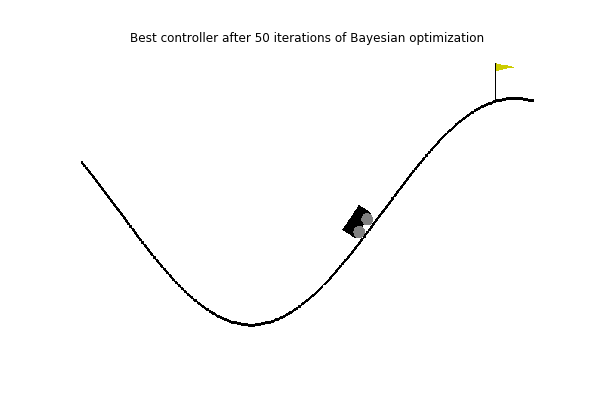
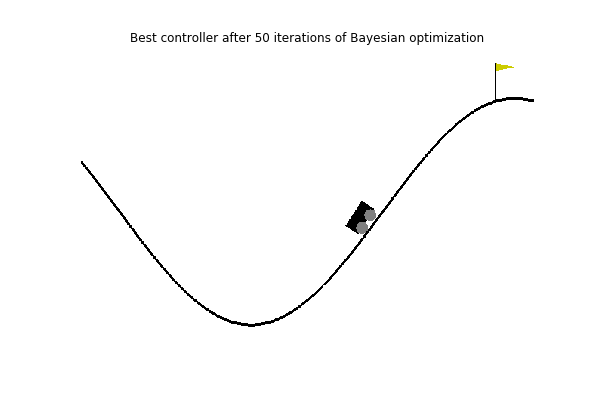
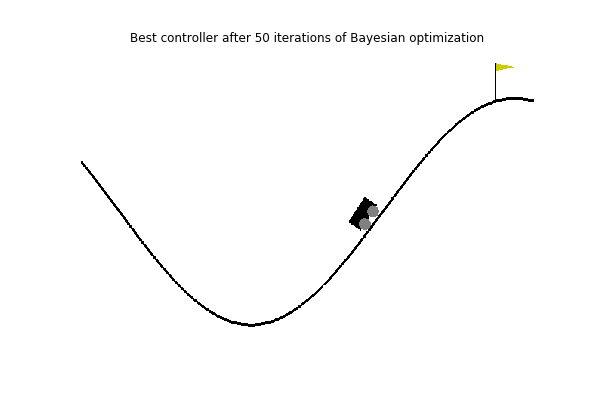
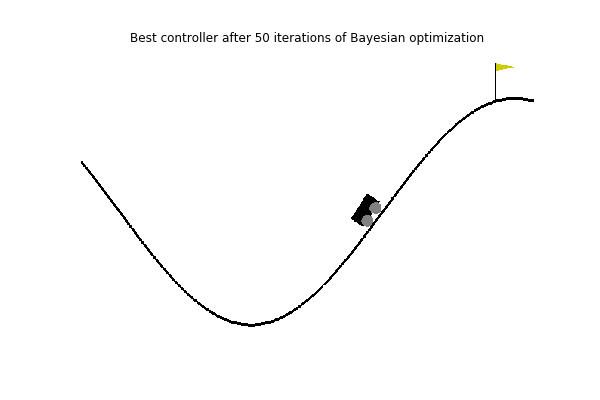
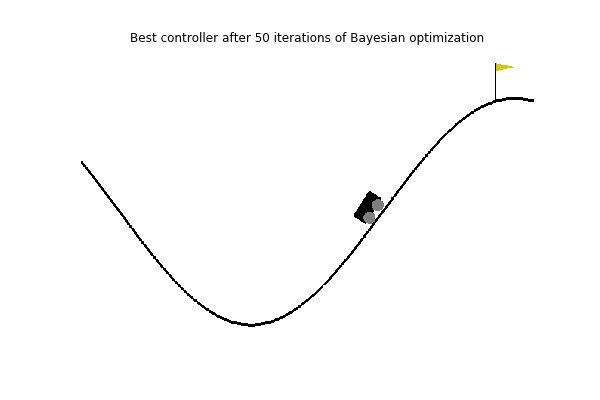
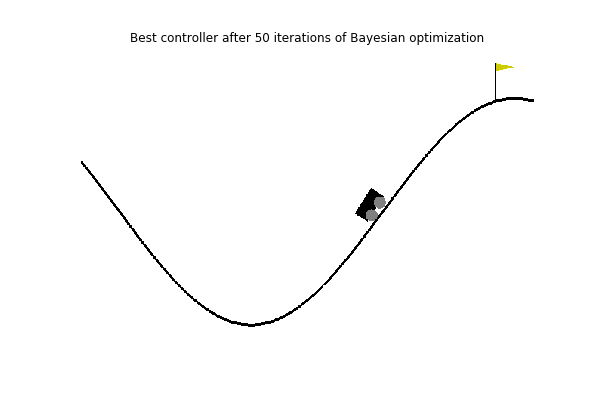
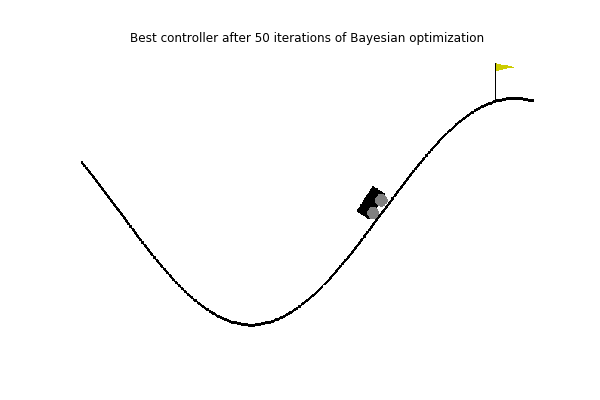
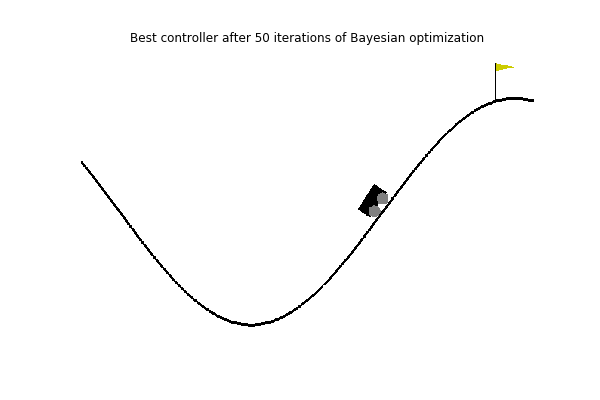
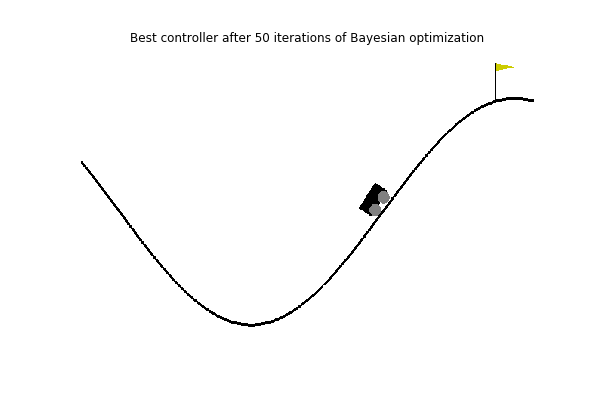
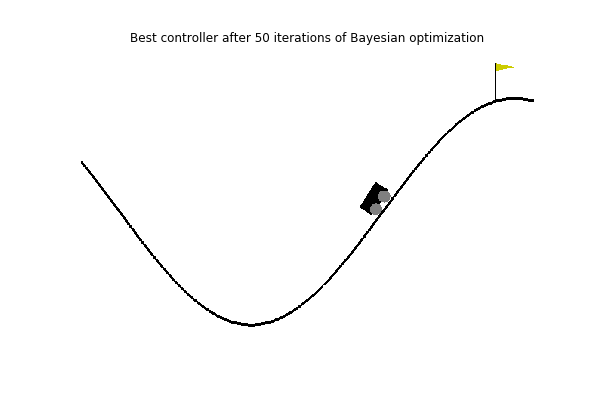
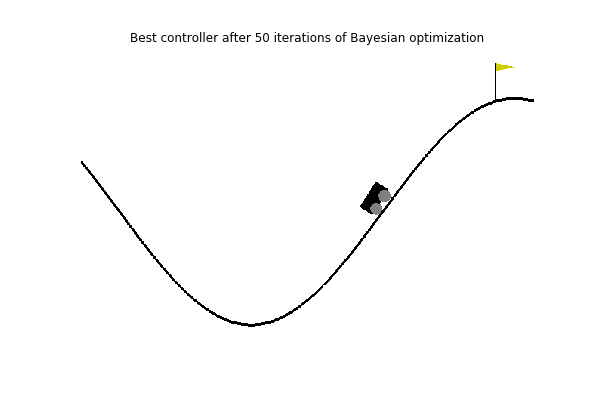
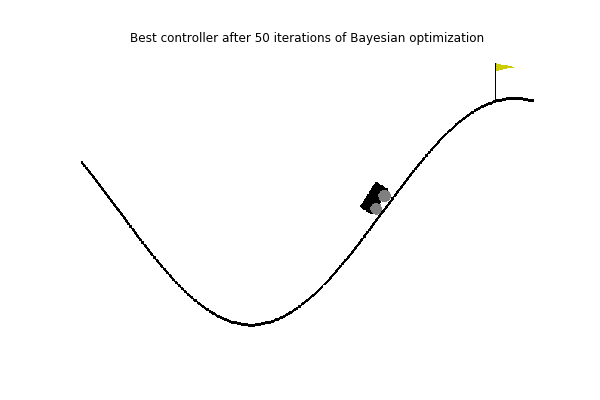
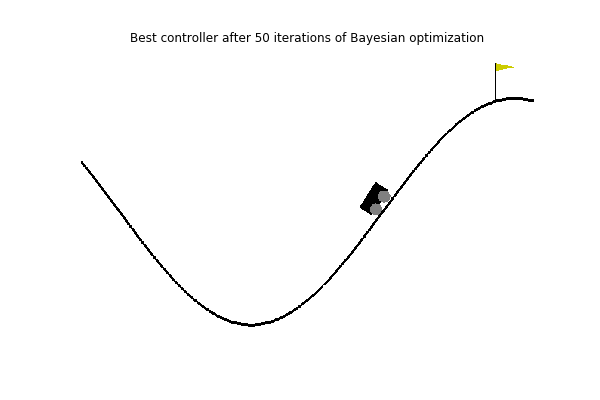
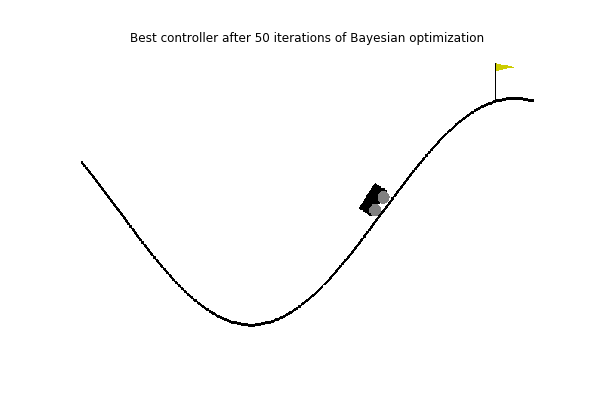
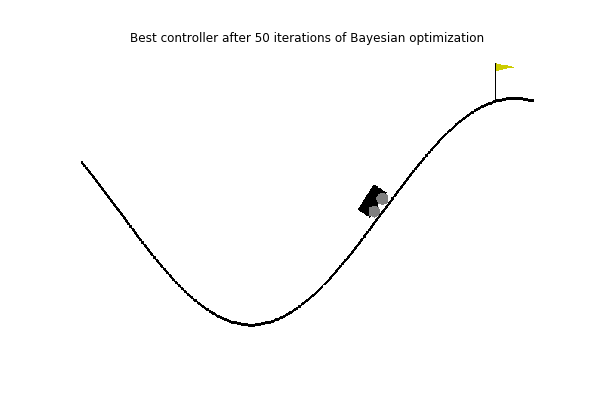
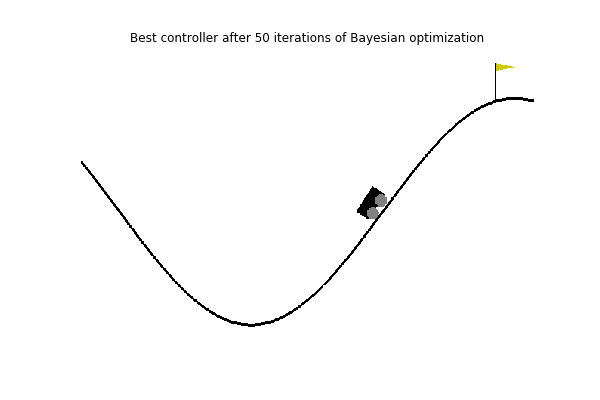
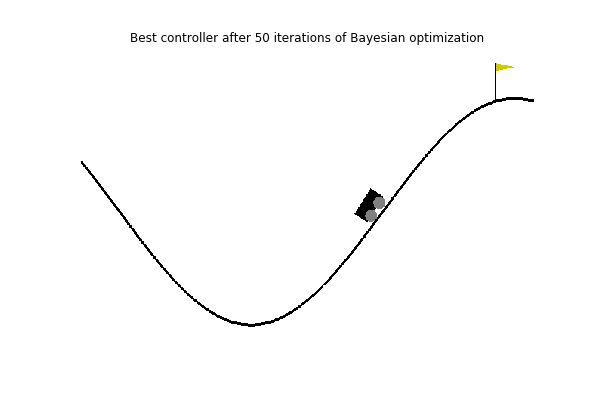
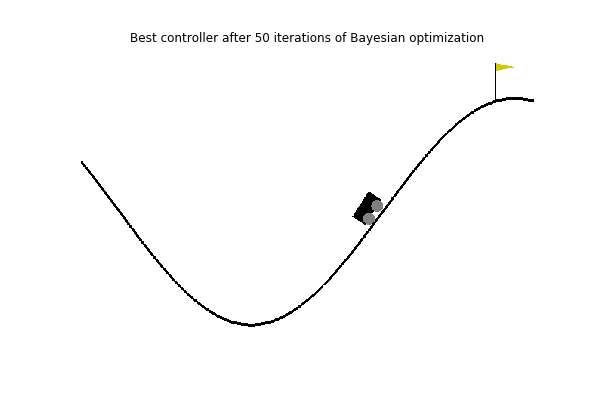
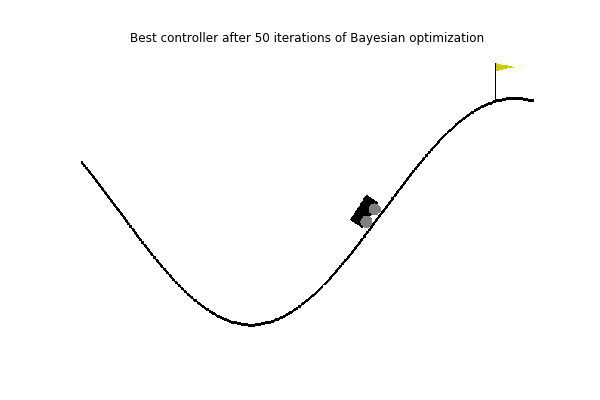
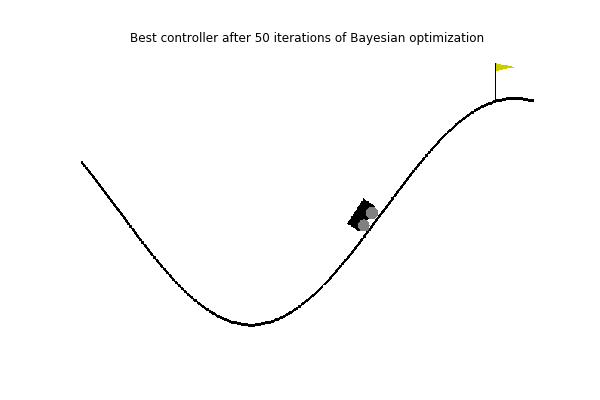
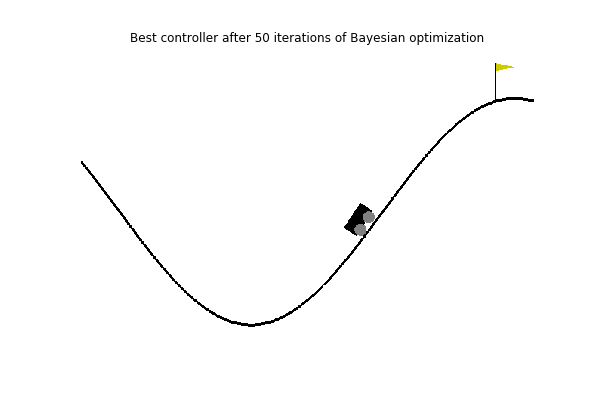
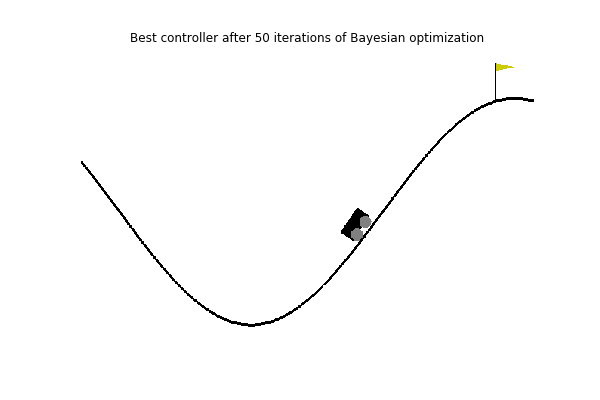
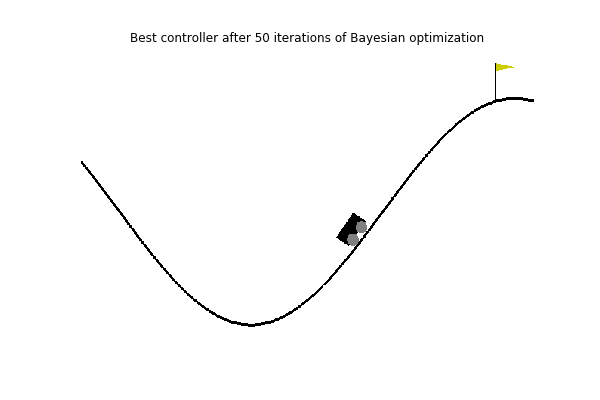
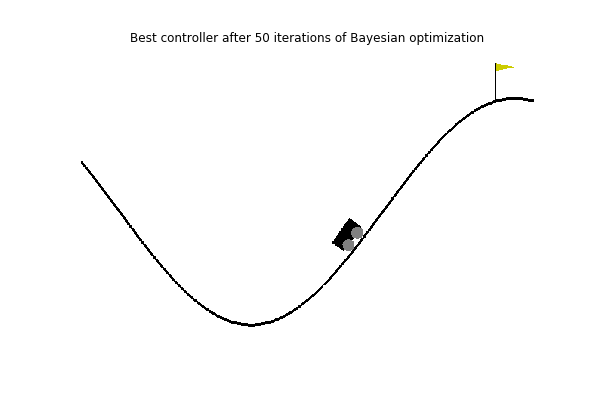
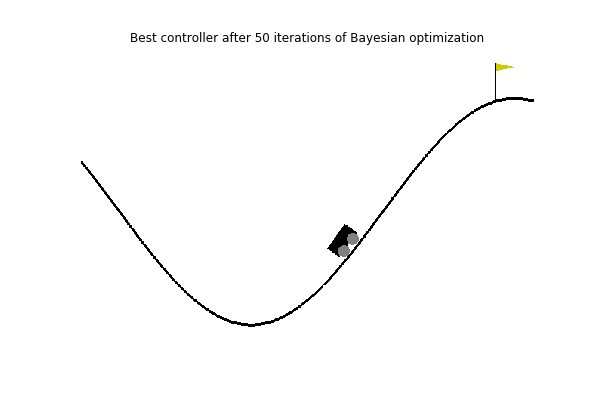
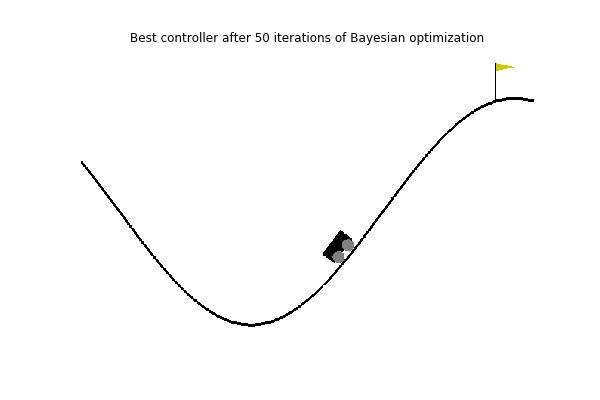
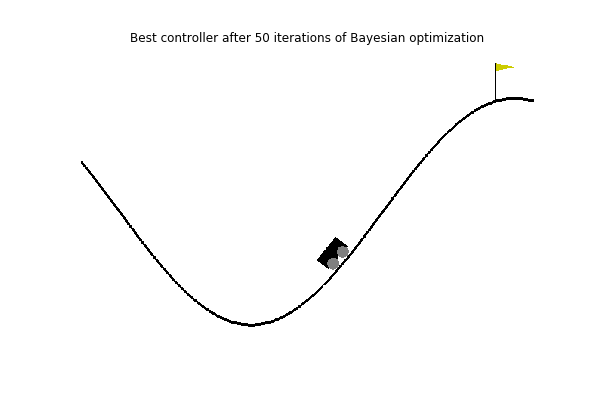
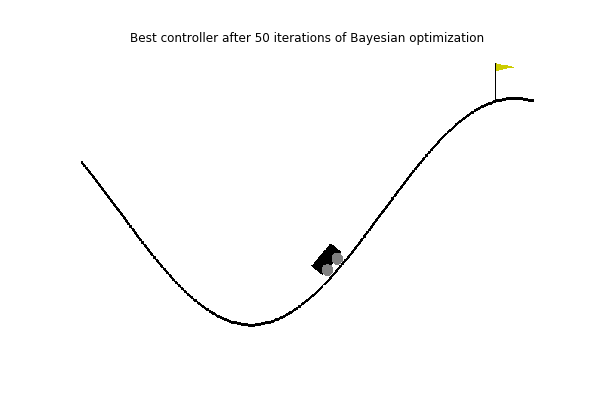
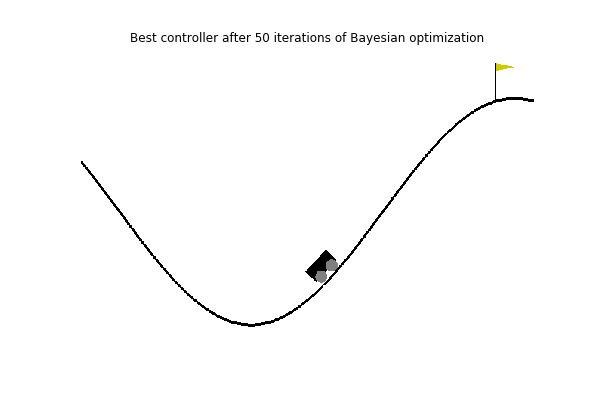
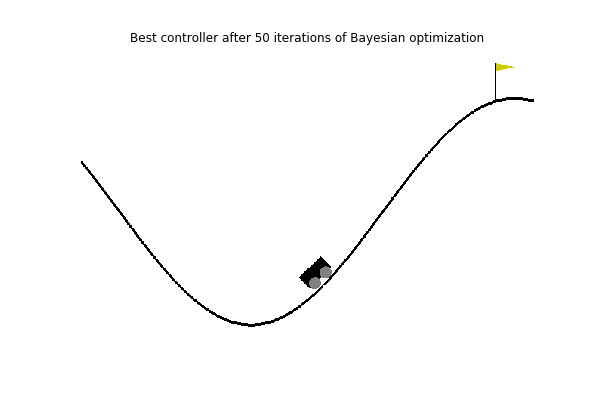
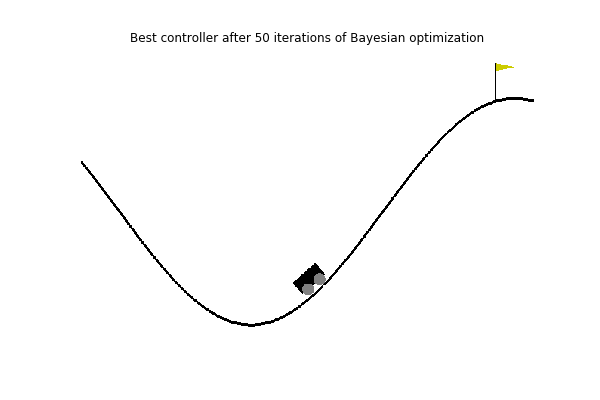
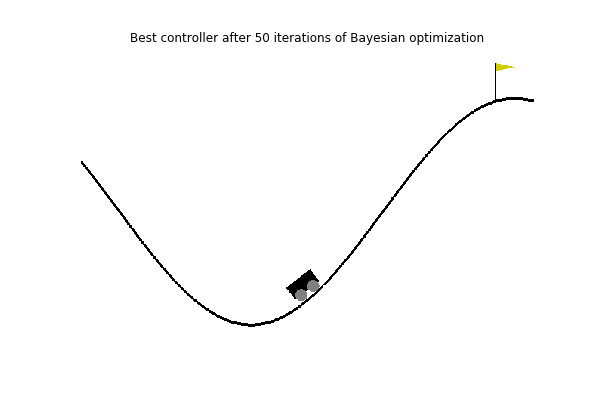
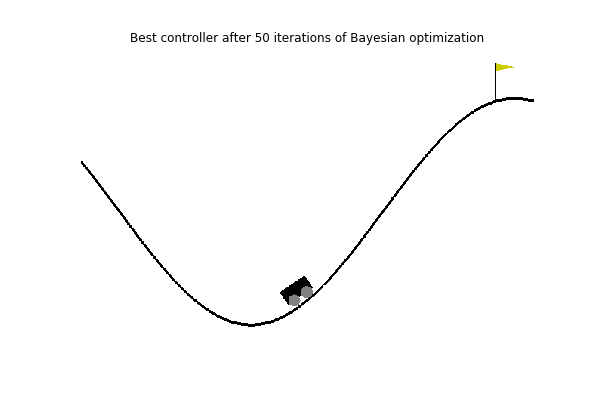
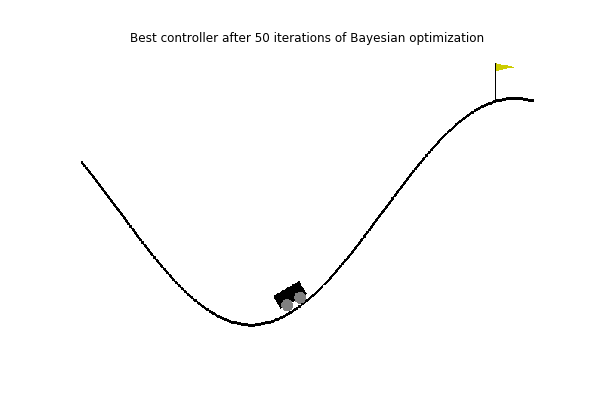
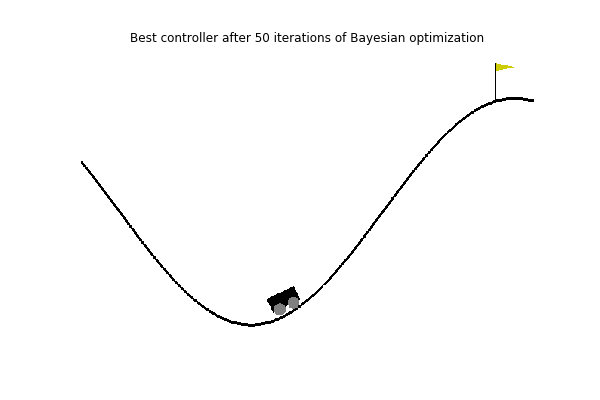
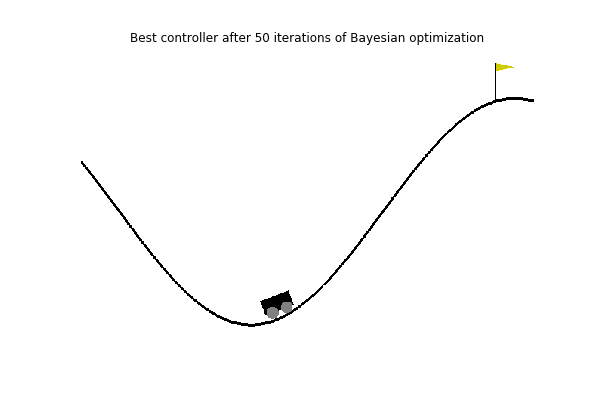
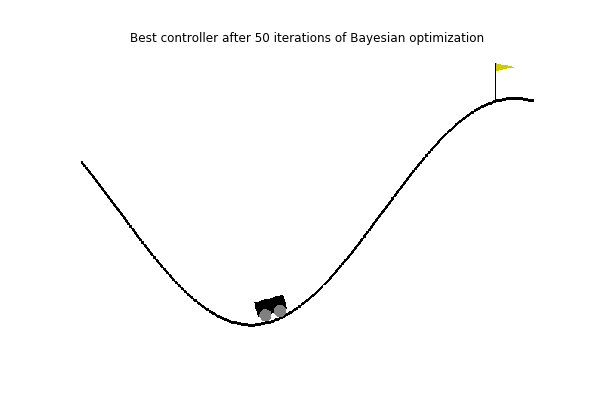
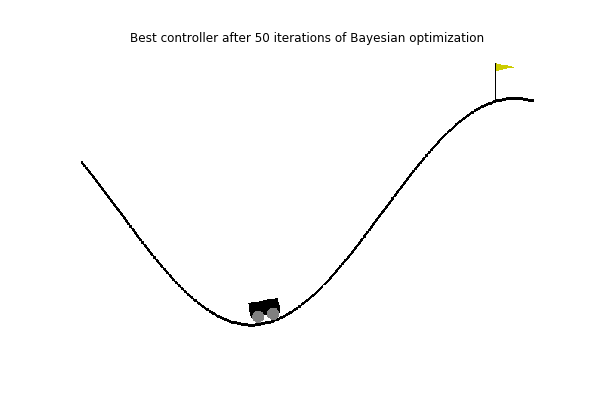
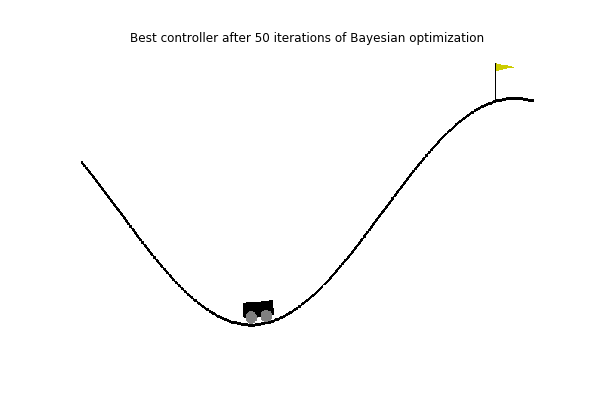
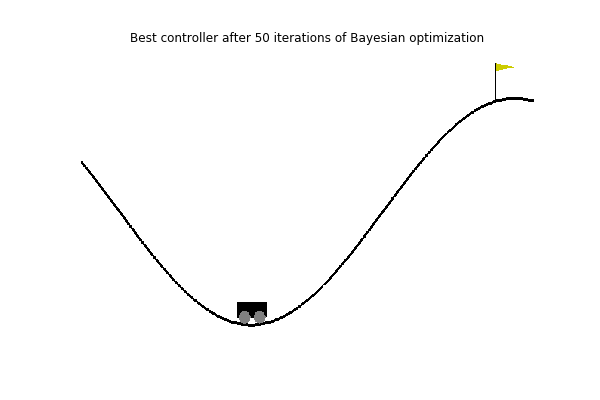
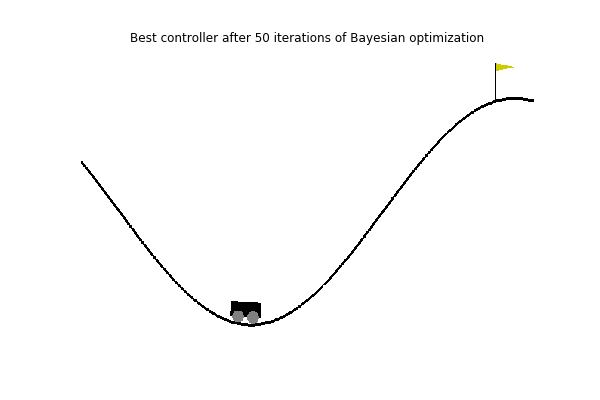
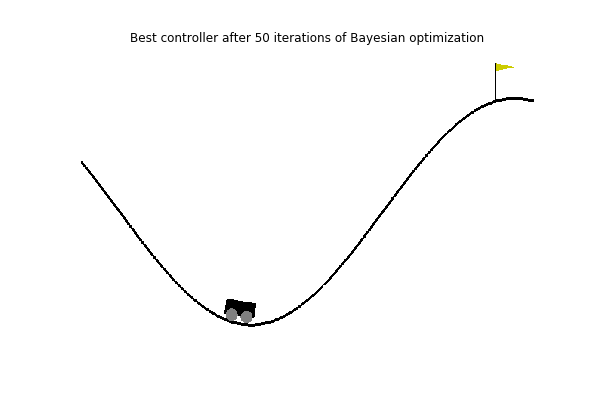
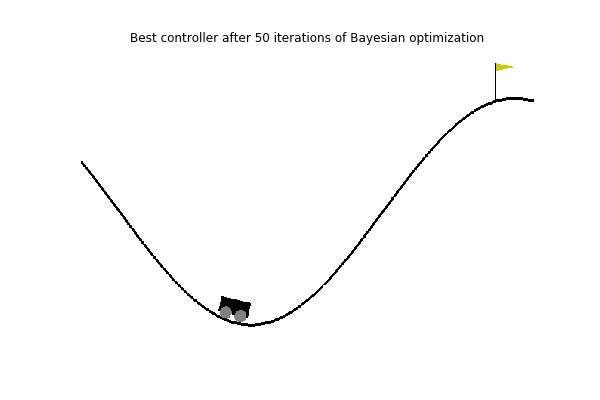
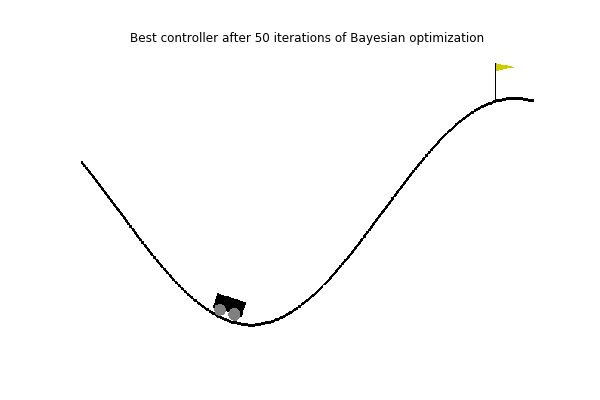
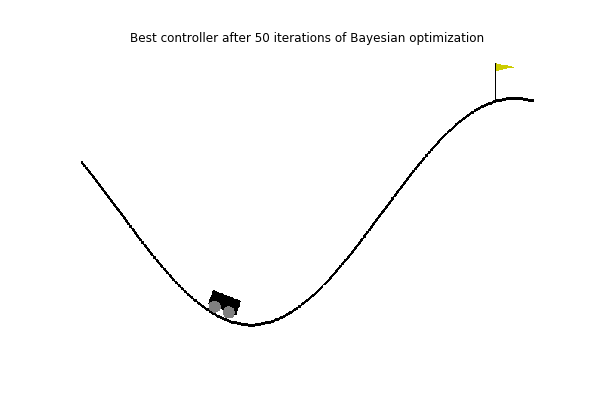
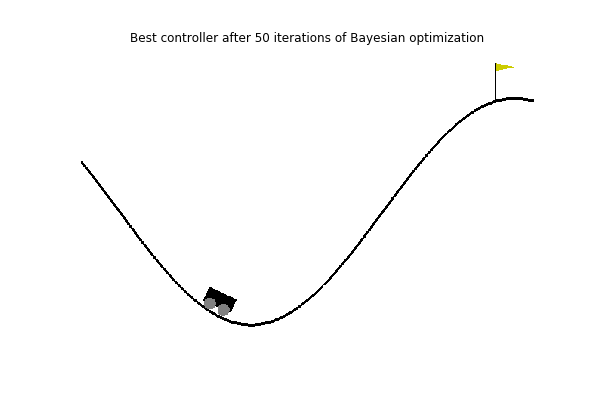
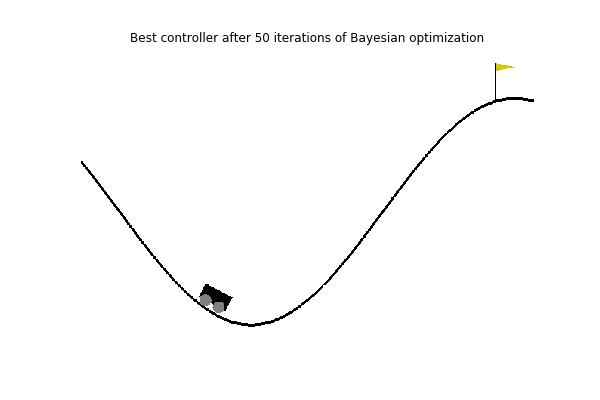
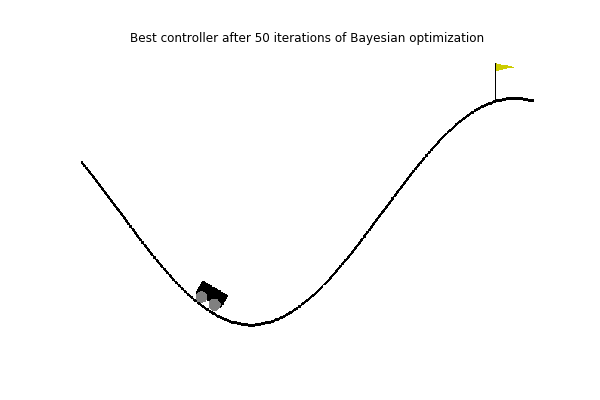
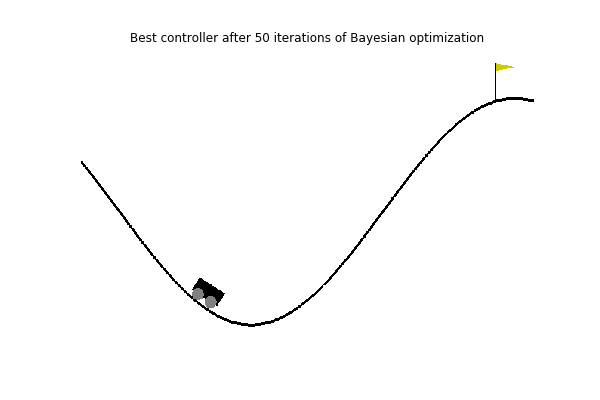
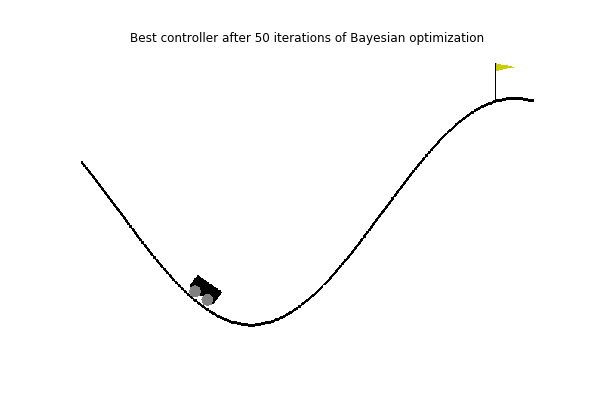
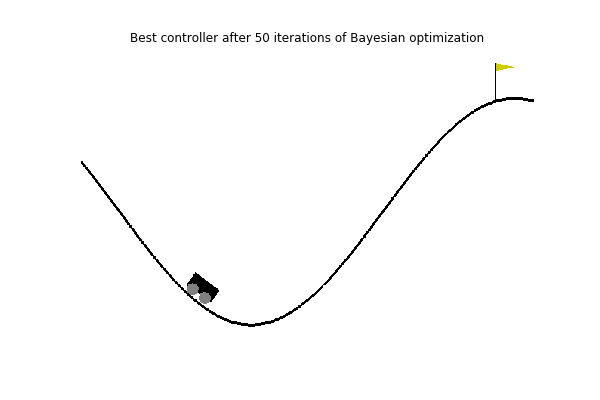
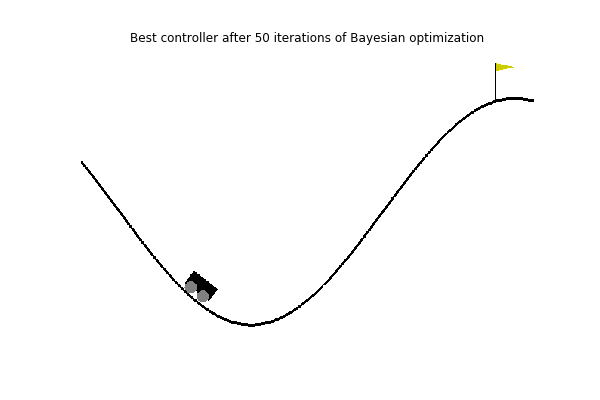
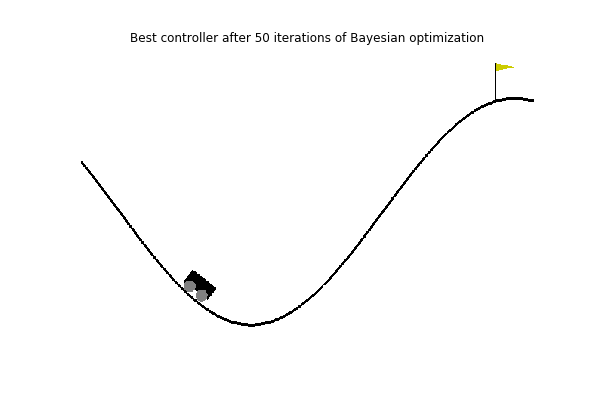
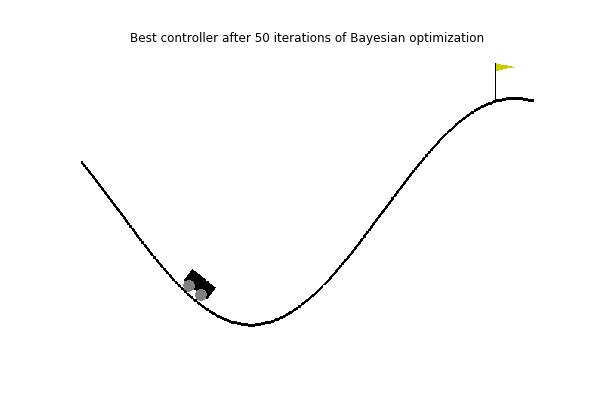
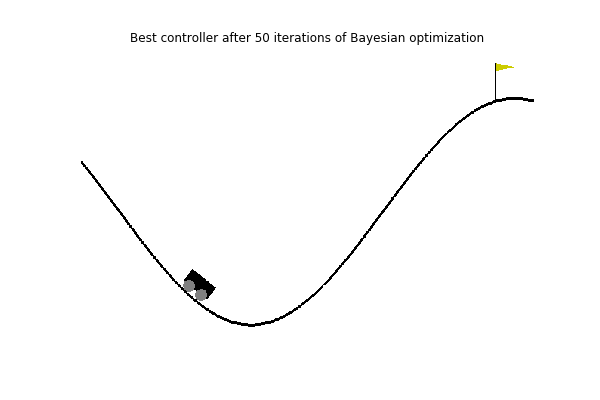
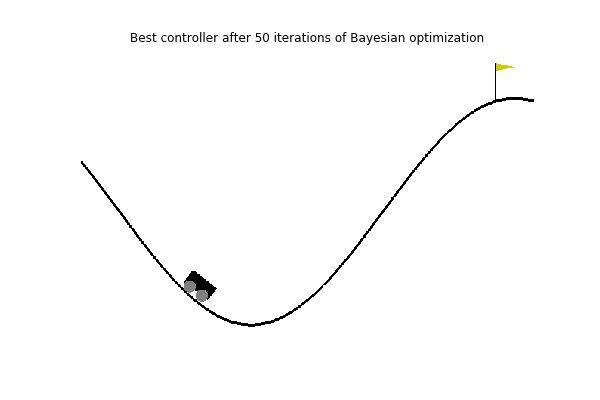
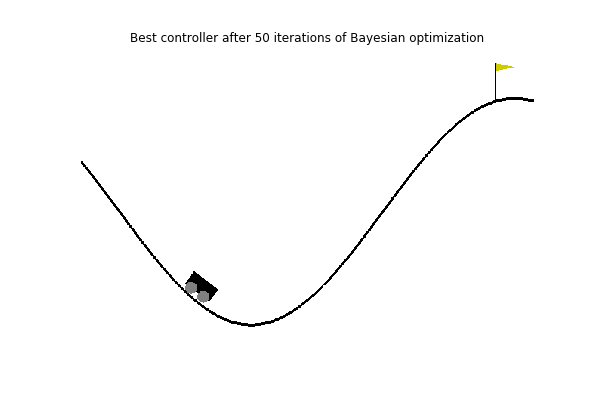
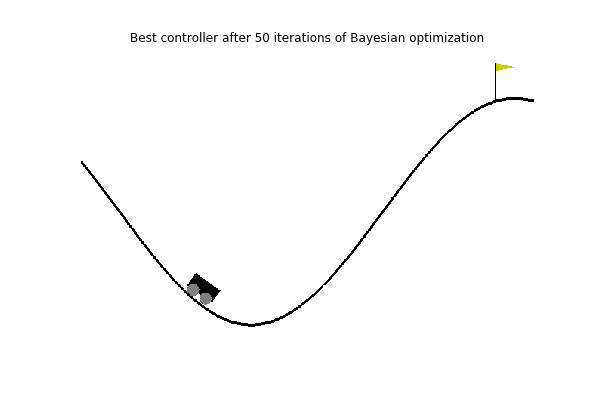
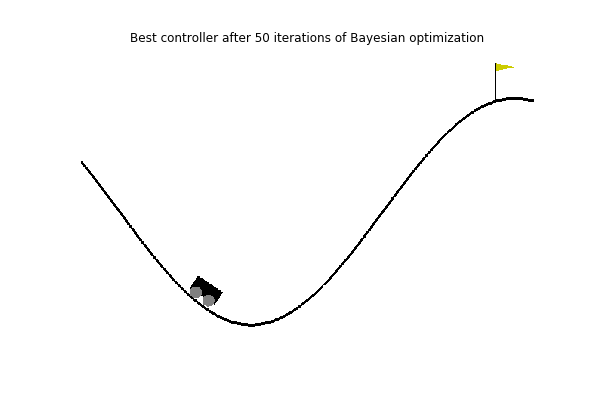
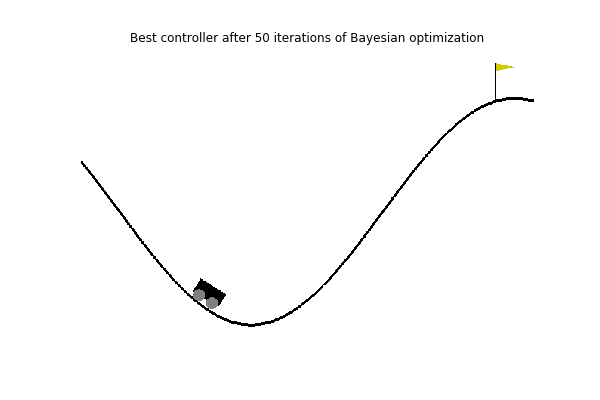
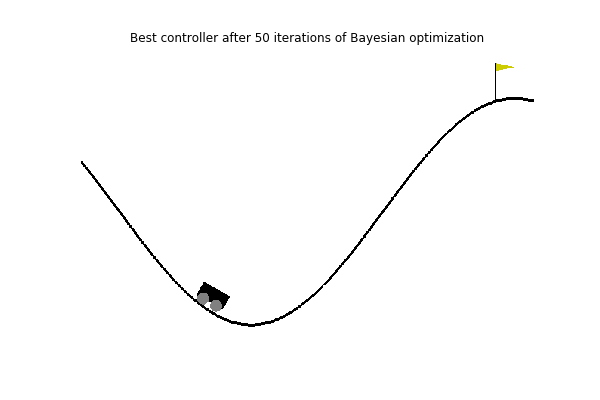
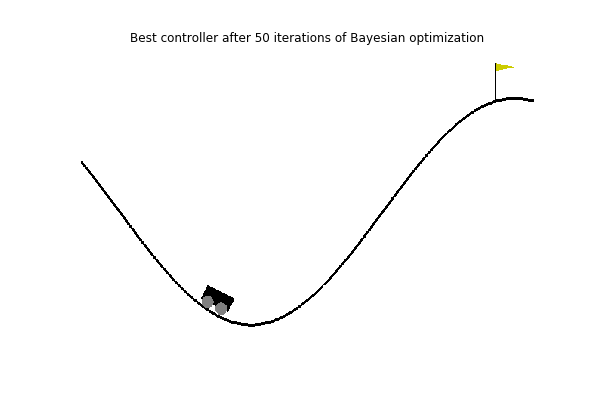
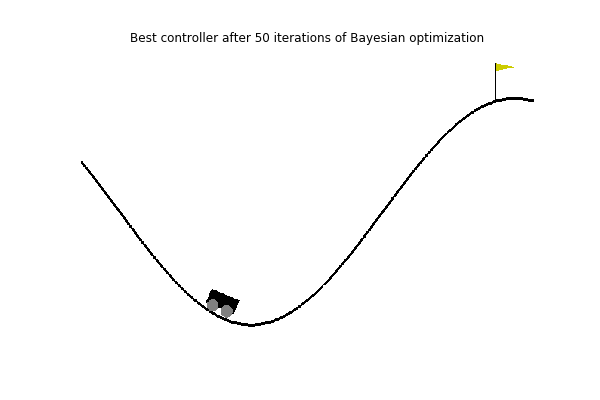
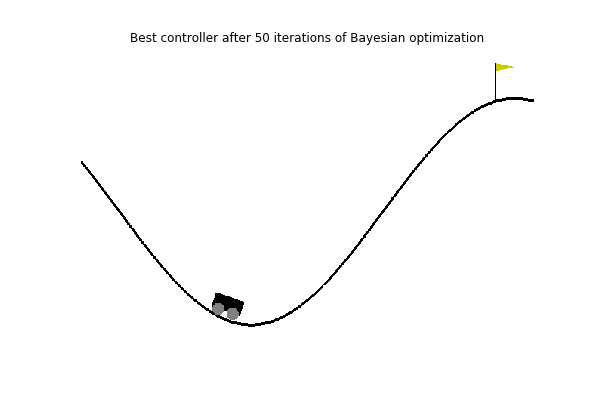
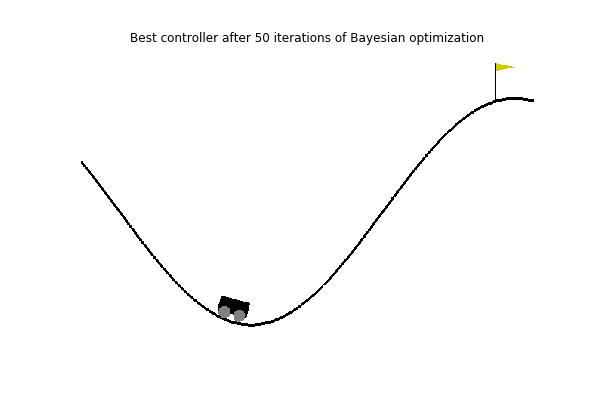
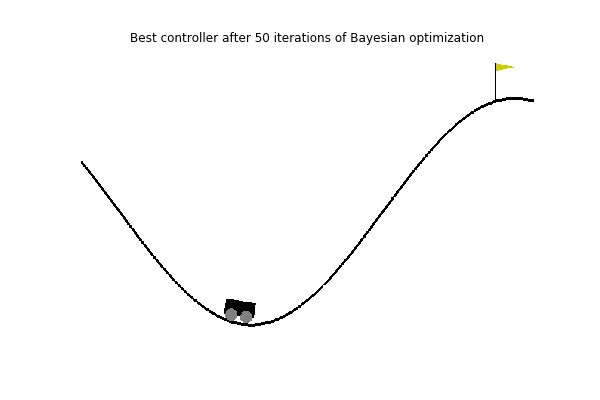
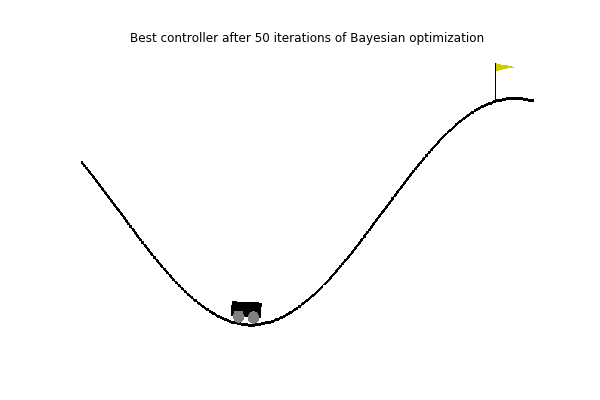
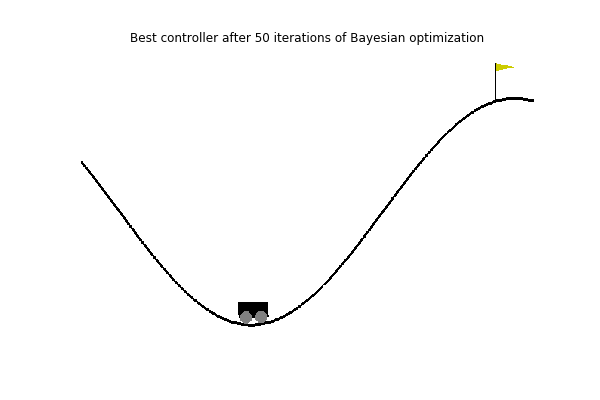
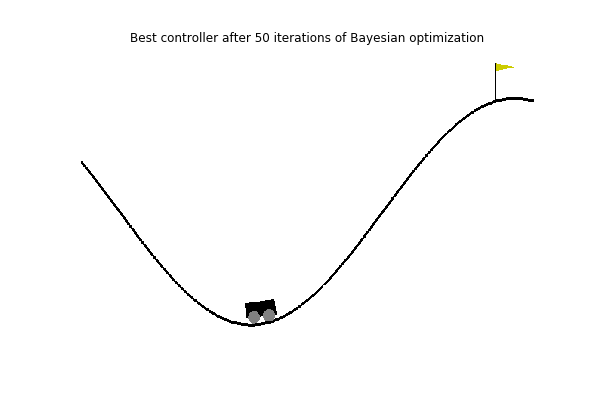
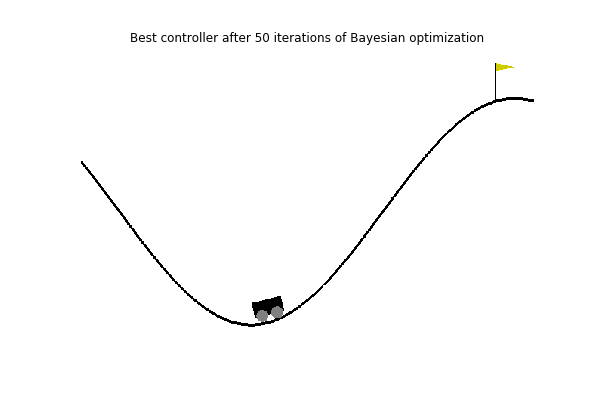
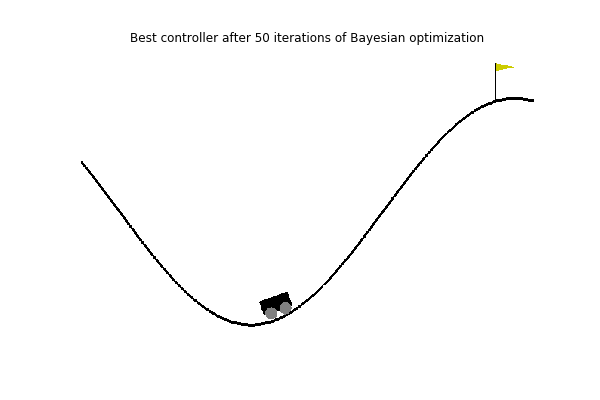
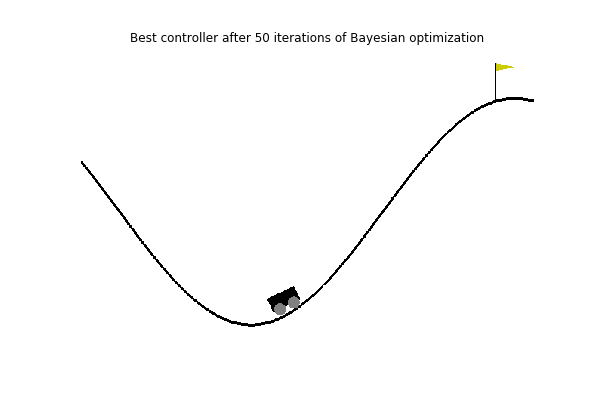
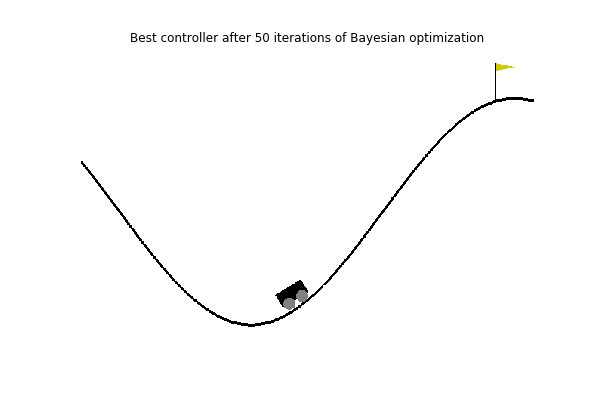
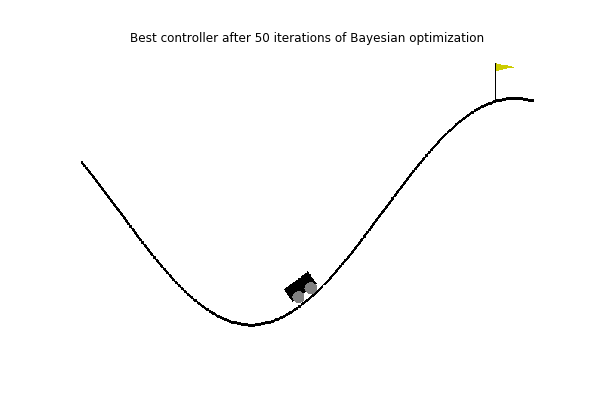
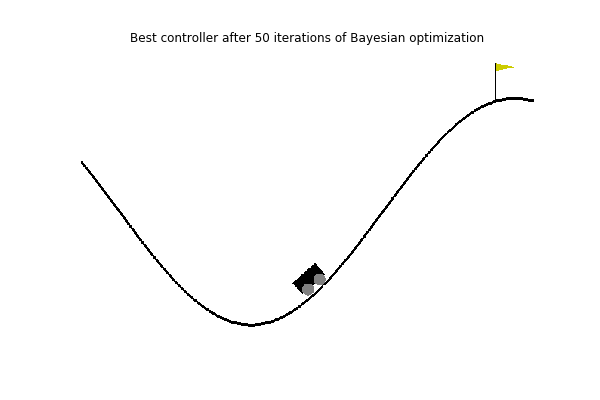
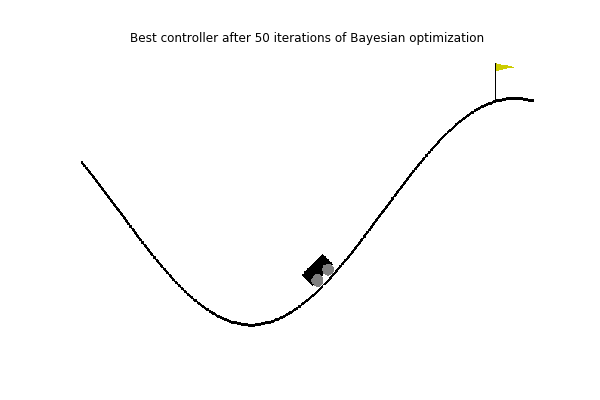
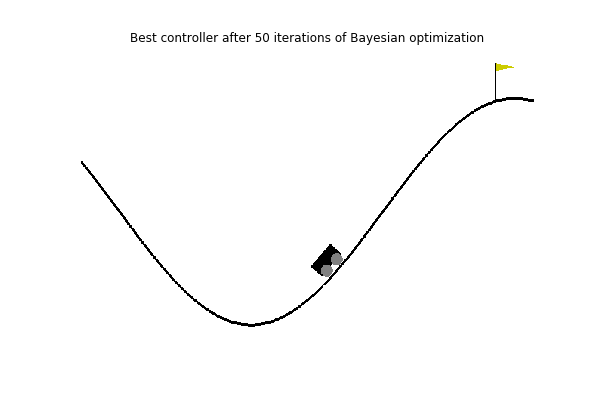
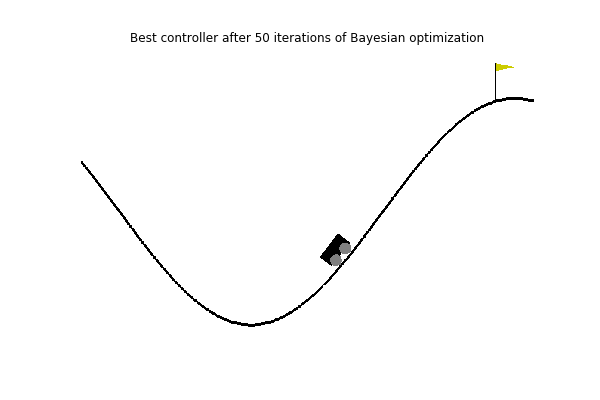
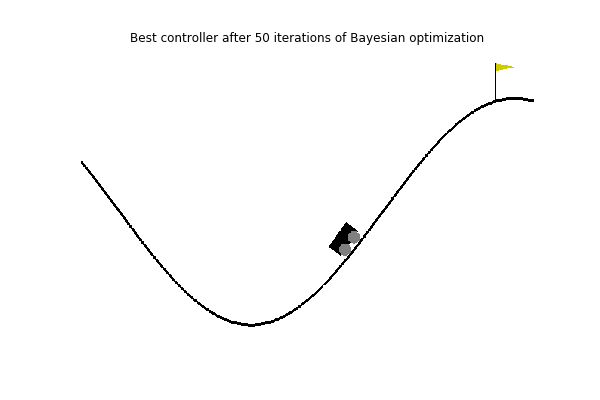
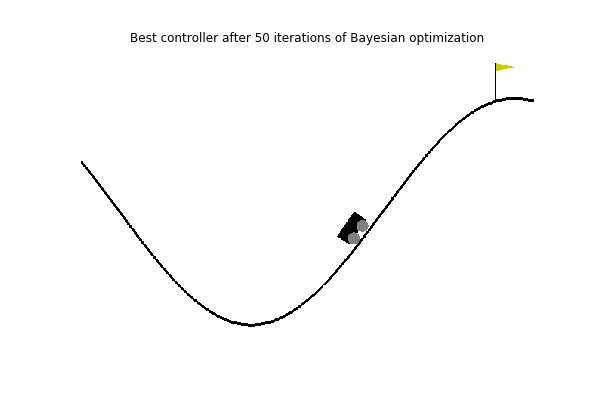
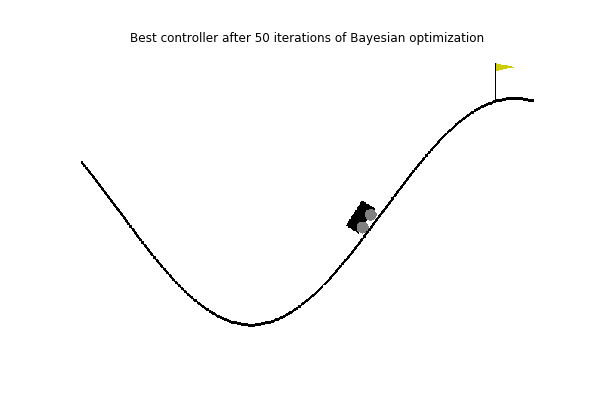
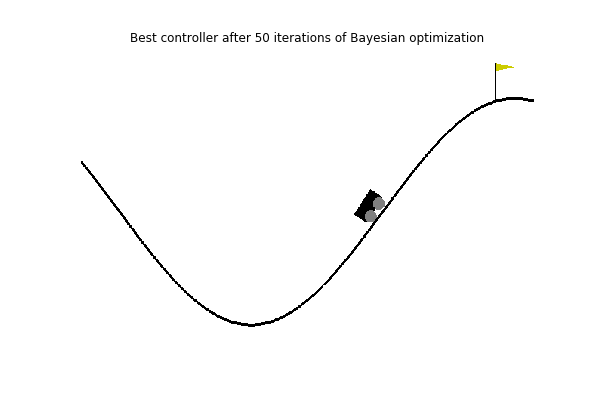
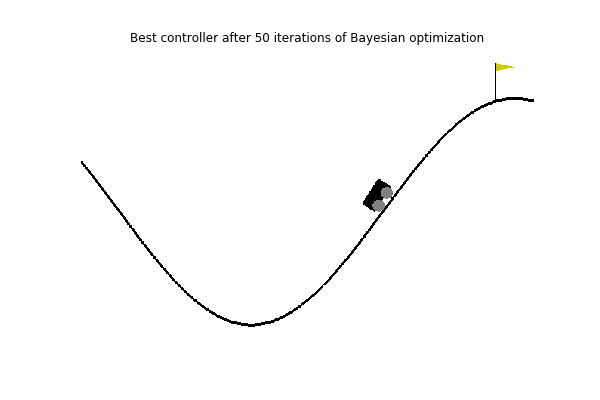
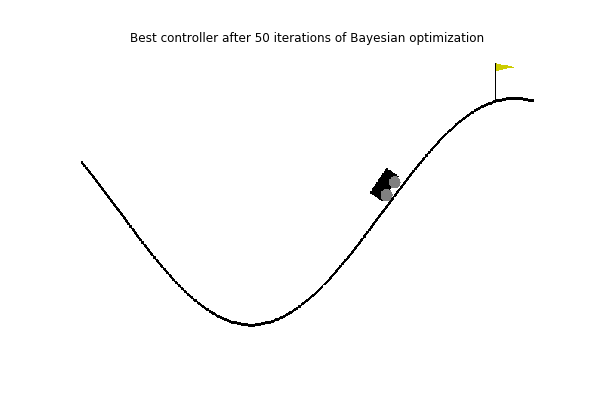
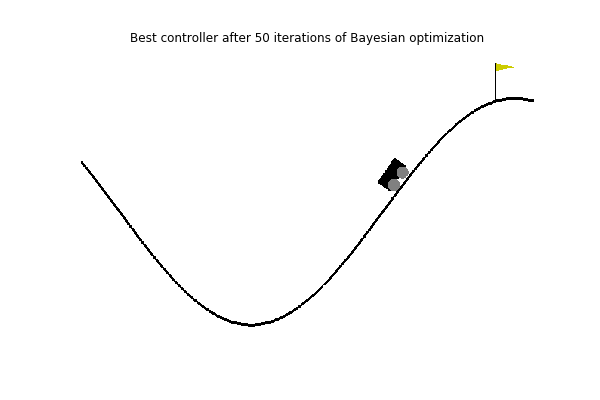
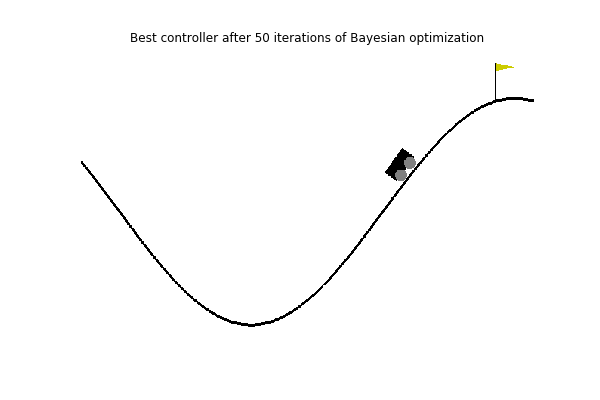
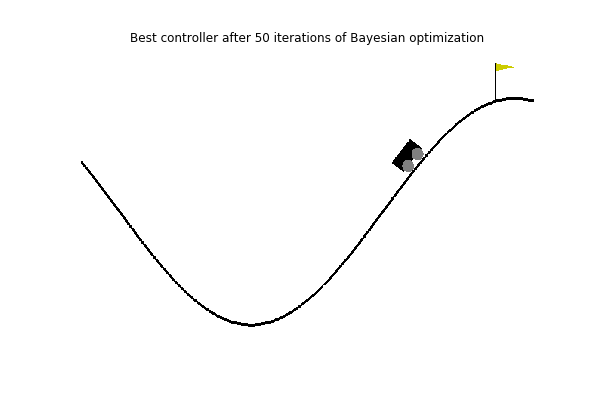
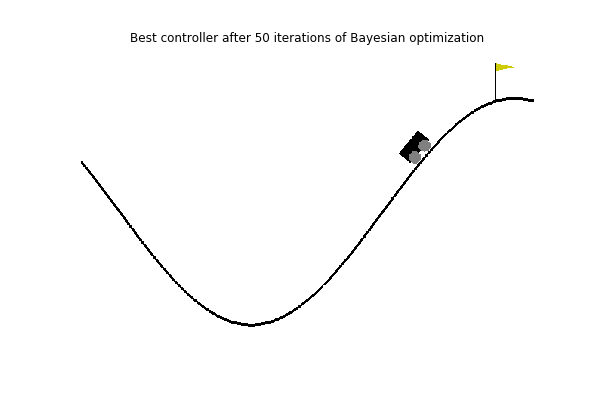
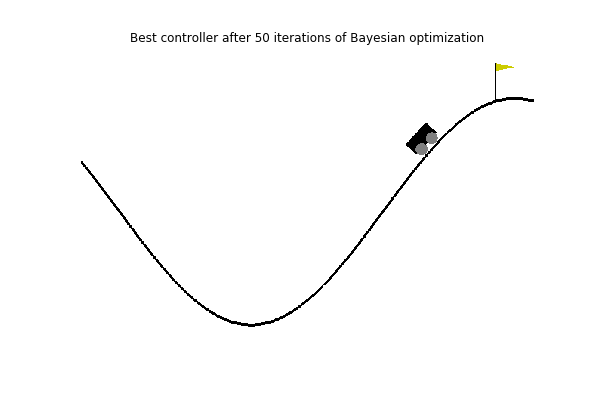
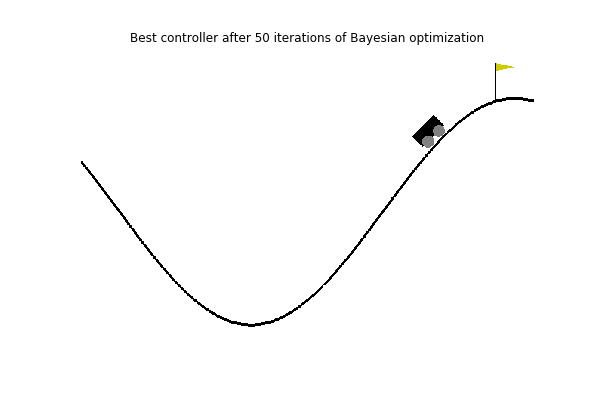
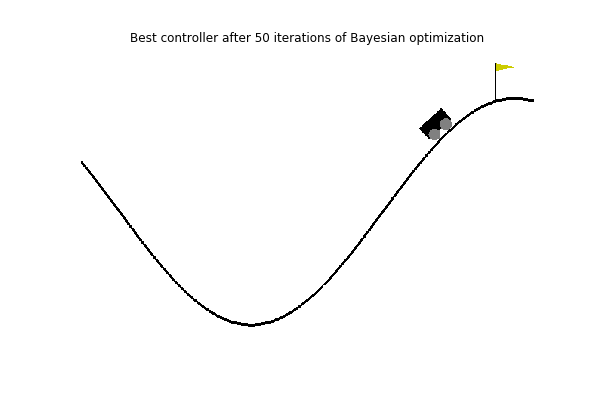
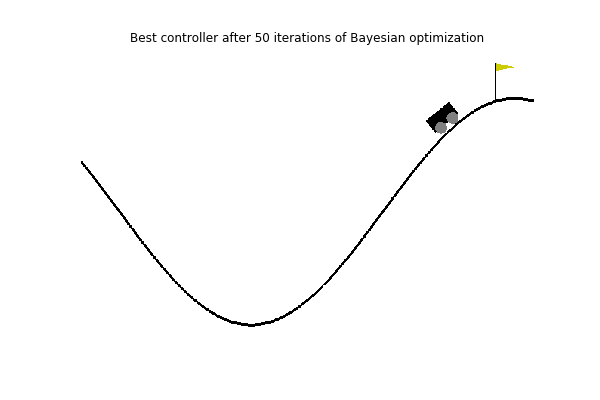
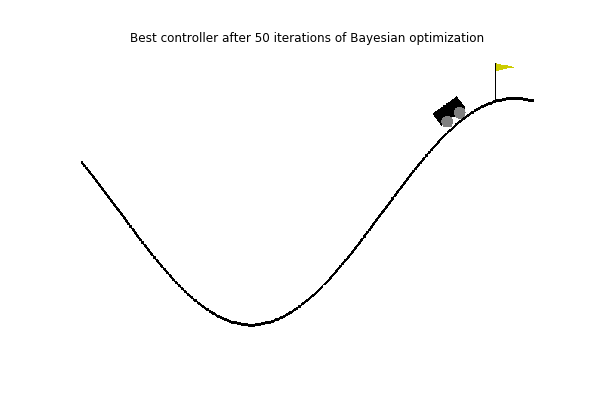
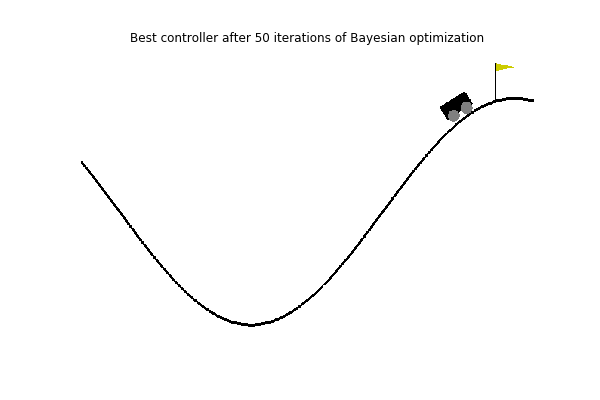
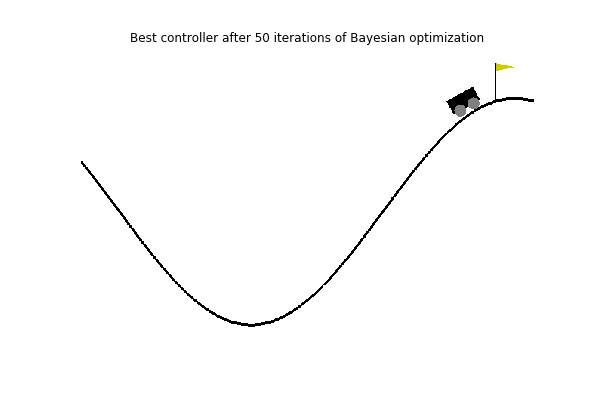
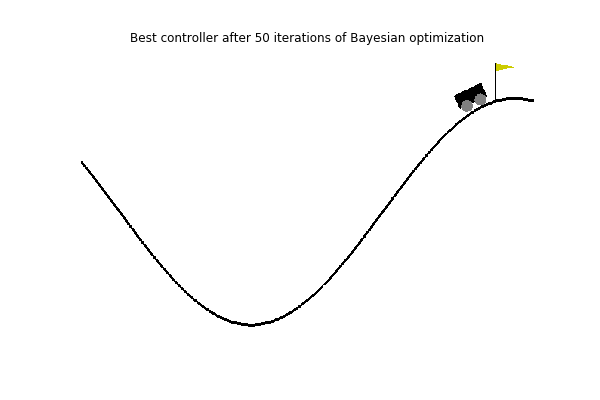
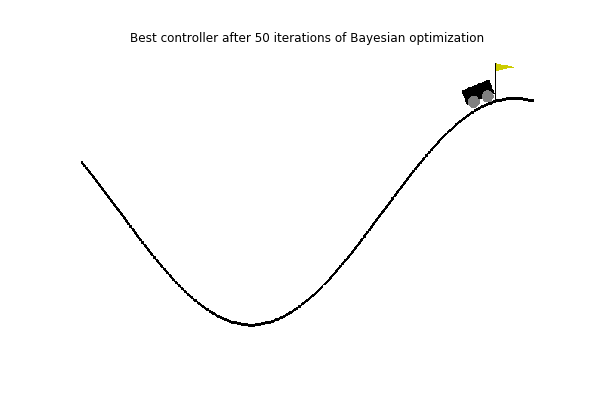
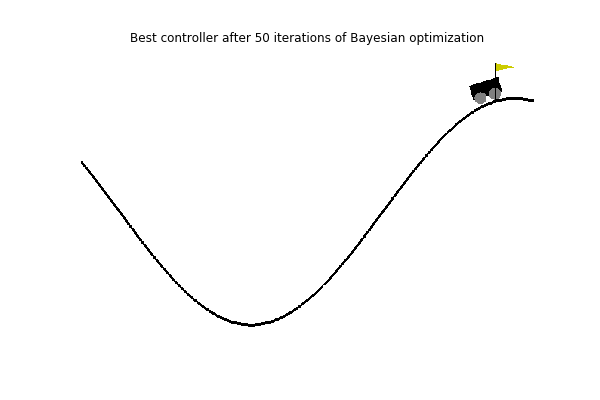

In [11]:
x_opt = bayesopt_loop.loop_state.X[np.argmin(bayesopt_loop.loop_state.Y),:]
_, _, _, frames = mc.run_simulation(env, np.atleast_2d(x_opt), render=True)
mc.display_frames_as_gif(frames, 'Best controller after 50 iterations of Bayesian optimization')

The car can now make it to the top of the mountain! Emulating the reward function and using the EI helped as to find a linear controller that solves the problem.

## 4. Data efficient emulation of the car dynamics

In the previous section we solved the mountain car problem by directly emulating the reward but no considerations about the dynamics $\textbf{x}_{t+1} = f(\textbf{x}_{t},\textbf{u}_{t})$ of the system were made. Note that we had to run 75 episodes of 500 steps each to solve the problem, which required to call the simulator $500\times 75 =37500$ times. In this section we will show how it is possible to reduce this number by building an emulator for $f$ that can later be used to directly optimize the control.

The inputs of the model for the dynamics are the velocity, the position and the value of the control so create this space accordingly.

In [12]:
from emukit.core import ParameterSpace, ContinuousParameter

parameter_space = ParameterSpace([ContinuousParameter('postion_parameter', -1.2, 1),
                                  ContinuousParameter('velocity_parameter', -0.07, 0.07),
                                  ContinuousParameter('constant', -1, 1),])

The outputs are the velocity and the position. Indeed our model will capture the change in position and velocity on time. That is, we will model  

$$\Delta v_{t+1} = v_{t+1} - v_{t}$$
$$\Delta x_{t+1} = p_{t+1} - p_{t}$$

with Gaussian processes with prior mean $v_{t}$ and $p_{t}$ respectively. As a covariance function, we use a Matern52.  We need therefore two models to capture the full dynamics of the system.

Next, we sample some input parameters and use the simulator to compute the outputs. Note that in this case we are not running the full episodes, we are just using the simulator to compute $\textbf{x}_{t+1}$ given $\textbf{x}_{t}$ and $\textbf{u}_{t}$. 

In [13]:
from emukit.core.initial_designs import RandomDesign

# Random locations of the inputs
n_initial_points = 500
random_design_dynamics = RandomDesign(parameter_space) 
initial_design_dynamics = random_design_dynamics.get_samples(n_initial_points)

# Simulation of the (normalized) outputs
y = np.zeros((initial_design_dynamics.shape[0], 2))
for i in range(initial_design_dynamics.shape[0]):
    y[i, :] = mc.simulation(initial_design_dynamics[i, :])
y_normalisation = np.std(y, axis=0)
y_normalised = y/y_normalisation

Note that we can be used smarter strategies to select the points. We could use the variance of the predictive distributions of the models to collect points using uncertainty sampling, which will give us a better coverage of the space. For simplicity, we move ahead with the 500 randomly selected points. 

Now that we have a data set, we can learn the emulators for the location and the velocity.

In [14]:
from GPy.models import GPRegression

kernel_mattern = GPy.kern.Matern52(3, variance = 1., ARD=True)
noise_var_postition = y[:, [0]].var()*0.01
noise_var_velocity = y[:, [1]].var()*0.01

position_model = GPRegression(initial_design_dynamics, y[:, [0]], kernel = kernel_mattern.copy(), noise_var = noise_var_postition) 
velocity_model = GPRegression(initial_design_dynamics, y[:, [1]], kernel = kernel_mattern.copy(), noise_var = noise_var_velocity) 

position_model.Gaussian_noise.constrain_fixed(1e-6, warning=False)
velocity_model.Gaussian_noise.constrain_fixed(1e-6, warning=False)

position_model.optimize()
velocity_model.optimize()

Given some input parameters of the linear controlling, how do the dynamics of the emulator and simulator match? In the following figure we show the position and velocity of the car for the 500 time steps of an episode in which the parameters of the linear controller have been fixed beforehand. The value of the input control is also shown.

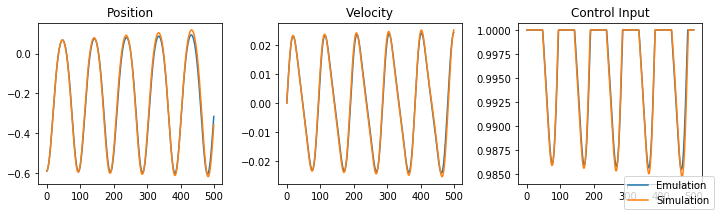

In [15]:
controller_gains = np.atleast_2d([0, .6, 1])  # change the valus of the linear controller to observe the trayectories.
mc.plot_emu_sim_comparison(env, controller_gains, [position_model, velocity_model])

Not bad at all! To complete this section let's make explicit use of the emulator. We now use it to replace the simulator and optimize the linear controller. Note that in this optimization, we don't need to query the simulator anymore as we can reproduce the full dynamics of an episode using the emulator. For illustrative purposes, in this example we fix the initial location of the car. 

We define the objective reward function in terms of the simulator.

In [16]:
# Optimize control parameters with emulator
car_initial_location = np.asarray([-0.58912799, 0]) 

simulator_reward_emulator = lambda x: mc.run_emulation([position_model, velocity_model], x, car_initial_location)[0]

def reward_function_emulator(X):
    rewards = np.empty(shape=[0, 1])
    for i in range(X.shape[0]):
        rewards = np.vstack([rewards, simulator_reward_emulator(X[i,None])])
    return rewards

Now we run Bayesian optimizaton using the emulator instead of calling the simulator.

In [17]:
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.initial_designs import RandomDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.core.loop import FixedIterationsStoppingCondition

parameter_space = ParameterSpace([ContinuousParameter('postion_parameter', -1.2, 1),
                                  ContinuousParameter('velocity_parameter', -1/0.07, 1/0.07),
                                  ContinuousParameter('constant', -1, 1),])

# Create the model
design = RandomDesign(parameter_space) 
X = design.get_samples(25)
Y = reward_function_emulator(X)
kernel = GPy.kern.Matern52(3)
model_gpy = GPRegression(X,Y,kernel = kernel) 
model_gpy.Gaussian_noise.constrain_fixed(1e-8)  ## exact evaluations of the objective
model_gpy.optimize_restarts(5)
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

# Create the loop
expected_improvement = ExpectedImprovement(model = model_emukit)
bayesopt_loop_emulator = BayesianOptimizationLoop(model = model_emukit,
                                         space = parameter_space,
                                         acquisition = expected_improvement,
                                         batch_size = 1)

# Run the loop
num_evaluations = 50
stopping_condition = FixedIterationsStoppingCondition(i_max = num_evaluations)
bayesopt_loop_emulator.run_loop(reward_function_emulator, stopping_condition)

Optimization restart 1/5, f = 160.17881570119962
Optimization restart 2/5, f = 160.1788157015984
Optimization restart 3/5, f = 160.17881570119968
Optimization restart 4/5, f = 160.1788157013763
Optimization restart 5/5, f = 160.45255961088327


And as before, we use Bayesian optimization to find the best possible linear controller.


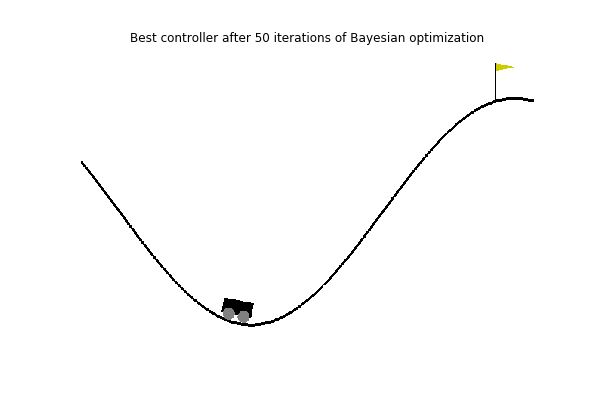
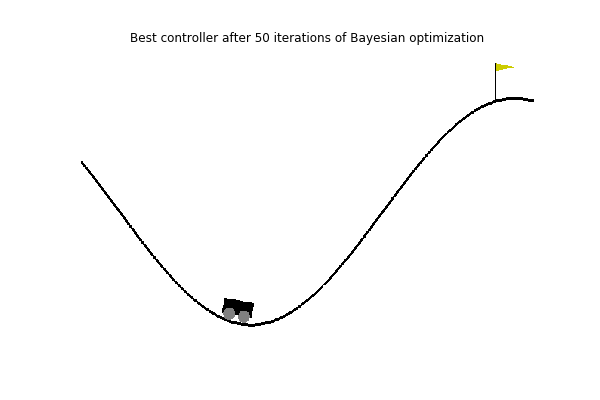
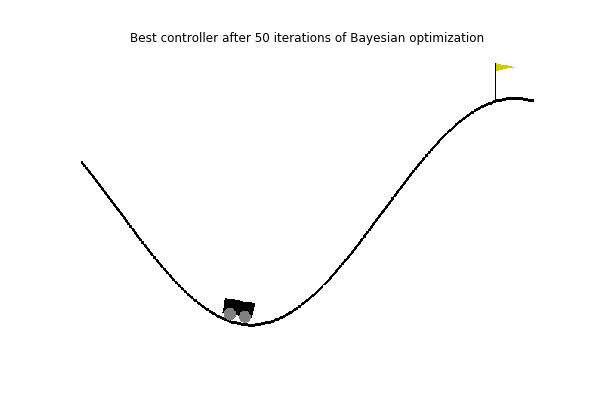
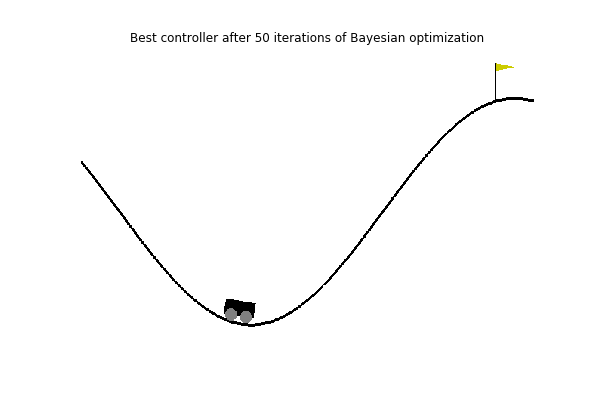
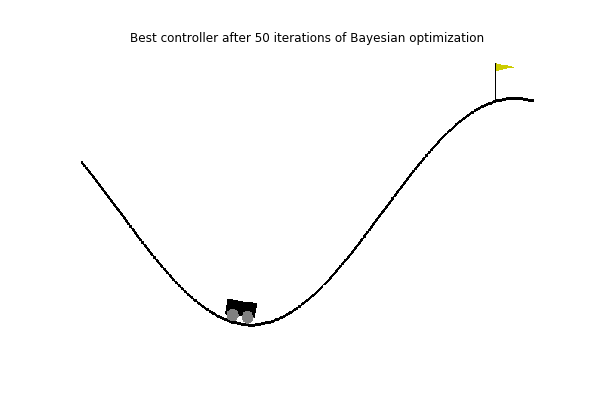
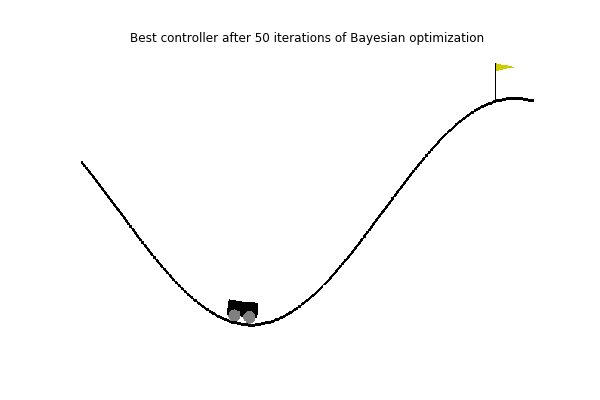
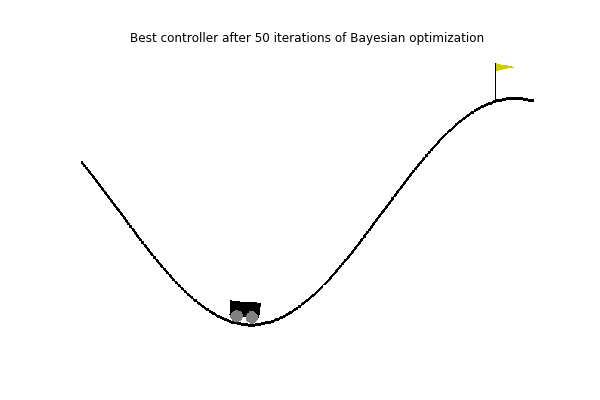
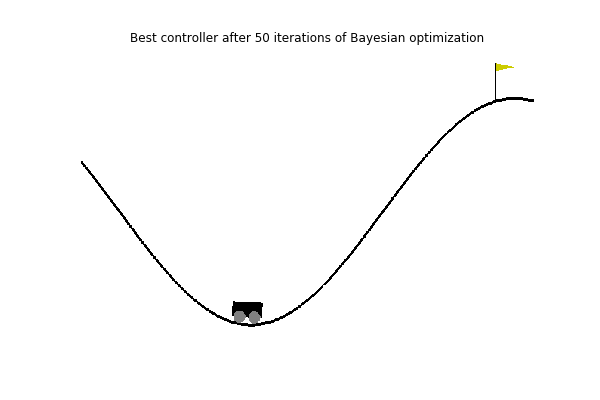
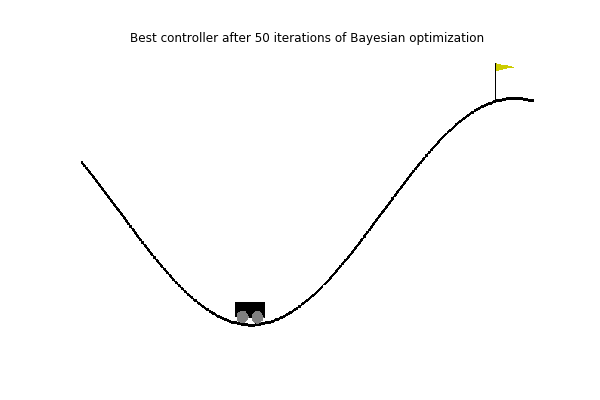
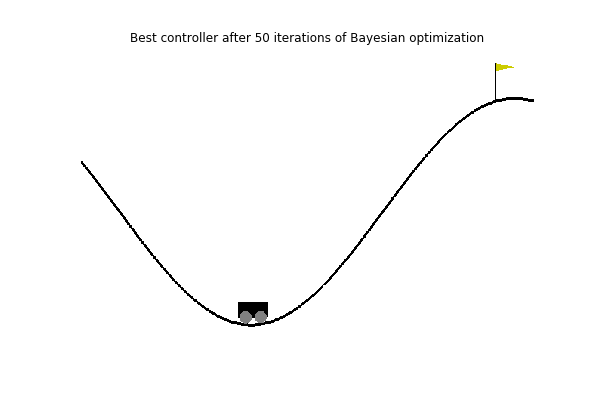
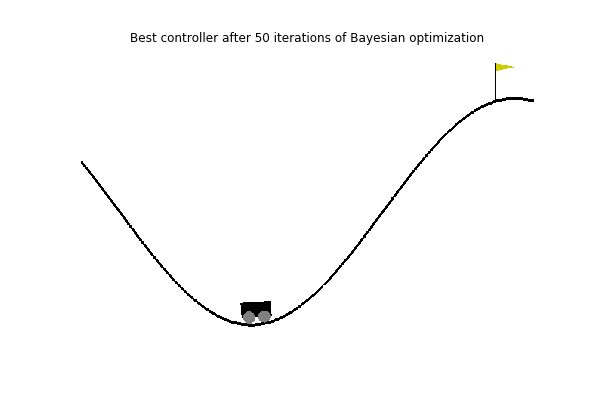
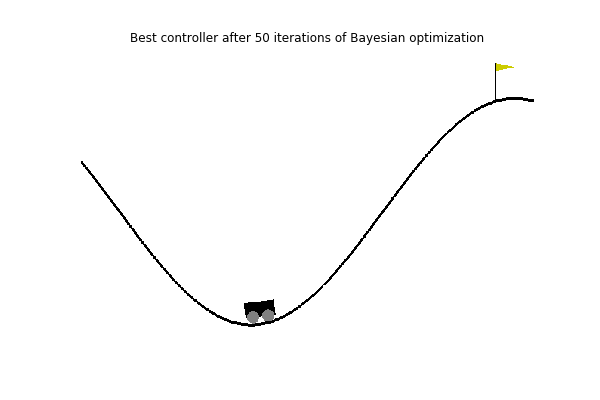
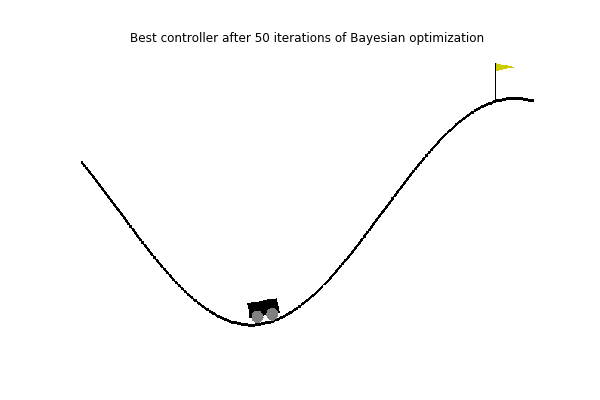
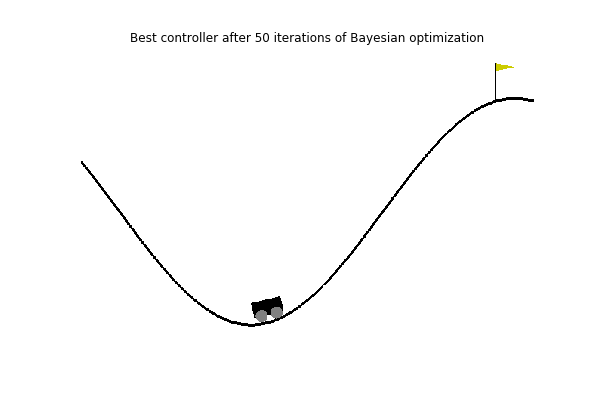
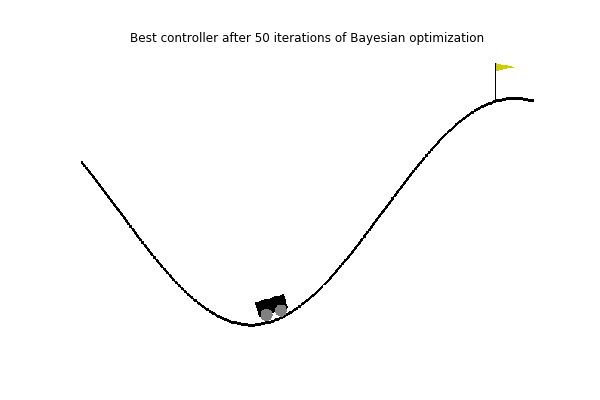
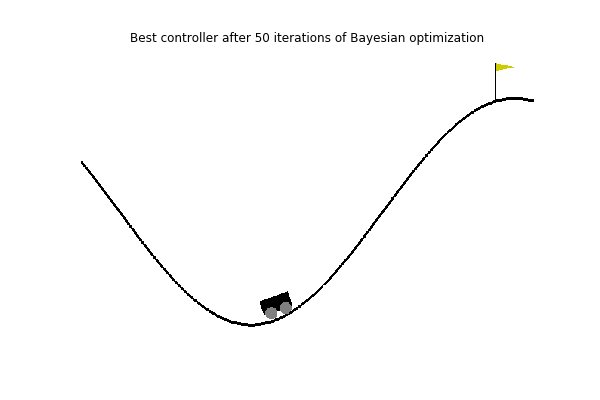
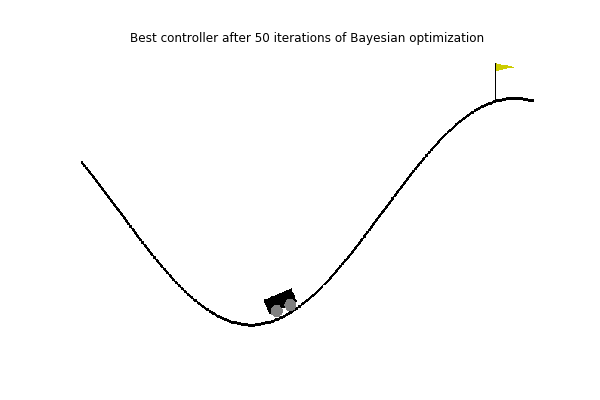
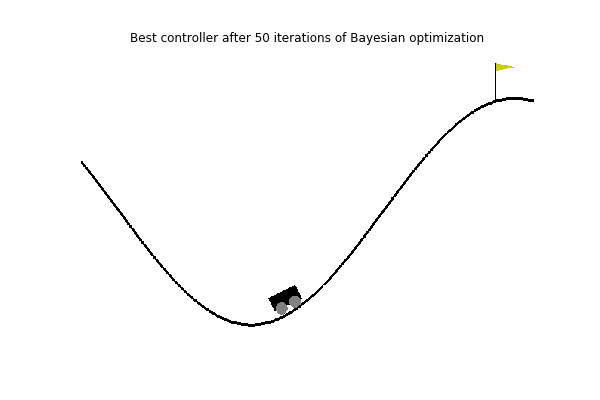
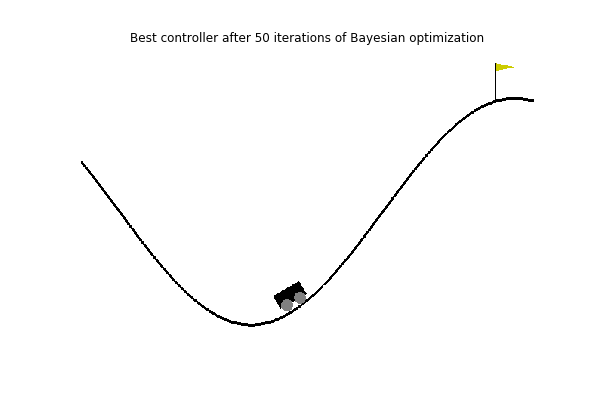
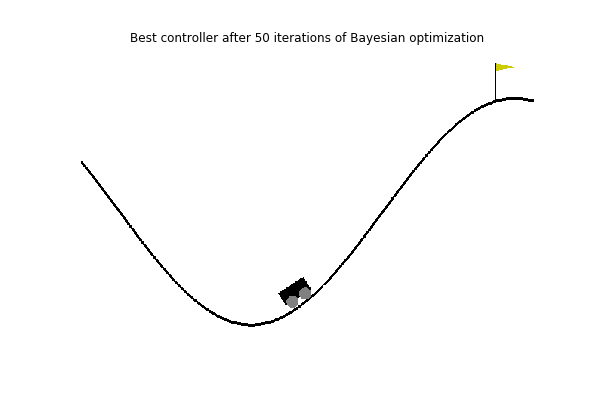
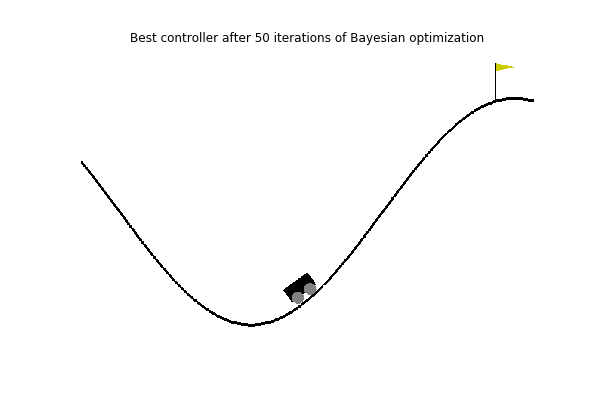
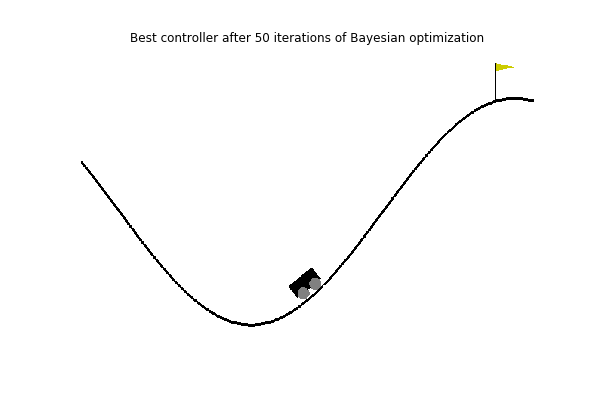
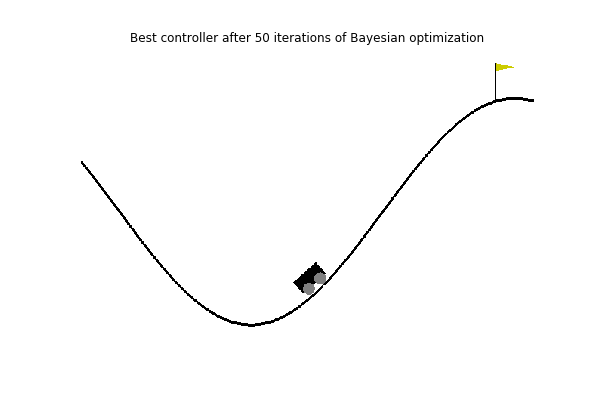
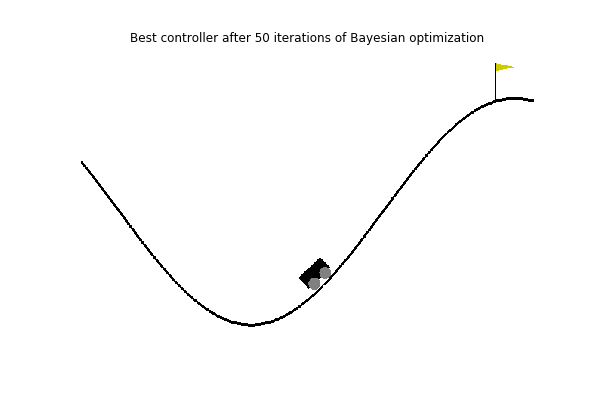
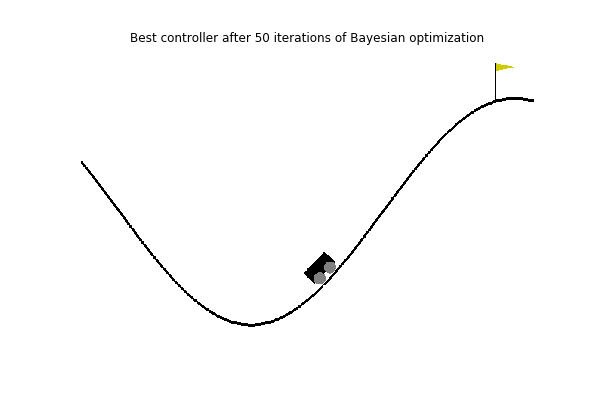
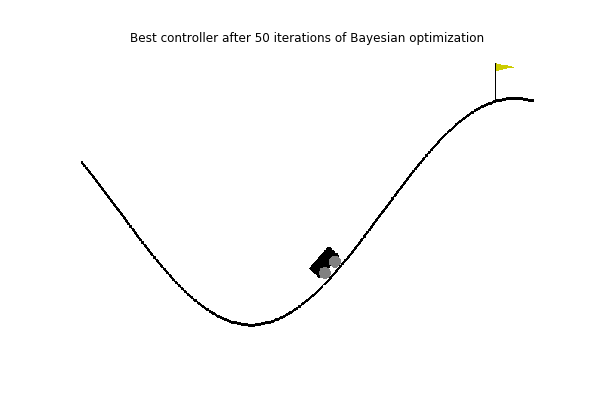
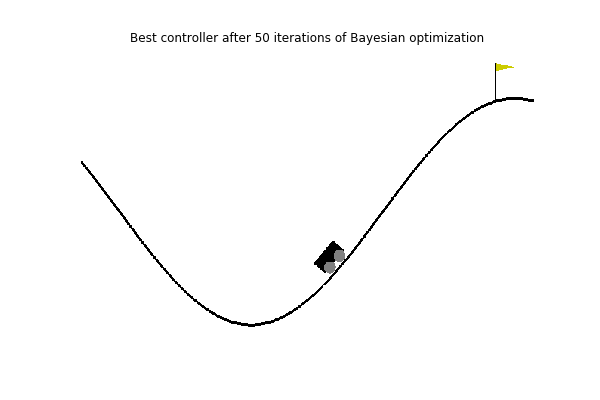
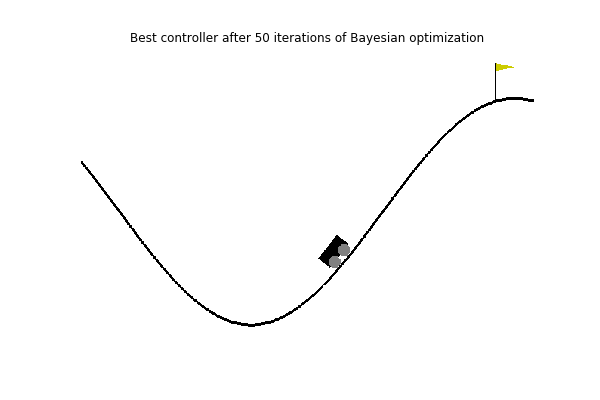
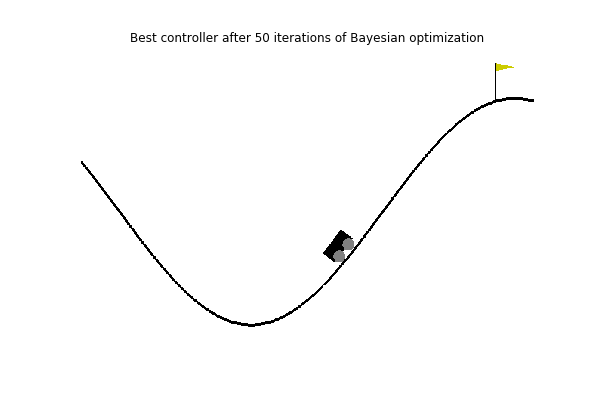
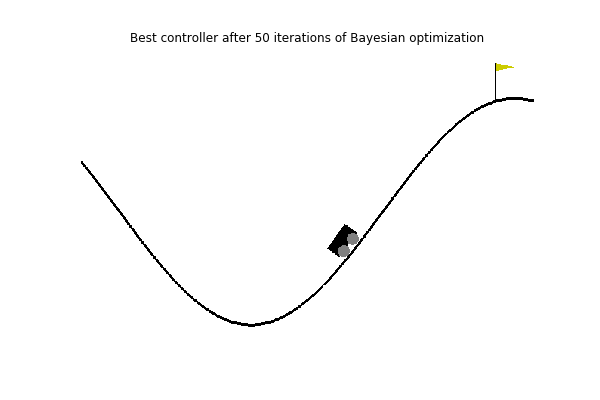
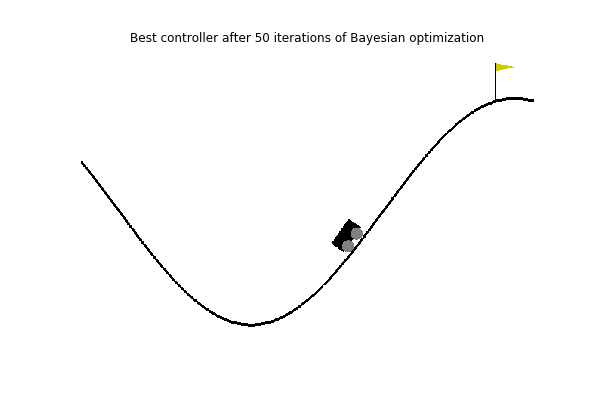
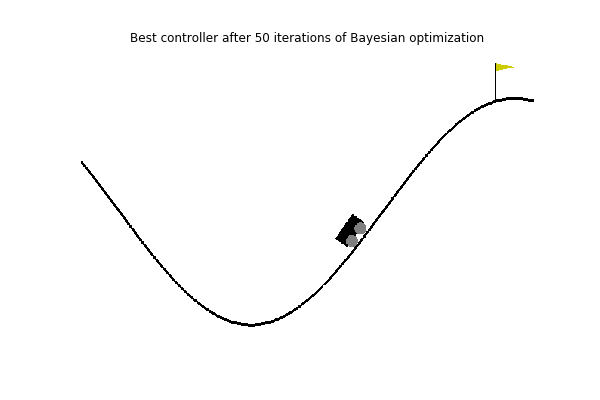
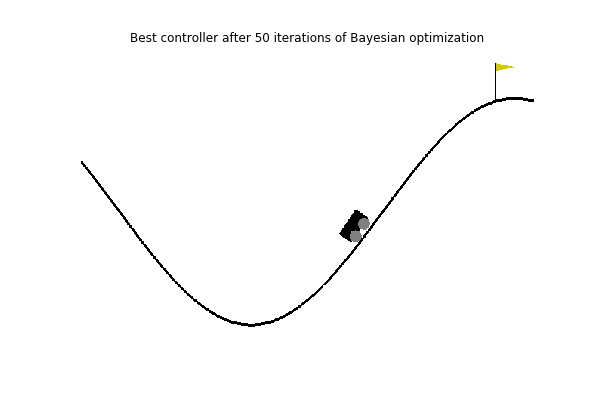
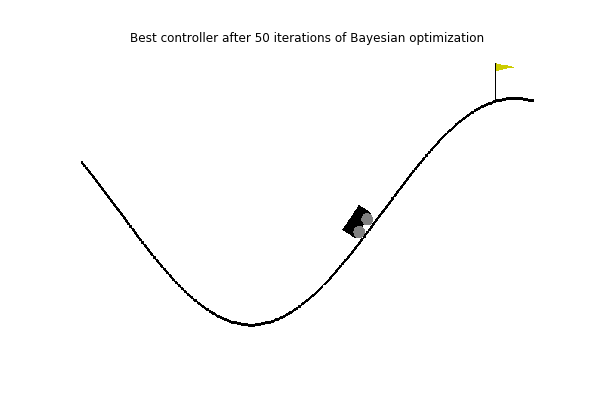
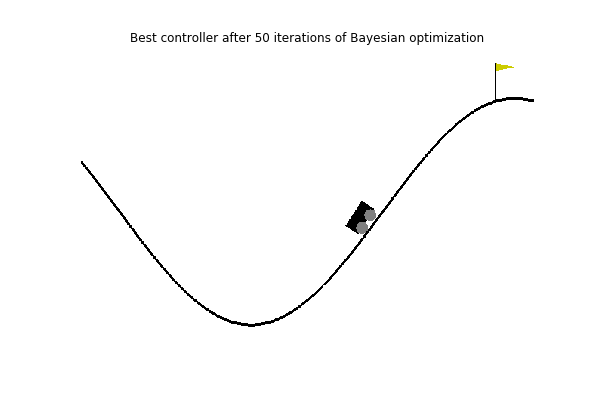
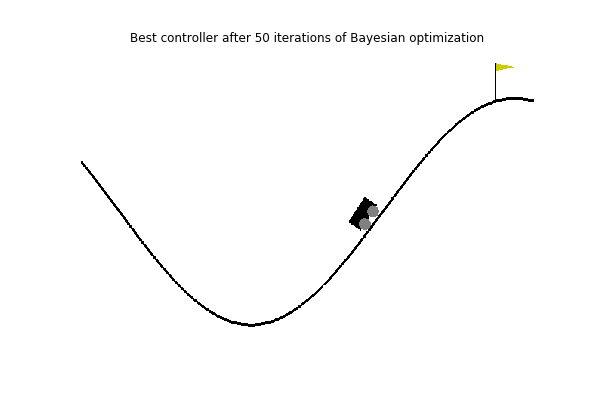
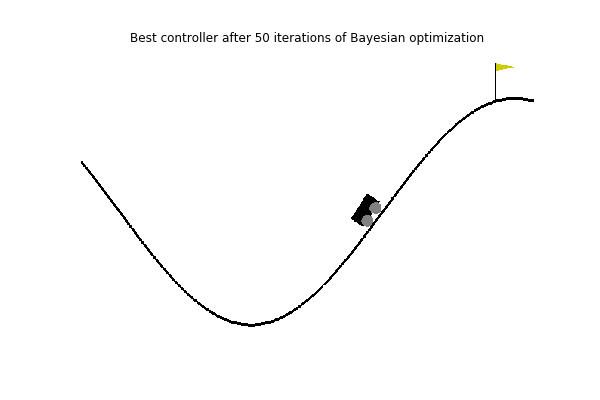
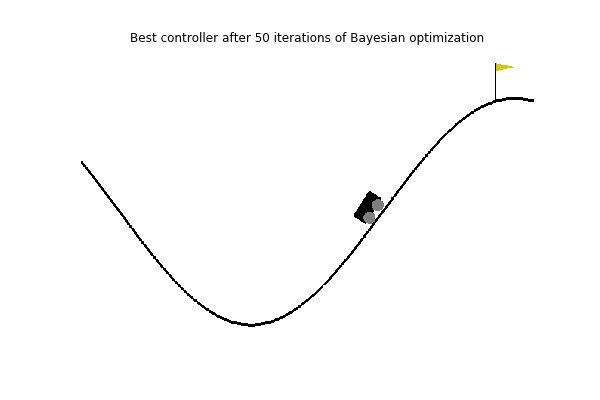
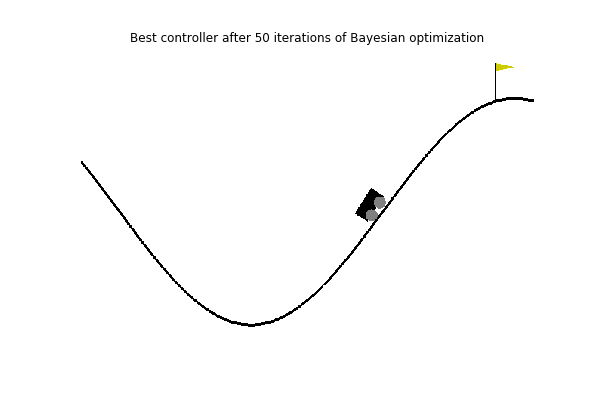
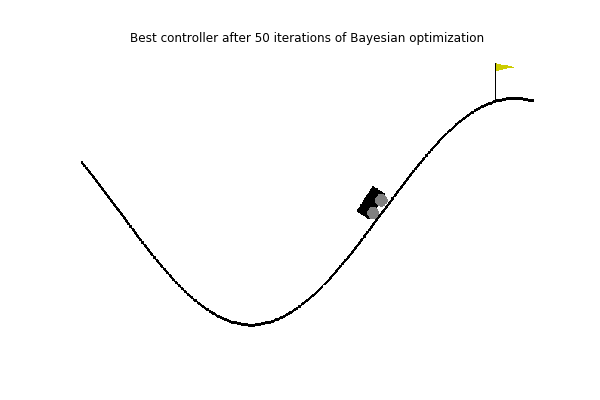
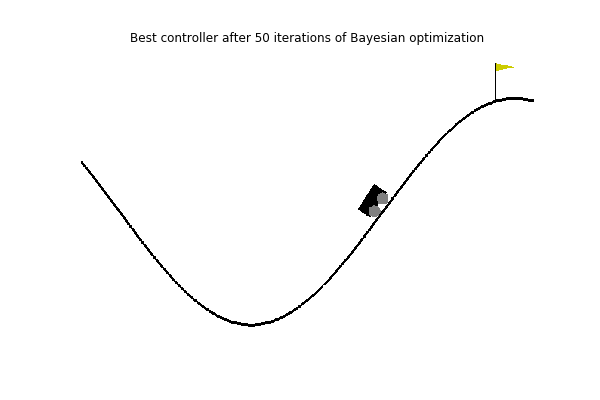
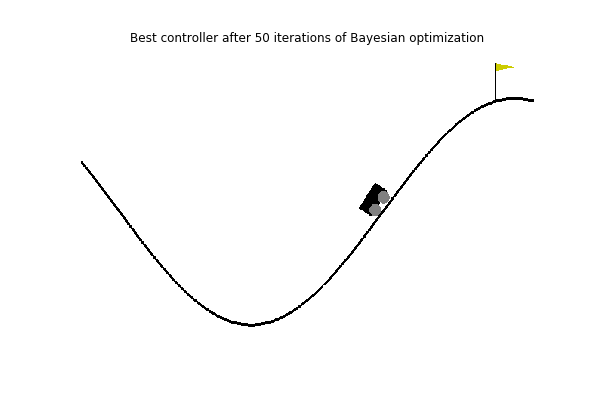
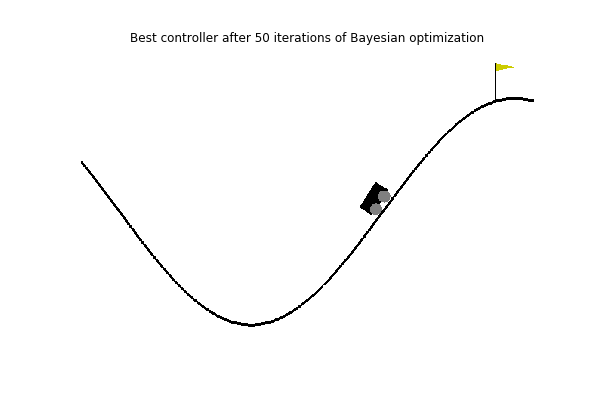
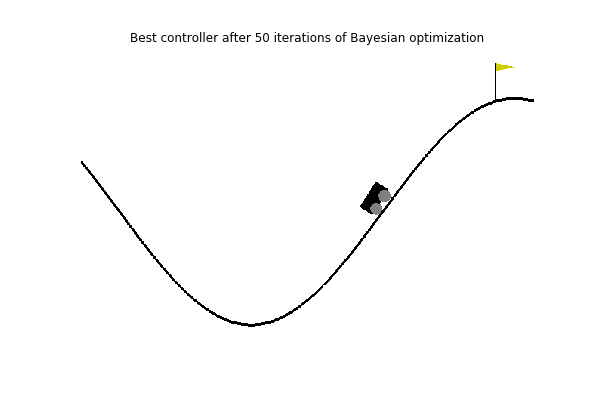
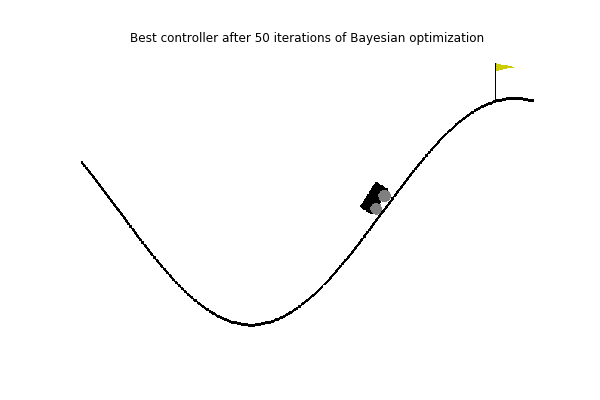
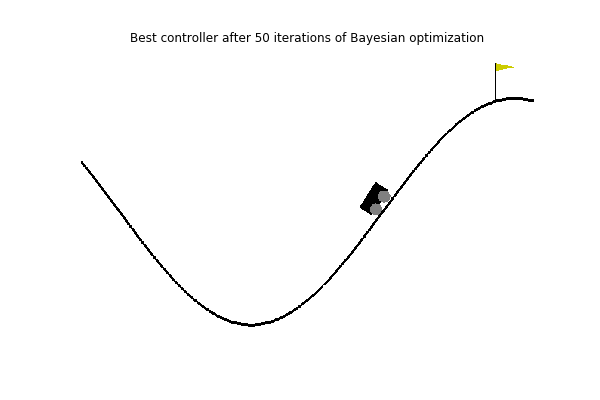
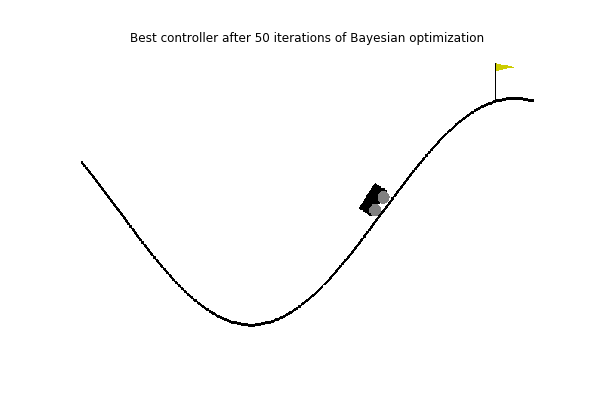
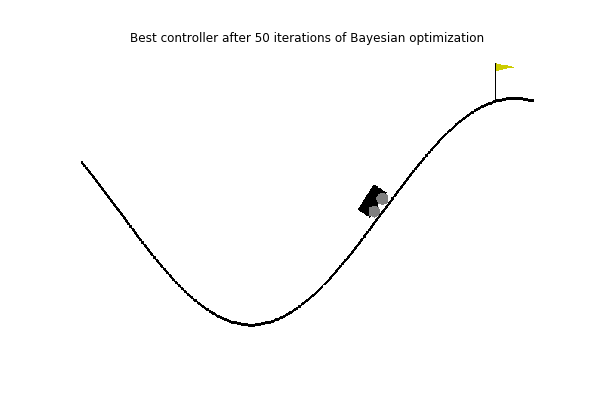
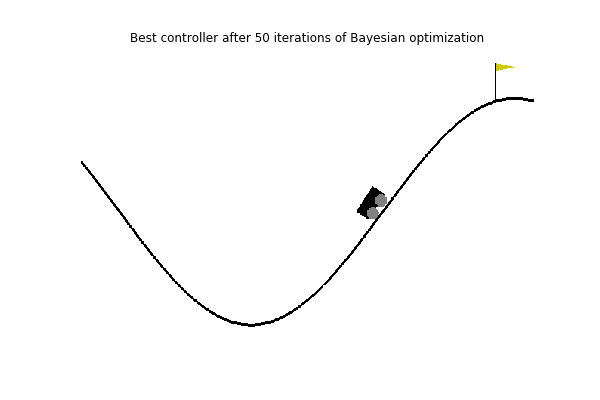
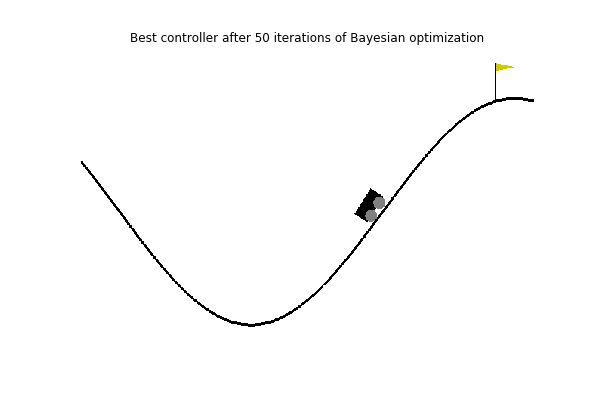
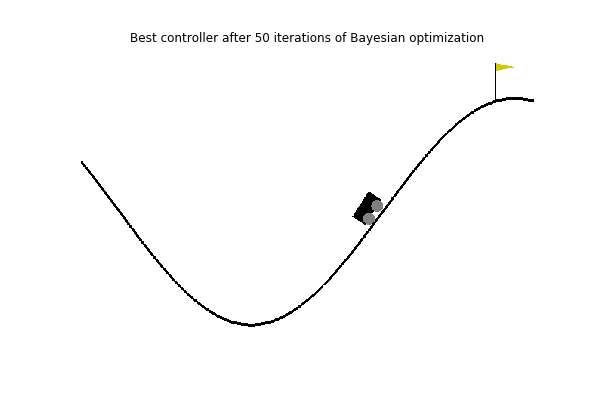
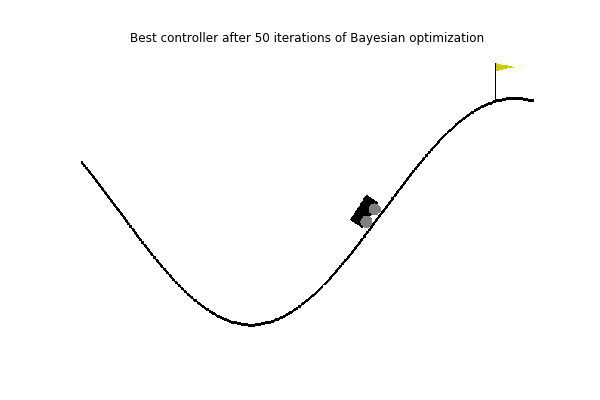
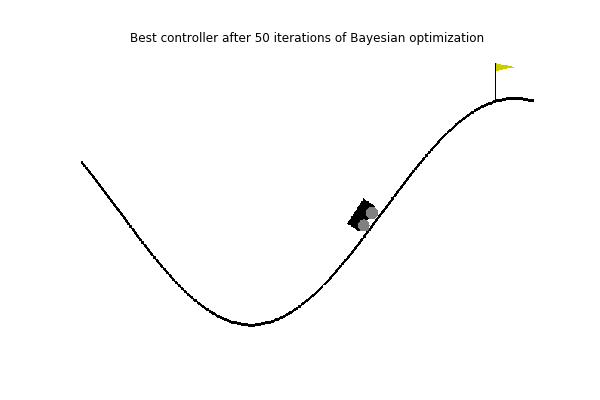
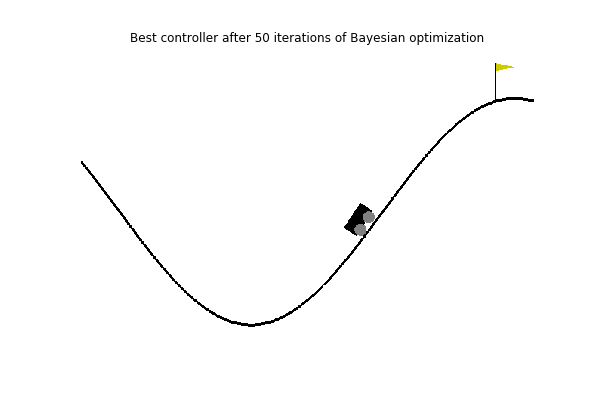
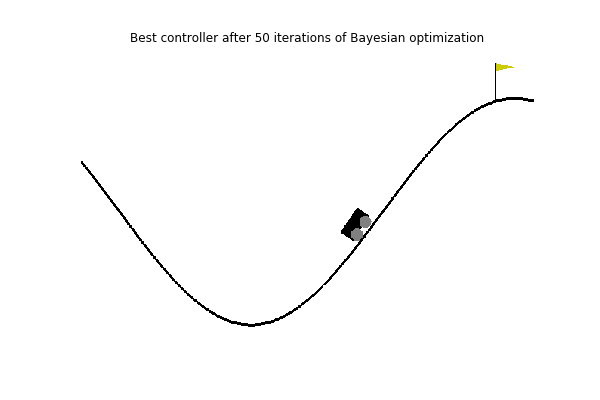
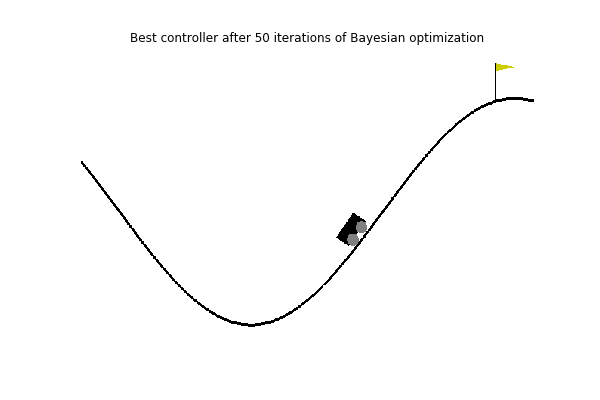
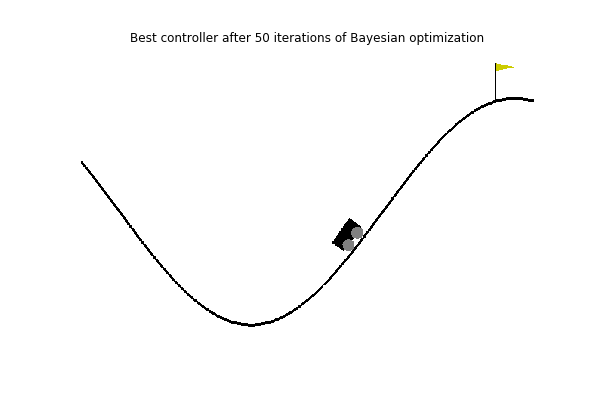
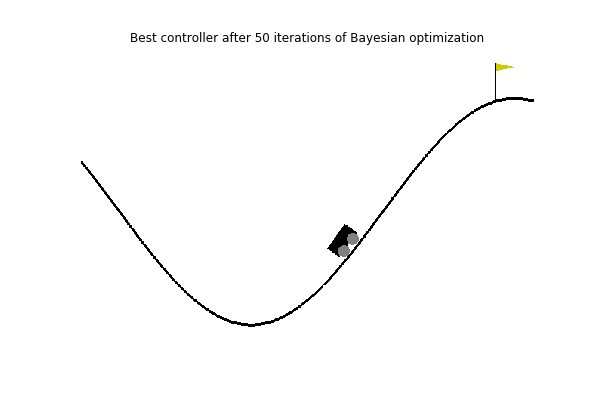
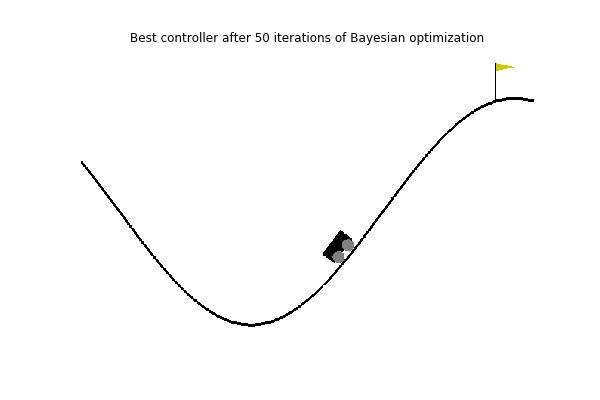
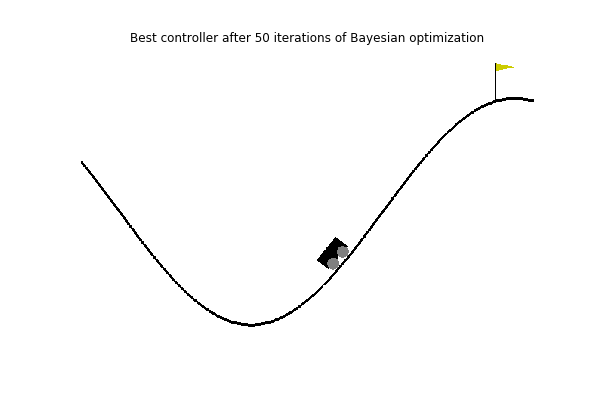
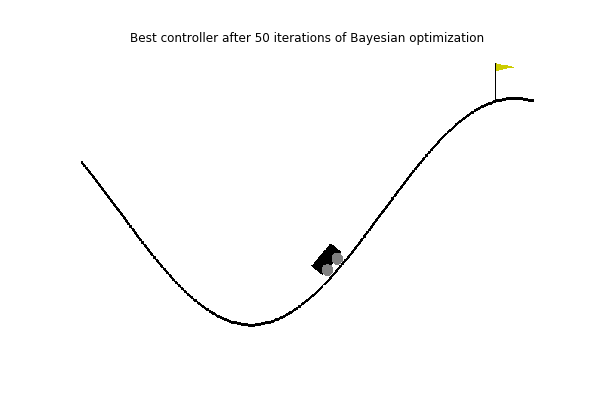
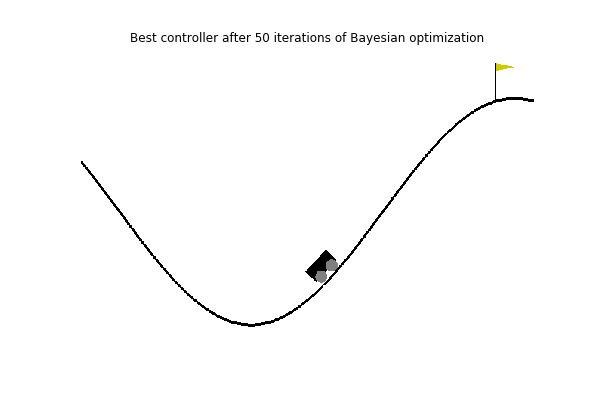
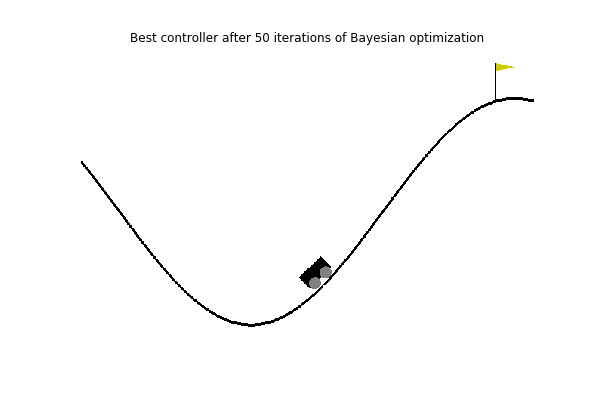
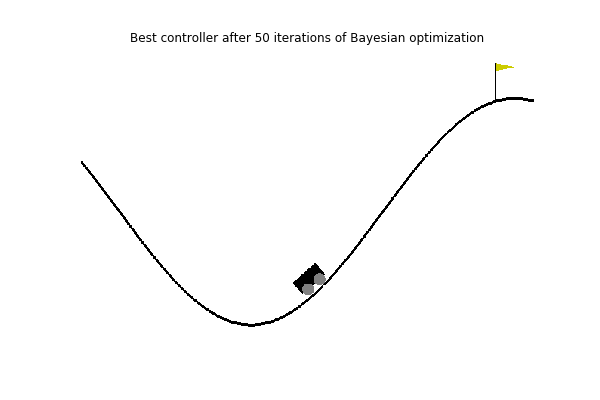
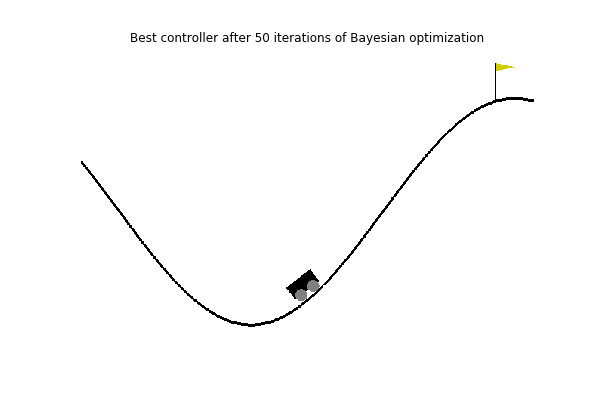
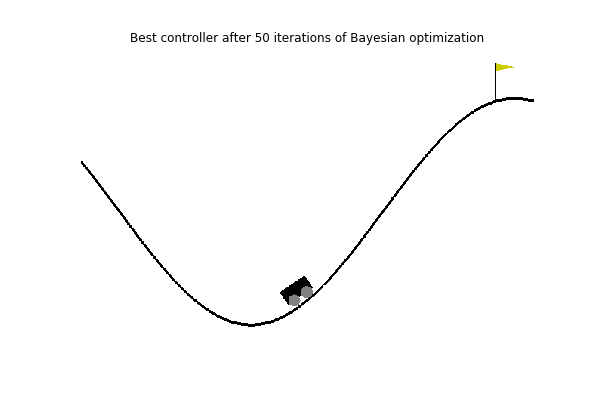
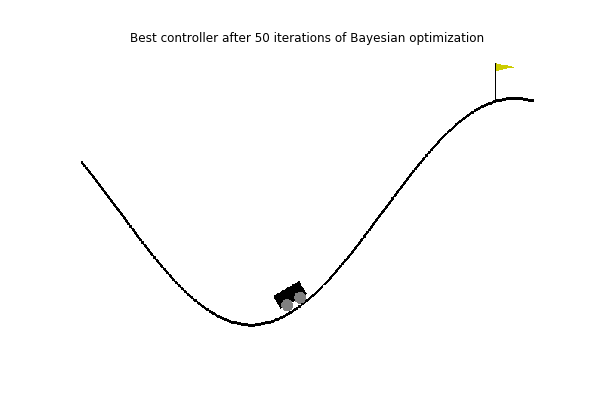
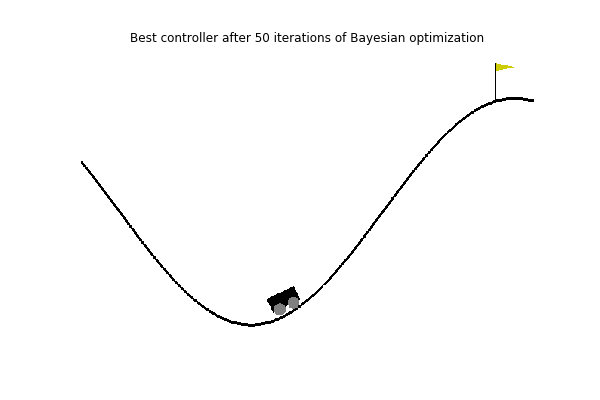
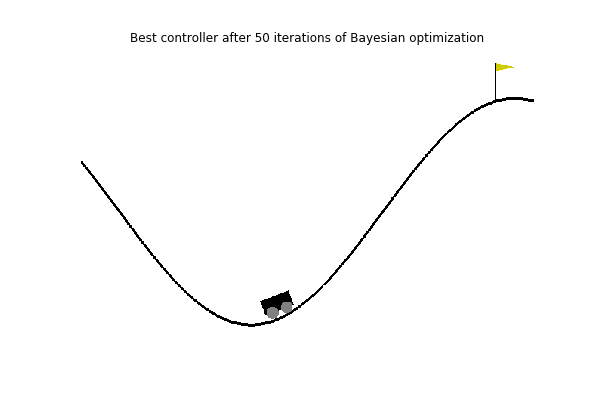
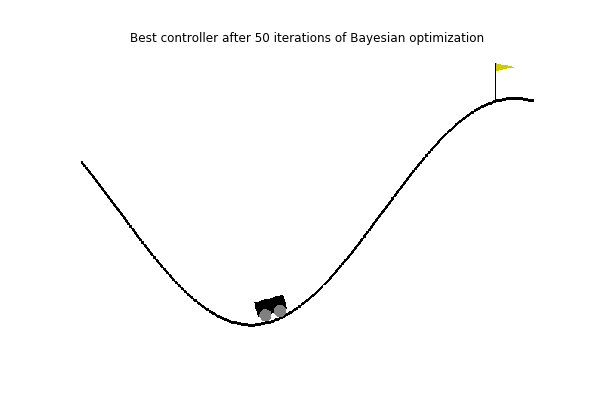
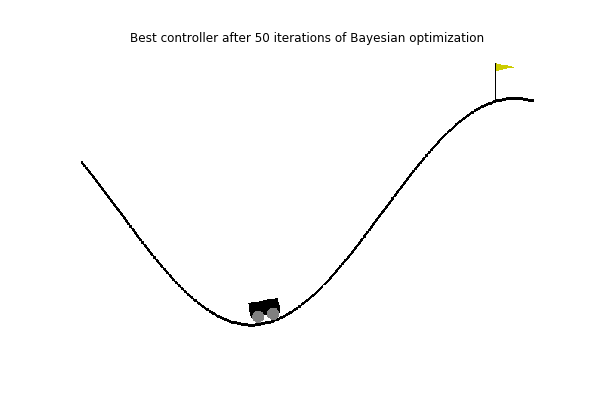
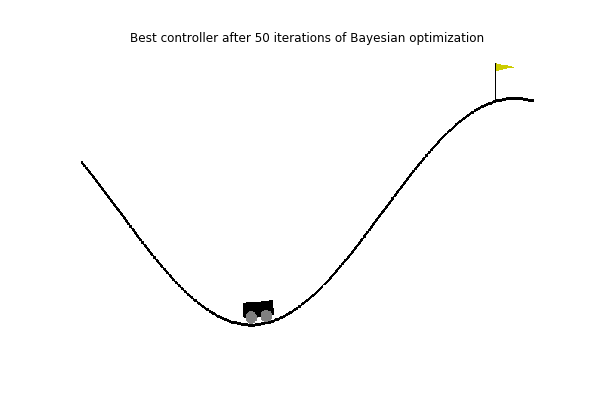
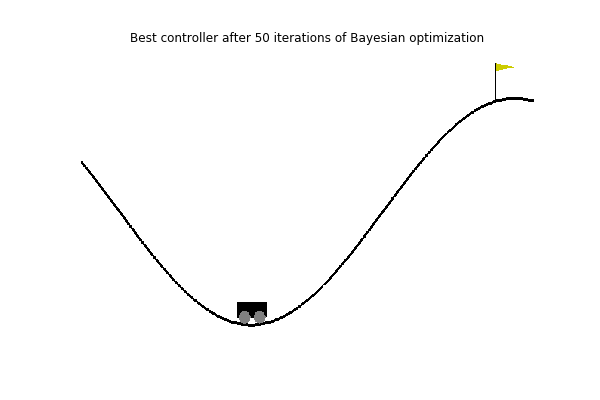
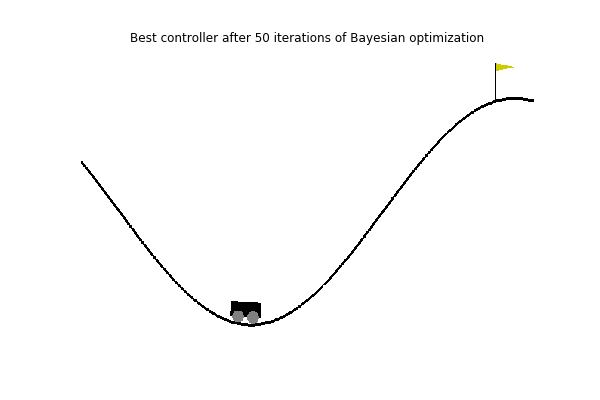
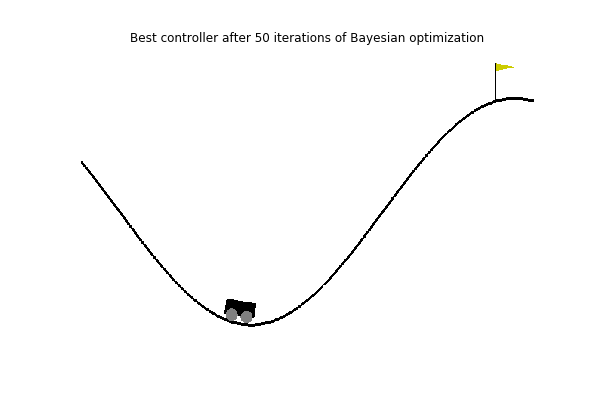
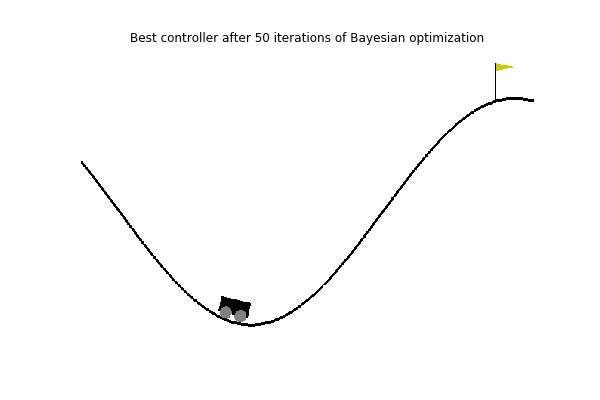
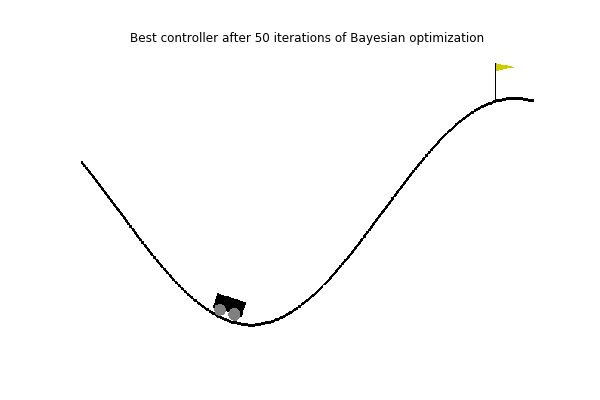
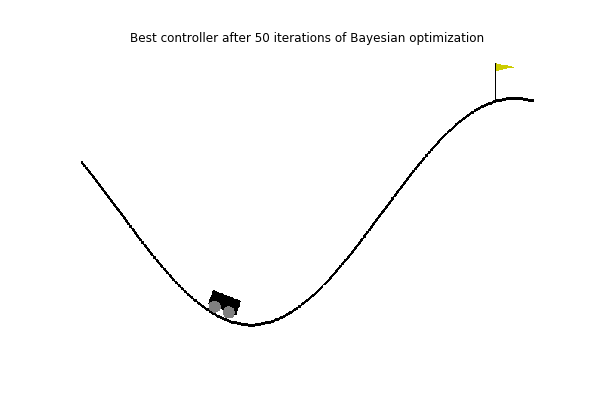
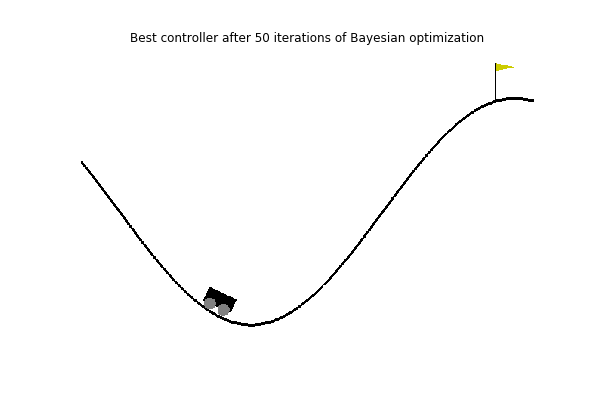
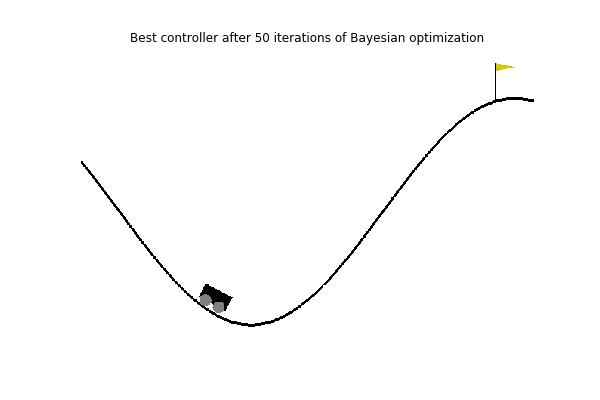
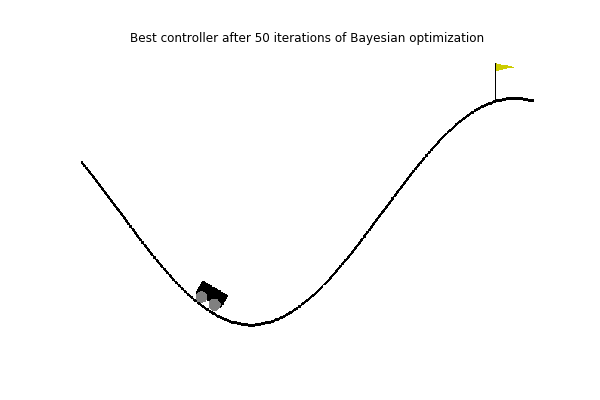
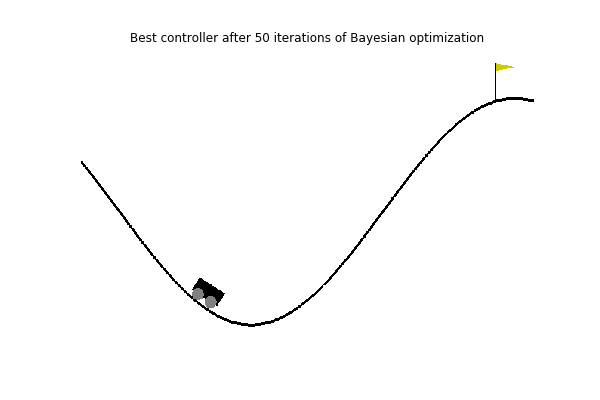
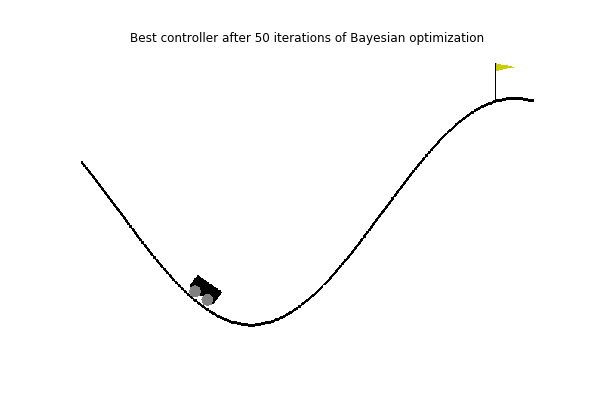
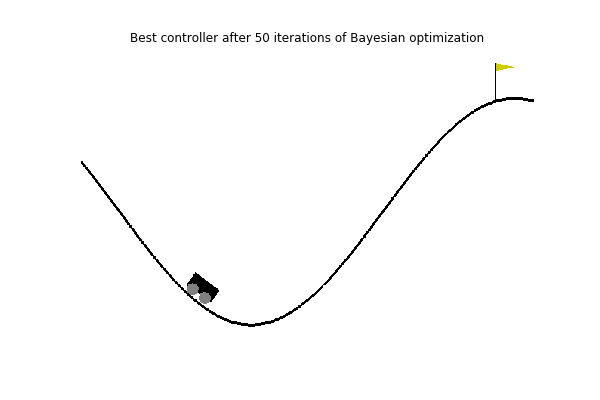
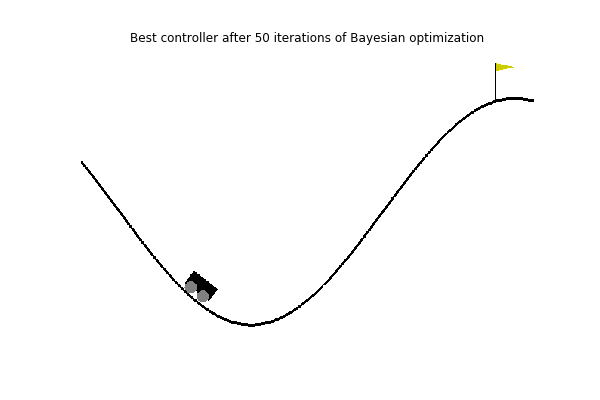
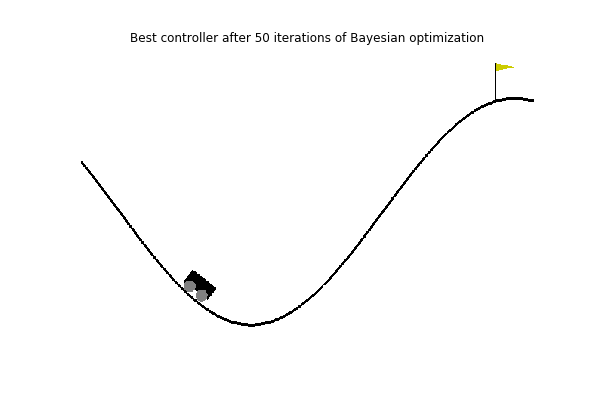
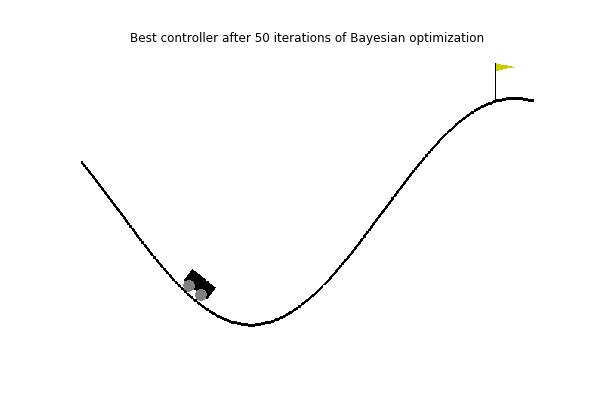
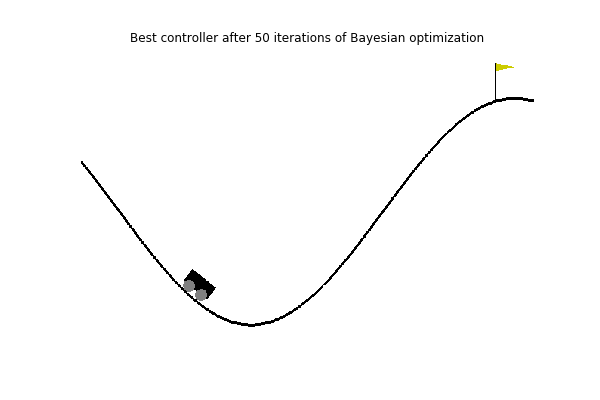
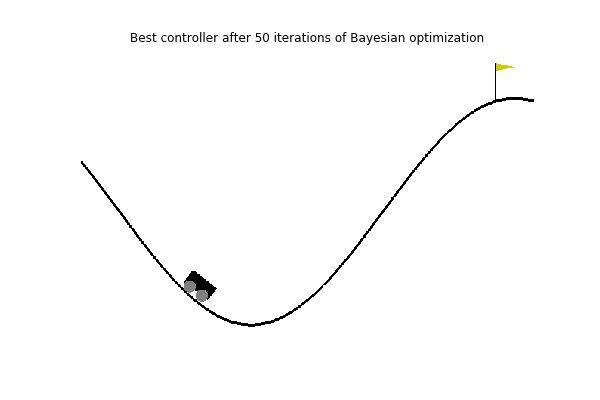
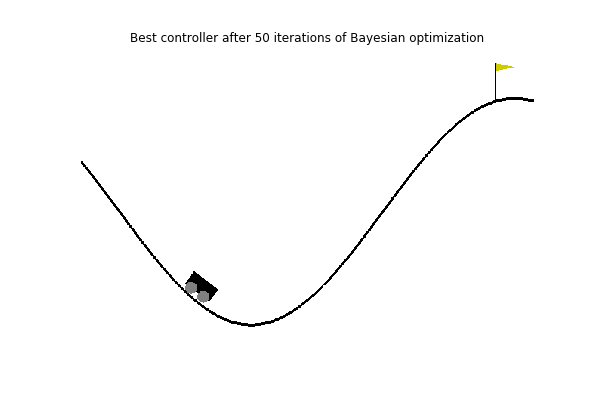
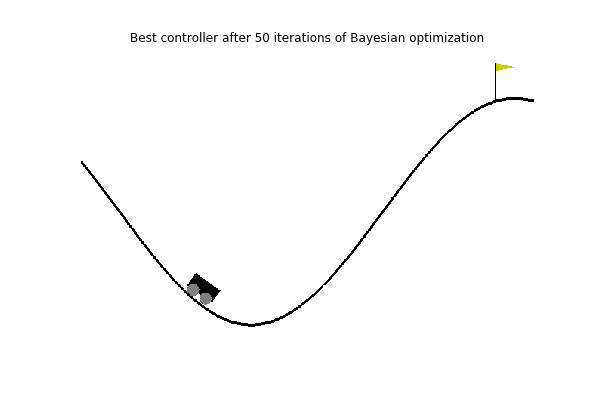
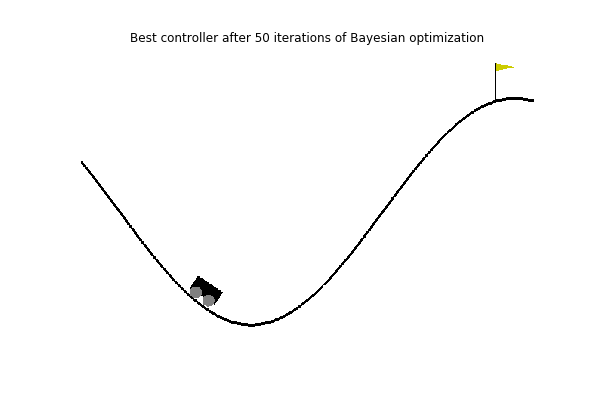
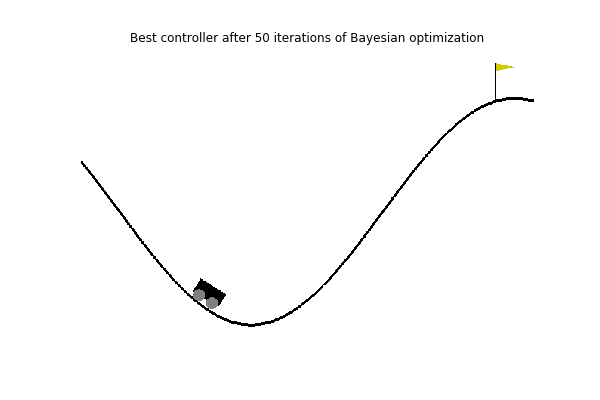
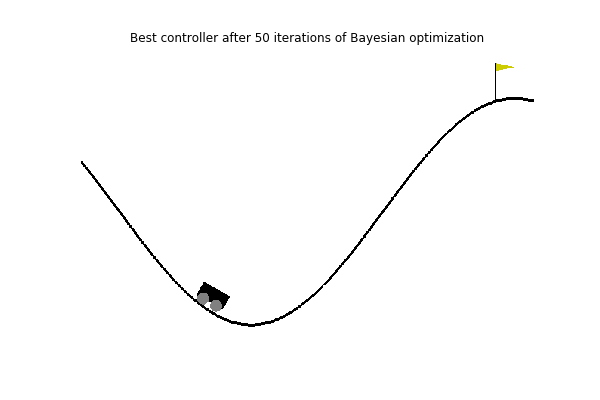
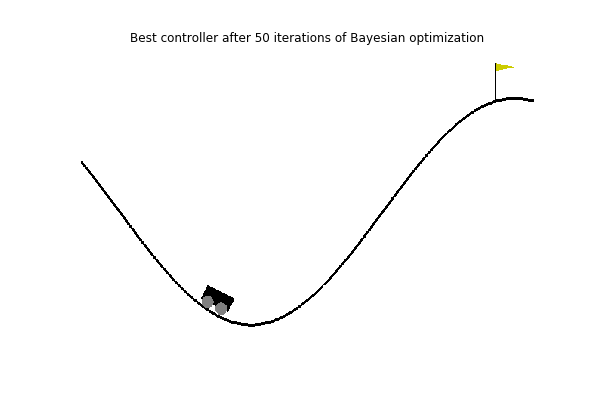
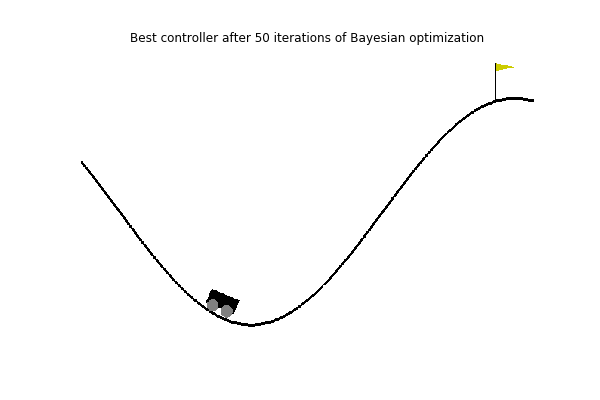
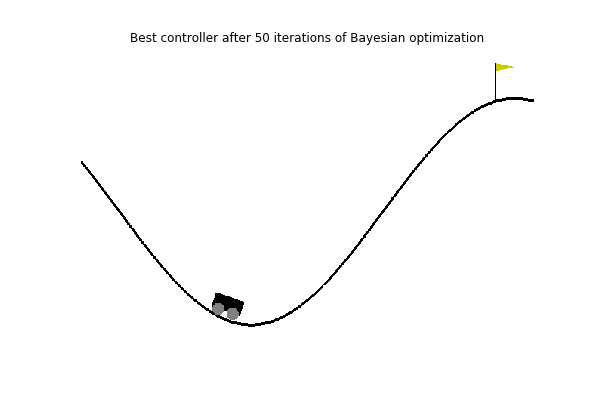
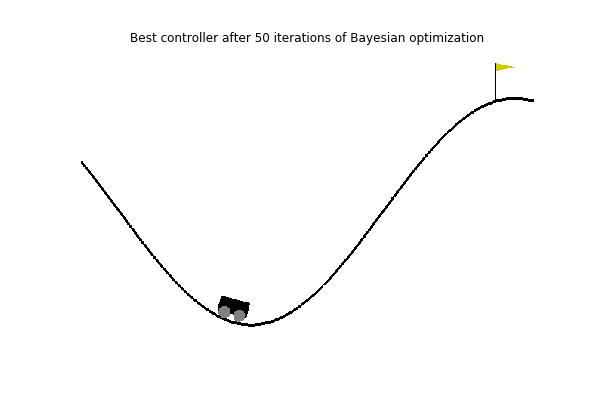
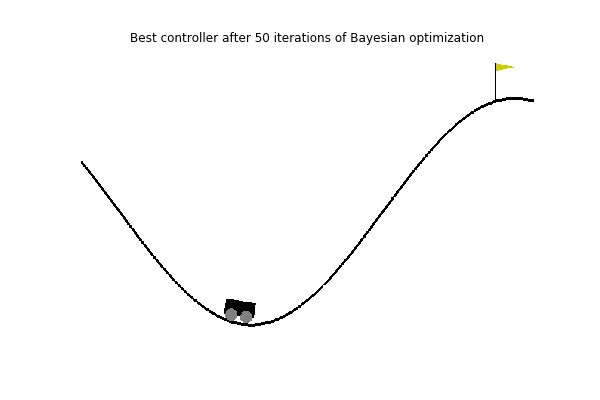
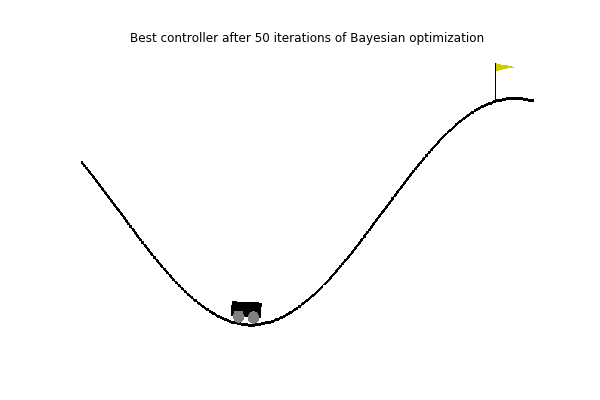
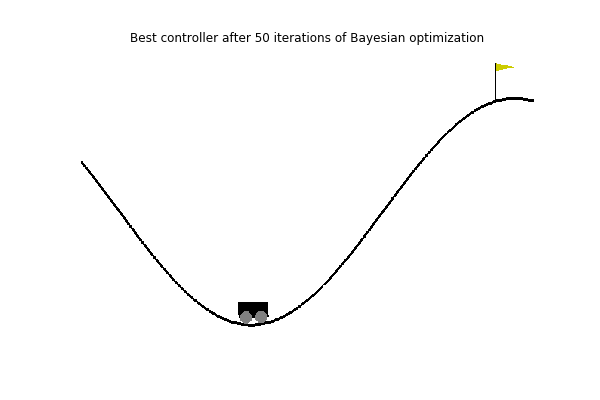
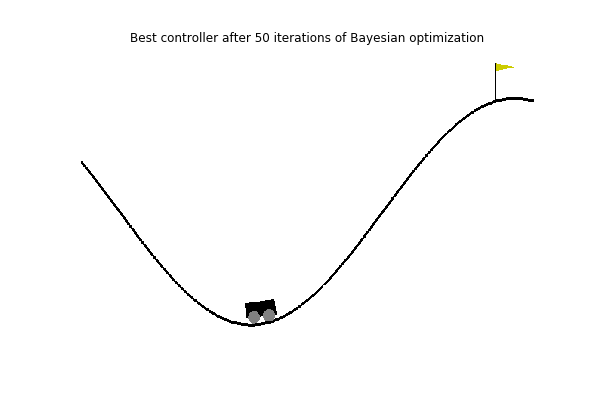
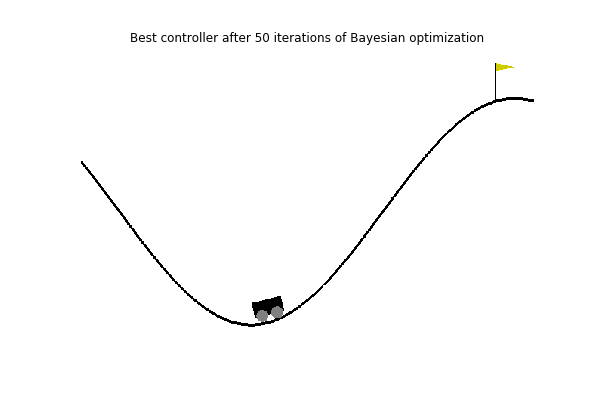
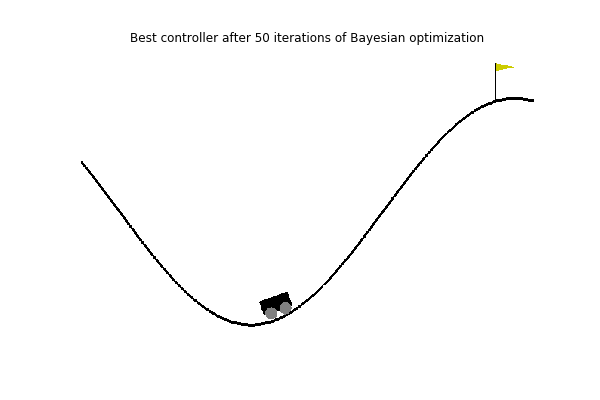
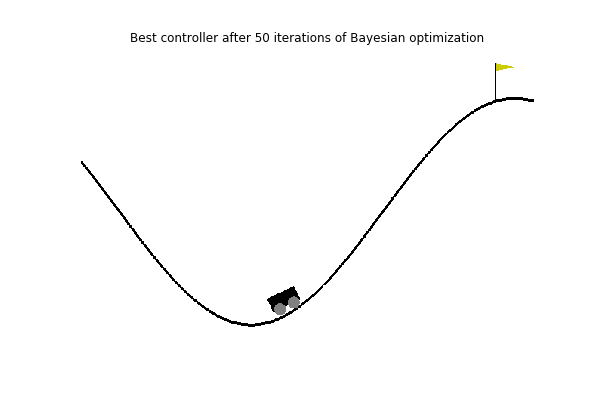
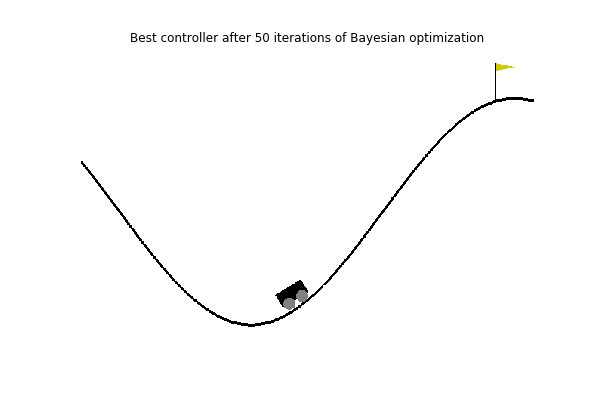
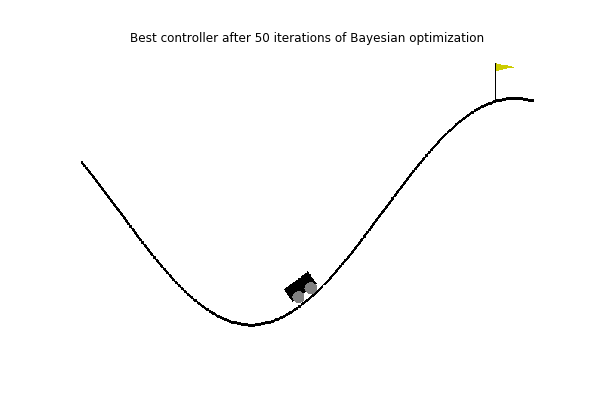
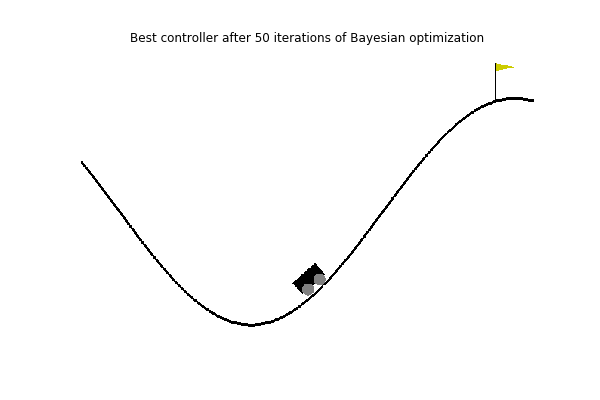
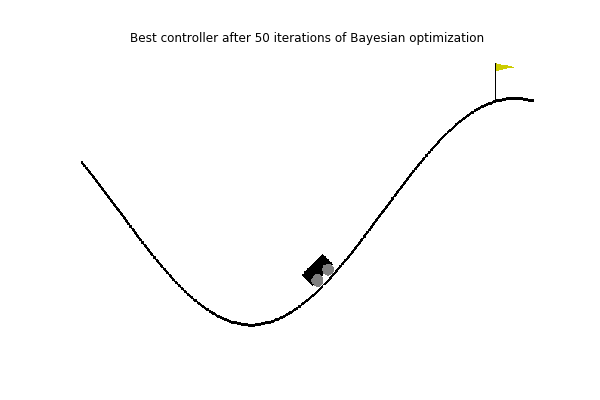
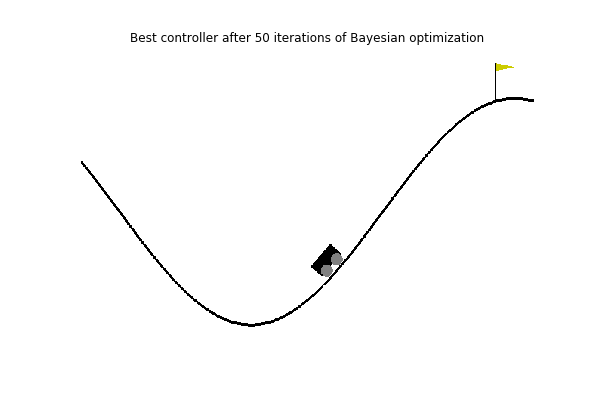
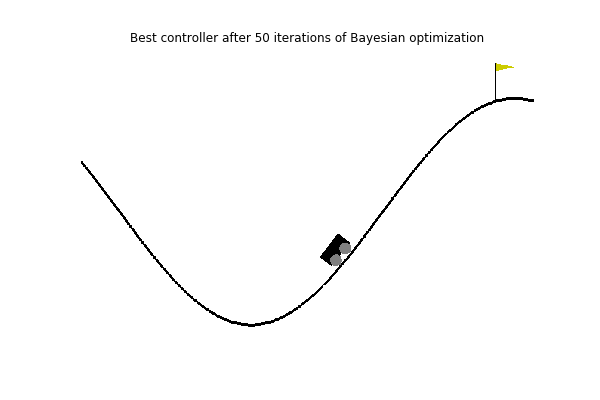
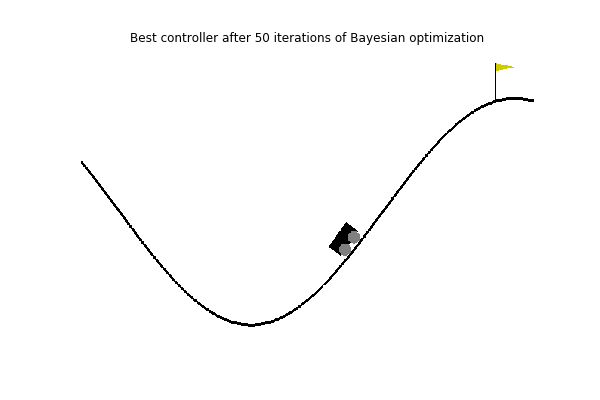
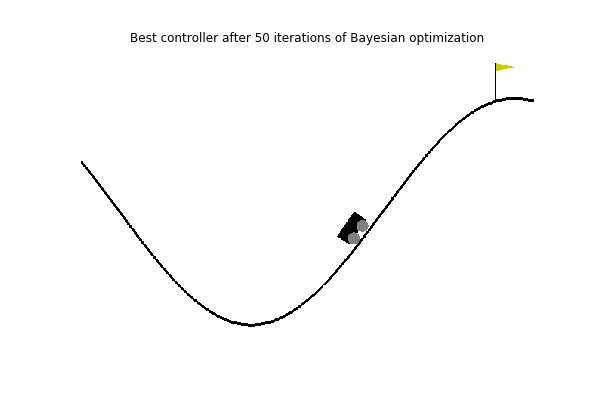
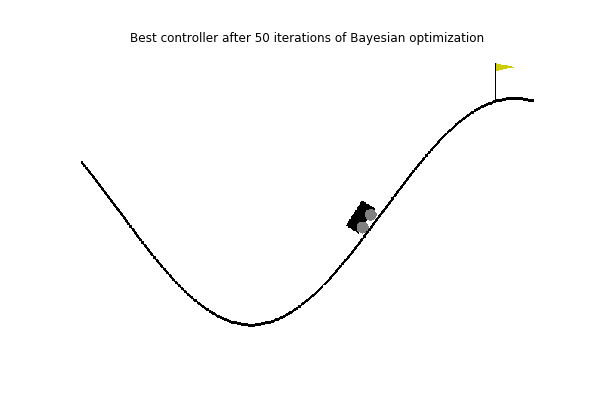
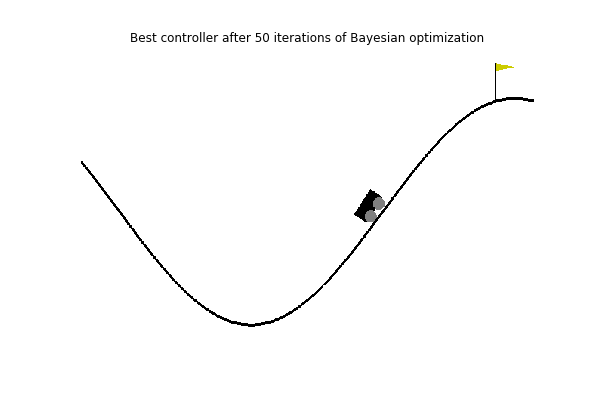
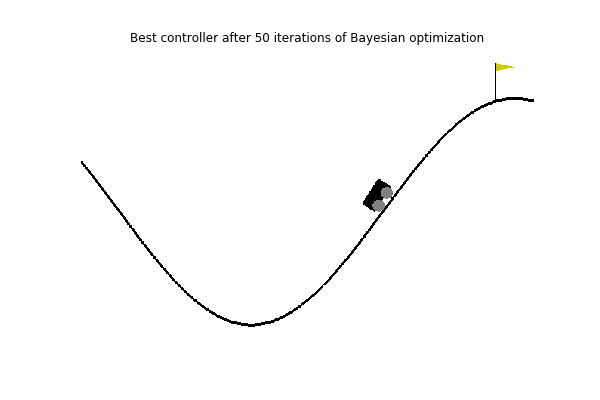
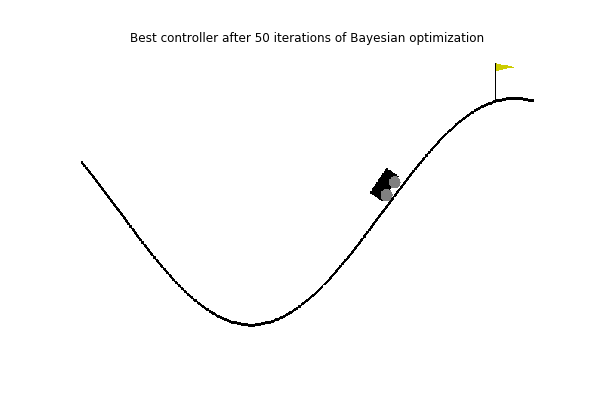
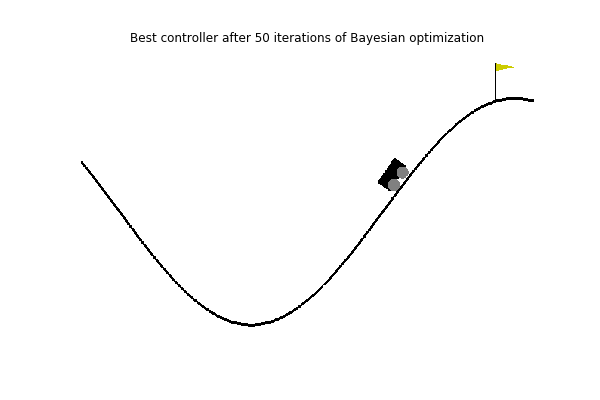
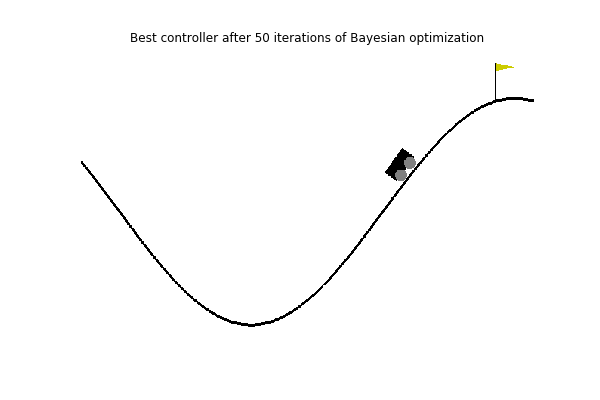
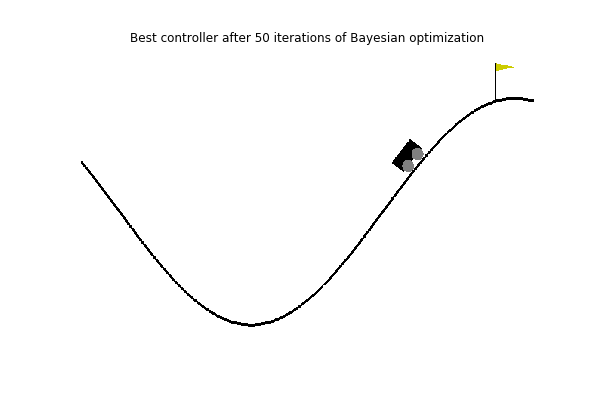
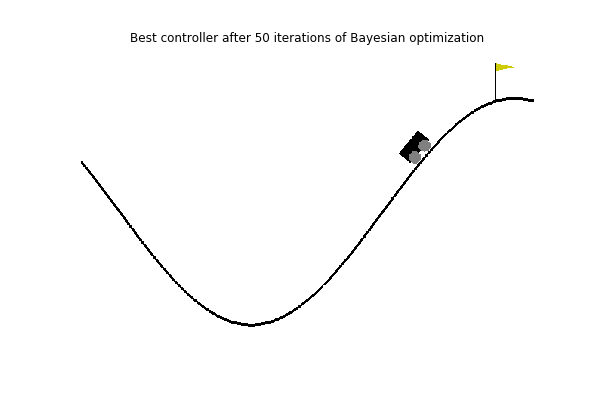
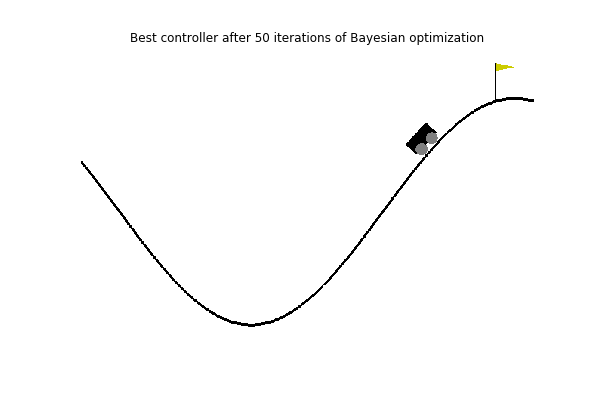
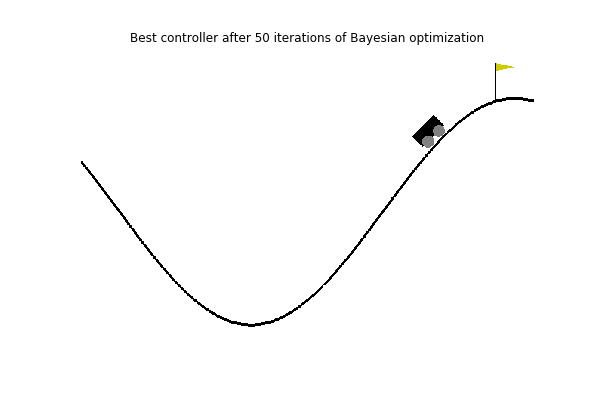
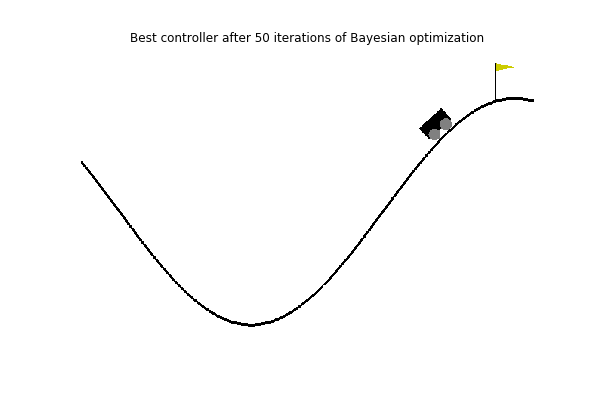
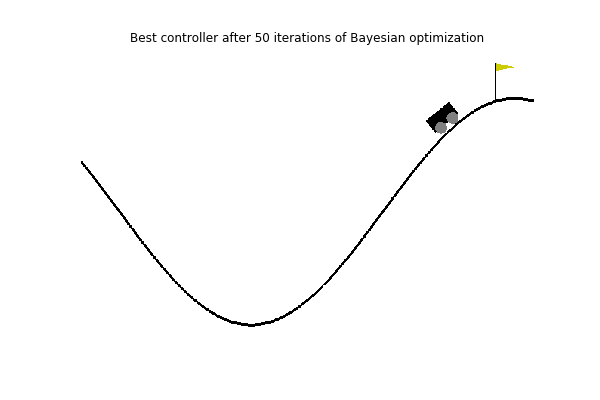
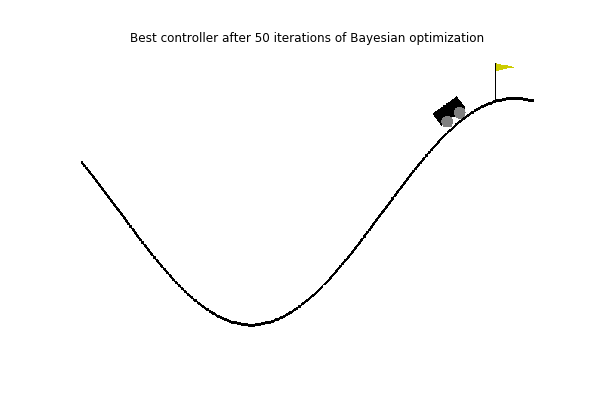
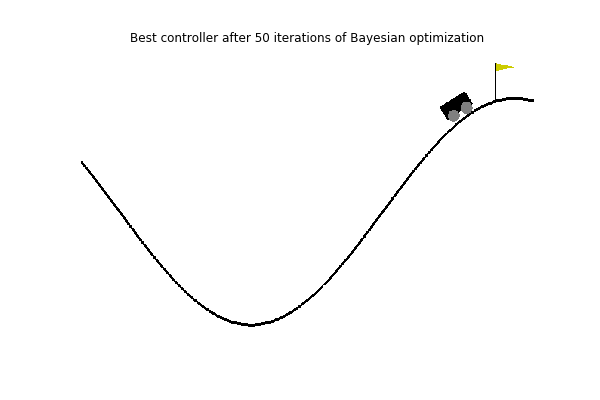
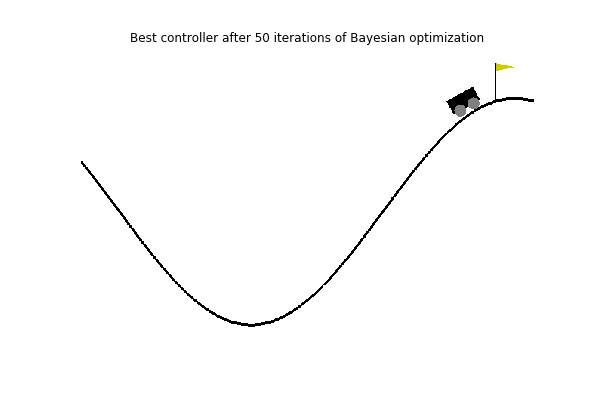
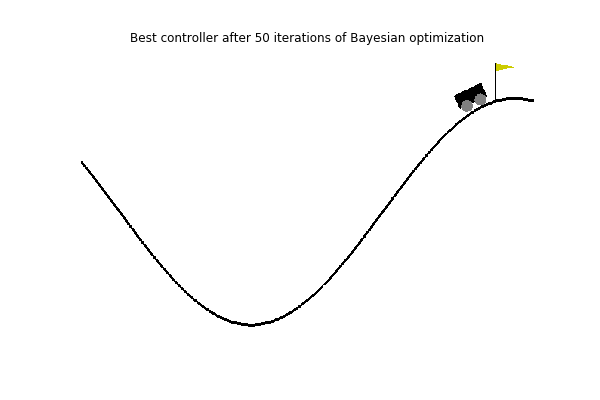
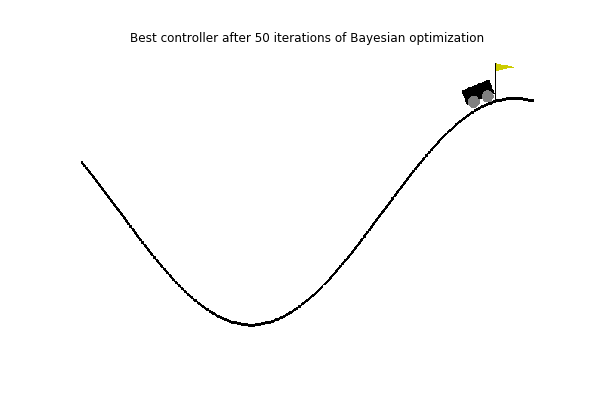
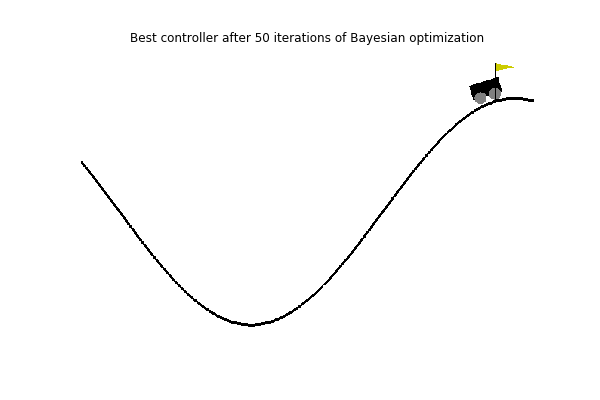

In [18]:
x_opt_emulator = bayesopt_loop_emulator.loop_state.X[np.argmin(bayesopt_loop.loop_state.Y),:]
_, _, _, frames = mc.run_simulation(env, np.atleast_2d(x_opt), render=True)
mc.display_frames_as_gif(frames, 'Best controller after 50 iterations of Bayesian optimization')

We have solved the problem again! Note that in this case we have replaced the simulator of the dynamics of the car by a Gaussian process emulator that we have learned by calling the simulator only 500 times. Compared to the 37500 calls that we needed when applying Bayesian optimization directly on the simulator this is a great gain!!

## 5. Conclusions

In this notebook we have analyzed the mountain car simulator from two different perspectives. First, we have optimized a linear controller by building an emulator mapping policies to reward. Second we have built an emulator of the dynamics of the system that we have used to replace the entire simulator when optimizing the control policy. 